# Importing Libraries

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd

## Declare image paths

Change these paths to change the input data

In [5]:
images_path = r'C:\projects\Unet\Drug_treated_image\images'
masks_path = r'C:\projects\Unet\Drug_treated_image\masks'

## Get the folders where the images are contained

In [39]:
import os

input_dir = images_path
target_dir = masks_path
img_size = (640, 640)
num_classes = 3
batch_size = 1

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 12
C:\projects\Unet\Drug_treated_image\images\1.jpg | C:\projects\Unet\Drug_treated_image\masks\1.jpg
C:\projects\Unet\Drug_treated_image\images\10.jpg | C:\projects\Unet\Drug_treated_image\masks\10.jpg
C:\projects\Unet\Drug_treated_image\images\11.jpg | C:\projects\Unet\Drug_treated_image\masks\11.jpg
C:\projects\Unet\Drug_treated_image\images\12.jpg | C:\projects\Unet\Drug_treated_image\masks\12.jpg
C:\projects\Unet\Drug_treated_image\images\2.jpg | C:\projects\Unet\Drug_treated_image\masks\2.jpg
C:\projects\Unet\Drug_treated_image\images\3.jpg | C:\projects\Unet\Drug_treated_image\masks\3.jpg
C:\projects\Unet\Drug_treated_image\images\4.jpg | C:\projects\Unet\Drug_treated_image\masks\4.jpg
C:\projects\Unet\Drug_treated_image\images\5.jpg | C:\projects\Unet\Drug_treated_image\masks\5.jpg
C:\projects\Unet\Drug_treated_image\images\6.jpg | C:\projects\Unet\Drug_treated_image\masks\6.jpg
C:\projects\Unet\Drug_treated_image\images\7.jpg | C:\projects\Unet\Drug_treated_

## Preprocessing of images and their masks

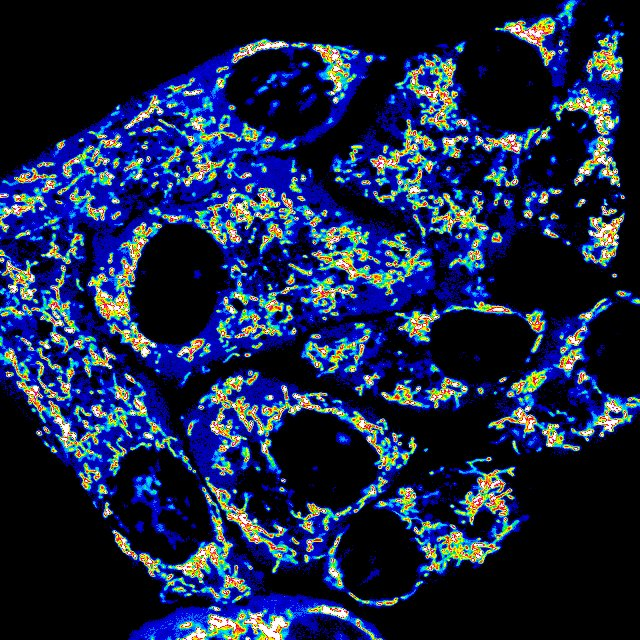

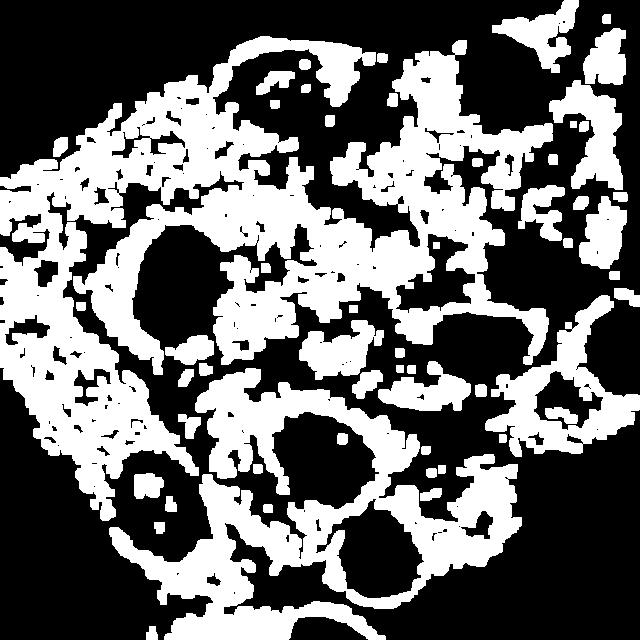

(640, 640)


In [40]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)
print(img.size)

## Prepare Sequence class

In [41]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class DrugSegment(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

## Importing the Model

In [42]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 320, 320, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 320, 320, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

 max_pooling2d_2 (MaxPooling2D)  (None, 40, 40, 256)  0          ['batch_normalization_6[0][0]']  
                                                                                                  
 conv2d_3 (Conv2D)              (None, 40, 40, 256)  33024       ['add_1[0][0]']                  
                                                                                                  
 add_2 (Add)                    (None, 40, 40, 256)  0           ['max_pooling2d_2[0][0]',        
                                                                  'conv2d_3[0][0]']               
                                                                                                  
 activation_7 (Activation)      (None, 40, 40, 256)  0           ['add_2[0][0]']                  
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 40, 40, 256)  590080     ['activation_7[0][0]']           
 ose)     

                                                                                                  
 conv2d_6 (Conv2D)              (None, 320, 320, 64  8256        ['up_sampling2d_5[0][0]']        
                                )                                                                 
                                                                                                  
 add_5 (Add)                    (None, 320, 320, 64  0           ['up_sampling2d_4[0][0]',        
                                )                                 'conv2d_6[0][0]']               
                                                                                                  
 activation_13 (Activation)     (None, 320, 320, 64  0           ['add_5[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_tr

## Set aside the test data

In [43]:
import random

# Split our img paths into a training and a validation set
val_samples = 4
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = DrugSegment(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = DrugSegment(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Train the Model

In [45]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("drug_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\Users\Mahad\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Mahad\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\projects\Unet\unet-env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\projects\Unet\unet-env\lib\site-packages\traitlets\config\application.py", line 978, in launch_instance
      app.start()
    File "C:\projects\Unet\unet-env\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\projects\Unet\unet-env\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Mahad\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\Mahad\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\Mahad\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\projects\Unet\unet-env\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\projects\Unet\unet-env\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\projects\Unet\unet-env\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\projects\Unet\unet-env\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\projects\Unet\unet-env\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\projects\Unet\unet-env\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\projects\Unet\unet-env\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "C:\projects\Unet\unet-env\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\projects\Unet\unet-env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\projects\Unet\unet-env\lib\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\projects\Unet\unet-env\lib\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\projects\Unet\unet-env\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Mahad\AppData\Local\Temp\ipykernel_25744\369998255.py", line 12, in <module>
      model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
    File "C:\projects\Unet\unet-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\projects\Unet\unet-env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\projects\Unet\unet-env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\projects\Unet\unet-env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\projects\Unet\unet-env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\projects\Unet\unet-env\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\projects\Unet\unet-env\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "C:\projects\Unet\unet-env\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\projects\Unet\unet-env\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\projects\Unet\unet-env\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\projects\Unet\unet-env\lib\site-packages\keras\losses.py", line 2084, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\projects\Unet\unet-env\lib\site-packages\keras\backend.py", line 5630, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 255 which is outside the valid range of [0, 3).  Label values: 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 4 255 2 255 5 5 255 255 2 255 4 0 255 3 0 255 17 255 9 255 255 17 255 0 0 0 0 0 0 0 0 6 255 6 5 255 7 1 255 255 9 255 255 6 255 255 4 255 255 12 255 8 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 0 255 5 5 255 255 255 7 255 255 14 255 1 8 255 4 1 255 255 0 16 255 255 255 255 255 255 255 255 255 6 255 255 13 255 6 6 7 255 8 1 255 9 255 255 10 5 255 255 2 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 4 255 255 255 255 6 3 255 4 13 255 11 255 255 255 7 255 255 21 8 255 251 254 254 254 254 254 254 254 254 2 255 12 255 255 255 10 255 255 255 255 5 5 10 255 6 255 6 255 255 8 3 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 18 0 13 255 255 12 255 7 255 14 255 14 11 1 255 11 5 255 254 254 254 251 251 251 251 251 251 251 251 254 4 255 2 5 1 1 1 2 253 254 254 251 254 254 254 1 6 11 255 1 255 3 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 255 255 11 255 255 12 3 255 255 255 255 1 255 5 255 4 255 233 243 254 254 254 254 254 254 254 254 254 251 0 255 255 2 255 255 255 255 249 254 251 248 252 252 252 6 255 2 255 10 255 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 4 255 14 8 13 255 255 4 20 10 255 252 254 254 254 254 240 254 254 246 252 252 252 252 252 252 252 252 254 254 254 248 248 243 254 247 251 254 241 254 254 254 243 254 255 3 255 255 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 6 1 255 15 255 255 255 2 255 1 255 255 254 254 254 242 254 254 254 249 254 254 254 254 254 254 254 254 254 254 246 254 245 252 254 244 254 254 254 247 254 254 240 254 247 247 255 10 255 0 15 255 17 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 9 254 239 254 251 254 248 254 246 254 249 254 253 254 254 254 242 254 254 249 254 254 254 254 254 254 254 254 254 244 254 254 247 254 254 249 247 254 247 248 254 246 252 254 254 251 254 254 244 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 3 255 255 11 255 255 10 255 12 255 255 9 255 255 8 255 9 255 255 8 255 255 14 255 244 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 248 5 255 8 255 8 255 8 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 4 9 255 255 0 1 255 22 255 255 9 255 5 255 10 255 0 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 8 4 255 255 1 255 255 255 255 255 5 13 0 255 255 0 5 255 255 8 5 254 254 238 254 252 247 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 244 254 254 250 251 255 11 0 9 255 8 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 16 255 255 255 14 255 4 10 255 255 10 255 255 12 255 255 19 255 255 9 1 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 4 255 255 12 255 14 11 255 1 255 255 7 255 255 4 5 255 255 13 0 255 254 245 239 254 249 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 254 240 254 254 0 255 1 4 8 255 12 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 255 255 255 1 9 255 2 1 255 2 3 2 3 8 4 4 255 7 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 1 3 255 255 255 255 0 12 4 255 255 2 255 255 8 254 254 254 254 249 254 242 254 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 245 251 254 254 237 255 5 255 255 11 1 0 3 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 255 1 7 4 3 255 11 18 5 255 255 255 255 10 255 5 6 255 12 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 19 3 255 9 5 255 0 0 255 7 255 19 255 255 8 255 254 254 231 246 254 254 254 240 253 235 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 252 254 254 249 243 254 254 253 254 254 238 243 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 9 13 1 255 10 255 255 255 255 8 255 255 10 255 255 14 6 255 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 0 255 255 255 255 11 255 4 12 255 254 246 254 224 254 254 254 247 246 232 254 253 251 247 254 254 254 254 249 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 249 250 254 254 236 252 254 247 254 254 254 254 254 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 5 255 255 1 255 1 4 254 254 221 254 254 254 254 254 255 255 19 7 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 3 255 13 252 251 239 254 254 254 254 233 246 250 250 254 254 245 254 247 254 248 248 254 253 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 245 246 254 254 254 252 254 245 254 232 234 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 255 255 16 255 255 254 252 249 253 254 253 245 254 240 244 254 6 255 6 255 4 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 14 255 4 255 13 241 253 253 254 254 240 254 253 254 254 246 254 254 242 254 246 254 254 248 248 254 251 254 249 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 246 254 251 246 254 247 254 252 248 254 254 254 244 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 1 255 4 250 254 248 251 254 254 244 254 254 243 254 254 253 255 0 255 5 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 4 255 249 242 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 250 254 254 251 250 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 1 8 0 5 255 255 255 9 255 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 0 9 255 0 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 251 247 254 244 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 3 255 1 255 255 12 3 255 255 255 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 249 255 255 3 1 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 254 254 230 254 241 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 238 253 254 254 222 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 8 4 7 8 255 9 255 5 254 254 246 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 252 254 255 3 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 253 241 254 253 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 246 254 239 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 11 18 255 255 255 16 255 255 254 240 249 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 227 13 3 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 254 244 254 250 254 252 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 252 254 246 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 8 2 255 3 255 0 255 22 255 254 254 236 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 4 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 254 250 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 242 254 254 254 254 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 17 255 22 0 10 236 254 254 238 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 255 0 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 237 247 254 244 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 245 249 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 2 255 255 16 255 254 254 254 254 241 251 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 247 20 0 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 250 254 254 247 254 253 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 251 254 254 241 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 7 0 255 254 253 243 254 230 254 248 245 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 0 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 255 255 8 255 255 5 255 9 255 255 22 255 255 255 255 255 255 255 255 255 4 255 255 255 11 11 255 255 4 255 255 255 5 5 0 255 7 255 0 255 5 255 7 0 255 255 255 0 0 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 254 254 244 254 254 243 254 254 249 254 246 254 248 254 251 254 254 239 254 254 243 254 245 236 254 254 238 254 254 241 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 245 254 253 251 254 249 254 254 254 254 254 254 254 254 254 249 253 251 254 254 249 255 255 255 7 255 255 11 255 17 255 255 255 255 255 255 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 2 255 4 2 255 7 255 12 255 255 10 255 255 10 255 255 255 255 255 255 255 255 255 7 10 255 255 255 1 4 255 2 19 255 255 255 12 255 255 6 3 10 255 5 0 255 6 255 14 1 0 255 2 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 249 253 254 253 245 254 240 254 254 255 255 1 255 2 255 1 255 17 253 238 254 244 254 254 254 238 254 249 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 229 254 251 254 254 254 254 254 254 254 254 253 252 254 254 248 243 248 10 8 255 10 255 12 255 20 255 255 255 255 255 255 255 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 255 0 1 255 5 255 2 3 2 255 1 2 255 9 1 1 1 1 1 1 1 1 255 6 255 255 20 3 255 0 7 255 255 255 23 255 255 5 10 255 255 255 0 1 8 7 255 255 255 255 7 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 254 254 221 254 254 254 254 252 255 10 20 4 255 255 13 8 14 255 255 254 250 254 249 252 233 253 254 240 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 242 254 243 254 254 245 249 254 254 254 254 254 254 254 254 254 254 242 253 254 254 254 255 255 255 255 1 255 11 3 8 255 255 255 255 255 255 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 9 4 255 12 255 255 255 255 5 18 11 255 255 255 255 255 255 255 255 255 3 255 3 6 255 255 29 255 255 2 9 255 1 255 255 255 255 5 1 12 255 17 255 255 9 15 255 255 7 255 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 255 10 255 1 255 255 255 255 3 12 255 255 255 255 255 255 255 12 255 15 255 16 255 14 247 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 250 254 254 242 249 254 254 254 254 254 254 254 254 254 237 254 254 254 245 254 254 10 6 1 14 255 4 0 255 11 255 255 255 255 255 255 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 13 255 255 3 255 10 255 255 10 255 255 8 255 255 255 2 2 2 2 2 2 2 2 7 4 255 8 10 255 255 255 6 255 4 6 1 255 19 1 0 255 13 2 255 255 255 15 255 255 255 14 255 255 8 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 18 5 255 255 255 255 11 14 255 14 255 7 255 12 5 12 255 255 11 255 255 15 255 8 1 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 251 255 248 247 254 254 254 254 254 254 254 254 253 254 243 254 254 254 215 5 7 255 255 14 255 5 11 255 255 255 255 255 255 255 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 255 3 255 3 255 255 254 254 254 254 221 254 254 4 255 255 255 255 255 255 255 255 255 15 255 255 6 255 2 8 255 11 255 255 0 255 255 255 10 255 2 255 255 21 0 255 7 20 255 2 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 2 1 255 2 3 2 255 255 11 255 13 4 255 3 255 4 1 7 255 6 255 255 15 255 255 6 7 255 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 240 254 254 255 254 254 244 254 254 254 254 254 254 254 254 254 254 251 254 243 249 254 254 245 254 254 248 241 251 6 255 255 255 255 255 255 255 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 33 255 6 254 254 254 240 254 245 253 254 253 249 252 254 254 254 254 254 254 254 254 254 248 252 254 235 254 236 5 255 5 255 8 255 9 255 2 255 26 255 7 1 248 243 251 254 224 254 242 2 3 8 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 10 255 255 12 255 1 255 14 255 255 7 255 255 15 255 255 3 255 255 8 8 255 255 255 255 255 6 0 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 250 255 244 245 254 254 254 254 254 254 254 254 254 252 245 254 254 254 254 240 242 254 239 242 254 254 240 254 7 255 255 255 255 255 255 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 0 255 254 254 246 254 251 254 243 254 254 244 254 254 251 253 253 253 253 253 253 253 253 244 254 248 254 254 247 254 249 254 255 5 254 249 247 254 246 254 241 254 244 251 254 254 254 247 254 250 254 254 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 255 255 9 255 5 255 0 3 255 0 4 255 2 255 255 11 2 255 0 8 255 255 0 255 255 12 255 255 0 3 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 4 249 254 246 254 254 254 254 254 254 254 254 254 250 254 254 242 246 254 244 254 254 251 254 253 245 254 244 255 255 255 255 255 255 255 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 4 255 3 255 4 0 1 2 254 241 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 253 244 10 2 255 3 1 255 4 3 255 255 12 255 1 1 1 1 1 1 1 1 11 255 1 255 2 255 1 12 12 255 3 5 255 0 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 17 255 255 5 255 255 255 255 255 255 255 255 255 255 1 7 255 4 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 239 247 254 254 251 254 254 254 254 244 254 247 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 252 255 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 253 246 254 246 254 248 255 255 255 255 8 2 255 255 1 1 255 255 6 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 252 255 11 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 4 0 255 0 4 255 255 255 255 254 244 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 249 254 241 254 254 251 251 243 254 236 254 254 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 16 2 255 255 8 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 20 10 255 255 2 2 2 2 2 2 2 2 255 255 255 6 255 4 0 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 18 12 255 4 255 254 253 243 249 254 238 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 249 252 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 251 254 254 243 16 255 255 1 255 10 255 10 255 1 4 5 255 3 19 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 255 255 255 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 2 3 255 9 2 14 254 254 252 254 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 244 254 240 248 254 253 254 251 254 222 254 254 255 255 255 255 255 255 255 255 255 1 11 255 3 18 235 254 254 254 254 254 254 219 254 253 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 6 4 7 255 1 255 17 255 255 255 255 255 255 255 255 7 255 5 0 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 12 255 7 255 254 254 253 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 233 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 253 254 241 239 254 255 255 5 255 2 255 0 255 8 255 255 255 13 255 19 255 6 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 255 255 19 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 255 13 255 6 0 14 255 247 226 254 251 254 244 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 249 251 254 254 249 254 254 237 254 244 254 252 254 255 0 0 0 0 0 0 0 0 255 255 254 240 252 253 252 241 248 254 239 254 254 238 249 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 2 12 255 254 249 254 254 254 254 254 254 254 254 246 254 246 255 4 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 6 255 3 255 255 14 255 0 10 255 254 251 254 251 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 249 234 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 241 254 245 254 254 255 4 255 15 5 4 255 2 254 254 254 254 238 254 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 255 11 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 255 244 254 254 254 254 237 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 247 254 249 246 242 254 251 254 241 254 240 255 255 255 255 255 255 255 255 255 5 238 254 250 251 254 254 254 253 251 254 254 254 254 254 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 255 242 254 254 248 253 253 253 253 253 253 253 253 254 231 254 254 255 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 0 1 2 255 1 1 239 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 249 254 254 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 248 254 254 225 11 13 255 255 255 255 2 254 238 254 233 254 254 233 251 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 255 17 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 2 254 254 254 251 254 253 254 239 254 254 254 240 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 243 254 254 243 245 254 254 254 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 250 254 252 254 230 250 253 254 253 242 253 253 238 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 6 244 254 244 251 250 254 254 254 254 254 254 254 254 254 236 245 254 242 7 8 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 13 255 255 22 255 255 255 5 255 255 12 255 254 250 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 238 250 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 250 241 254 255 255 255 17 255 8 255 233 254 244 254 242 254 254 254 254 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 253 6 255 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 243 253 254 254 240 254 243 254 254 250 243 252 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 251 254 254 254 248 249 254 248 244 254 251 253 252 251 251 251 251 251 251 251 251 254 247 254 240 254 246 254 254 247 254 250 248 254 252 246 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 251 254 254 254 254 254 254 254 254 254 254 238 244 3 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 7 255 255 14 255 9 255 1 11 255 7 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 241 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 254 250 254 250 2 3 6 255 255 255 18 254 254 254 246 254 243 254 236 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 5 14 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 251 254 252 254 249 254 251 254 254 251 243 254 253 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 246 252 252 254 243 254 253 254 254 254 245 254 254 252 254 254 254 254 254 254 254 254 253 254 242 253 254 254 254 248 253 254 244 254 248 241 254 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 254 249 247 254 243 254 253 252 252 252 252 252 252 252 252 243 254 254 254 11 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 5 255 0 255 4 11 255 255 12 255 14 255 1 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 242 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 246 248 254 2 255 0 255 255 11 2 255 254 244 243 254 251 254 254 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 253 255 2 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 2 6 255 8 1 255 11 255 255 6 255 10 255 10 1 255 13 255 247 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 251 254 251 254 254 254 254 248 241 254 254 254 245 253 242 254 242 249 254 245 254 254 254 254 254 254 254 254 254 254 250 254 242 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 2 0 3 255 0 255 1 1 1 1 1 1 1 1 0 255 2 16 255 255 6 255 5 248 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 247 254 253 255 0 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 248 254 254 239 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 253 254 243 254 254 246 248 254 254 255 11 255 8 255 1 8 255 250 254 252 253 254 254 244 249 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 10 255 255 255 9 255 255 8 255 255 15 255 1 255 13 2 255 255 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 251 249 254 245 254 253 244 251 250 254 245 245 254 254 254 254 245 251 254 247 249 254 245 254 254 254 254 254 254 254 254 252 254 254 241 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 2 0 0 255 8 7 255 255 255 255 255 255 255 255 255 4 255 255 255 8 0 3 255 251 250 254 254 244 250 254 254 254 254 254 254 254 254 254 254 254 254 241 0 1 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 241 254 249 254 253 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 252 244 254 254 234 254 248 249 22 255 7 255 255 255 6 255 8 7 255 255 254 246 249 254 239 254 254 254 237 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 254 254 0 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 1 255 10 255 5 5 255 255 11 255 255 36 255 255 254 254 254 254 241 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 254 249 254 254 254 254 238 249 254 237 254 255 254 238 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 238 250 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 16 3 17 2 255 12 0 254 254 240 254 254 254 245 254 254 254 254 254 254 254 254 246 254 244 254 8 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 249 254 242 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 246 254 249 249 245 250 254 254 255 6 255 1 7 1 3 2 255 5 255 4 254 254 252 254 254 254 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 250 254 250 251 252 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 12 255 2 3 255 4 4 255 12 255 10 7 255 4 254 239 254 244 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 248 250 251 247 254 254 249 253 255 18 5 255 4 9 255 245 254 254 254 253 253 249 252 254 254 254 254 254 254 254 254 252 249 254 254 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 2 0 7 7 2 255 0 0 0 0 0 0 0 0 3 255 11 255 255 10 4 255 255 237 254 254 251 245 254 252 254 254 254 254 254 254 254 254 254 251 250 239 6 255 3 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 249 254 252 250 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 241 254 247 248 254 243 233 254 12 3 255 255 255 8 0 255 6 255 9 255 255 247 250 249 246 252 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 239 254 248 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 9 255 6 3 3 22 255 10 255 1 241 254 237 254 251 238 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 249 246 10 255 5 255 255 255 3 255 254 253 242 254 254 242 254 252 254 254 254 254 254 254 254 254 242 254 249 234 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 255 255 255 3 13 255 255 255 255 255 255 255 255 11 2 255 255 21 255 17 242 254 254 243 249 254 254 252 253 254 254 254 254 254 254 254 254 251 254 253 254 0 3 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 236 254 243 243 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 254 247 239 254 254 3 255 255 255 10 255 6 6 255 255 255 255 24 255 0 254 243 254 252 240 244 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 249 254 247 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 2 255 255 10 255 254 245 235 243 254 246 254 248 254 254 254 254 251 254 250 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 233 254 238 251 0 1 6 255 12 255 0 8 255 17 255 1 252 254 217 254 254 253 254 254 254 254 254 254 254 254 254 254 254 247 254 233 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 235 254 254 254 247 246 254 254 254 254 254 254 254 254 251 242 254 254 247 251 244 254 252 236 254 254 250 249 247 254 254 254 254 254 254 254 254 254 247 254 254 226 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 5 252 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 246 234 254 254 255 8 255 2 255 2 0 3 255 255 255 15 3 10 5 255 10 252 254 252 254 254 248 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 241 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 9 255 254 246 247 254 247 254 252 244 254 254 254 254 229 254 246 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 241 254 255 255 255 8 255 255 8 255 255 4 255 254 251 254 254 254 246 254 242 254 254 254 254 254 254 254 254 254 241 254 249 252 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 250 252 248 252 254 251 251 251 251 251 251 251 251 254 253 254 254 249 254 254 253 254 254 254 246 245 254 254 249 254 254 254 254 254 254 254 254 254 238 254 29 255 255 16 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 245 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 249 254 247 254 247 255 9 2 0 5 5 255 12 255 4 4 13 255 255 255 255 19 255 255 254 254 237 254 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 246 254 254 255 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 254 254 239 251 253 251 254 243 254 251 254 254 254 249 254 246 254 240 254 245 254 253 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 1 1 255 4 255 4 255 0 12 255 6 3 255 8 249 254 253 243 254 254 241 254 254 254 254 254 254 254 254 254 252 254 252 255 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 250 253 254 247 254 246 251 254 246 254 251 254 254 254 254 254 254 254 254 250 254 242 255 2 10 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 255 3 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 248 254 253 254 0 255 255 2 255 4 10 255 3 255 3 255 255 7 255 15 255 5 5 255 3 249 254 252 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 249 254 254 245 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 255 3 255 12 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 247 254 252 254 254 252 254 254 246 254 254 254 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 254 247 1 6 248 241 254 254 254 246 254 254 253 242 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 245 254 247 254 244 254 255 3 2 255 255 13 255 11 255 10 255 255 7 255 11 255 5 5 255 255 255 3 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 8 255 255 10 255 255 6 255 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 4 255 4 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 7 0 255 254 253 253 254 243 250 254 254 251 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 248 247 254 255 1 5 1 5 255 255 1 3 255 0 3 0 255 15 255 6 3 255 255 5 251 254 254 249 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 249 251 254 251 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 1 12 255 247 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 249 254 252 239 254 245 254 250 250 254 237 254 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 254 249 11 255 5 9 255 255 232 254 243 236 254 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 251 251 239 254 254 255 255 255 8 255 255 8 0 4 255 4 255 255 6 255 255 255 255 4 255 255 13 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 20 255 255 11 6 255 255 254 248 251 246 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 242 254 0 255 3 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 2 255 255 16 255 254 254 248 254 254 246 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 3 255 2 255 255 255 255 255 3 2 1 255 7 1 255 255 21 255 6 1 255 14 254 218 254 242 248 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 246 254 253 246 248 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 255 255 6 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 243 253 254 238 254 249 254 250 251 255 0 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 255 8 255 0 5 4 255 3 22 249 254 254 254 250 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 250 254 254 246 255 255 2 1 255 2 255 2 255 255 3 255 8 6 255 254 247 254 242 254 254 254 250 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 0 255 255 12 255 255 255 29 237 254 254 254 248 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 5 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 17 255 22 0 10 254 240 254 241 253 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 250 1 4 255 7 2 2 5 255 255 255 2 255 23 255 13 4 255 255 255 19 255 250 254 254 253 254 254 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 252 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 255 9 249 242 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 253 254 244 250 254 254 254 249 254 255 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 6 255 21 255 1 255 8 0 255 254 252 252 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 253 247 252 254 1 6 7 255 255 5 255 13 255 2 9 4 255 243 254 239 254 254 247 251 244 249 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 14 255 15 1 246 253 253 232 254 247 242 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 255 17 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 8 2 255 3 255 0 255 255 3 237 254 246 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 3 255 5 255 255 6 255 255 2 4 5 255 255 255 255 2 255 15 3 255 28 251 225 254 243 254 254 248 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 254 254 244 252 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 29 254 249 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 249 254 254 233 255 255 255 3 0 255 1 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 255 255 255 8 4 3 2 255 10 254 243 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 254 254 244 254 240 232 254 254 14 255 6 255 254 235 251 248 254 253 250 254 251 237 254 254 254 254 246 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 10 255 236 254 254 254 249 253 252 254 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 11 18 255 255 255 16 255 24 254 250 254 242 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 255 11 255 19 0 255 255 2 5 255 255 10 255 28 255 255 4 255 11 255 255 251 254 254 254 248 249 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 11 255 249 254 242 246 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 250 244 241 254 241 244 254 255 18 5 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 4 21 255 4 255 0 255 0 255 245 254 254 247 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 250 254 254 254 244 254 254 254 246 237 254 254 254 254 254 247 254 254 237 254 254 243 254 254 239 242 254 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 255 16 254 243 243 254 254 252 253 254 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 255 255 17 255 1 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 8 4 7 8 255 255 255 224 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 255 255 255 4 255 6 2 2 255 255 255 0 255 255 255 255 255 1 255 9 255 254 254 230 254 251 254 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 243 248 254 255 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 244 254 232 6 15 255 255 255 255 255 255 15 255 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 255 255 0 255 5 255 2 255 15 253 253 254 247 254 250 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 240 254 254 246 248 254 245 254 241 235 254 246 241 241 254 237 254 254 242 254 251 254 254 254 254 250 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 246 254 252 254 254 254 252 252 254 252 252 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 255 12 255 255 9 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 3 255 1 255 255 12 255 255 32 255 255 255 15 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 255 3 20 2 255 255 255 255 4 5 11 255 35 255 5 2 255 11 255 7 244 246 252 246 254 252 251 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 249 252 254 236 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 7 246 249 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 9 0 255 255 0 255 8 255 13 12 255 6 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 6 255 7 2 255 2 0 255 255 248 254 247 253 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 245 254 250 246 254 254 254 251 254 252 254 250 252 253 254 245 254 244 250 254 246 254 243 254 242 254 254 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 245 254 254 254 254 252 254 254 250 254 254 254 253 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 9 255 13 2 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 1 8 0 5 255 255 6 255 255 7 1 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 7 1 255 255 1 12 4 255 5 255 255 2 248 254 254 244 252 253 250 250 254 253 253 254 250 252 254 254 248 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 254 246 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 255 6 0 0 255 255 3 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 245 254 241 254 254 254 254 251 250 251 254 242 254 253 252 251 255 12 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 244 254 254 251 254 247 254 247 254 254 250 4 255 255 255 255 255 255 255 255 255 255 255 254 248 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 252 245 253 248 254 254 253 254 249 254 249 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 0 3 255 1 8 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 252 249 254 254 254 255 7 255 255 10 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 14 255 4 255 13 241 254 243 254 254 252 254 244 254 243 254 254 250 254 254 242 254 254 241 14 255 255 4 255 255 5 255 2 4 255 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 247 250 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 248 255 2 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 255 255 2 255 18 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 251 254 254 248 243 249 253 251 242 254 249 254 253 254 254 255 9 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 17 255 15 0 255 10 255 5 10 255 255 255 24 255 6 255 255 255 255 255 255 255 255 11 6 255 254 253 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 250 254 252 254 254 241 248 254 230 254 254 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 5 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 247 254 254 254 244 240 255 255 11 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 3 255 13 254 241 250 254 254 241 254 245 254 254 248 245 249 254 254 252 254 254 255 8 18 255 255 2 255 5 255 255 255 247 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 245 251 254 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 254 244 17 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 13 12 255 5 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 250 245 254 254 247 254 252 239 254 254 243 241 254 247 239 255 255 1 255 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 255 255 3 255 255 255 255 3 255 255 12 0 255 255 255 255 255 255 255 255 0 255 255 250 245 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 245 249 246 245 254 254 245 254 255 255 2 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 18 255 9 14 244 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 253 254 254 248 242 250 254 254 36 255 255 1 255 2 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 0 255 255 255 255 11 255 255 11 254 254 242 254 231 254 254 250 249 254 254 241 254 239 239 254 255 1 255 255 3 5 4 255 255 5 252 254 244 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 254 242 246 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 238 254 249 241 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 0 2 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 250 254 252 254 242 247 252 254 254 253 240 254 254 255 7 6 27 255 2 255 9 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 255 10 255 2 255 6 13 3 0 11 10 255 12 255 255 255 255 255 255 255 255 255 255 8 6 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 242 235 254 254 254 237 245 254 243 2 0 255 255 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 255 6 4 255 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 249 252 254 250 248 244 3 255 255 6 2 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 19 3 255 9 5 255 255 255 3 11 255 21 255 254 251 251 254 252 250 254 254 254 251 255 0 4 255 255 255 255 1 1 255 250 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 254 247 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 246 246 254 254 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 18 255 5 255 8 0 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 243 254 251 254 247 246 254 253 253 1 7 255 1 255 255 255 16 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 3 255 1 255 11 6 1 255 255 255 255 255 255 255 11 255 255 255 255 255 255 255 255 255 11 255 233 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 245 251 254 250 254 253 254 254 7 255 11 255 13 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 9 7 255 8 245 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 251 247 254 254 250 9 5 3 255 1 4 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 1 3 255 255 3 2 6 255 255 255 255 15 250 254 254 234 250 254 244 248 254 242 17 2 255 6 10 255 3 255 255 2 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 234 254 255 255 245 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 247 254 236 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 6 245 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 254 250 254 254 250 255 255 255 255 12 1 255 14 255 255 255 13 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 3 8 255 255 6 255 255 8 6 4 255 11 255 4 255 255 255 255 255 255 255 255 7 255 19 254 247 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 236 254 231 253 243 255 255 5 0 255 255 20 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 8 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 251 254 252 254 254 217 255 255 3 11 5 255 255 0 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 4 255 255 12 255 14 255 15 255 255 11 255 255 255 247 253 254 254 254 254 242 254 244 254 255 255 16 255 5 3 0 8 255 0 247 254 253 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 19 255 1 15 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 253 251 254 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 2 251 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 236 254 238 253 254 243 254 255 255 8 7 255 3 255 6 10 255 255 3 10 1 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 2 255 255 5 10 7 2 255 255 255 10 255 255 255 255 255 255 255 255 255 255 2 255 255 254 250 238 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 251 254 254 237 254 255 2 0 0 0 11 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 6 16 242 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 242 254 254 13 9 255 255 255 6 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 8 4 255 255 1 255 14 255 255 13 255 10 1 254 254 238 254 254 250 254 240 254 255 7 20 255 21 255 255 0 255 5 254 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 1 1 255 243 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 248 254 222 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 254 244 254 252 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 9 255 255 2 255 255 11 255 3 255 255 8 255 255 255 2 10 255 0 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 8 255 12 255 255 255 255 255 5 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 5 248 254 252 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 246 253 254 255 0 255 8 255 255 1 0 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 4 255 255 248 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 243 254 254 246 254 255 255 255 4 1 255 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 3 255 255 11 255 4 255 20 255 255 255 4 4 245 254 239 254 249 254 240 12 4 255 255 2 4 255 6 255 255 6 255 254 248 250 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 0 0 7 251 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 242 254 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 255 255 8 255 255 22 255 255 9 255 5 255 1 1 1 1 1 1 1 1 255 2 244 254 254 238 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 255 1 4 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 16 255 7 13 255 11 255 0 255 9 255 255 10 255 255 255 255 255 255 255 255 255 255 1 255 6 255 2 5 255 255 255 255 13 255 254 251 250 252 254 254 254 251 254 248 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 251 254 249 249 250 254 251 243 9 0 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 255 4 10 255 4 4 255 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 239 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 253 254 240 254 254 244 250 254 255 255 255 255 255 255 255 255 255 0 255 255 253 251 254 246 254 253 249 254 254 250 244 245 254 251 249 254 254 254 247 254 254 252 254 255 1 4 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 245 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 2 255 4 2 255 7 10 255 255 10 255 255 12 255 255 255 255 255 255 255 255 255 2 255 254 254 226 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 244 254 255 9 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 8 14 255 9 255 255 8 5 255 255 4 6 9 255 255 255 255 255 255 255 255 2 255 3 255 9 255 255 255 6 5 1 255 6 255 255 15 8 255 254 241 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 253 254 255 17 2 2 255 255 12 255 4 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 8 255 255 2 253 254 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 235 245 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 253 254 254 250 254 246 13 255 6 255 255 255 255 255 255 255 255 3 0 2 245 248 254 251 254 254 254 253 240 247 254 254 250 254 249 246 237 245 254 249 254 254 255 13 1 255 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 242 254 247 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 255 0 1 255 5 255 9 255 2 1 255 2 3 2 255 255 255 255 255 255 255 255 255 254 254 244 254 248 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 0 2 255 4 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 6 255 255 11 4 0 5 255 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 255 26 255 255 1 1 255 17 255 255 255 255 7 255 255 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 4 255 255 255 255 255 5 13 255 9 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 5 4 8 254 236 254 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 250 254 254 252 254 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 253 249 254 249 248 251 255 255 255 255 255 255 255 255 255 255 255 255 255 6 254 254 254 254 250 252 234 254 254 249 244 254 247 251 254 254 254 247 248 254 255 9 5 19 255 14 245 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 237 254 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 9 4 255 12 255 11 18 5 255 255 255 255 0 0 0 0 0 0 0 0 0 254 247 249 254 254 246 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 251 255 5 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 0 8 255 16 255 4 255 255 4 3 255 255 21 4 255 255 255 255 255 255 255 255 4 2 255 2 2 5 255 255 255 254 254 245 245 254 254 254 255 13 255 8 255 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 255 7 2 11 255 3 255 4 255 255 2 4 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 255 0 255 243 254 252 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 253 254 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 253 254 239 254 254 249 3 19 255 255 255 255 255 255 255 255 255 11 255 255 252 250 239 254 249 248 254 251 230 254 254 245 254 254 233 247 251 255 21 255 0 255 5 255 5 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 243 254 254 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 13 255 255 3 255 10 255 255 255 255 8 255 255 10 255 255 255 255 255 255 255 255 255 253 251 254 254 227 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 4 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 255 11 249 250 247 252 254 245 251 254 254 238 255 255 255 255 255 255 255 255 255 255 5 7 255 9 3 255 254 254 239 254 254 254 245 231 254 254 255 11 255 5 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 12 255 255 255 255 7 7 4 255 6 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 254 254 247 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 247 254 251 236 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 253 254 254 254 248 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 244 250 245 254 254 243 254 254 243 254 254 255 17 255 255 3 15 0 255 255 15 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 246 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 255 3 255 3 255 255 4 254 254 221 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 254 250 244 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 4 255 13 0 255 255 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 3 254 250 234 254 254 246 254 254 254 242 254 254 2 255 255 255 255 255 255 255 255 7 0 255 12 249 254 247 252 252 254 240 244 254 250 254 254 240 255 255 10 255 253 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 2 255 21 3 19 255 255 255 8 10 255 255 10 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 15 255 16 255 254 241 254 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 248 254 237 254 254 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 253 249 254 254 235 254 12 2 255 255 255 255 255 255 255 255 255 255 2 18 234 250 254 254 254 254 254 248 254 251 249 254 239 253 241 238 20 255 255 15 255 255 13 5 6 6 246 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 240 254 255 0 2 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 33 255 6 254 254 254 252 249 253 254 253 245 254 240 251 251 251 251 251 251 251 251 254 245 254 250 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 3 255 4 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 229 254 254 253 253 254 250 244 254 254 251 252 255 255 255 255 255 255 255 255 255 255 255 19 246 240 254 245 254 254 241 254 254 237 254 252 250 254 255 4 255 6 247 242 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 255 4 13 255 3 1 5 255 255 255 2 1 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 2 254 242 247 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 254 233 246 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 253 254 240 254 254 251 255 255 8 255 255 255 255 255 255 255 255 15 4 255 21 6 255 255 255 6 236 254 235 254 252 248 254 254 254 0 255 255 9 255 255 11 255 255 3 255 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 245 247 10 255 255 6 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 0 255 254 254 246 254 251 251 254 254 244 254 254 243 254 254 254 254 254 254 254 254 254 253 254 254 249 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 3 255 9 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 254 254 251 254 253 254 254 254 254 245 254 254 248 5 255 255 255 255 255 255 255 255 6 5 232 254 254 254 251 250 253 254 242 250 254 245 254 251 238 12 255 255 4 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 3 255 2 1 1 1 255 10 255 1 1 7 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 0 5 2 239 254 254 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 249 251 254 254 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 253 254 252 248 250 253 10 0 255 255 255 255 255 255 255 255 255 255 4 4 255 4 255 5 255 255 9 255 3 1 255 14 255 255 255 1 7 255 255 255 4 255 11 255 10 255 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 14 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 5 255 255 255 255 5 5 255 2 255 4 7 255 255 255 255 255 255 255 255 255 255 3 255 255 0 255 10 8 255 4 2 255 9 255 7 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 4 255 255 2 0 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 7 255 8 255 2 255 2 9 255 255 6 255 13 255 255 255 255 255 255 255 255 255 254 249 254 253 254 249 254 253 254 254 251 251 248 253 255 255 255 255 255 255 255 255 255 1 255 254 254 242 254 243 254 252 254 254 254 248 254 253 254 254 255 2 255 255 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 250 254 255 7 255 6 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 1 255 0 255 8 255 3 255 245 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 3 9 255 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 2 255 254 254 247 254 254 249 254 252 254 255 255 8 255 255 255 255 255 255 255 255 255 255 255 0 1 0 255 255 0 0 0 0 0 0 0 0 0 255 1 255 255 16 255 12 255 2 255 255 9 254 239 254 254 254 254 254 254 254 254 254 254 254 242 253 253 254 254 250 254 248 2 255 255 5 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 255 2 7 255 5 5 255 0 16 255 255 255 255 255 255 255 255 255 255 4 255 1 9 255 255 19 255 255 25 255 5 10 255 255 254 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 5 10 5 255 255 1 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 8 1 255 255 255 0 11 10 1 255 255 255 255 255 255 255 255 255 255 255 254 254 254 243 252 254 246 254 236 254 249 254 249 252 255 255 255 255 255 255 255 255 255 0 255 250 254 254 254 254 251 254 251 237 248 254 254 250 254 241 255 255 14 7 254 245 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 254 234 18 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 6 11 255 4 1 1 255 12 255 5 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 240 7 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 4 255 5 255 2 254 248 254 254 254 251 229 31 255 255 255 255 255 255 255 255 255 255 0 14 255 6 1 2 255 255 255 255 255 255 255 255 255 255 4 255 3 19 255 255 16 255 254 243 254 253 238 254 236 245 254 254 254 254 254 254 254 254 248 251 254 253 244 254 232 254 255 35 255 11 5 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 11 255 4 6 8 255 6 255 255 255 255 4 255 10 255 255 255 255 255 255 255 255 6 255 7 255 4 4 8 3 4 255 5 255 251 254 245 254 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 0 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 3 255 5 7 255 18 255 1 255 255 255 255 255 28 255 255 255 255 255 255 255 255 255 1 238 252 254 254 254 254 253 250 254 247 247 254 241 254 255 255 255 255 255 255 255 255 255 255 255 252 254 242 239 254 254 235 254 254 244 250 251 239 254 254 40 255 255 0 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 246 254 255 255 3 7 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 5 255 0 14 8 255 255 12 255 4 255 249 248 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 2 5 4 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 11 255 255 4 255 255 255 255 255 7 16 255 255 9 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 9 254 254 254 254 254 254 254 254 247 8 255 255 6 7 1 6 254 250 254 254 254 241 254 254 254 254 254 254 254 254 254 254 254 239 254 254 254 247 14 255 255 255 0 255 255 255 2 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 255 255 255 255 255 255 255 13 0 18 255 255 0 255 255 255 255 255 255 255 255 0 255 12 255 6 5 255 10 251 254 254 253 236 254 250 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 255 8 255 255 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 255 255 255 6 254 254 247 254 254 254 218 8 255 255 255 255 255 255 255 255 255 254 254 252 247 250 254 246 244 254 254 254 244 252 242 4 255 255 255 255 255 255 255 255 1 255 246 254 254 254 254 237 254 250 253 254 254 238 254 245 4 255 255 9 1 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 254 239 5 2 255 255 6 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 13 2 4 255 4 255 255 8 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 250 4 255 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 0 255 255 255 8 255 255 255 255 255 2 1 2 255 255 255 255 255 255 255 255 12 5 2 4 255 5 255 253 251 251 251 251 251 251 251 251 254 247 7 255 255 10 1 245 247 254 251 254 243 254 254 237 254 254 254 254 254 254 254 254 254 250 254 247 252 254 1 255 28 255 10 255 255 5 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 10 11 0 3 13 255 11 255 255 255 255 11 255 255 255 255 255 255 255 255 255 255 4 255 255 255 6 14 255 254 243 254 250 254 254 250 250 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 38 255 255 255 10 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 5 255 14 255 254 254 237 254 254 254 245 254 254 11 255 255 255 255 255 255 255 255 5 245 243 250 254 254 250 253 249 250 254 237 254 254 255 3 255 255 255 255 255 255 255 255 255 255 254 249 244 251 247 254 245 246 254 244 254 251 254 255 10 9 255 255 255 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 254 255 1 3 3 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 7 255 237 254 254 247 254 253 254 255 1 255 252 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 16 255 14 4 255 27 255 4 255 16 7 255 6 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 5 248 254 254 254 254 254 254 254 254 254 246 243 254 15 3 255 254 254 252 247 242 254 252 254 250 251 254 254 254 254 254 254 254 254 236 254 254 254 254 245 255 0 255 255 255 5 4 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 12 255 255 3 255 255 255 8 14 255 4 255 3 255 255 255 255 255 255 255 255 255 255 255 255 17 7 19 255 255 254 237 254 253 244 237 250 251 254 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 4 10 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 0 255 255 4 250 251 251 254 253 241 253 254 254 254 255 255 255 255 255 255 255 255 255 255 249 254 254 236 254 254 251 254 254 249 254 250 254 255 10 255 255 255 255 255 255 255 255 255 17 250 254 254 254 242 254 254 254 249 251 232 254 255 7 255 7 7 8 255 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 254 255 1 255 255 11 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 247 232 254 246 254 244 255 13 255 252 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 241 255 18 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 4 255 12 3 255 0 255 255 255 5 8 255 255 255 255 255 255 255 255 255 26 0 255 0 254 254 240 252 252 252 252 252 252 252 252 254 254 251 255 4 14 239 254 254 247 254 254 245 250 248 254 254 254 254 254 254 254 254 254 254 254 241 244 254 254 1 255 255 23 255 2 255 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 24 255 255 255 10 5 255 255 15 255 1 6 255 11 255 255 255 255 255 255 255 255 7 4 255 6 255 6 254 244 254 249 242 254 254 254 249 247 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 11 13 255 255 255 255 8 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 5 255 254 241 254 254 253 254 254 249 244 248 11 255 255 255 255 255 255 255 255 1 5 255 238 254 254 237 254 237 254 244 249 6 255 13 255 255 255 255 255 255 255 255 255 12 255 13 255 255 4 255 255 255 255 255 6 14 255 22 255 9 0 255 255 5 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 0 255 255 17 255 7 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 250 254 251 254 254 254 254 239 254 29 255 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 2 255 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 255 1 12 255 8 10 255 255 3 0 9 4 0 255 255 255 255 255 255 255 255 255 255 13 255 255 4 255 253 235 254 254 254 254 254 254 254 254 254 240 254 240 254 4 255 254 254 243 248 254 254 251 254 254 247 254 254 254 254 254 254 254 254 250 254 254 253 254 249 255 255 1 7 255 1 2 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 250 254 254 247 254 247 254 239 254 9 255 255 2 255 255 255 255 255 255 255 255 255 255 2 5 255 0 255 253 254 247 254 254 247 251 246 254 254 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 9 255 7 11 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 2 3 242 254 253 254 249 253 250 254 254 249 255 255 255 255 255 255 255 255 255 0 255 3 254 246 254 254 251 254 254 5 255 255 7 255 5 255 255 255 255 255 255 255 255 255 2 3 255 255 255 5 5 255 16 255 255 5 255 7 255 255 1 255 4 255 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 255 7 255 255 255 12 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 242 254 240 254 254 251 252 254 242 247 254 254 239 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 243 0 3 5 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 10 255 1 255 3 255 9 255 5 255 4 255 255 255 255 255 255 255 255 255 255 6 255 22 255 3 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 255 255 254 251 254 254 241 254 245 254 254 249 254 254 254 254 254 254 254 254 254 243 254 242 254 254 255 1 0 255 3 1 255 255 5 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 254 251 250 251 254 254 254 254 250 255 10 255 0 255 255 15 255 2 4 255 8 255 5 255 255 11 255 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 249 254 251 254 248 248 254 254 244 254 246 248 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 0 5 2 239 254 254 254 254 252 253 252 254 233 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 5 255 255 2 248 254 254 247 254 254 247 254 254 251 254 254 254 254 254 254 254 254 254 239 254 254 251 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 7 255 2 255 14 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 253 253 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 243 18 255 4 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 255 7 255 5 255 6 5 255 4 7 255 254 248 254 254 254 254 254 254 254 254 254 235 254 249 249 254 255 249 254 254 254 254 254 254 254 254 254 249 250 254 244 247 254 244 254 254 239 254 254 246 254 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 1 249 251 254 254 252 246 245 254 254 1 255 6 4 255 2 255 10 3 14 255 255 7 5 255 9 255 254 251 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 253 254 248 248 254 254 252 242 254 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 2 254 242 247 253 252 245 254 239 243 254 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 5 11 255 35 255 243 254 248 248 254 243 254 254 254 254 254 254 254 254 254 254 251 254 239 250 250 245 254 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 255 7 1 255 21 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 255 255 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 254 243 251 245 254 252 254 249 255 1 254 254 254 247 254 254 254 254 254 254 254 254 254 254 251 249 254 247 254 250 254 254 254 254 254 254 254 254 249 254 242 254 7 238 254 241 251 254 242 254 254 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 248 249 251 244 247 254 254 240 248 0 8 255 3 1 255 4 4 255 255 9 255 255 255 12 255 10 250 236 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 249 254 254 254 254 247 245 254 252 254 232 2 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 15 255 16 255 254 241 254 254 241 254 254 254 245 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 255 255 0 255 255 254 248 252 254 254 254 241 253 254 254 254 254 254 254 254 254 241 254 254 254 254 251 245 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 6 0 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 250 245 245 250 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 249 255 5 7 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 254 244 254 254 254 249 250 254 254 254 244 254 237 251 251 254 254 254 254 254 254 254 254 244 249 254 254 251 254 249 254 254 254 254 254 254 254 254 254 254 233 254 254 255 8 6 255 255 10 255 3 4 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 253 254 0 0 255 11 255 7 255 255 255 255 9 7 10 6 3 255 250 243 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 235 253 240 254 254 254 254 254 240 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 254 254 247 254 254 245 254 231 254 250 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 5 255 255 10 255 28 255 254 249 243 254 247 254 247 254 254 254 254 254 254 254 254 254 246 250 245 244 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 11 255 255 16 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 255 12 255 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 242 254 248 245 254 254 254 239 254 254 243 246 254 237 254 254 254 254 254 254 254 254 254 254 254 246 254 254 225 254 254 254 254 254 254 254 254 254 254 254 254 254 243 6 255 255 13 255 255 255 1 255 18 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 255 254 239 244 250 251 239 246 254 248 13 255 255 255 3 255 255 3 2 4 255 255 255 255 255 255 254 252 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 254 254 242 254 249 252 254 7 255 15 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 255 0 255 243 254 252 241 249 254 246 254 254 233 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 4 5 255 255 255 7 226 248 254 247 254 248 247 254 254 254 254 254 254 254 254 243 238 254 251 253 254 242 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 0 0 255 255 1 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 246 246 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 18 255 0 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 240 254 244 254 254 247 247 254 241 252 254 254 246 254 244 254 254 254 254 254 254 254 254 254 254 253 254 242 254 250 254 254 254 254 254 254 254 254 254 247 254 254 254 255 22 255 255 6 0 255 13 12 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 254 254 252 254 254 254 254 254 254 255 19 4 11 3 1 255 11 255 6 253 249 254 254 254 241 250 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 249 254 239 245 254 254 255 10 255 255 2 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 5 4 8 254 236 254 254 245 239 254 254 231 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 2 255 23 255 2 254 254 251 246 245 254 254 254 254 254 254 254 254 254 254 254 254 234 254 248 240 254 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 15 3 255 255 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 250 254 254 250 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 250 255 10 255 7 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 254 231 254 254 250 233 254 254 244 254 240 254 253 245 254 254 254 254 254 254 254 254 254 244 252 254 254 236 254 244 254 254 254 254 254 254 254 254 254 254 242 254 249 0 255 8 5 9 255 255 255 255 26 3 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 235 254 254 251 244 248 253 254 254 255 14 255 255 255 255 15 255 254 254 247 254 251 230 251 252 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 247 252 254 238 254 254 254 255 5 0 255 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 8 255 255 2 253 254 240 254 254 241 247 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 2 1 255 7 1 255 19 229 254 254 254 245 254 254 254 254 254 254 254 254 254 241 254 254 239 251 254 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 1 255 255 255 9 16 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 238 238 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 255 1 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 244 252 254 252 243 235 254 250 254 254 254 254 243 254 254 254 254 254 254 254 254 254 254 240 254 254 245 254 247 254 254 254 254 254 254 254 254 237 254 254 254 255 4 255 255 255 255 5 11 13 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 9 255 255 3 255 5 255 255 4 255 4 255 12 254 254 234 254 254 249 252 254 253 254 254 245 254 241 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 244 255 14 255 255 6 6 255 255 7 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 255 4 10 255 4 4 255 6 255 255 6 4 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 5 255 255 1 3 255 0 11 255 254 253 247 254 251 254 254 254 254 254 254 254 254 254 250 254 238 254 2 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 3 0 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 252 3 3 252 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 255 0 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 245 254 249 254 243 254 254 254 254 253 239 254 249 254 254 254 254 254 254 254 254 254 254 245 254 253 254 247 241 253 254 254 254 254 254 254 254 254 254 254 248 251 253 3 255 8 255 7 2 5 255 255 10 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 4 255 2 255 5 5 255 255 255 255 5 255 255 10 255 255 8 255 255 13 255 255 255 4 255 4 2 255 0 4 2 1 8 243 251 254 254 244 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 240 0 14 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 7 255 2 7 255 6 255 255 255 255 255 255 255 255 0 255 3 255 12 7 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 254 254 254 249 254 250 254 247 245 254 236 254 254 254 255 3 9 255 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 10 255 255 7 255 254 249 254 254 250 248 254 254 254 253 246 254 6 255 255 6 255 255 9 255 4 3 254 254 254 254 254 252 254 240 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 4 255 4 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 255 255 8 255 1 3 255 10 255 5 0 255 2 255 255 2 255 12 255 0 2 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 244 255 14 255 10 255 255 0 255 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 0 255 5 5 255 7 2 255 255 255 10 255 255 10 255 16 1 255 255 9 255 255 255 255 0 13 9 255 255 255 252 254 244 244 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 233 1 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 8 7 255 255 255 2 2 2 2 2 2 2 2 255 4 3 7 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 249 252 251 254 250 246 254 253 254 254 243 254 237 233 21 255 255 5 6 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 11 255 255 240 254 238 254 254 251 254 232 248 254 254 255 255 0 10 255 255 255 0 255 4 6 250 252 248 242 254 253 251 254 253 254 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 242 254 0 255 3 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 255 2 255 16 4 255 255 254 235 254 254 250 252 254 7 0 255 16 255 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 247 252 254 238 254 254 245 254 254 255 17 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 4 255 255 255 255 6 255 8 6 4 255 11 255 4 1 255 0 255 255 11 255 255 255 13 4 255 255 255 10 16 10 247 249 254 253 254 248 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 255 20 0 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 4 3 255 255 17 1 255 255 255 255 255 255 255 255 9 255 255 12 255 16 3 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 254 254 254 254 254 254 241 254 246 245 254 255 16 23 255 8 255 7 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 2 255 1 255 255 36 254 249 254 243 245 254 241 254 254 255 255 0 16 255 255 255 3 7 255 3 255 255 251 254 254 254 254 254 254 238 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 5 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 16 3 255 255 255 16 240 253 254 249 252 251 254 243 248 19 255 255 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 249 254 239 245 253 244 254 251 255 16 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 18 0 13 255 255 255 255 255 255 255 255 255 11 4 13 255 4 255 255 255 10 0 255 255 255 16 1 232 243 254 254 254 252 242 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 253 255 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 1 255 255 4 10 255 255 254 254 254 254 254 254 254 254 248 254 254 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 0 247 245 243 254 248 254 254 254 254 254 0 255 255 255 2 1 255 2 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 2 6 255 255 3 243 254 252 250 254 246 254 255 2 255 6 2 255 10 6 255 255 255 10 255 255 253 250 238 254 251 252 245 254 248 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 255 17 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 5 255 255 255 14 11 13 252 254 238 254 254 254 254 245 253 254 247 255 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 254 254 242 254 254 243 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 255 255 11 255 13 3 0 11 10 255 12 255 255 4 255 255 18 255 4 255 6 255 9 255 255 254 254 254 247 254 245 247 254 247 251 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 253 254 255 23 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 8 2 255 255 16 254 253 253 253 253 253 253 253 253 254 251 253 8 255 3 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 254 254 250 254 251 235 254 254 247 1 255 9 255 11 14 255 255 255 5 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 4 1 255 3 5 9 9 255 4 255 9 255 5 7 255 17 255 16 255 255 4 255 3 1 0 255 255 254 254 254 246 252 254 243 245 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 2 255 1 2 255 242 242 254 254 244 254 251 244 254 254 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 235 253 240 254 254 235 254 249 254 255 28 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 4 255 14 8 255 255 255 3 255 255 12 0 4 13 255 255 254 253 249 246 247 254 254 248 252 253 247 252 250 254 254 252 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 252 247 0 255 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 255 255 13 255 255 253 254 254 254 254 254 254 254 254 252 254 245 249 8 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 16 255 3 254 241 254 254 252 254 254 5 255 255 7 255 255 3 16 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 0 255 255 5 11 3 255 255 4 1 4 255 5 255 255 255 255 14 255 255 255 3 255 255 255 255 2 18 233 249 254 254 253 254 254 254 248 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 255 255 17 255 1 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 7 255 8 255 23 254 251 253 254 254 243 239 254 234 246 254 254 244 254 244 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 249 254 254 254 254 247 254 233 254 254 255 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 6 1 255 15 255 255 5 10 255 255 255 24 255 6 255 255 8 255 250 254 251 254 251 254 254 252 254 242 252 254 254 231 254 254 244 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 252 254 1 14 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 9 255 255 3 2 254 254 254 254 254 254 254 254 254 254 254 242 254 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 13 255 1 2 255 4 255 255 255 255 10 5 255 16 255 2 255 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 6 255 255 255 9 255 255 255 255 12 255 255 8 255 15 255 255 10 0 255 15 3 6 5 255 255 29 255 255 255 7 255 255 11 255 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 255 12 255 255 9 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 6 5 255 255 21 233 248 253 254 238 254 245 254 242 254 254 235 254 254 234 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 253 254 248 248 254 243 254 254 254 255 4 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 9 254 239 254 247 254 247 254 254 250 4 255 2 11 247 254 253 253 254 246 254 250 254 254 253 254 254 242 254 251 254 250 254 247 252 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 250 254 255 255 5 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 255 5 248 252 252 252 252 252 252 252 252 249 254 254 254 255 3 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 255 9 255 9 6 255 255 1 1 255 255 255 6 1 255 8 255 255 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 1 4 255 255 5 255 254 254 249 248 254 247 254 1 255 9 255 7 0 255 1 255 3 255 8 255 255 8 14 255 3 2 255 254 246 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 9 255 13 2 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 9 3 255 254 254 254 254 248 254 253 247 254 244 250 254 254 251 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 249 254 251 254 248 248 254 254 254 244 252 6 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 6 245 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 250 254 255 3 255 0 255 255 255 255 255 255 255 255 255 2 255 3 255 6 1 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 0 6 255 5 254 253 249 254 254 250 244 245 254 254 251 246 254 255 0 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 5 5 255 11 255 254 254 254 254 254 254 254 254 244 254 246 255 8 3 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 245 254 247 254 244 254 255 2 255 3 255 6 1 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 5 255 14 255 253 254 254 254 254 254 254 254 254 253 247 254 253 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 2 2 255 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 242 255 255 255 255 2 2 2 2 2 2 2 2 255 22 255 255 9 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 3 255 6 255 0 0 238 254 254 253 240 247 254 254 250 233 254 254 250 8 255 5 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 3 255 255 255 13 224 254 254 254 254 254 254 254 254 254 254 245 254 234 250 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 251 251 239 254 254 255 22 255 255 9 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 9 255 10 255 254 254 254 254 254 254 254 254 254 254 254 254 242 254 247 252 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 247 252 254 1 255 6 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 8 246 253 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 254 0 2 255 11 255 255 255 255 255 255 255 255 3 255 255 1 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 6 255 255 8 254 252 234 254 254 249 244 254 247 254 254 228 254 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 8 5 255 254 254 254 254 254 254 254 254 254 254 244 246 246 254 254 246 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 250 254 254 246 255 3 255 255 1 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 16 255 255 254 254 254 254 254 254 254 254 254 254 236 254 254 252 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 232 23 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 2 5 3 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 246 249 5 252 254 240 254 254 254 254 254 254 254 254 6 255 8 6 255 6 2 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 10 255 243 248 254 251 230 254 254 245 254 247 254 254 234 0 1 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 255 2 7 255 254 223 254 254 254 254 254 254 254 254 254 254 254 249 254 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 253 247 252 254 1 6 255 8 6 255 6 2 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 7 255 21 12 238 254 254 254 254 254 254 254 254 254 254 250 246 254 248 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 243 7 255 8 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 241 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 255 255 253 254 254 253 253 253 253 253 253 253 253 255 255 255 1 11 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 1 1 255 254 244 250 245 254 254 243 254 254 251 254 241 13 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 1 255 255 255 255 254 254 254 254 254 254 254 254 254 254 251 240 252 254 247 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 254 254 244 254 240 255 255 255 1 11 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 2 5 255 255 254 251 254 254 254 254 254 254 254 254 247 249 254 250 254 251 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 255 2 1 255 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 5 255 254 250 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 8 6 255 5 254 223 254 254 254 254 254 254 254 254 254 243 6 4 255 0 255 5 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 3 255 255 255 4 231 254 254 248 254 251 249 254 239 253 254 248 4 255 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 5 255 1 2 236 254 254 254 254 254 254 254 254 254 254 254 249 254 234 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 250 254 254 254 244 254 243 6 4 255 0 255 5 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 255 4 255 254 254 254 254 254 254 254 254 254 254 254 254 252 254 231 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 4 255 9 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 4 246 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 1 255 9 9 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 255 17 10 255 21 6 236 254 235 254 252 248 254 255 255 11 255 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 1 255 255 2 4 252 251 254 254 254 254 254 254 254 254 249 254 234 254 254 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 240 254 254 246 254 1 255 9 9 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 3 17 246 254 254 245 250 254 254 254 254 254 254 254 254 239 254 243 255 254 252 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 255 255 10 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 244 242 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 1 255 7 1 250 254 240 252 252 252 252 252 252 252 252 252 245 10 2 255 255 9 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 11 0 255 255 7 255 255 9 255 3 1 255 14 255 255 6 255 255 11 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 3 2 255 254 251 254 254 254 254 254 254 254 254 249 254 254 254 247 244 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 245 254 250 246 254 252 245 10 2 255 255 9 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 250 253 254 245 254 254 254 254 254 254 254 254 254 254 5 255 11 254 254 251 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 254 254 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 4 255 255 4 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 251 234 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 250 254 245 254 254 254 254 254 254 254 254 254 252 0 9 255 0 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 255 255 8 255 1 7 255 7 0 255 255 6 0 255 6 255 1 4 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 14 255 4 255 13 241 253 253 254 254 240 254 253 254 251 244 254 240 254 251 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 254 254 250 254 254 254 254 254 254 254 254 254 254 254 250 250 2 255 3 5 255 3 3 255 19 0 255 7 255 255 3 255 6 255 12 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 1 6 255 3 255 2 255 2 255 1 254 235 251 254 242 254 254 233 254 247 254 254 247 254 255 255 4 0 253 253 254 247 254 246 251 254 246 254 251 249 254 242 254 245 254 251 254 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 250 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 12 255 5 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 254 255 255 254 248 254 254 254 254 254 254 254 254 254 248 254 249 255 255 3 1 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 255 2 255 16 255 255 255 255 17 4 255 255 13 255 11 255 12 4 6 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 3 255 13 252 251 239 254 254 254 254 233 254 254 244 254 254 235 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 254 254 237 254 253 254 254 254 254 254 254 254 254 254 251 6 255 15 255 255 255 1 255 255 2 3 11 8 5 3 4 255 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 9 255 255 22 255 255 255 254 232 254 254 239 254 246 247 254 236 254 255 255 4 255 255 4 3 255 1 255 254 254 254 254 246 245 254 254 249 251 250 254 254 254 243 249 254 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 250 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 2 255 255 255 255 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 252 253 250 252 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 255 13 247 240 254 254 254 254 254 254 254 254 254 253 252 254 255 3 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 16 3 255 255 255 35 3 255 2 255 255 7 255 255 2 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 0 255 255 255 255 11 255 4 12 255 254 246 254 224 254 245 236 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 239 243 254 254 254 248 254 254 254 254 254 254 254 254 254 251 1 0 255 255 5 10 2 0 255 7 255 255 255 255 1 3 255 3 0 7 0 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 1 255 255 3 7 4 254 250 254 251 248 252 254 254 242 246 250 0 255 7 12 255 255 7 255 3 6 255 252 236 254 254 250 249 247 254 252 253 254 244 254 254 254 254 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 250 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 8 6 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 231 252 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 253 255 1 254 254 247 254 254 254 254 254 254 254 254 251 254 227 13 3 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 5 255 255 255 14 11 255 255 255 17 255 255 20 255 255 20 255 17 3 1 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 19 3 255 9 5 255 0 0 255 7 255 19 255 11 255 255 254 226 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 251 254 254 254 245 243 254 254 254 254 254 254 254 254 254 250 254 255 255 255 11 255 255 1 4 5 255 255 3 15 5 255 255 7 255 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 2 6 255 6 8 255 6 255 243 243 254 251 247 254 254 251 254 254 254 254 255 11 255 255 23 3 5 8 255 4 255 254 254 243 249 254 254 252 253 252 254 248 246 249 254 245 243 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 250 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 15 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 244 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 247 8 255 253 243 254 254 254 254 254 254 254 254 254 254 253 254 255 255 4 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 2 255 1 2 255 14 238 254 235 254 254 253 244 5 255 2 255 13 2 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 1 3 255 255 255 255 0 12 4 255 255 2 255 255 255 250 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 250 254 244 249 254 254 252 254 254 254 254 254 254 254 254 254 248 9 255 13 1 255 11 12 255 10 255 6 255 255 255 4 255 255 11 255 6 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 11 1 255 255 255 255 254 254 253 254 254 254 243 244 254 229 250 254 2 255 16 0 255 255 4 255 255 12 8 255 237 254 254 251 245 254 252 252 254 243 254 254 246 252 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 250 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 6 255 255 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 251 237 254 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 254 241 35 6 255 254 254 254 254 254 254 254 254 254 254 247 254 255 0 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 7 255 8 255 23 246 254 254 254 252 244 254 254 254 245 6 8 255 8 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 4 255 255 12 255 14 11 255 1 255 255 7 255 255 255 7 12 255 254 254 249 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 2 252 252 254 254 233 254 254 254 254 254 254 254 254 254 254 254 241 250 244 235 254 254 255 255 36 255 14 255 254 248 254 243 254 254 240 11 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 5 255 0 255 4 6 243 250 250 251 254 241 238 254 253 254 238 254 254 233 6 8 255 6 4 7 255 255 5 255 255 0 254 254 240 254 254 254 245 253 247 254 254 245 12 255 255 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 250 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 4 255 11 3 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 230 254 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 247 255 255 11 252 254 254 254 254 254 254 254 254 244 254 247 20 0 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 6 5 255 255 21 233 254 250 254 254 253 251 254 250 254 233 253 6 9 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 8 4 255 255 1 255 255 255 255 255 5 13 0 255 5 255 255 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 11 255 249 246 254 222 254 254 254 254 254 254 254 254 254 252 254 254 250 254 229 254 254 254 245 248 246 249 254 254 254 254 254 233 248 4 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 9 9 255 1 254 242 254 254 254 254 254 248 254 251 245 254 254 3 255 255 6 255 255 255 5 4 2 255 7 255 251 250 254 254 244 250 254 254 247 254 243 252 255 7 16 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 250 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 6 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 4 255 252 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 250 251 254 4 255 9 246 254 254 254 254 254 254 254 254 254 254 243 255 0 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 9 3 255 254 254 254 254 248 252 254 253 254 250 254 245 5 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 3 255 255 11 255 255 10 255 12 255 255 9 255 3 255 254 254 245 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 248 8 254 248 253 254 254 254 254 254 254 254 254 254 254 248 253 243 253 254 254 248 254 246 254 250 254 245 250 254 254 252 253 254 254 255 255 2 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 9 255 255 2 10 245 252 254 244 254 240 248 252 252 254 249 251 254 243 255 16 255 0 255 3 2 2 255 7 255 255 5 248 254 254 245 254 254 254 248 254 251 254 254 1 10 255 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 250 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 10 255 11 255 255 255 255 255 255 255 255 255 255 8 1 255 11 0 1 255 255 255 255 255 2 2 255 255 254 253 254 246 254 254 248 251 253 254 252 243 254 249 254 249 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 255 252 254 252 254 254 254 254 254 254 254 254 254 246 244 4 255 255 9 255 2 255 11 255 255 11 255 0 9 255 255 3 3 4 13 255 255 11 255 2 255 255 255 255 15 255 7 9 255 2 8 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 2 255 5 0 255 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 3 255 255 11 255 255 255 255 5 255 255 10 255 255 248 254 246 254 246 253 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 245 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 13 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 255 7 255 4 255 255 8 255 255 255 3 240 254 249 254 254 245 254 250 246 254 245 254 253 253 255 255 1 0 255 255 255 255 255 255 255 255 0 255 250 254 247 254 251 251 254 254 253 254 246 255 4 255 255 242 253 254 254 235 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 248 254 253 254 0 255 255 10 255 0 255 0 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 0 1 255 4 9 255 13 255 255 255 255 255 255 255 255 255 8 255 255 255 255 255 19 0 10 255 0 5 255 10 244 254 253 254 254 249 254 254 253 251 255 25 1 255 2 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 252 249 254 241 254 254 254 254 254 254 254 254 254 246 254 254 255 1 19 255 255 1 255 255 5 2 255 27 255 255 9 12 255 255 255 255 6 7 255 1 255 3 3 3 255 255 255 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 0 255 255 4 250 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 8 4 255 255 1 7 2 255 255 255 10 255 255 16 243 254 254 251 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 253 20 242 254 254 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 10 4 255 5 2 6 2 255 255 3 255 254 243 254 242 254 254 240 254 254 246 254 244 247 3 6 255 3 4 255 255 255 255 255 255 255 255 255 1 254 254 254 254 244 254 241 254 237 254 1 255 14 7 7 254 248 249 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 249 254 247 254 247 255 9 255 255 17 255 0 13 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 11 255 17 255 255 255 255 255 255 255 3 1 3 255 255 6 255 255 255 255 5 254 254 252 245 254 246 238 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 233 254 247 254 254 254 254 254 254 254 254 254 254 254 250 250 252 248 232 254 10 255 10 254 253 241 254 230 254 254 242 255 7 14 4 1 255 5 255 25 255 255 255 8 8 255 15 10 255 16 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 255 10 13 255 252 252 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 4 255 255 12 255 14 255 8 6 4 255 11 255 4 255 254 239 241 254 253 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 244 246 254 240 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 250 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 0 255 8 255 4 255 255 255 255 3 255 255 254 252 254 240 250 254 254 254 244 254 255 255 1 11 255 23 255 255 255 255 255 255 255 255 255 255 12 0 255 251 250 248 246 254 254 254 248 248 6 22 255 255 255 245 254 254 254 254 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 246 234 254 254 255 1 255 255 5 255 255 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 255 4 5 255 10 4 0 0 0 0 0 0 0 0 4 255 255 255 255 11 255 6 5 0 1 4 20 255 255 255 11 3 255 255 21 255 18 242 252 254 251 252 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 254 234 249 254 242 254 254 254 254 254 254 254 254 251 251 254 234 254 254 252 246 251 235 251 254 254 243 254 230 254 254 13 255 255 255 255 1 4 18 243 254 254 254 252 240 245 254 243 11 255 12 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 3 245 251 243 254 244 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 1 3 255 255 255 255 255 255 255 255 255 11 255 254 254 245 254 241 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 254 248 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 247 254 252 8 6 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 6 2 255 6 255 8 5 0 255 255 255 10 239 253 251 251 254 254 254 244 254 240 255 4 255 255 6 255 8 3 255 255 255 255 255 255 255 255 255 255 30 255 11 255 11 255 255 255 2 255 5 255 255 20 6 0 255 255 243 254 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 254 247 239 254 2 13 255 255 22 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 23 255 255 254 240 248 252 252 252 252 252 252 252 252 248 1 255 254 254 252 254 254 243 254 240 249 240 6 0 254 254 232 254 254 235 254 254 253 252 247 254 244 254 241 242 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 254 254 249 252 254 254 254 254 254 254 254 254 254 250 245 254 254 239 254 253 254 254 254 247 252 254 253 254 246 254 253 8 5 9 2 6 255 255 254 249 249 245 253 254 254 239 254 4 2 1 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 254 254 245 254 241 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 19 3 255 9 5 13 3 0 11 10 255 12 255 11 225 254 254 248 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 247 238 252 249 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 8 255 2 255 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 6 255 1 247 248 254 254 254 254 242 254 251 254 245 254 253 247 252 254 1 5 8 0 12 0 9 255 0 255 255 255 255 255 255 255 255 255 11 255 7 4 255 6 2 9 6 1 255 255 0 6 255 0 7 255 6 0 255 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 241 254 247 248 254 243 255 5 0 255 255 4 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 1 244 237 254 254 254 254 254 254 254 254 254 254 254 255 254 247 254 254 254 245 254 236 254 254 254 235 254 239 248 254 254 253 254 252 220 254 254 254 254 252 242 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 250 238 254 254 240 254 254 254 254 254 254 254 254 254 247 252 254 253 254 254 245 254 241 254 241 248 254 250 239 244 254 242 254 255 255 7 1 255 3 255 254 254 254 254 254 254 234 254 254 250 249 254 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 251 234 254 254 245 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 0 255 255 255 255 11 255 255 255 255 3 255 255 12 0 255 254 241 250 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 248 254 251 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 2 4 10 2 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 255 255 3 255 254 250 254 254 254 252 252 253 254 240 252 254 250 254 250 254 254 246 255 255 255 255 4 0 255 11 255 255 255 255 255 255 255 255 255 255 14 255 8 255 3 255 255 255 255 255 8 255 255 5 255 7 255 5 255 4 255 11 4 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 246 254 249 249 245 250 244 255 255 15 255 9 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 244 254 254 251 254 246 253 253 253 253 253 253 253 253 246 254 254 254 250 254 248 254 254 252 249 240 254 254 254 254 253 254 248 235 253 254 254 254 253 238 254 254 254 242 250 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 254 241 254 254 252 254 254 254 254 254 254 254 254 254 254 254 229 254 254 235 254 252 254 249 252 254 245 254 254 253 254 239 13 255 255 1 5 1 255 254 250 254 254 247 247 254 254 235 254 254 227 254 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 254 254 254 244 254 244 248 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 3 255 13 5 10 255 255 255 24 255 6 2 250 254 250 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 224 254 250 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 7 255 0 255 12 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 252 244 254 240 254 242 247 252 254 254 248 254 251 254 240 254 254 251 251 239 254 254 5 26 255 255 16 4 5 255 255 255 255 255 255 255 255 255 1 255 255 255 255 20 255 3 15 8 255 255 12 255 255 10 255 255 7 1 255 255 3 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 252 244 254 254 234 254 254 254 254 2 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 251 254 254 244 254 249 254 254 254 254 254 254 254 254 254 254 247 254 254 246 254 254 241 254 250 254 254 249 250 244 254 253 247 254 254 253 246 254 246 250 254 250 250 247 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 242 254 250 254 254 254 254 254 254 254 254 249 250 254 254 254 243 254 245 254 232 254 243 253 246 254 254 245 254 254 255 4 0 255 4 255 255 254 250 252 254 254 254 252 251 254 235 254 254 248 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 247 247 248 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 14 255 4 255 13 241 247 254 247 254 254 250 4 255 255 2 254 248 246 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 239 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 0 0 1 5 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 244 254 254 254 254 240 254 254 247 252 254 254 248 254 243 254 247 245 254 247 254 244 254 251 255 2 1 255 0 255 6 255 255 255 255 255 255 255 255 255 7 255 8 255 255 255 255 255 255 5 4 255 255 1 255 255 8 2 255 8 255 255 1 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 253 254 243 252 249 246 254 255 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 255 0 255 255 10 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 251 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 249 244 254 254 253 252 253 252 250 252 254 255 253 254 254 243 254 252 245 253 248 254 251 254 254 250 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 12 255 2 255 12 254 245 254 254 243 254 254 254 254 254 254 254 254 254 251 254 255 255 255 255 3 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 1 2 255 255 254 254 254 254 254 254 254 254 254 253 254 240 254 251 253 247 254 249 254 244 6 255 1 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 0 9 255 248 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 254 254 244 249 254 243 254 254 254 254 254 254 254 254 254 247 245 254 247 254 244 254 0 0 0 0 0 0 0 0 255 255 6 255 6 0 255 6 4 255 255 255 11 11 255 255 2 255 10 255 5 1 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 250 255 6 1 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 253 250 254 253 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 17 255 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 254 250 254 251 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 237 254 254 254 239 254 249 247 254 254 251 254 255 254 243 243 254 250 254 252 254 254 241 254 254 254 246 245 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 247 5 7 255 255 14 255 255 254 242 254 254 243 254 254 254 254 254 254 254 254 254 254 241 14 255 9 16 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 255 255 254 254 241 254 254 254 254 254 254 254 254 243 254 254 244 254 254 254 244 254 249 249 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 249 255 3 254 234 225 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 239 254 254 254 237 252 254 254 254 254 254 254 254 254 240 254 254 251 251 239 254 254 255 255 255 255 255 255 255 255 8 255 255 9 255 0 6 255 255 7 10 255 255 255 1 4 255 11 255 255 1 6 255 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 251 254 247 255 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 254 254 234 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 16 255 251 254 244 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 238 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 254 254 254 252 254 250 235 1 255 0 240 254 254 248 254 245 249 246 245 254 252 246 242 254 252 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 243 254 244 245 38 255 8 255 255 254 230 239 254 250 254 254 254 254 254 254 254 254 241 254 255 8 3 255 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 1 3 255 253 243 254 254 254 254 254 254 254 254 254 254 254 253 252 248 240 240 254 254 254 247 255 255 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 255 1 248 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 254 230 254 254 254 254 254 254 254 254 254 254 254 254 250 254 250 254 254 246 255 254 254 254 254 254 254 254 254 242 255 255 8 14 0 255 7 255 6 255 255 20 3 255 0 19 255 255 20 255 235 254 254 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 250 254 247 248 10 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 254 243 254 254 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 245 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 252 246 249 250 254 255 22 12 255 255 254 254 241 254 242 235 254 254 254 237 254 254 241 255 8 254 244 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 254 247 254 254 255 255 254 254 254 249 253 254 254 254 254 254 254 254 254 254 250 254 255 255 255 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 255 252 251 254 254 248 254 254 254 254 254 254 254 254 242 250 254 239 254 254 254 250 246 246 252 3 255 19 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 251 255 3 251 239 254 250 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 246 252 254 254 237 254 254 254 254 254 254 254 254 254 254 245 254 253 247 252 254 1 251 251 251 251 251 251 251 251 254 243 254 250 255 255 9 255 3 255 3 6 255 255 29 255 255 7 255 255 10 247 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 251 5 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 254 253 253 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 28 255 254 249 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 238 254 249 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 244 240 252 254 243 254 254 255 255 255 0 255 254 245 250 245 251 254 250 254 253 254 255 255 17 255 255 255 14 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 237 254 251 254 236 254 239 254 249 242 254 229 254 254 254 254 254 254 254 254 254 254 244 238 254 248 16 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 252 254 246 232 254 254 254 254 254 254 254 254 254 254 254 247 237 247 254 254 237 253 254 255 5 255 255 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 255 255 252 252 248 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 252 240 244 254 251 254 254 254 254 254 254 254 254 251 251 254 254 254 244 254 240 254 254 254 254 254 254 254 254 254 254 245 254 252 253 2 3 7 4 255 8 10 255 255 255 6 2 255 255 2 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 248 254 254 234 246 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 241 250 254 254 233 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 255 254 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 21 246 254 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 248 254 254 252 254 252 241 18 255 255 17 255 8 254 252 254 254 236 254 231 253 243 10 255 1 255 255 2 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 254 254 249 254 254 254 254 254 254 246 252 254 241 254 254 254 254 254 254 254 254 254 247 253 248 254 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 250 254 238 254 254 254 254 254 254 254 254 253 254 254 254 254 254 246 254 248 9 255 255 1 17 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 232 254 254 254 252 243 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 252 254 254 248 254 253 254 254 254 254 254 254 254 254 254 240 250 254 254 254 244 254 252 252 252 252 252 252 252 252 242 253 254 235 254 246 250 254 255 15 255 255 6 255 2 8 255 1 8 254 238 254 247 254 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 254 254 241 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 254 235 254 250 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 4 255 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 245 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 254 237 254 254 255 4 255 1 12 255 15 255 255 254 252 251 254 254 237 254 255 255 13 255 8 10 255 11 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 231 254 248 254 249 254 240 254 246 254 254 254 253 254 254 254 254 254 254 254 254 243 251 254 254 237 251 254 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 241 247 254 227 254 254 253 254 254 254 254 254 254 254 254 252 244 249 2 7 255 26 255 4 255 8 255 1 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 253 247 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 237 254 254 236 254 254 254 254 254 254 254 254 254 254 242 254 254 240 254 254 246 254 254 254 254 254 254 254 254 254 248 254 249 246 254 239 251 254 248 252 254 235 254 236 5 3 11 255 254 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 247 254 254 237 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 234 254 254 234 252 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 6 252 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 249 254 243 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 252 254 249 3 255 5 255 255 4 255 2 0 254 254 251 254 254 246 253 254 255 0 3 255 12 255 255 7 255 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 250 254 254 254 253 251 252 248 254 246 254 253 247 249 254 254 254 254 254 254 254 254 254 254 247 252 252 254 254 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 252 254 233 254 254 254 254 254 254 254 254 254 0 255 8 255 255 16 255 6 255 9 255 255 2 12 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 246 251 252 254 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 3 249 254 252 248 254 254 254 254 254 254 254 254 254 249 254 254 245 254 250 246 254 254 254 254 254 254 254 254 254 254 244 254 254 254 243 254 252 244 254 248 254 254 247 254 249 250 254 254 254 247 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 247 254 248 254 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 255 255 254 252 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 13 255 0 255 0 255 11 255 255 0 255 255 3 255 4 255 255 255 254 254 241 254 254 254 249 252 254 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 252 253 254 254 254 254 254 254 254 254 253 254 248 254 255 7 255 2 255 255 255 1 3 255 254 254 254 254 254 245 254 254 248 5 7 255 255 1 255 1 7 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 11 255 255 0 255 255 255 255 255 2 9 255 12 255 5 255 8 255 0 255 14 255 255 249 254 254 250 253 249 254 254 234 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 10 255 255 5 255 255 10 255 255 13 255 255 3 254 246 254 254 242 246 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 243 253 254 249 255 1 255 255 254 239 254 254 254 254 241 254 245 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 251 254 251 248 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 1 4 255 255 5 255 1 254 249 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 254 252 248 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 1 255 255 1 5 5 255 1 11 255 1 255 255 2 255 7 9 255 254 254 247 253 244 254 254 254 247 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 254 253 249 14 2 254 254 254 254 254 254 254 254 248 246 254 251 255 255 4 2 6 6 255 255 3 255 254 252 254 250 244 254 254 250 251 255 255 2 3 255 11 1 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 255 8 2 255 255 14 2 10 5 252 246 254 227 254 249 254 254 249 254 254 235 14 11 248 244 249 254 254 253 254 237 254 254 254 246 254 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 23 255 255 255 6 255 255 20 250 241 254 239 252 254 254 236 254 249 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 246 254 254 254 251 254 4 6 255 255 255 254 254 254 243 248 254 254 251 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 247 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 6 255 255 255 9 255 0 255 254 246 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 244 254 254 245 249 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 3 4 255 255 255 1 6 0 1 5 255 255 6 9 255 255 4 249 234 250 254 254 250 242 248 254 254 253 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 2 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 2 255 3 255 255 255 255 255 255 255 254 250 245 254 254 254 240 254 254 0 11 255 2 255 255 1 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 243 231 254 254 254 244 254 253 232 254 254 251 254 243 254 254 241 252 245 251 254 255 255 254 254 254 253 241 253 254 254 247 254 253 254 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 9 255 255 17 255 4 20 11 237 254 254 244 254 254 254 252 254 251 254 242 21 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 217 254 252 1 255 255 255 5 0 254 249 250 254 247 254 254 245 250 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 251 254 226 254 254 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 0 255 255 5 11 3 255 255 6 255 254 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 239 253 254 246 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 6 255 6 16 255 255 255 254 254 244 254 247 254 252 254 248 250 254 254 248 244 248 250 254 252 249 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 253 255 3 255 13 255 15 254 254 254 254 254 254 254 254 249 254 238 252 255 7 255 255 255 0 8 4 4 255 254 254 252 254 245 251 254 254 237 255 255 18 255 11 2 255 4 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 254 251 254 244 245 254 238 254 254 254 251 240 254 253 254 251 241 254 254 237 254 2 11 254 254 245 254 254 254 237 246 249 239 11 255 12 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 12 255 8 255 255 244 252 254 250 254 254 241 254 252 250 254 250 247 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 242 254 254 242 253 254 254 254 254 242 254 252 242 254 252 247 242 254 252 254 250 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 248 254 253 230 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 4 1 255 3 5 9 12 255 255 254 246 238 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 252 254 238 244 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 8 255 255 255 10 21 252 237 254 254 254 253 238 254 246 254 254 255 254 254 250 254 254 247 251 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 3 255 254 254 254 254 254 254 254 254 254 254 254 248 10 255 255 3 13 1 255 255 255 10 235 249 253 252 254 254 249 243 254 254 254 254 255 255 7 1 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 248 254 250 254 242 250 254 254 236 254 241 252 248 254 249 254 254 254 254 254 253 255 8 218 254 254 254 247 254 254 254 254 254 8 0 255 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 11 255 247 254 253 254 251 254 254 254 242 254 251 250 254 254 241 253 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 249 253 253 254 254 254 245 244 254 243 254 254 236 254 254 247 254 251 254 243 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 249 245 253 254 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 2 6 255 255 3 255 241 254 247 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 249 254 254 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 1 6 255 255 17 7 255 237 243 254 254 254 249 240 254 254 254 249 252 254 255 25 255 255 217 254 254 252 254 251 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 246 255 3 1 255 12 255 254 254 254 254 254 254 254 254 254 236 240 254 239 254 254 242 245 245 254 254 254 228 254 248 254 247 249 250 254 254 236 252 251 254 254 8 255 18 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 246 238 254 254 254 246 245 252 253 254 254 254 243 250 254 254 238 251 254 254 12 255 28 255 255 255 255 255 1 3 255 7 255 1 10 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 6 255 254 254 254 254 240 254 244 244 254 254 247 254 254 254 246 254 242 241 7 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 238 254 254 254 242 254 238 254 254 241 254 250 254 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 243 254 250 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 2 255 1 255 255 36 254 242 254 254 237 248 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 241 254 245 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 23 222 254 254 254 254 244 240 253 254 254 254 253 247 252 251 242 10 255 5 13 254 254 242 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 255 8 1 255 14 8 254 254 254 254 254 254 254 254 247 250 254 254 247 234 254 254 254 250 250 250 254 252 254 246 249 254 254 245 246 254 254 254 245 254 246 254 5 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 239 254 254 247 237 249 254 253 248 254 243 250 247 254 250 254 254 254 254 246 239 0 255 255 1 10 11 0 255 255 0 5 255 2 17 255 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 254 251 254 252 242 254 252 254 235 254 254 246 251 254 254 245 254 236 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 249 247 254 251 245 254 242 248 254 254 252 250 238 254 254 243 254 253 238 254 236 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 253 254 247 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 11 255 255 240 250 237 247 254 254 254 246 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 254 248 8 4 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 1 255 254 254 245 251 249 253 254 251 249 254 249 249 254 254 254 251 251 251 250 255 254 246 254 254 243 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 3 255 255 16 255 0 254 254 254 254 254 254 254 254 254 254 243 248 254 254 253 250 254 254 254 254 251 254 242 254 251 254 246 254 251 246 254 247 254 248 253 254 255 4 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 251 243 254 254 253 246 254 248 254 253 254 246 254 254 243 254 247 251 254 255 13 255 6 255 255 9 2 255 255 255 7 255 255 5 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 254 250 254 254 254 252 254 249 254 245 254 254 254 249 247 254 250 254 249 243 255 0 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 249 242 254 242 254 252 244 254 246 254 254 252 255 2 255 255 9 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 245 254 253 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 10 255 255 7 255 254 254 252 254 247 238 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 247 248 254 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 7 251 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 252 254 252 254 254 255 255 255 255 255 255 255 255 255 254 254 246 254 249 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 238 254 254 254 254 250 254 234 253 254 246 254 254 250 254 249 254 254 236 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 12 255 255 255 7 255 255 9 255 3 1 255 14 255 255 3 255 7 255 255 8 255 255 9 6 255 14 1 255 255 255 248 254 247 253 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 255 6 7 245 254 254 248 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 250 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 4 8 255 10 246 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 254 254 244 254 253 238 254 247 252 254 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 255 5 248 254 242 254 254 253 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 252 254 249 3 255 5 255 13 255 255 3 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 255 255 8 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 238 254 255 255 255 255 255 255 255 255 255 255 255 255 255 7 0 2 255 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 254 247 254 254 248 252 254 254 251 250 242 245 248 254 249 235 254 254 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 7 255 17 255 255 0 6 236 254 235 254 252 248 254 3 255 255 0 255 0 255 255 255 255 9 255 255 8 255 9 15 253 253 254 247 254 250 252 254 254 254 254 254 254 254 254 254 250 246 251 248 254 255 255 255 255 3 255 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 252 247 252 254 247 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 20 255 255 4 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 254 254 254 253 254 254 254 254 248 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 9 255 255 3 2 254 253 248 254 254 246 243 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 254 237 254 254 255 8 255 1 255 5 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 7 1 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 7 9 255 255 255 255 255 255 255 255 255 0 3 255 6 0 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 246 244 254 248 254 254 251 253 254 246 254 254 254 254 247 254 254 241 235 254 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 11 255 255 1 255 254 254 254 248 254 251 249 254 239 254 255 1 10 255 1 5 255 13 9 9 7 255 255 23 255 255 245 254 254 247 250 254 254 254 254 254 254 254 254 254 254 247 248 254 254 254 237 29 255 5 5 0 10 5 255 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 246 254 254 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 6 11 255 1 255 254 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 254 228 254 254 254 254 244 254 254 255 4 7 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 255 255 13 255 255 253 254 243 254 232 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 248 254 254 252 254 252 255 255 6 255 255 255 3 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 1 2 9 255 254 248 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 253 254 255 255 255 255 2 255 255 255 255 255 255 255 255 255 3 13 255 7 0 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 251 248 254 243 252 249 254 252 249 248 254 254 250 238 248 254 254 247 254 254 239 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 3 3 1 255 254 244 250 245 254 254 243 254 254 242 15 254 250 254 253 248 254 242 251 247 5 3 255 255 0 10 254 243 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 247 242 247 254 232 253 255 255 255 255 255 6 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 253 243 254 254 221 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 4 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 248 254 253 249 254 254 254 254 254 255 2 25 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 8 2 255 255 16 254 250 248 254 254 229 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 244 240 252 254 243 254 255 14 255 3 8 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 15 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 248 246 254 254 244 241 254 243 254 247 254 254 254 248 245 251 254 253 255 14 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 6 255 255 2 5 239 254 248 254 251 230 254 254 245 254 251 255 229 253 254 238 254 251 254 254 251 249 255 20 255 3 255 254 252 252 254 254 242 254 254 254 254 254 254 254 254 254 247 254 254 254 252 253 249 254 254 248 254 254 255 8 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 255 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 248 254 238 254 244 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 254 245 254 250 255 255 255 255 2 255 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 1 255 255 4 10 255 255 255 252 251 240 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 252 246 249 250 254 241 12 255 255 255 2 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 18 255 255 8 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 252 250 254 0 255 6 255 255 255 255 255 255 255 255 255 255 13 255 15 8 10 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 247 249 254 237 254 254 217 254 239 254 255 5 255 1 11 255 255 8 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 7 3 255 255 254 246 252 234 254 254 249 244 254 247 254 248 254 229 254 254 254 252 249 246 254 254 254 255 25 255 22 249 254 254 254 250 240 254 254 254 254 254 254 254 254 254 253 254 251 254 253 252 254 254 254 251 236 233 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 255 254 247 245 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 253 251 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 235 254 254 255 0 255 255 7 2 255 255 255 9 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 4 3 255 255 17 1 3 4 255 3 254 243 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 254 254 254 252 254 254 255 2 6 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 249 246 254 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 238 254 238 254 254 255 255 255 255 255 255 255 255 255 255 22 255 13 255 255 255 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 244 253 15 255 255 8 5 7 4 255 255 255 4 255 2 8 255 7 9 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 18 234 254 254 254 253 240 247 254 254 250 245 254 248 254 253 250 246 247 253 254 242 250 254 253 247 254 232 254 243 236 254 254 254 249 254 254 254 254 254 254 254 254 254 254 248 252 252 254 252 252 252 254 254 254 241 254 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 31 237 254 253 250 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 249 249 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 5 255 11 15 255 6 4 20 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 8 7 255 255 255 255 255 15 255 243 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 237 254 254 254 239 254 249 242 254 255 2 255 255 1 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 252 254 241 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 247 248 9 255 255 255 255 255 255 255 255 255 255 7 1 255 11 255 0 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 244 254 255 255 2 255 13 7 255 3 255 8 3 255 255 255 11 255 255 5 4 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 6 255 7 255 254 250 253 249 254 254 250 244 245 254 254 241 254 254 245 254 246 254 253 253 254 247 254 254 251 251 254 246 254 254 253 242 254 248 254 254 254 254 254 254 254 254 244 254 253 254 254 254 250 254 252 254 247 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 255 246 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 246 250 254 242 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 0 255 4 4 255 255 15 255 255 4 255 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 7 255 2 7 255 6 3 1 255 254 248 252 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 249 244 254 254 253 252 254 242 5 255 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 250 254 250 254 254 236 254 254 241 254 254 250 254 244 254 246 242 254 254 250 254 244 254 254 244 254 244 254 247 253 247 252 254 250 255 11 6 255 16 255 255 10 255 255 6 255 2 255 255 16 255 254 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 241 254 254 246 254 255 255 1 255 5 255 14 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 253 254 245 254 240 254 246 253 248 254 240 254 249 254 254 251 246 254 244 254 245 254 248 254 255 4 255 255 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 2 255 254 253 252 254 253 254 254 244 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 245 254 254 233 254 254 251 245 254 237 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 249 254 245 254 237 251 254 236 254 254 253 254 244 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 253 254 243 254 248 251 8 0 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 1 2 254 241 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 255 255 6 1 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 247 254 254 254 233 250 254 248 249 249 247 254 241 245 254 242 240 254 254 254 254 245 252 254 253 237 248 254 254 248 254 254 254 254 254 236 254 1 255 0 255 255 6 255 4 255 3 255 3 255 12 19 255 8 252 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 253 249 254 233 2 3 255 9 255 10 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 246 254 229 254 254 243 245 254 254 245 254 235 254 254 255 255 4 255 4 0 1 255 5 17 255 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 13 0 235 254 254 248 249 246 252 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 242 254 247 248 252 254 254 254 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 238 254 252 254 245 254 237 254 252 254 250 252 250 254 254 254 239 254 252 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 252 244 254 254 234 254 254 254 254 255 5 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 244 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 9 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 242 245 230 254 254 254 254 254 254 249 248 16 255 254 254 254 249 243 254 251 254 254 252 254 250 254 249 244 252 244 248 252 229 254 254 254 11 255 255 11 255 1 10 255 255 1 8 255 255 255 255 255 18 249 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 253 246 254 251 243 254 255 255 1 255 16 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 250 254 251 254 254 247 254 254 242 254 252 251 254 247 255 6 15 0 255 255 8 255 0 255 255 255 2 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 11 255 255 255 16 251 249 247 254 247 254 250 254 246 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 247 3 2 255 254 249 246 254 254 245 254 246 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 244 254 254 218 254 246 253 254 255 0 7 3 255 255 255 254 236 254 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 246 254 249 249 245 250 247 253 254 255 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 254 254 252 254 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 247 4 255 255 255 1 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 238 254 245 234 254 238 254 254 255 255 255 5 215 254 254 254 243 254 253 254 254 254 244 251 249 254 254 254 254 254 251 238 245 7 255 6 10 0 255 2 6 7 255 4 255 0 17 0 15 255 254 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 233 254 250 236 255 12 255 7 255 21 12 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 238 251 254 237 252 244 245 254 252 254 255 255 1 255 255 255 255 3 13 255 1 255 10 2 2 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 13 0 255 3 254 249 254 231 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 8 255 1 255 255 254 248 254 247 250 254 247 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 238 254 240 243 253 246 254 243 0 8 255 255 6 255 255 11 255 254 232 254 254 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 241 254 247 248 254 243 254 255 255 0 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 226 254 251 254 244 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 17 5 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 251 245 253 243 254 254 248 254 246 254 248 248 255 8 255 10 254 254 245 254 254 254 237 254 236 254 241 254 254 242 252 251 234 254 254 254 254 255 2 255 255 9 8 255 255 255 10 255 10 7 255 9 255 255 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 254 252 254 254 255 255 3 2 5 255 255 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 244 254 239 254 1 2 255 255 1 255 11 255 8 11 255 11 255 4 255 10 1 255 255 4 17 255 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 0 255 255 255 10 255 254 248 241 254 242 254 244 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 248 254 254 238 247 254 255 255 4 255 254 244 254 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 249 254 254 18 5 255 12 255 1 6 4 6 255 2 255 255 254 253 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 254 247 239 254 6 255 255 11 7 12 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 237 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 255 255 7 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 254 245 253 254 244 254 255 12 16 4 255 1 255 254 254 254 253 242 254 254 228 254 248 253 8 254 248 252 254 253 250 254 229 254 254 252 246 254 247 3 254 254 254 235 254 250 244 254 254 254 255 254 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 250 254 254 246 242 255 6 255 255 255 4 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 241 254 254 254 254 255 255 1 255 4 255 254 237 254 241 241 254 236 254 254 248 254 254 254 255 0 255 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 4 255 2 255 0 22 255 16 4 255 254 254 251 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 253 254 254 249 246 254 254 254 241 254 254 251 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 235 254 246 243 11 255 14 255 255 255 255 14 9 255 4 253 240 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 246 234 254 254 255 255 3 255 12 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 239 254 254 254 240 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 4 255 12 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 240 253 254 255 11 255 255 14 16 255 255 255 255 255 10 248 243 248 254 254 252 253 254 232 254 241 255 255 9 255 255 254 254 232 254 243 247 254 254 247 254 247 246 254 250 254 254 246 254 254 235 250 254 255 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 216 254 254 14 255 0 3 17 246 254 254 245 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 255 255 2 13 255 255 16 255 2 250 247 254 254 250 254 254 250 254 245 254 240 252 254 255 24 255 255 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 10 3 255 6 255 255 254 253 252 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 245 250 239 254 249 252 244 250 254 254 251 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 249 254 254 254 252 254 255 255 3 2 5 9 255 0 255 3 4 254 251 253 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 249 254 247 254 247 255 9 6 2 255 10 15 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 254 254 250 243 252 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 10 18 255 14 255 3 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 248 254 3 0 255 2 255 255 255 10 255 11 255 249 254 254 251 253 249 254 248 254 250 254 253 253 252 254 251 246 254 248 252 254 253 249 254 254 246 254 250 254 254 247 254 254 246 254 245 254 249 7 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 248 254 255 1 2 255 255 250 253 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 247 255 13 255 1 10 255 255 255 238 254 252 251 254 244 254 254 240 254 254 251 254 252 254 254 254 254 237 5 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 0 255 255 5 255 0 3 2 253 254 250 254 253 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 254 250 254 244 254 254 254 246 249 254 252 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 252 245 251 254 252 255 4 2 255 2 2 255 1 255 1 255 250 254 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 248 254 253 254 0 255 255 255 12 255 255 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 251 243 254 253 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 0 255 255 255 11 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 5 255 255 1 3 255 0 1 255 255 255 255 16 255 255 7 255 3 255 8 3 255 255 255 255 255 255 255 255 255 255 1 255 255 2 6 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 255 255 255 255 255 255 255 255 255 255 242 254 238 238 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 243 254 254 246 254 255 255 4 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 255 6 6 255 254 245 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 248 254 254 240 254 253 255 1 255 13 4 255 7 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 249 243 254 254 246 254 255 255 255 255 255 255 255 255 255 255 255 9 255 7 5 5 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 1 4 255 255 255 8 255 255 11 6 255 17 255 255 254 239 254 254 247 254 254 245 254 251 251 249 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 247 248 13 254 250 254 254 254 254 254 254 254 254 254 252 248 254 254 252 250 254 253 254 248 248 254 251 254 249 246 254 254 254 254 254 254 254 254 255 15 255 255 4 255 255 0 255 10 1 254 254 251 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 246 245 254 254 254 251 254 254 244 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 1 255 8 255 0 255 1 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 1 255 255 2 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 2 1 255 7 1 255 11 255 11 255 255 255 9 255 8 5 7 4 255 255 255 2 2 2 2 2 2 2 2 255 10 255 255 255 21 246 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 254 254 254 254 254 254 254 254 254 250 255 243 254 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 242 254 254 13 3 255 255 9 255 254 249 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 246 251 248 254 255 255 255 255 254 248 251 246 250 254 254 254 254 254 254 254 254 254 254 254 245 254 226 254 254 255 255 11 7 255 255 8 11 254 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 245 242 254 254 13 2 2 2 2 2 2 2 2 4 10 255 1 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 6 255 255 255 9 255 15 255 0 255 255 10 255 2 8 251 254 246 243 254 252 246 254 253 245 254 244 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 242 254 254 255 236 254 241 254 254 254 254 254 254 254 254 254 254 250 251 252 254 246 252 254 248 248 254 253 237 254 254 254 254 254 254 254 254 254 254 255 255 255 13 3 255 8 255 16 7 255 252 243 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 251 251 0 255 5 255 255 255 10 255 0 15 255 17 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 16 255 2 255 4 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 10 255 10 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 2 255 23 255 16 255 9 255 255 21 254 254 254 217 254 239 254 255 5 255 255 255 255 255 255 255 255 255 255 5 5 5 2 231 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 252 252 252 252 252 252 252 252 244 254 253 245 254 247 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 251 254 252 254 254 217 255 255 36 232 247 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 248 254 254 254 237 29 255 255 29 237 254 254 254 248 247 254 254 254 254 254 254 254 254 254 249 253 17 255 255 255 255 8 255 0 6 10 255 248 244 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 246 251 254 252 254 254 217 255 255 255 255 255 255 255 255 255 255 10 16 255 255 1 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 0 255 255 5 11 3 255 255 255 11 255 10 254 254 254 250 244 254 227 254 254 236 254 253 254 235 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 6 255 254 254 254 254 254 254 254 254 254 254 248 254 254 254 251 254 230 254 247 254 254 254 254 249 254 243 254 254 254 254 254 254 254 254 4 9 3 255 255 17 255 255 255 255 12 245 254 254 247 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 253 248 254 254 253 254 255 3 255 255 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 255 17 255 255 10 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 8 255 0 255 2 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 4 5 255 255 255 255 12 255 7 14 255 254 251 241 254 243 254 247 254 254 254 254 254 254 254 254 254 254 254 254 242 255 251 252 238 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 254 254 254 254 254 254 254 254 247 254 244 254 232 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 251 247 254 254 250 254 238 254 254 251 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 242 247 254 232 253 253 232 254 247 242 247 254 254 254 254 254 254 254 254 254 254 241 254 254 255 10 0 255 7 2 255 18 255 255 1 254 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 250 254 251 247 254 254 250 254 254 254 254 254 254 254 254 254 228 9 255 1 255 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 4 1 255 3 5 9 5 8 2 245 247 248 254 246 254 254 254 254 254 252 243 254 254 254 254 254 246 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 252 254 240 255 6 7 245 254 254 254 254 254 254 254 254 254 254 251 249 248 254 254 254 254 254 240 253 235 254 254 253 254 254 254 254 254 254 254 254 255 8 255 26 255 255 2 0 254 252 246 254 254 243 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 247 254 254 254 254 234 6 255 2 255 10 255 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 3 255 255 255 20 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 2 255 4 5 15 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 5 255 255 10 255 28 3 255 6 255 0 254 254 246 252 249 248 254 254 250 238 248 253 253 253 253 253 253 253 253 254 251 254 254 246 254 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 254 254 254 254 254 254 254 254 254 236 254 253 254 250 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 249 252 254 250 248 244 252 254 254 235 252 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 254 252 253 249 254 254 249 253 252 254 254 254 247 254 254 254 254 254 254 254 254 254 246 254 0 255 14 255 2 0 255 255 6 255 19 254 248 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 242 249 252 254 250 248 244 253 253 253 253 253 253 253 253 247 246 254 254 247 8 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 2 6 255 255 3 251 242 251 254 254 246 254 251 254 241 242 251 250 254 248 253 254 253 251 249 254 245 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 255 255 255 254 254 254 254 254 254 254 254 254 254 251 248 254 254 243 254 225 254 242 254 254 254 254 242 254 254 254 254 254 254 254 254 254 2 7 255 255 4 6 255 253 243 245 254 249 246 248 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 244 254 252 241 252 254 1 6 11 255 1 255 3 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 8 4 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 2 255 255 255 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 255 255 0 255 255 5 0 1 255 243 254 246 254 251 253 254 246 254 254 254 254 254 254 254 254 254 254 254 254 245 254 252 248 254 254 252 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 252 252 252 252 252 252 252 252 254 254 253 242 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 253 254 254 248 242 250 254 253 254 252 254 254 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 254 253 252 254 254 254 254 252 253 254 251 254 253 254 254 254 254 254 254 254 254 240 251 240 255 17 255 7 2 255 15 9 0 13 255 254 254 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 248 253 254 254 248 242 250 254 254 254 254 254 254 254 254 254 254 254 247 234 254 11 2 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 2 255 1 255 255 36 254 254 252 254 241 254 254 245 254 254 254 254 244 251 254 254 251 235 246 254 14 243 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 252 254 255 255 2 254 254 254 254 254 254 254 254 254 251 251 254 254 254 253 254 254 245 239 254 249 254 250 254 254 254 254 254 254 254 254 254 254 255 10 5 255 9 255 255 254 254 254 254 254 244 254 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 247 254 250 254 254 230 255 6 255 255 8 3 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 249 254 254 246 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 255 8 255 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 5 11 255 35 255 246 254 253 247 254 254 239 254 252 254 254 251 250 242 245 248 254 254 254 254 254 254 254 254 252 254 238 254 252 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 254 254 254 254 254 254 254 254 254 236 253 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 247 254 254 254 244 246 252 254 239 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 252 252 254 252 252 252 252 254 252 252 248 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 4 13 255 2 255 5 255 255 18 239 254 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 248 247 254 254 254 244 254 254 254 254 254 254 254 254 242 254 245 254 254 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 11 255 255 240 254 249 239 254 253 254 244 254 254 228 250 254 254 251 245 8 8 18 255 244 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 255 10 0 255 247 254 254 254 254 254 254 254 254 254 254 249 248 242 254 218 254 254 254 238 254 252 247 254 242 254 254 254 254 254 254 254 254 255 2 255 27 255 255 254 251 254 249 243 254 254 254 250 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 254 241 254 253 240 254 10 5 255 255 2 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 254 250 250 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 18 255 255 255 6 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 5 255 255 2 248 254 254 244 254 254 236 254 254 249 250 254 234 253 254 246 254 254 252 252 252 252 252 252 252 252 250 254 254 250 250 252 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 254 254 254 254 254 254 254 254 254 254 252 244 244 252 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 252 249 254 254 254 248 254 254 254 252 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 253 254 254 254 250 254 254 250 254 254 254 253 254 244 254 254 254 254 254 254 254 254 254 248 1 4 255 255 0 255 255 7 255 19 255 255 254 245 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 248 254 254 254 252 249 254 254 252 252 252 252 252 252 252 252 254 250 254 239 248 254 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 10 255 255 7 255 254 251 251 254 253 254 240 254 247 254 254 254 251 254 243 254 255 255 255 2 254 253 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 255 255 9 255 254 254 254 254 254 254 254 254 254 249 254 249 254 254 251 5 255 255 14 255 244 254 254 251 254 254 254 254 254 254 254 254 254 4 255 15 255 255 9 251 254 254 251 254 245 254 242 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 251 241 254 253 254 255 255 12 255 8 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 254 250 254 254 254 248 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 255 2 11 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 1 255 4 7 255 4 255 7 255 14 255 255 7 10 255 4 255 249 242 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 254 248 254 244 253 253 254 244 249 254 250 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 250 253 250 254 250 254 254 254 254 254 254 254 254 254 254 254 240 254 254 244 250 254 255 253 241 254 244 254 243 254 248 254 7 255 5 255 255 11 0 5 7 255 1 255 1 254 251 251 254 251 253 250 254 253 254 249 252 254 250 254 253 245 254 254 250 254 254 252 237 254 254 254 248 248 254 251 254 249 246 254 253 254 246 248 254 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 0 6 255 5 254 251 254 250 254 254 254 246 254 249 251 254 254 254 244 250 5 5 255 8 253 249 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 248 250 254 246 245 254 248 250 254 253 252 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 239 254 250 8 254 248 254 254 254 252 249 254 254 254 253 250 254 254 254 1 251 254 254 254 254 254 254 254 254 254 246 254 249 254 254 254 246 8 255 7 2 1 255 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 249 254 254 246 255 255 254 242 254 253 248 250 248 255 255 255 2 255 1 0 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 9 255 255 1 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 13 255 2 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 2 255 255 2 8 255 255 5 8 3 255 255 255 255 255 254 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 246 247 246 242 254 244 254 254 242 254 254 250 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 244 252 250 254 254 254 254 254 254 254 254 254 239 247 248 254 254 232 20 8 14 250 254 249 254 237 253 242 254 255 7 9 16 255 255 255 255 2 255 255 12 232 254 253 253 251 253 253 254 245 246 254 253 246 254 250 5 254 250 247 251 254 254 252 254 254 241 254 248 248 254 253 237 254 254 242 254 254 254 250 254 250 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 3 255 6 255 0 0 238 254 238 254 234 240 254 254 254 254 254 254 229 248 254 254 255 2 2 255 241 252 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 235 254 252 254 255 255 9 255 254 246 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 245 254 242 254 254 239 254 254 248 247 254 254 254 244 243 244 254 241 255 253 254 254 254 254 254 254 254 254 254 254 245 253 254 254 253 234 254 10 255 1 255 255 9 15 224 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 249 251 252 254 9 5 255 6 255 1 11 255 12 9 255 255 5 14 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 255 18 3 255 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 255 255 6 4 1 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 0 255 255 10 255 255 4 24 255 255 255 255 3 255 3 254 254 230 254 241 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 254 254 254 254 238 254 253 254 242 254 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 240 254 254 254 251 254 254 254 254 254 254 254 254 249 254 254 246 254 245 254 230 241 242 252 247 254 231 254 254 254 254 255 5 255 255 250 254 254 244 254 254 254 248 254 240 254 253 254 254 254 254 254 254 251 247 254 238 3 255 15 255 0 1 255 255 247 254 243 254 247 254 254 254 254 249 254 243 254 254 254 250 250 241 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 6 255 255 8 254 248 254 244 254 254 245 244 248 254 238 254 254 244 254 255 10 255 14 255 254 254 254 242 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 238 11 2 3 255 255 5 254 254 244 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 240 254 254 254 254 248 253 254 254 248 242 250 254 254 253 237 23 254 240 254 248 254 254 254 254 254 254 254 254 254 243 254 253 241 251 255 255 255 16 255 11 255 255 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 254 253 244 253 255 255 255 3 17 240 254 237 248 239 254 253 234 247 0 255 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 15 255 255 2 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 255 9 0 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 255 9 255 254 249 254 239 251 251 254 3 255 8 255 251 253 241 254 253 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 230 249 6 0 255 255 14 255 3 249 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 244 248 254 254 255 254 254 254 254 254 254 254 254 254 253 254 254 251 254 252 251 254 254 254 254 244 254 251 253 254 252 233 15 255 255 29 254 254 254 249 249 247 247 254 254 251 247 254 251 253 246 246 251 254 253 254 255 15 255 1 255 5 255 7 2 6 248 254 250 244 254 254 240 253 235 254 254 253 254 254 247 248 254 254 225 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 10 255 243 254 237 254 248 254 248 254 254 247 254 254 243 254 255 255 255 0 255 255 239 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 233 254 254 246 16 255 255 255 255 11 255 15 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 242 254 245 232 7 254 242 249 252 254 250 248 244 243 241 249 5 249 254 252 254 254 254 254 254 254 254 254 254 235 254 254 249 12 8 4 255 255 16 4 255 255 255 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 252 254 14 2 6 255 255 254 248 254 254 254 250 248 254 254 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 1 5 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 240 255 5 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 226 254 242 254 254 250 254 254 245 254 254 248 255 2 252 244 254 244 254 250 254 252 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 0 255 6 255 255 3 255 255 255 254 250 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 249 254 253 0 243 254 254 254 254 254 254 254 254 254 243 248 254 254 254 239 242 254 217 254 254 238 254 250 254 254 254 255 14 8 255 249 254 237 254 254 254 254 245 248 254 254 254 236 254 254 254 250 240 245 255 3 6 255 16 1 255 255 255 9 255 254 239 248 254 254 242 254 254 254 254 242 254 239 254 241 254 245 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 1 1 255 254 241 254 239 254 243 254 254 247 254 248 254 255 9 14 255 12 255 4 255 254 252 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 250 254 255 5 6 16 255 9 13 255 252 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 247 254 249 245 254 255 254 250 254 251 247 254 254 250 254 254 255 255 254 254 243 254 254 254 254 254 254 254 254 254 254 237 254 253 255 255 255 17 255 255 255 24 9 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 249 255 3 255 7 8 246 248 254 240 251 254 254 239 254 239 254 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 6 255 248 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 236 254 254 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 252 254 254 247 254 250 249 243 254 251 249 254 255 252 254 250 254 250 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 248 254 235 250 18 255 15 254 248 254 247 251 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 250 243 17 254 254 254 254 254 254 254 254 254 254 247 254 254 237 250 254 254 254 254 243 254 254 250 254 241 254 254 248 8 255 6 254 246 254 254 236 245 254 251 254 251 254 225 18 255 255 255 6 7 5 9 255 5 3 255 255 255 5 7 0 3 249 254 239 254 245 239 254 249 254 250 254 254 250 254 253 254 241 239 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 3 255 255 255 4 231 252 251 254 254 236 248 249 254 254 254 254 249 254 255 255 255 255 5 255 227 250 254 246 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 254 251 255 12 255 255 253 247 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 252 254 254 248 252 246 251 254 252 254 254 217 255 255 255 16 5 253 249 254 241 254 254 254 254 254 254 254 254 254 245 254 7 255 17 5 255 11 255 9 255 255 255 255 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 246 254 245 16 255 255 10 255 254 253 242 254 254 250 254 247 254 254 248 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 7 2 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 240 254 247 226 14 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 242 244 248 249 248 254 254 254 254 247 252 254 252 249 253 254 254 237 247 254 244 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 248 254 235 254 254 255 246 254 240 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 252 254 254 254 248 248 254 254 254 254 254 254 254 254 254 254 251 254 254 254 251 254 237 239 254 254 245 254 249 240 254 254 254 254 255 255 4 239 254 251 254 254 254 254 248 254 254 254 254 255 3 1 5 1 255 255 255 255 5 255 10 22 255 255 14 255 0 10 247 254 249 254 254 238 254 252 247 254 242 254 250 254 251 254 254 243 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 255 17 10 255 21 10 255 254 248 254 254 254 242 254 254 242 252 254 240 254 255 10 255 1 29 250 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 235 248 254 255 255 5 244 254 254 252 254 231 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 254 252 254 254 254 254 245 242 254 254 13 255 7 255 255 250 254 233 254 254 254 254 254 254 254 254 254 245 10 255 255 3 255 255 5 255 255 255 8 2 8 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 242 254 249 254 255 15 255 255 254 250 236 254 254 246 254 251 243 254 253 254 243 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 255 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 253 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 254 249 254 248 254 254 245 254 252 254 254 242 254 254 249 254 250 254 254 247 254 253 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 246 254 254 242 254 254 254 239 254 245 254 252 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 249 251 254 253 254 254 254 254 254 254 254 254 254 252 254 254 254 254 245 254 252 254 251 252 254 250 254 254 253 254 246 249 2 1 255 254 244 254 245 254 245 254 254 253 254 245 254 255 6 255 255 255 255 255 7 3 255 9 6 255 6 3 255 17 255 255 6 255 1 255 14 255 244 254 254 251 254 248 253 246 254 246 254 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 11 0 255 255 7 255 255 254 241 254 254 251 253 254 249 248 254 250 242 254 245 3 255 11 255 255 254 254 252 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 255 6 252 249 254 254 254 247 254 246 254 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 253 253 252 254 252 254 254 254 249 243 254 254 246 254 255 3 255 0 1 253 254 254 247 254 254 254 254 254 254 254 254 254 253 2 255 7 255 255 1 255 6 7 255 255 255 255 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 250 254 255 255 5 247 245 254 240 254 253 250 254 254 244 251 254 241 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 14 249 253 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 249 245 12 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 254 250 249 254 247 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 254 247 254 251 254 254 254 254 254 254 254 254 254 250 254 254 254 253 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 238 9 255 251 254 249 254 252 241 254 254 236 254 250 254 255 1 2 255 6 255 255 255 7 255 6 6 255 8 255 255 7 255 255 11 255 17 255 2 255 255 9 254 239 254 250 254 251 243 9 0 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 242 254 254 250 254 254 243 253 252 254 254 252 251 254 255 0 255 2 250 254 254 253 252 250 254 254 242 246 254 244 254 251 254 248 254 254 254 254 249 254 254 254 254 254 254 254 254 254 255 252 254 246 248 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 248 254 254 254 254 254 254 254 254 254 254 254 245 0 5 255 255 3 0 3 255 2 10 244 253 254 252 254 254 254 254 254 254 254 254 254 245 254 4 3 255 7 255 8 255 14 255 4 255 13 241 238 254 249 252 254 244 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 243 254 254 246 254 255 0 255 254 254 250 254 252 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 254 254 254 240 254 254 254 254 254 254 254 254 254 254 254 249 254 248 254 254 255 255 255 247 254 244 254 254 240 254 238 254 254 254 248 252 254 254 254 254 254 254 254 254 254 254 252 254 250 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 249 253 249 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 247 233 254 253 252 252 254 254 254 254 254 254 254 254 254 251 244 254 240 254 246 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 243 254 253 235 254 247 254 254 252 254 254 255 5 7 5 255 8 255 255 3 255 255 11 255 255 13 4 255 4 0 8 255 10 255 12 255 20 255 11 255 6 1 255 15 255 255 2 255 255 12 255 4 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 254 254 249 245 248 254 254 247 254 247 233 254 254 251 255 0 255 2 250 254 254 253 252 252 245 254 254 254 254 240 242 254 253 236 254 251 244 254 254 254 254 254 254 254 254 254 254 254 255 254 250 254 254 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 2 251 251 254 247 243 254 254 254 254 254 254 254 254 242 254 255 255 255 254 243 250 251 254 254 241 254 249 245 254 254 254 254 254 254 254 254 254 254 243 254 252 255 255 255 255 255 255 15 255 255 3 255 13 14 233 254 254 234 254 247 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 242 254 254 13 0 255 254 254 250 254 252 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 254 254 246 254 250 246 254 254 254 254 254 254 254 254 249 254 254 254 254 242 241 14 10 3 247 254 248 254 246 253 246 254 254 234 233 254 239 252 254 254 254 254 254 254 254 254 254 252 254 250 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 249 254 250 254 254 242 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 252 252 252 252 252 252 252 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 235 254 254 254 254 254 254 254 254 254 254 254 254 249 254 253 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 243 254 246 254 237 254 254 254 12 255 4 255 7 5 1 255 6 255 1 4 255 3 255 2 1 255 255 255 255 1 255 11 3 8 255 255 3 255 4 255 14 8 255 5 13 255 9 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 254 241 254 254 249 250 254 253 238 254 254 233 254 254 3 0 255 2 250 254 254 253 252 254 254 251 254 243 249 254 254 241 254 254 254 253 254 245 251 254 254 254 254 254 254 254 254 243 15 228 254 254 243 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 1 254 253 254 247 254 254 254 254 254 254 254 254 254 254 254 255 255 2 254 254 254 254 248 240 254 244 254 254 248 254 254 254 254 254 254 254 254 254 241 254 250 254 8 255 4 6 0 255 255 255 255 11 255 255 2 255 255 254 247 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 251 254 252 254 254 217 255 0 255 254 254 250 254 252 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 246 240 254 241 247 254 254 254 254 254 254 254 254 254 254 248 254 241 247 8 7 255 255 6 255 254 254 254 247 254 254 254 244 254 254 243 249 254 254 254 254 254 254 254 254 254 254 252 254 250 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 254 254 254 241 248 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 234 254 254 240 254 243 254 254 254 254 254 254 254 254 254 251 254 254 239 254 250 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 254 232 250 254 254 254 247 253 254 243 254 250 0 255 0 0 255 255 7 255 11 255 255 7 4 255 14 0 14 6 1 14 255 4 0 255 11 255 11 255 255 255 255 11 255 255 4 255 255 2 4 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 250 252 254 251 251 254 254 252 235 254 254 244 254 255 0 255 2 250 254 254 253 252 253 254 243 254 254 254 215 5 7 255 255 255 255 249 254 244 254 254 254 254 254 254 254 254 254 1 254 247 242 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 241 254 252 242 254 254 254 254 254 254 254 254 245 240 2 254 254 253 253 239 254 249 254 254 251 249 254 247 254 254 254 254 254 254 254 254 249 254 253 248 247 252 255 255 3 255 255 19 3 255 9 5 0 5 3 255 254 230 246 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 251 247 254 254 250 0 255 254 254 250 254 252 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 254 248 254 242 254 254 243 254 254 254 254 254 254 254 254 254 251 254 254 13 255 255 255 9 255 13 0 254 244 254 240 234 254 250 251 254 245 254 242 254 254 254 254 254 254 254 254 254 252 254 250 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 249 250 254 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 248 249 254 254 253 254 254 254 254 254 254 254 254 248 254 243 254 254 252 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 254 253 243 245 254 254 254 254 251 253 255 3 255 3 0 13 6 5 255 255 0 255 4 13 255 255 255 7 255 255 14 255 5 11 255 0 255 255 18 0 13 255 255 7 4 255 6 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 244 254 250 234 254 254 250 242 254 254 247 246 254 254 255 0 255 2 250 254 254 253 252 237 254 254 254 245 254 254 10 8 255 255 13 240 254 247 254 254 254 254 254 254 254 254 254 254 255 247 254 254 253 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 242 254 240 254 254 249 254 254 254 254 254 254 254 254 254 246 254 254 247 254 243 254 254 246 249 254 247 254 242 254 254 254 254 254 254 254 254 254 254 254 251 244 254 250 249 10 1 255 2 2 255 1 3 255 255 255 8 255 7 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 249 252 254 250 248 244 0 255 254 254 250 254 252 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 245 254 254 238 254 239 254 254 254 254 254 254 254 254 245 254 245 255 255 7 3 4 255 255 1 255 255 254 254 254 254 250 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 250 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 236 254 253 249 253 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 252 252 252 252 252 252 252 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 251 255 254 254 254 254 254 254 254 254 254 254 243 254 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 251 249 254 238 247 254 254 247 249 249 254 254 250 255 255 19 255 255 255 255 255 20 3 255 2 255 255 21 247 254 245 254 254 248 241 251 6 255 10 255 4 255 255 255 255 6 255 255 8 10 255 255 10 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 242 254 254 254 254 253 247 254 254 250 254 254 254 255 8 0 255 2 250 254 254 253 252 254 254 242 253 254 254 254 255 255 254 254 242 254 243 246 252 254 254 254 254 254 254 254 254 255 29 254 233 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 252 249 254 254 254 237 254 254 254 254 254 254 254 254 254 254 231 254 248 254 254 250 254 254 245 243 254 254 243 246 254 254 254 254 254 254 254 254 249 254 254 231 252 254 0 255 255 3 4 255 255 12 255 14 11 255 1 11 254 249 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 253 254 254 248 242 250 254 0 255 254 254 250 254 252 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 250 251 254 235 254 253 254 254 254 254 254 254 254 254 254 254 254 2 16 255 255 255 1 255 21 255 9 1 3 3 255 255 254 250 254 244 254 246 254 254 254 254 254 254 254 254 254 254 252 254 250 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 239 254 252 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 245 254 253 248 254 255 250 254 254 254 254 254 254 254 254 248 254 254 228 253 13 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 246 249 254 253 254 254 254 252 254 254 250 254 254 253 254 254 254 249 254 254 254 8 255 255 11 255 2 254 248 249 246 254 239 242 254 254 240 254 7 255 255 16 0 255 5 5 255 5 255 255 255 2 1 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 254 250 254 254 238 254 254 250 245 254 253 246 254 255 255 0 255 2 250 254 254 253 252 253 252 254 254 248 243 248 10 1 254 252 246 254 254 254 254 254 254 254 254 254 254 254 254 3 255 229 254 249 254 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 245 254 254 254 254 254 254 254 254 254 254 247 237 254 248 254 254 254 250 248 254 254 254 251 252 250 254 254 254 254 254 254 254 254 254 254 249 216 254 254 247 8 255 255 255 5 8 4 255 255 1 255 1 0 255 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 247 254 254 254 244 0 255 254 254 250 254 252 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 250 254 254 254 248 254 254 254 254 254 254 254 254 242 15 255 255 255 10 255 12 6 3 255 255 1 3 255 255 1 255 255 255 9 255 252 254 254 254 254 254 254 254 254 254 254 252 254 250 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 253 254 252 254 247 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 244 254 255 7 254 254 254 254 254 254 254 254 254 253 254 241 254 255 5 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 252 254 249 253 254 246 254 252 253 254 254 250 250 252 254 254 249 247 254 254 253 255 1 255 246 254 254 254 254 251 254 253 245 254 244 255 7 4 255 2 255 5 5 255 255 10 255 1 1 7 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 240 254 249 254 239 254 245 254 254 252 244 254 255 6 0 0 255 2 250 254 254 253 252 254 249 253 251 254 254 249 255 254 248 247 254 235 254 254 247 254 254 254 254 254 254 254 254 1 250 254 242 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 246 254 253 252 254 246 252 254 254 254 254 254 254 254 254 254 242 254 254 248 249 254 252 254 243 254 252 252 246 254 249 254 254 254 254 254 254 254 254 239 254 254 243 251 254 255 5 10 255 255 3 255 255 11 255 255 255 255 4 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 252 249 254 254 0 255 254 254 250 254 252 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 249 248 252 246 254 252 254 254 254 254 254 254 254 254 254 255 2 255 1 2 255 255 255 255 21 2 255 10 255 11 255 1 5 9 255 255 5 248 254 254 254 254 254 254 254 254 254 252 254 250 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 251 254 254 245 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 250 252 254 254 248 252 250 254 247 254 249 250 254 252 254 242 254 253 244 254 254 248 6 255 7 255 1 255 254 254 248 254 242 253 254 254 246 254 254 246 254 254 254 241 254 251 254 253 254 245 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 245 254 251 243 254 242 254 254 254 238 254 255 2 255 7 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 252 254 247 254 240 254 254 254 254 254 254 254 254 254 254 249 255 254 249 249 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 250 254 255 2 13 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 254 254 254 238 254 254 254 240 251 255 255 8 255 4 0 2 255 253 253 254 234 254 247 254 247 249 254 247 253 254 254 254 254 254 254 254 254 254 254 244 240 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 240 248 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 252 245 254 3 255 255 255 255 255 255 255 1 255 0 255 2 4 236 254 252 248 254 254 254 254 254 254 254 254 254 240 254 250 254 251 254 251 254 254 254 254 254 254 254 254 252 254 247 254 234 254 250 251 255 255 7 254 245 254 254 249 245 254 239 254 249 254 240 12 2 255 8 255 6 1 2 255 255 255 8 1 10 255 255 255 255 255 11 11 255 255 255 4 255 11 255 255 3 255 255 10 4 249 254 251 253 254 254 254 254 248 253 249 254 250 254 254 255 255 255 255 255 255 255 255 1 255 255 255 255 8 255 1 255 8 0 255 9 4 255 254 254 254 254 254 254 254 254 254 254 252 252 250 248 254 255 255 4 255 255 0 255 2 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 238 254 242 239 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 246 254 252 251 250 254 254 254 249 249 253 249 254 254 254 244 254 244 254 254 243 254 254 255 255 255 4 255 254 254 243 249 254 254 254 236 243 254 232 253 254 254 236 254 246 254 244 254 254 254 244 254 219 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 9 255 3 11 3 4 255 0 255 15 255 0 250 246 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 246 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 247 254 249 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 252 237 254 7 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 12 255 255 21 255 10 255 8 5 9 255 1 2 255 255 255 27 245 239 254 254 250 254 250 254 254 244 254 251 250 254 254 254 254 254 254 254 254 245 251 254 236 244 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 33 255 14 8 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 245 246 254 254 255 7 2 255 32 250 254 254 254 249 254 249 255 255 254 254 243 254 254 254 254 254 254 254 254 254 254 245 254 254 233 240 254 254 254 254 254 254 254 254 254 254 252 254 254 250 254 230 254 254 8 2 255 238 254 253 248 254 254 254 238 254 254 250 254 240 254 254 221 254 2 255 255 5 18 255 255 5 255 255 0 6 4 1 255 255 255 10 7 255 1 255 255 4 8 5 255 255 255 254 247 249 254 251 248 245 252 235 254 254 250 254 246 255 255 255 255 255 255 255 255 255 255 2 255 255 255 2 255 16 5 4 255 255 255 255 255 241 254 254 254 254 254 254 254 254 248 249 254 254 252 254 255 2 0 0 6 1 255 3 15 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 249 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 254 251 254 254 254 248 250 242 254 254 250 254 249 254 254 247 254 243 254 249 251 255 0 17 255 7 4 254 245 254 254 240 250 254 254 254 249 22 255 254 252 254 254 242 254 251 254 248 254 254 236 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 0 2 255 0 2 255 255 255 8 249 254 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 212 254 249 240 254 254 254 254 254 254 254 254 254 249 254 251 254 254 249 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 252 254 232 255 7 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 1 255 11 255 255 3 10 1 255 255 3 1 8 255 255 255 255 1 254 236 254 253 247 252 237 254 254 254 239 254 254 254 254 254 254 254 254 254 254 254 233 254 254 233 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 250 246 245 254 248 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 251 254 248 254 249 255 255 4 254 221 254 248 254 242 254 250 254 0 4 255 255 254 254 254 254 254 254 254 254 254 254 242 250 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 238 254 247 248 254 244 255 8 255 254 254 252 254 254 247 253 254 254 254 254 242 254 244 254 254 254 243 0 2 255 255 1 255 255 8 10 255 255 0 255 3 20 255 255 6 255 14 255 12 255 255 4 3 255 255 254 254 247 254 250 254 254 254 254 247 254 242 251 254 2 255 255 255 255 255 255 255 255 255 6 255 255 16 3 255 255 255 255 11 255 1 1 5 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 255 255 2 255 8 255 8 255 255 8 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 240 251 254 249 254 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 249 251 254 254 254 248 248 241 254 254 254 253 236 254 250 249 254 248 254 6 255 255 255 255 255 254 244 254 254 242 254 254 252 252 254 255 255 254 252 250 250 248 254 254 244 245 254 246 254 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 4 9 255 6 255 6 6 7 6 253 254 236 254 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 11 254 248 254 254 254 254 254 254 254 254 254 254 254 254 225 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 255 255 4 13 255 0 255 9 255 2 255 255 255 6 5 255 7 255 5 255 0 1 252 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 247 242 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 253 243 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 247 254 244 254 254 6 2 252 254 250 254 252 254 242 246 254 249 255 13 254 237 253 254 254 254 254 254 254 254 254 246 254 239 255 255 247 243 254 254 254 254 254 254 254 254 254 249 254 254 254 249 247 254 7 255 255 254 246 245 254 254 248 250 254 254 234 250 254 244 248 249 254 238 249 254 0 4 1 10 10 12 255 5 255 2 255 255 29 255 255 6 3 255 3 255 255 3 1 255 2 2 255 255 13 3 247 254 254 236 254 242 253 249 242 254 254 251 255 255 255 255 255 255 255 255 255 255 10 5 255 255 255 14 11 255 255 255 15 255 255 1 255 254 254 254 254 254 254 254 254 254 254 247 251 252 254 255 255 255 7 255 0 255 15 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 243 254 246 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 254 243 254 254 248 251 254 242 254 254 254 254 250 249 254 254 254 254 254 248 252 255 255 11 2 1 9 9 254 254 235 254 254 254 252 253 243 254 10 255 14 248 251 254 254 247 245 254 250 249 254 254 253 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 20 2 255 255 255 255 255 243 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 10 3 248 254 254 249 248 254 254 254 254 254 254 254 254 254 250 254 242 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 240 232 251 254 11 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 4 255 5 255 255 3 255 22 255 6 0 10 1 13 255 255 0 255 7 12 255 255 1 252 254 254 251 254 254 254 254 254 254 254 254 254 254 254 249 253 237 254 254 254 248 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 254 236 254 246 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 254 254 229 254 253 248 254 254 254 254 237 254 246 254 250 254 255 255 250 248 252 254 254 254 254 254 254 254 254 254 255 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 252 245 254 251 251 8 255 10 255 246 240 254 254 239 254 254 251 251 254 252 250 254 254 254 253 254 254 254 255 11 255 4 255 255 15 0 255 2 255 255 255 255 10 8 255 4 7 5 9 255 3 19 255 255 3 6 6 255 17 246 249 250 254 252 254 240 254 6 255 255 5 255 255 255 255 255 255 255 255 0 255 255 2 255 1 2 255 6 5 3 255 255 11 255 8 254 254 254 254 254 254 254 254 238 250 254 254 254 241 16 2 255 255 255 22 255 255 6 1 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 230 254 254 254 254 244 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 251 251 245 254 253 249 253 254 236 254 254 254 247 241 255 255 4 5 255 255 255 6 255 234 254 254 254 254 250 247 254 254 245 255 7 255 254 254 250 246 244 254 222 254 254 250 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 11 255 255 255 0 5 16 249 248 254 238 254 254 242 248 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 254 254 249 254 254 254 254 254 254 254 254 254 254 254 244 254 236 254 254 252 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 233 246 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 3 255 255 9 6 13 255 9 0 255 3 6 233 254 245 254 254 254 254 238 250 254 254 247 252 237 254 254 254 239 254 254 254 254 254 254 254 254 254 246 254 254 254 251 252 244 9 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 242 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 250 243 248 254 243 246 254 250 238 254 254 245 254 254 244 254 246 249 253 254 254 254 254 254 254 254 254 254 254 246 248 253 254 252 248 254 254 254 254 254 254 254 254 254 254 254 254 248 242 254 6 255 26 255 249 248 254 230 247 254 249 254 250 249 254 254 241 254 239 252 246 254 251 254 254 250 255 255 14 255 255 255 8 255 9 8 2 255 6 255 255 15 255 255 11 255 255 255 255 0 6 6 255 1 0 255 15 255 255 255 255 2 255 255 8 17 255 255 255 255 255 255 255 255 255 4 255 255 7 255 8 255 23 255 1 8 255 255 11 255 9 254 254 254 254 254 254 254 254 254 254 247 241 244 254 218 254 254 254 255 2 255 2 13 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 240 254 254 249 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 254 242 248 249 254 254 254 254 248 252 254 239 18 255 255 10 255 1 255 13 255 0 255 7 3 6 255 254 232 252 252 250 254 247 254 253 253 15 255 19 235 250 254 254 254 254 254 254 239 254 254 255 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 15 255 254 254 250 248 254 251 254 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 241 254 254 254 254 254 254 254 254 254 254 247 254 245 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 247 245 243 254 248 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 248 254 254 227 254 254 252 252 16 243 254 245 254 254 244 252 254 245 254 254 250 254 250 254 254 244 254 251 250 254 254 254 254 254 254 254 254 254 254 250 254 255 7 255 3 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 254 241 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 240 254 254 254 254 234 254 254 252 249 254 251 254 247 248 254 254 241 254 254 236 254 237 254 254 254 254 254 254 254 254 255 254 245 254 254 233 254 244 254 254 254 254 254 254 254 254 243 254 254 254 255 4 7 255 2 254 250 248 251 254 253 254 254 254 248 245 249 254 254 252 250 254 254 243 254 238 254 252 6 255 0 255 6 255 0 255 5 236 254 235 254 252 248 254 13 255 3 255 255 15 255 255 4 255 255 7 255 255 2 11 4 8 1 255 22 255 255 255 255 255 255 255 255 255 255 255 255 14 6 5 255 255 21 233 252 254 222 254 254 249 254 255 254 254 254 254 254 254 254 254 249 254 254 254 254 254 252 254 245 250 254 4 4 17 255 2 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 247 254 254 254 249 254 251 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 5 251 254 254 249 254 249 249 247 254 252 254 253 255 3 8 255 3 4 255 255 255 254 254 254 254 251 254 247 254 254 254 245 254 253 247 254 248 255 3 255 254 246 254 247 252 254 242 254 254 254 249 255 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 4 5 253 254 250 254 254 254 254 254 254 253 254 245 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 252 254 244 254 254 244 254 254 254 254 254 254 254 254 254 254 253 241 247 254 253 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 253 251 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 254 254 251 253 250 254 250 251 254 254 251 254 254 246 254 252 254 242 252 254 254 249 248 247 254 247 249 254 247 253 254 254 254 254 254 254 254 254 254 254 247 254 254 248 13 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 253 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 246 254 238 254 248 248 253 254 253 254 245 254 254 246 254 254 242 254 254 245 254 254 254 254 254 254 254 254 254 252 254 254 244 254 254 249 254 254 254 254 254 254 254 254 254 254 245 251 9 255 7 255 2 4 246 253 254 253 254 251 252 243 254 254 250 254 254 242 254 254 246 252 251 254 254 254 250 250 255 10 255 255 12 244 254 249 254 247 254 254 248 254 244 241 13 255 4 255 14 255 8 255 8 255 4 4 255 4 255 255 255 1 9 255 0 11 2 255 255 255 255 255 255 255 255 255 13 255 255 9 3 255 254 250 254 253 248 254 253 254 254 254 254 254 254 254 254 254 254 252 254 249 254 254 245 254 249 254 254 250 239 255 3 255 4 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 246 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 254 249 254 250 254 247 254 249 250 254 252 4 9 255 254 254 251 254 240 254 239 254 254 246 254 1 255 1 255 3 255 255 2 255 254 254 248 254 252 244 254 237 254 243 254 252 254 254 254 238 7 9 255 7 251 254 254 254 251 254 251 254 254 254 1 253 250 248 254 250 254 244 245 254 254 250 254 234 253 254 246 254 254 254 249 254 16 0 255 7 255 0 255 2 250 254 254 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 250 253 254 255 255 10 255 1 1 7 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 240 254 249 254 239 254 245 249 254 254 245 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 247 254 254 0 255 5 255 254 246 254 254 243 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 253 254 245 254 240 254 246 245 254 247 9 7 4 255 10 5 248 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 255 255 254 254 254 248 254 254 254 254 254 254 254 254 253 2 255 1 255 255 0 255 3 255 255 12 255 10 255 255 2 255 11 255 255 11 255 0 255 13 255 0 4 255 10 2 255 255 8 255 3 0 255 254 254 251 247 254 249 251 254 251 249 254 253 243 254 254 241 254 254 254 254 254 254 254 254 254 252 254 241 254 255 1 0 1 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 243 248 254 254 254 242 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 243 254 247 254 244 254 249 249 253 249 254 254 254 255 255 12 255 9 0 238 254 251 254 242 254 254 255 13 255 255 2 255 9 13 255 5 247 254 247 253 254 254 237 24 255 255 3 255 255 255 255 14 255 255 18 1 239 254 253 242 254 254 247 254 243 253 255 254 252 245 254 245 254 254 246 254 240 252 254 254 251 250 242 245 248 253 254 255 255 255 255 9 0 0 255 2 250 254 254 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 252 254 254 254 244 237 255 5 255 255 255 2 1 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 254 250 254 254 238 254 254 247 254 254 251 254 254 248 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 240 254 255 5 0 13 254 254 242 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 246 254 229 254 254 247 255 4 255 255 12 255 255 251 250 254 254 244 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 6 244 254 254 254 254 254 254 254 254 254 254 254 253 2 255 1 255 255 0 255 0 7 11 255 255 255 8 1 1 255 255 5 2 255 27 255 8 255 1 4 255 7 255 255 5 1 255 255 255 9 16 254 251 249 254 254 254 246 236 254 254 251 254 254 254 246 254 242 254 254 254 254 254 254 254 254 253 254 254 242 15 14 0 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 241 249 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 249 254 254 220 254 250 242 254 254 250 254 249 254 255 10 255 6 4 255 16 255 255 10 255 3 4 255 255 2 3 255 4 255 255 3 255 254 252 254 252 254 253 254 255 2 255 255 3 17 255 7 255 255 1 255 255 254 254 254 252 254 254 254 242 254 6 255 0 246 249 254 243 241 241 254 230 254 251 253 254 246 254 254 254 254 253 2 255 6 13 255 4 255 0 255 2 250 254 254 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 238 250 254 254 12 255 255 8 10 255 255 10 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 242 254 254 254 254 253 247 254 248 250 245 254 254 247 254 252 252 252 252 252 252 252 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 252 254 247 3 255 11 255 217 254 254 252 254 251 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 250 254 251 254 254 254 254 255 255 255 11 1 3 0 254 254 240 254 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 241 254 254 235 254 254 254 254 254 254 254 254 254 253 2 255 1 255 255 0 255 255 9 255 255 10 4 255 4 255 10 254 253 241 254 230 254 232 254 3 255 22 255 8 14 3 255 255 15 3 255 255 241 252 254 254 238 252 254 252 254 1 252 254 217 254 254 253 254 254 254 254 254 254 254 254 254 254 240 254 254 255 255 255 4 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 246 245 250 247 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 243 254 242 254 245 254 248 248 241 254 254 254 253 0 255 255 5 7 255 255 9 255 255 255 1 255 18 4 255 255 255 255 255 255 255 255 250 254 254 246 253 253 252 6 255 255 4 255 255 3 255 255 11 3 255 27 246 239 254 254 252 254 244 254 255 1 255 0 4 255 251 254 254 253 249 254 248 252 249 248 254 254 250 238 248 251 255 7 255 11 0 255 9 0 255 2 250 254 254 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 253 253 254 254 252 255 7 4 255 6 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 244 254 250 234 254 254 250 251 250 254 252 254 242 247 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 254 255 255 254 250 254 254 247 251 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 238 251 254 237 239 6 5 3 255 255 8 255 255 237 254 254 251 245 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 252 254 254 247 254 253 254 254 254 254 254 254 254 254 253 2 255 1 255 255 0 255 255 255 13 2 255 8 255 8 251 235 251 254 254 243 254 230 254 242 254 237 255 0 1 255 5 255 0 0 255 255 1 254 251 254 254 254 254 254 249 242 254 253 242 254 254 242 254 252 254 254 254 254 254 254 254 254 253 249 254 254 255 2 255 0 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 239 254 248 245 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 251 246 252 255 254 242 254 254 254 254 250 249 254 8 2 5 255 10 1 4 255 6 0 255 13 12 255 7 255 2 253 254 254 254 254 254 254 241 254 254 254 248 254 225 254 254 246 254 241 240 254 247 255 3 3 255 3 255 6 255 5 255 12 9 255 4 255 255 255 1 9 255 6 254 246 254 251 241 254 243 254 247 254 254 254 255 1 1 255 255 255 255 17 0 255 2 250 254 254 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 242 254 254 237 254 3 255 4 255 255 2 4 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 250 252 254 251 251 254 237 254 254 243 254 251 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 243 244 249 6 254 241 244 248 250 254 252 249 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 244 254 239 254 254 255 0 255 1 6 244 254 254 254 243 249 254 254 252 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 247 231 254 250 251 254 254 254 254 254 254 254 254 253 2 255 1 255 255 0 255 4 255 255 255 6 255 6 253 254 254 254 247 252 254 253 254 248 250 254 254 6 255 9 255 255 1 11 255 255 16 255 250 254 246 245 254 254 237 254 254 245 254 254 254 253 253 249 252 254 254 254 254 254 254 254 254 243 254 248 235 9 3 4 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 252 254 245 246 254 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 239 254 252 254 254 255 254 245 254 253 249 253 254 236 254 255 5 7 9 255 5 255 255 9 255 255 255 255 26 3 7 255 253 249 254 254 248 254 249 254 254 243 248 247 254 250 242 253 254 254 254 254 238 237 13 255 255 255 2 13 12 255 0 13 255 14 2 255 255 5 255 255 255 10 255 255 255 254 246 254 217 254 239 254 255 5 255 20 255 11 255 255 15 5 255 0 255 2 250 254 254 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 247 253 254 255 255 5 13 255 9 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 254 241 254 254 249 250 254 254 254 241 254 254 254 250 254 252 252 252 252 252 252 252 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 244 254 252 254 255 228 254 254 250 242 248 254 254 253 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 241 254 254 254 254 255 255 255 255 8 4 3 250 254 252 236 254 254 250 249 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 253 254 254 254 235 254 248 254 254 254 254 254 254 254 254 253 2 255 1 255 255 0 255 2 255 11 11 6 250 248 248 241 254 241 248 254 250 239 244 254 254 254 250 255 255 255 8 255 255 10 255 6 0 255 254 254 252 245 251 246 251 254 241 254 238 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 255 255 2 1 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 247 254 253 249 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 251 245 252 1 244 254 254 248 252 254 239 18 255 13 255 255 255 6 255 255 5 255 255 5 11 13 255 255 2 5 247 254 239 243 254 250 254 245 254 254 254 254 252 254 254 254 246 250 251 244 254 254 255 255 15 255 6 255 255 7 2 255 21 255 3 2 255 17 255 2 3 255 2 9 255 255 0 255 8 5 7 4 255 255 255 255 6 255 11 2 255 255 14 0 255 2 250 254 254 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 246 252 254 232 11 2 255 255 12 255 4 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 254 254 249 245 248 254 254 245 236 254 238 253 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 251 234 21 251 254 244 254 254 254 247 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 255 255 2 13 3 2 255 11 255 2 254 254 254 254 254 246 245 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 246 254 254 254 254 254 254 254 254 254 254 254 253 2 255 1 255 255 0 255 255 17 255 255 11 251 254 253 252 254 249 252 254 245 254 254 254 239 254 252 255 7 255 0 7 255 255 7 1 255 21 242 251 254 254 248 254 254 231 254 254 245 251 254 247 249 254 245 254 254 254 254 254 254 254 254 254 241 254 249 255 14 255 5 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 244 251 254 250 255 6 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 254 254 243 254 254 249 247 254 252 254 253 255 3 255 2 255 15 255 255 255 255 7 2 5 255 255 10 255 1 255 254 250 254 254 249 254 251 254 254 244 248 254 254 244 250 250 254 254 254 252 254 237 12 8 235 254 254 254 254 254 247 251 253 3 255 255 14 255 7 3 255 2 255 255 7 0 255 7 255 3 255 8 3 255 255 255 255 7 255 2 3 255 255 0 255 2 250 254 254 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 246 254 251 254 239 250 254 251 243 9 0 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 242 254 254 250 254 254 243 254 239 254 9 255 255 2 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 250 254 254 255 254 247 254 254 249 252 254 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 247 255 13 255 1 10 255 255 11 255 255 15 255 250 254 247 254 246 251 254 246 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 252 248 254 254 243 254 245 254 254 254 254 254 254 254 254 253 2 255 1 255 255 0 255 0 255 255 10 252 254 247 254 254 232 254 243 253 246 254 254 251 254 251 254 6 255 11 255 255 13 255 7 255 2 255 14 6 255 12 255 2 255 11 239 242 254 242 249 254 245 254 254 254 254 254 254 254 254 254 254 254 254 252 0 3 7 255 4 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 245 254 249 255 12 255 255 250 254 248 254 254 249 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 252 254 250 254 251 245 254 254 238 248 254 239 254 254 253 254 250 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 252 245 253 248 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 254 250 250 254 243 253 254 254 254 254 254 254 254 254 252 254 244 246 254 243 254 255 12 240 254 249 254 239 254 245 254 239 254 4 255 255 13 255 6 255 0 255 255 0 255 255 255 255 6 7 255 255 255 0 255 255 255 255 255 255 255 255 255 4 255 251 252 252 254 253 253 244 254 254 243 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 252 243 255 0 4 255 10 255 1 1 7 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 242 254 251 254 241 254 247 241 13 255 4 255 14 255 8 255 255 255 255 255 255 255 255 254 240 254 241 254 246 254 253 254 243 254 254 244 254 254 251 254 241 254 255 2 8 251 254 254 254 254 254 238 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 246 254 254 249 254 254 251 254 254 252 245 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 254 251 251 252 241 254 253 247 254 242 254 254 250 254 251 249 241 13 255 4 255 14 255 8 4 255 7 3 0 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 253 254 254 242 244 254 245 254 254 242 254 254 251 254 250 254 254 254 253 254 1 255 4 255 255 8 255 4 1 0 255 255 254 254 251 250 254 254 254 254 254 254 254 254 253 251 254 251 255 3 255 7 255 14 255 244 254 254 251 254 253 254 254 255 4 0 255 251 254 254 254 254 254 254 254 254 247 254 254 237 254 242 251 254 251 247 254 255 2 3 255 15 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 238 254 236 6 0 255 11 255 3 233 254 232 254 249 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 253 253 232 254 254 252 254 254 229 254 254 254 249 243 254 243 254 254 249 254 242 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 250 254 252 254 254 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 247 254 254 253 254 254 254 254 254 254 254 254 254 254 251 250 254 254 249 254 232 251 240 254 250 254 254 238 254 254 254 254 253 255 9 12 255 5 255 6 1 2 255 10 255 9 3 9 255 255 16 255 254 254 254 254 254 254 254 254 254 254 254 5 255 254 253 236 254 251 254 253 249 251 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 248 254 254 254 4 255 5 255 255 255 2 1 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 255 255 5 255 255 2 13 255 3 255 255 15 255 255 255 255 255 255 255 255 255 255 3 19 255 7 255 6 242 249 240 254 245 253 254 253 249 252 254 254 255 255 13 1 240 254 248 254 254 247 254 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 244 254 254 254 229 254 249 254 254 252 239 245 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 254 240 253 254 254 242 252 254 254 250 254 254 254 253 7 255 13 255 3 255 255 15 255 255 5 255 14 255 249 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 243 239 254 254 251 254 250 254 229 254 251 250 254 244 246 254 244 248 255 0 4 255 255 255 255 255 1 255 255 255 20 5 249 235 254 254 254 254 254 254 254 254 254 254 252 254 244 254 255 7 255 252 254 254 238 254 252 247 254 242 248 244 254 249 5 255 0 254 254 254 254 254 254 254 254 254 254 245 249 254 238 254 254 246 254 252 255 14 255 1 11 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 239 254 254 236 254 254 254 249 254 252 250 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 241 254 250 248 254 245 254 248 247 240 254 254 254 248 242 254 248 252 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 245 249 246 245 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 247 254 252 241 234 254 240 254 254 254 254 254 254 254 254 254 254 234 253 236 253 254 253 254 242 254 254 254 254 253 247 243 254 246 16 255 255 9 255 7 255 255 255 255 255 4 255 255 4 7 3 255 254 252 238 252 252 252 252 252 252 252 252 243 254 254 244 254 254 238 254 247 254 254 254 254 244 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 232 254 243 11 255 255 8 10 255 255 10 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 2 7 2 8 1 255 255 11 255 255 255 255 0 6 255 255 255 255 255 255 255 255 255 255 19 255 3 255 8 9 254 254 254 254 221 254 254 4 255 255 6 255 255 255 254 254 254 254 248 254 244 246 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 245 254 254 249 253 235 254 254 249 245 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 246 254 254 254 250 244 254 242 254 254 254 248 249 250 255 4 255 11 255 255 255 255 0 6 1 2 255 255 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 241 254 245 235 254 238 252 251 254 250 3 255 255 255 4 255 7 16 6 255 255 255 6 12 9 255 35 255 10 255 255 13 242 254 254 245 254 254 254 254 254 254 254 254 254 242 254 254 10 255 254 238 245 239 254 249 254 250 254 254 254 250 249 254 250 255 255 254 254 254 254 254 254 254 254 254 254 252 254 244 6 255 255 255 255 1 255 255 0 255 255 8 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 227 249 254 240 252 254 253 244 249 244 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 252 5 233 254 246 244 254 254 250 254 254 247 255 255 3 3 255 6 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 242 235 254 254 254 237 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 234 254 254 254 241 252 254 254 254 254 254 254 254 254 254 251 248 254 254 254 11 239 248 244 254 250 234 254 254 250 251 254 252 255 13 15 255 3 255 255 7 2 2 3 254 251 249 254 252 254 254 250 246 254 254 254 254 254 254 254 254 254 254 239 254 251 241 254 254 239 254 247 251 247 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 254 254 238 254 255 7 4 255 6 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 255 8 7 255 5 9 255 3 19 255 255 3 255 255 255 255 255 255 255 255 255 255 0 255 7 255 255 255 255 10 255 255 8 255 255 255 255 11 7 6 255 5 254 239 254 249 252 243 254 248 251 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 247 241 254 254 253 246 251 247 254 251 229 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 254 236 254 254 237 254 239 254 246 248 254 254 254 254 241 254 5 9 255 3 19 255 255 3 255 4 3 9 235 248 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 249 244 254 254 231 254 240 254 247 253 254 254 255 255 255 255 6 10 255 255 12 255 15 3 255 255 255 12 237 251 249 254 254 242 254 247 236 254 254 254 254 254 254 254 254 254 250 254 242 243 1 255 247 254 254 242 254 254 254 254 242 254 240 254 247 254 254 252 254 244 254 254 254 254 254 254 254 254 254 254 254 254 255 255 0 255 2 255 19 255 255 15 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 246 252 254 249 254 254 254 249 247 254 251 229 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 247 250 254 238 254 254 252 247 254 245 250 254 4 255 3 3 255 6 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 245 251 254 250 254 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 255 1 254 254 254 254 254 254 254 254 254 254 246 6 255 7 255 255 255 254 254 254 250 252 254 251 251 254 254 253 251 255 255 255 23 255 1 255 249 250 250 245 254 254 254 254 254 237 251 254 245 254 254 254 254 254 254 254 254 254 254 254 254 253 248 254 254 254 254 252 254 252 242 254 245 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 254 237 254 254 10 255 4 255 255 2 4 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 4 255 255 255 255 255 2 255 255 3 1 255 2 2 255 255 255 255 255 255 255 255 255 255 5 255 17 255 255 38 255 255 255 255 255 5 18 11 255 15 255 255 255 8 255 3 254 244 254 254 246 248 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 248 242 254 248 254 247 244 249 244 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 254 254 249 254 253 252 254 251 254 251 253 252 245 229 254 247 255 255 3 1 255 2 2 255 0 255 2 255 254 254 249 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 242 254 255 247 254 245 254 235 254 250 245 9 255 10 7 14 255 10 14 255 255 9 255 255 6 2 1 255 254 254 254 254 246 254 254 254 253 254 254 254 254 254 254 254 254 254 235 254 254 10 255 255 254 250 254 254 240 253 235 254 254 253 254 253 252 253 254 243 254 247 254 254 254 254 254 254 254 254 254 247 240 247 1 7 1 255 255 255 255 21 255 255 255 0 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 241 254 247 254 241 254 253 235 254 254 249 245 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 253 254 254 248 254 250 254 240 250 254 237 254 254 255 254 254 248 242 254 248 252 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 236 254 231 253 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 4 255 255 254 239 254 254 254 254 254 254 254 254 254 4 255 9 255 23 255 241 239 254 241 254 254 249 250 254 254 248 254 6 13 255 255 9 254 248 254 254 254 254 254 245 253 228 254 254 252 252 254 251 252 252 252 252 252 252 252 252 254 254 236 254 254 245 238 242 252 255 255 13 254 237 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 251 246 249 254 255 255 5 13 255 9 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 1 15 255 255 1 14 255 12 255 255 4 3 255 255 255 255 255 255 255 255 255 11 255 2 255 255 9 255 255 2 3 2 255 1 2 255 9 3 255 24 8 255 10 0 255 254 237 254 249 247 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 254 254 242 255 243 254 254 254 249 254 252 250 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 252 245 254 251 254 239 254 254 250 254 252 254 254 254 254 254 14 255 12 255 255 4 3 255 4 255 255 255 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 247 254 246 255 5 255 6 255 6 0 13 2 255 255 255 255 11 255 255 7 255 10 255 255 255 255 255 2 255 254 254 252 250 254 250 253 246 253 251 254 254 254 254 254 254 254 254 254 254 255 0 6 255 254 252 247 254 254 254 254 249 254 243 252 251 254 254 239 254 249 254 254 254 254 254 254 254 254 254 249 254 254 247 5 255 255 4 23 255 6 255 3 8 0 8 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 245 249 254 254 254 254 254 239 254 254 252 239 245 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 245 239 254 250 248 254 255 9 255 5 9 4 4 239 243 254 254 249 254 242 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 251 254 254 237 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 3 7 238 254 254 254 254 254 254 254 254 254 250 255 7 255 17 255 255 254 252 254 254 249 245 248 254 254 243 254 254 255 255 19 255 249 243 254 242 253 250 251 246 254 254 240 254 254 246 254 246 247 254 254 254 254 254 254 254 254 240 254 254 241 252 253 254 254 254 253 254 245 241 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 252 254 254 254 247 254 2 255 255 12 255 4 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 7 255 255 255 4 2 1 255 255 4 8 5 255 255 255 255 255 255 255 255 255 255 255 16 7 255 10 0 255 17 255 12 255 255 10 255 255 10 255 20 255 255 4 7 255 3 255 15 253 244 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 250 230 254 252 255 4 3 233 254 232 254 249 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 254 254 254 6 255 254 248 241 250 254 254 250 250 254 237 254 1 255 255 4 8 5 255 255 255 0 14 15 242 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 5 255 255 255 11 255 255 255 3 11 13 255 15 255 4 5 255 13 255 255 5 4 255 255 1 255 254 251 250 249 254 254 254 252 254 254 254 254 254 254 254 254 254 254 242 255 10 4 255 12 244 254 254 248 248 254 253 237 254 254 249 248 254 246 254 254 253 248 254 254 254 254 254 254 254 254 253 253 252 241 13 3 1 1 255 8 255 4 255 255 3 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 246 254 253 251 249 254 254 251 254 254 252 245 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 249 253 254 250 254 254 242 253 254 254 255 4 255 248 254 254 253 254 250 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 246 253 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 5 255 255 255 255 8 246 254 254 254 254 254 254 254 254 254 255 255 9 255 255 15 244 254 242 254 254 250 254 254 243 254 254 249 251 254 240 254 254 254 254 252 254 254 252 254 246 240 254 253 240 254 247 250 254 254 254 254 254 254 254 254 254 254 239 254 250 254 252 253 244 249 254 253 254 254 251 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 248 254 254 245 252 250 254 251 243 9 0 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 2 4 255 6 2 255 255 11 255 255 3 255 255 10 255 255 255 255 255 255 255 255 1 255 255 4 255 2 3 255 255 5 255 9 255 255 22 255 2 255 10 1 255 255 3 255 13 255 2 255 255 254 244 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 245 254 252 254 254 254 250 254 248 254 254 249 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 255 13 255 255 10 253 250 254 250 254 250 254 254 247 254 254 255 11 255 255 3 255 255 10 1 0 1 255 254 241 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 243 254 255 8 1 255 3 255 255 13 255 255 254 249 244 254 254 244 254 255 9 255 255 1 1 3 5 255 254 254 250 254 247 254 241 254 247 254 254 254 254 254 254 254 254 254 6 255 255 8 255 255 254 243 254 248 248 254 251 254 249 246 254 244 254 254 252 252 254 251 254 254 254 254 254 254 254 254 254 253 254 251 3 255 1 255 3 1 255 255 7 255 4 0 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 239 254 251 254 246 254 254 250 254 254 241 254 245 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 252 3 3 252 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 253 254 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 4 255 255 15 255 255 255 255 255 255 255 255 255 5 255 255 5 255 0 255 4 254 254 246 247 254 254 254 254 249 12 242 251 254 250 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 254 254 250 2 255 0 255 255 4 255 11 255 255 255 255 255 255 255 255 255 255 255 255 9 255 7 11 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 14 255 4 255 13 241 254 243 254 246 254 245 254 250 250 254 254 254 248 254 245 254 254 254 254 254 253 255 10 255 248 247 254 254 254 242 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 251 254 245 249 254 255 6 255 22 255 3 254 254 254 252 254 242 254 254 247 254 243 255 255 255 255 255 255 255 255 255 4 255 255 254 254 240 254 254 254 254 254 254 254 254 254 254 241 254 254 254 254 254 253 248 254 248 254 11 255 8 255 255 3 255 254 236 254 254 247 243 254 251 254 249 255 5 255 4 255 15 255 255 9 251 254 254 254 254 254 254 254 254 254 254 246 254 254 253 242 254 248 254 255 3 255 8 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 243 254 248 254 254 254 239 254 9 255 255 2 255 1 255 255 2 8 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 241 254 254 254 253 230 254 243 248 254 254 251 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 238 238 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 247 255 8 255 9 255 255 255 255 255 255 255 255 255 8 255 3 13 255 255 255 255 255 255 255 255 255 255 255 255 1 7 255 255 14 255 9 241 251 242 254 253 253 254 244 254 255 254 254 241 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 254 254 250 2 255 0 255 3 1 255 255 255 254 252 254 254 254 254 254 254 254 254 11 13 255 255 255 255 8 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 3 255 13 1 7 244 254 243 254 230 246 254 255 255 248 254 240 254 248 252 253 246 254 1 255 21 255 254 254 254 235 254 254 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 246 254 254 254 254 255 5 13 255 255 4 255 253 235 254 254 245 254 254 238 254 252 254 255 255 255 255 255 255 255 255 1 255 9 247 254 254 250 254 254 254 254 254 254 254 254 254 253 252 234 254 247 237 254 251 254 233 252 254 2 4 3 255 4 255 254 234 254 253 241 254 254 244 249 244 254 237 254 13 255 2 255 27 255 255 254 251 253 253 253 253 253 253 253 253 232 254 243 236 254 254 254 249 254 254 0 255 255 1 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 242 254 254 255 255 255 14 255 0 5 255 10 255 10 255 10 255 1 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 232 254 251 250 243 254 254 254 254 247 254 254 245 250 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 250 254 254 250 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 242 254 255 255 14 255 255 255 255 255 255 255 255 255 255 255 17 255 255 3 9 4 255 255 255 255 255 255 255 255 5 13 255 255 22 255 255 255 254 254 254 253 224 254 254 0 255 247 241 249 254 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 254 254 250 2 255 0 6 255 255 255 254 254 239 247 252 252 252 252 252 252 252 252 255 255 4 10 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 0 255 255 255 255 11 255 255 255 5 1 7 255 26 9 255 20 6 255 1 5 255 7 0 255 1 255 255 6 255 255 255 8 254 254 254 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 249 254 243 254 253 3 5 255 26 0 255 0 254 254 240 248 254 254 242 254 254 217 254 255 255 255 255 255 255 255 255 2 4 255 254 238 243 254 254 254 254 254 254 254 254 254 254 254 254 254 255 13 11 255 7 255 7 18 255 5 255 255 4 1 16 253 254 254 254 254 247 244 253 254 254 254 254 236 2 255 10 5 255 9 255 255 254 254 254 254 254 254 254 254 254 22 249 254 254 254 250 240 254 246 254 255 10 3 255 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 249 251 254 12 8 14 255 4 255 3 255 255 8 255 0 255 2 255 5 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 228 254 250 254 254 242 240 252 247 242 254 252 254 250 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 246 246 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 254 255 255 4 5 255 0 0 0 0 0 0 0 0 0 2 255 255 26 255 8 255 255 255 255 255 255 255 255 255 255 255 13 255 255 0 1 2 255 7 255 2 15 255 246 254 254 254 254 251 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 254 254 250 2 255 0 255 6 255 20 237 247 254 249 254 254 254 254 254 254 254 254 248 38 255 255 255 10 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 19 3 255 9 5 255 2 3 255 10 255 255 255 7 255 255 255 3 3 255 255 255 255 6 0 11 255 255 26 17 255 4 255 249 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 253 246 248 255 255 255 0 255 255 5 248 254 249 254 241 254 243 246 254 249 255 255 255 255 255 255 255 255 255 20 255 232 254 251 254 243 254 254 254 254 254 254 254 254 244 231 8 4 255 14 255 255 12 255 255 255 255 13 2 8 255 255 240 250 254 248 245 254 252 254 250 245 254 249 254 254 2 7 255 255 4 6 255 253 252 252 252 252 252 252 252 252 255 254 252 252 254 254 242 254 252 252 1 255 255 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 247 254 247 254 241 238 254 254 243 254 252 254 248 254 2 255 4 5 15 255 4 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 247 253 254 239 254 248 254 254 247 254 251 254 243 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 255 254 253 243 254 252 252 252 252 252 252 252 252 253 255 6 4 255 255 7 2 255 255 255 255 255 255 255 255 12 6 255 3 255 255 14 255 255 255 251 246 254 254 254 249 246 235 254 254 247 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 254 254 250 2 255 0 255 254 245 243 254 235 254 247 254 254 254 254 254 254 254 254 243 255 255 8 255 255 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 1 3 255 255 6 255 28 2 255 10 255 6 255 7 3 255 2 3 255 1 12 255 255 0 255 11 5 255 255 3 3 255 255 254 247 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 244 254 248 254 254 255 12 5 2 4 255 5 255 253 250 231 254 243 254 252 12 255 255 255 255 255 255 255 255 255 255 255 255 254 254 250 254 254 254 254 254 254 254 254 254 254 254 11 255 6 255 255 1 13 255 255 15 0 8 255 255 255 0 12 254 242 254 254 246 248 254 249 247 254 253 254 246 254 255 8 255 26 255 255 2 0 0 0 0 0 0 0 0 0 10 254 243 253 252 254 254 254 254 254 255 6 18 10 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 252 254 249 254 251 250 254 252 254 242 247 252 238 254 2 255 255 255 255 13 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 252 254 249 254 248 2 244 254 254 250 254 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 250 245 245 250 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 3 255 254 252 240 252 254 254 254 254 254 254 254 254 254 255 255 9 255 5 10 255 255 255 255 255 255 255 255 255 255 255 255 0 255 12 255 7 254 252 254 240 254 254 233 254 254 234 250 254 232 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 254 254 250 2 255 0 5 254 254 241 241 254 237 254 252 252 252 252 252 252 252 252 254 255 255 255 0 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 4 255 255 12 255 14 5 7 255 2 8 255 11 255 3 255 13 0 255 255 12 255 255 4 6 255 15 255 14 255 255 255 255 14 255 255 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 254 252 240 0 255 255 255 255 11 255 255 9 18 10 255 7 255 5 255 255 255 255 255 255 255 255 255 255 12 255 255 254 243 244 253 254 254 254 254 254 254 254 254 254 244 254 3 1 255 21 255 3 6 255 255 3 255 254 246 254 244 254 243 254 241 242 254 247 254 254 254 251 238 254 254 243 4 9 3 255 255 17 255 255 255 255 255 255 255 255 255 255 255 245 254 254 247 250 254 254 248 247 0 255 1 255 22 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 253 254 254 236 254 249 251 246 254 254 248 254 254 233 255 8 255 17 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 244 254 254 255 255 254 243 254 253 238 254 236 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 247 1 255 241 254 254 254 253 253 253 253 253 253 253 253 251 254 255 255 27 255 2 255 255 255 255 255 255 255 255 255 14 255 18 12 255 4 255 254 253 254 248 254 241 253 254 254 254 252 254 236 254 249 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 254 254 250 2 255 0 255 252 245 254 254 252 237 254 254 254 254 254 254 254 254 254 243 5 10 5 255 255 1 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 8 4 255 255 1 255 17 1 255 8 255 255 14 10 255 255 255 6 255 11 255 14 255 255 9 255 255 0 255 11 7 255 255 22 255 252 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 241 254 0 0 14 255 6 1 2 255 255 255 6 255 1 9 255 255 255 255 255 255 255 255 255 255 255 255 3 8 239 254 254 254 243 254 254 254 254 254 254 254 254 254 253 254 2 255 255 255 2 255 254 249 254 251 241 254 246 252 253 254 254 254 241 250 254 241 254 254 254 250 254 251 254 255 255 255 13 3 255 8 255 255 255 255 255 255 255 255 255 15 253 253 254 247 254 250 252 254 250 23 255 5 254 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 247 254 251 254 254 244 254 254 249 251 254 245 240 254 254 18 255 255 255 6 3 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 237 254 254 243 247 254 255 255 2 255 255 9 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 253 253 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 7 255 254 248 254 248 254 254 254 254 254 254 254 254 254 251 9 255 255 15 255 4 255 255 255 255 255 255 255 255 255 254 239 247 254 254 251 254 248 254 242 252 254 253 254 244 252 254 242 254 254 252 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 254 254 250 2 255 0 6 253 254 254 252 248 254 249 254 254 254 254 254 254 254 254 254 4 255 255 2 0 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 3 255 255 11 255 1 255 255 3 255 0 4 255 255 255 10 255 2 255 4 255 255 4 7 255 18 0 255 6 255 255 11 255 255 4 255 2 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 250 250 252 254 254 254 255 255 255 255 0 1 0 255 255 10 255 2 255 255 255 4 255 255 255 255 255 255 255 255 255 255 4 255 254 246 249 254 254 254 254 254 254 254 254 254 254 254 252 252 255 5 255 1 255 254 249 254 240 254 254 242 254 254 254 249 246 250 254 236 254 254 250 249 254 250 251 254 248 255 15 255 255 4 255 255 0 255 255 255 255 255 255 255 255 255 248 254 247 253 254 245 254 253 248 6 254 242 253 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 248 253 248 251 250 254 254 246 254 242 254 254 244 254 255 2 11 255 255 0 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 4 255 255 10 255 254 254 240 250 254 254 254 247 254 247 254 248 254 242 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 245 250 254 254 245 254 254 244 247 254 239 252 254 254 250 254 234 253 254 246 254 254 254 249 252 249 254 254 252 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 2 3 255 255 6 9 238 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 248 254 252 253 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 247 254 255 6 5 255 255 254 250 244 254 254 240 254 254 254 254 254 254 254 254 254 254 255 2 6 255 14 255 255 1 8 255 3 255 13 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 253 254 248 254 254 244 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 251 244 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 254 231 254 247 254 254 254 254 254 254 254 254 254 254 253 255 4 255 255 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 254 248 254 238 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 4 254 246 252 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 9 7 255 5 4 245 254 254 246 253 237 254 248 254 254 254 234 254 248 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 245 254 254 249 254 243 254 254 244 254 254 245 254 244 252 254 254 251 250 242 245 248 254 254 254 254 251 242 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 254 254 250 250 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 233 20 255 255 3 20 232 254 254 248 247 239 254 254 254 254 254 254 254 254 254 244 0 12 255 3 255 245 254 251 254 253 250 254 255 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 8 8 254 250 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 245 251 254 251 254 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 0 254 249 254 254 240 254 254 254 254 254 254 254 254 252 247 252 244 255 1 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 242 250 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 241 254 237 254 242 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 0 17 255 14 255 255 255 255 254 243 249 254 254 228 254 230 254 254 254 251 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 253 246 254 246 254 240 244 244 246 254 254 230 254 251 253 254 246 254 254 254 254 254 254 241 251 254 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 15 242 252 254 246 254 243 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 254 254 252 229 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 252 253 254 254 230 254 245 254 246 254 254 249 254 254 254 254 254 254 254 254 11 255 255 255 254 253 254 246 254 237 254 254 249 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 255 255 255 255 15 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 254 254 244 237 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 253 254 253 227 254 254 254 254 254 254 254 254 254 254 249 254 249 12 255 13 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 243 248 254 240 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 254 254 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 6 2 6 7 8 255 255 16 246 242 248 254 254 254 236 244 254 254 237 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 247 254 243 255 255 12 11 2 6 248 250 254 254 253 252 249 248 254 254 250 238 248 237 254 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 245 254 254 254 254 253 252 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 254 241 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 252 235 254 252 254 254 254 251 252 254 251 254 254 253 254 254 254 254 254 254 254 254 255 13 255 254 250 253 254 253 242 254 254 244 254 241 17 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 0 2 0 255 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 253 245 252 250 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 248 254 254 253 254 254 254 254 254 254 254 254 254 254 252 249 254 243 5 255 13 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 242 254 243 254 242 247 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 232 251 254 245 251 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 15 255 255 246 252 245 254 249 249 254 254 253 254 245 236 254 254 249 254 6 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 240 250 254 249 254 30 255 255 255 2 4 254 233 254 250 241 254 243 254 247 254 254 254 254 254 246 254 254 254 221 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 253 252 252 243 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 245 247 254 246 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 242 239 254 254 254 248 243 254 254 254 254 254 254 254 254 254 12 251 254 234 245 248 254 252 254 241 238 251 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 0 255 8 4 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 234 254 254 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 254 248 254 249 251 248 241 254 254 254 254 254 254 254 254 250 248 254 254 255 1 255 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 241 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 254 254 250 254 250 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 255 254 254 254 251 254 251 250 254 243 250 254 245 246 254 9 255 245 252 240 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 243 254 248 255 2 4 7 255 255 255 254 228 254 254 217 254 239 254 255 5 255 1 255 255 255 255 255 31 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 253 254 254 247 250 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 246 254 246 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 246 254 252 254 254 246 254 254 250 237 254 254 247 254 254 254 254 254 254 254 254 254 248 244 254 254 251 254 236 254 254 253 254 245 254 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 219 254 254 246 241 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 242 254 254 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 9 255 4 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 254 254 252 2 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 249 242 245 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 8 254 249 244 254 254 254 252 252 254 242 254 244 254 244 246 254 254 254 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 235 254 254 249 255 2 0 255 11 3 255 0 6 255 255 8 5 7 4 255 255 255 255 255 0 9 12 255 255 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 251 239 245 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 11 255 250 254 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 244 246 254 249 237 254 251 254 254 254 251 254 254 254 254 254 254 254 254 254 242 254 252 237 254 238 254 240 254 230 252 248 252 250 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 236 252 247 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 235 3 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 251 252 247 254 239 253 254 254 254 254 254 254 254 254 246 254 236 254 16 255 255 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 238 239 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 237 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 249 254 254 253 254 252 254 251 254 249 252 254 253 249 254 248 251 254 243 253 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 245 254 254 255 0 0 255 6 255 255 2 2 7 255 3 255 8 3 255 255 255 2 8 255 255 5 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 254 254 254 252 254 244 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 255 16 255 238 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 251 254 252 254 251 254 253 252 254 245 254 254 254 254 252 254 254 254 254 254 254 254 254 253 254 251 248 254 254 244 254 251 254 251 254 254 247 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 234 254 239 254 248 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 249 254 245 254 253 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 252 253 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 1 2 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 255 255 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 251 244 254 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 255 255 255 255 255 255 255 249 254 242 254 245 254 251 254 245 254 254 251 252 254 245 254 254 254 248 254 243 254 242 254 254 254 254 254 254 254 254 254 252 248 254 254 252 250 254 253 254 254 239 254 254 254 254 249 252 254 254 254 254 245 254 252 254 254 254 247 254 254 242 254 254 254 254 254 254 254 254 254 248 253 246 254 246 254 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 9 3 255 254 254 242 254 243 254 249 254 254 254 254 254 254 254 254 254 254 254 248 2 255 255 5 255 4 254 244 254 247 254 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 254 254 254 254 254 254 254 254 254 249 253 254 250 254 254 252 254 254 254 254 254 254 254 254 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 246 254 248 255 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 248 254 254 248 254 249 254 244 254 252 241 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 248 2 255 255 255 255 255 255 255 255 255 255 255 4 5 255 10 255 255 255 255 255 255 255 255 255 255 255 1 4 255 7 255 9 255 2 255 255 255 5 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 245 254 253 254 247 241 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 255 4 255 2 9 255 255 1 1 1 1 1 1 1 1 255 2 255 8 255 11 255 4 254 248 253 245 252 254 243 254 243 254 254 250 254 254 242 254 252 252 252 254 255 255 4 255 255 251 254 247 245 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 254 246 255 3 255 255 255 255 255 255 255 255 255 2 255 7 255 2 7 255 6 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 7 255 255 10 4 255 255 255 255 255 255 255 255 255 251 250 254 254 254 243 249 254 254 250 241 254 244 247 254 254 255 254 254 242 254 254 243 254 254 254 254 254 254 254 254 254 254 254 250 251 252 254 246 252 245 244 254 254 251 251 239 254 254 251 254 254 254 251 254 237 242 254 254 252 241 254 254 241 254 254 254 254 254 254 254 254 254 250 254 251 254 254 243 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 6 5 255 255 21 233 254 244 254 254 242 254 254 255 255 255 255 255 255 255 255 255 255 35 255 11 5 4 255 255 239 254 245 254 250 249 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 254 254 254 254 254 254 254 254 239 254 254 245 254 252 236 254 254 254 254 254 254 254 254 254 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 11 238 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 251 254 254 254 255 0 9 255 18 247 244 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 250 244 254 255 249 254 254 254 254 254 254 254 254 254 255 11 255 7 255 255 0 14 255 255 255 255 255 255 255 255 19 4 255 1 2 8 255 5 255 3 10 255 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 245 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 6 2 2 2 1 16 255 255 255 255 255 255 255 255 255 4 10 255 255 255 3 2 241 254 254 252 254 250 254 243 254 254 248 245 249 254 254 252 254 254 254 241 0 8 255 12 5 3 254 246 254 234 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 249 252 254 236 28 255 255 255 255 255 255 255 255 255 255 4 255 255 8 7 255 255 255 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 255 255 11 8 255 255 255 255 255 255 255 255 255 255 255 252 253 254 244 254 254 254 254 254 250 254 243 254 2 255 3 12 254 251 249 254 246 254 254 254 254 254 254 254 254 254 254 248 254 254 254 251 254 230 254 254 242 254 231 254 248 254 254 254 247 254 254 237 250 254 254 254 254 231 254 254 242 251 254 254 254 254 254 254 254 254 254 250 254 253 254 241 239 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 7 255 8 255 23 253 254 244 254 247 249 254 11 1 1 1 1 1 1 1 1 255 255 0 255 255 255 2 2 253 241 251 254 254 242 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 252 252 252 252 252 252 252 252 254 242 254 245 251 254 246 248 252 252 252 252 252 252 252 252 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 248 244 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 252 255 255 11 255 255 255 255 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 252 254 254 1 254 241 254 252 252 252 252 252 252 252 252 254 255 255 4 6 17 255 255 255 255 255 255 255 255 255 255 255 13 8 255 255 7 255 255 10 255 255 255 6 2 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 244 252 254 254 236 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 255 255 19 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 0 1 254 245 246 249 245 254 248 254 254 250 249 254 254 241 254 239 244 254 254 253 7 255 255 255 255 1 7 241 254 252 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 243 248 254 255 24 255 255 255 255 255 255 255 255 255 255 6 4 3 255 255 17 1 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 36 255 255 1 255 2 7 255 255 255 255 255 255 255 255 252 254 248 246 249 254 245 243 253 255 255 12 255 7 255 255 241 254 247 254 247 254 252 254 254 254 254 254 254 254 254 254 254 254 251 249 248 254 254 254 245 254 254 254 246 254 247 245 254 243 248 254 254 254 239 242 248 254 254 254 254 254 254 246 254 254 254 254 254 254 254 254 239 254 241 254 245 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 2 255 1 2 255 3 1 4 255 13 255 3 255 255 255 255 255 255 255 255 255 28 255 10 255 255 5 2 255 254 241 253 254 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 254 254 254 254 254 254 254 254 247 254 243 254 251 225 254 247 254 254 254 254 254 254 254 254 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 244 247 254 8 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 243 254 251 252 248 254 242 254 251 1 255 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 252 254 252 254 254 254 254 254 254 254 254 254 254 245 255 4 255 255 255 14 255 255 255 255 255 255 255 255 255 0 255 255 3 254 250 254 254 247 254 254 254 242 251 1 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 253 254 242 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 229 20 255 12 255 1 5 0 0 0 0 0 0 0 0 10 8 255 4 7 5 255 1 237 254 254 254 235 242 254 241 254 251 251 254 252 250 254 254 254 249 255 255 6 7 11 0 11 255 7 255 252 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 255 255 5 255 255 255 255 255 255 255 255 0 1 255 255 4 10 255 255 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 3 255 255 6 2 255 3 255 255 255 255 255 255 255 255 255 252 254 243 254 254 246 252 254 5 1 255 255 2 255 255 3 254 249 254 252 254 254 237 254 254 254 254 254 254 254 254 254 254 251 248 254 254 243 254 225 250 254 243 245 251 241 254 253 253 254 254 251 254 252 251 254 249 243 250 244 244 254 254 254 254 254 254 254 254 254 254 254 254 254 247 248 254 254 225 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 5 255 255 255 14 11 255 255 14 255 255 255 255 9 255 255 255 255 255 255 255 255 255 255 255 5 4 2 255 255 247 254 254 248 237 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 251 251 251 251 251 251 251 251 254 254 254 243 254 250 251 254 254 254 254 254 254 254 254 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 254 247 254 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 249 254 242 254 247 254 241 254 236 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 248 246 254 254 254 254 251 254 254 254 254 254 254 254 254 254 255 255 17 255 255 255 255 255 255 255 255 255 255 255 255 6 255 10 254 244 249 254 242 249 243 253 249 254 236 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 246 254 254 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 1 7 255 255 10 255 1 254 253 254 250 254 251 245 250 250 254 254 234 250 254 244 248 254 254 6 255 10 255 255 255 6 255 255 22 255 251 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 254 254 244 252 255 7 255 255 255 255 255 255 255 255 255 1 255 8 2 255 255 16 254 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 9 5 3 255 1 4 11 255 255 255 255 255 255 255 255 255 253 247 254 254 245 12 255 255 255 2 255 2 255 5 12 255 236 254 254 253 254 254 251 254 254 254 254 254 254 254 254 254 251 251 254 254 254 253 254 254 254 237 254 254 254 254 235 254 249 254 254 246 254 245 254 230 254 254 254 254 254 3 255 250 254 254 254 254 254 254 254 254 254 254 254 250 250 241 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 16 3 255 255 9 2 7 4 4 6 5 255 1 1 1 1 1 1 1 1 255 23 255 2 255 255 255 5 255 255 245 252 254 254 245 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 254 254 254 254 254 254 254 254 244 227 254 246 252 248 254 254 252 252 252 252 252 252 252 252 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 243 254 253 5 9 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 250 254 254 246 239 254 254 251 254 253 255 9 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 232 254 254 240 254 252 252 252 252 252 252 252 252 250 254 1 255 255 255 8 255 255 255 255 255 255 255 255 255 5 4 255 254 254 236 254 254 253 254 254 243 246 254 237 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 244 249 254 254 251 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 1 255 255 11 8 6 254 254 254 254 254 254 254 254 254 254 241 8 255 255 6 0 243 253 231 254 236 254 254 252 247 253 254 254 254 254 242 254 2 255 255 16 255 4 17 255 255 1 11 255 255 226 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 252 254 254 254 255 255 255 255 255 255 255 255 255 255 8 255 255 255 13 255 255 253 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 3 11 5 255 255 0 5 255 255 255 255 255 255 255 255 254 247 254 243 252 255 7 16 5 255 5 255 255 255 254 254 254 254 251 254 247 240 254 254 254 254 254 254 254 254 254 254 254 254 249 248 242 254 218 254 254 254 2 254 231 254 254 235 254 239 247 248 254 254 232 20 255 255 255 255 255 12 235 254 254 254 254 254 254 254 254 254 242 254 254 254 250 254 250 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 255 2 255 16 255 5 255 255 2 255 255 6 255 255 255 255 255 255 255 255 1 7 255 1 2 3 255 255 0 4 254 244 252 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 255 255 255 255 255 255 255 255 7 23 255 10 255 9 246 252 254 254 254 254 254 254 254 254 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 238 251 242 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 249 232 254 254 254 254 254 246 248 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 231 254 237 234 254 254 254 254 254 254 254 254 254 254 249 254 255 2 255 10 255 1 255 255 255 255 255 255 255 255 255 6 255 254 254 254 254 238 249 247 251 253 254 254 244 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 251 249 254 247 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 248 254 254 250 245 251 251 251 251 251 251 251 251 251 237 246 254 1 10 255 6 255 255 254 237 254 254 251 252 254 254 254 238 254 254 250 254 240 255 7 16 255 255 255 255 13 255 14 255 3 17 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 246 254 253 246 248 3 255 255 255 255 255 255 255 255 255 255 3 9 255 255 3 2 254 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 9 255 255 255 6 5 255 255 255 255 255 255 255 255 255 255 248 254 251 254 254 1 10 255 246 254 239 254 248 254 252 249 251 248 253 248 254 254 248 254 254 254 254 254 254 254 254 254 249 254 249 254 254 251 5 255 255 5 3 248 254 254 227 254 254 240 254 254 244 250 254 255 8 255 2 7 255 255 254 245 254 254 254 254 254 254 254 254 254 253 254 246 248 254 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 255 255 8 255 1 2 255 8 8 255 2 255 255 255 255 255 255 255 255 255 255 0 255 3 1 255 255 5 1 0 245 251 254 254 248 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 0 0 0 0 0 0 0 0 3 255 8 255 7 255 10 255 255 255 255 255 255 255 255 255 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 250 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 247 254 254 253 253 254 248 254 254 253 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 245 251 254 251 252 254 254 254 254 254 254 254 254 254 248 9 255 1 0 255 4 255 255 255 255 255 255 255 255 7 255 4 254 248 252 254 254 254 254 254 250 253 245 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 235 254 249 249 254 255 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 250 254 251 254 254 254 254 254 254 254 254 254 254 254 243 252 255 255 2 255 5 0 255 254 253 246 254 254 251 245 254 239 254 249 254 240 12 3 255 255 255 8 2 8 255 5 255 0 2 255 254 252 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 249 251 254 251 4 255 255 255 255 255 255 255 255 255 255 255 255 8 255 255 5 248 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 4 1 255 255 255 5 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 254 253 250 255 1 255 0 0 254 253 252 245 254 250 254 249 254 254 252 254 255 255 3 255 2 0 255 253 254 254 254 254 254 254 254 254 254 254 244 254 254 240 254 6 255 4 255 12 255 2 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 5 255 255 255 0 255 3 1 255 255 5 1 255 14 255 255 10 6 255 255 255 254 250 244 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 252 245 253 248 254 254 238 254 254 248 254 0 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 254 239 254 249 254 254 248 254 254 248 250 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 254 245 254 248 254 254 250 248 254 249 250 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 253 254 247 241 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 249 254 0 255 10 255 255 255 255 11 11 255 255 255 4 255 6 255 254 254 254 251 254 245 254 239 254 249 254 240 12 255 13 255 12 255 7 255 0 255 3 5 1 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 244 254 254 251 254 250 254 250 254 254 254 242 254 254 251 254 254 239 255 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 252 249 254 254 254 254 249 252 254 254 254 248 254 254 254 254 254 254 254 254 250 254 242 255 2 10 2 255 4 255 5 255 255 2 248 254 247 254 247 254 254 250 4 255 255 255 255 255 255 255 255 255 7 255 13 255 255 254 251 254 254 250 251 254 249 254 254 252 254 247 254 254 240 254 243 252 246 254 254 251 254 252 255 1 5 255 4 255 9 255 10 255 255 255 255 8 255 255 5 248 254 250 254 254 254 253 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 251 240 253 250 22 255 255 8 255 248 254 254 254 253 254 239 254 228 247 254 254 2 15 5 255 4 4 233 254 241 254 254 254 254 254 254 254 254 254 250 253 1 1 255 3 255 255 255 255 11 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 255 2 7 1 7 255 1 2 3 255 255 5 255 12 255 255 255 1 8 20 232 254 254 248 247 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 250 254 252 254 254 241 243 254 250 248 254 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 240 254 251 248 254 254 254 254 254 249 251 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 242 254 254 254 252 4 255 16 254 254 248 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 245 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 235 254 254 231 254 3 4 1 255 255 255 10 7 255 4 255 14 235 251 252 254 252 254 254 238 254 254 250 254 240 250 234 254 246 254 247 11 4 255 255 255 1 20 255 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 17 255 15 0 255 10 255 0 233 254 251 252 254 246 250 239 254 235 252 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 247 254 254 254 244 244 254 254 254 247 248 254 254 254 254 254 254 254 254 254 254 254 238 254 29 255 255 16 0 255 255 4 5 11 255 35 255 5 10 255 255 255 24 255 6 255 255 255 255 255 255 255 255 255 11 255 12 255 254 254 250 236 254 253 243 254 246 237 254 245 254 244 242 254 245 254 254 254 241 254 254 238 254 0 255 255 19 255 255 16 5 8 255 255 3 9 255 255 3 2 254 252 252 254 252 252 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 254 254 255 255 5 4 1 255 29 242 254 250 241 252 254 252 254 253 246 255 255 255 255 13 255 5 254 229 254 254 254 254 254 254 254 254 254 248 254 254 249 251 252 243 254 254 255 3 255 15 255 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 11 255 4 6 8 255 255 23 255 2 255 255 255 5 255 11 0 4 255 251 254 230 230 254 245 254 246 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 245 249 246 245 254 253 243 8 255 8 1 255 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 255 2 254 254 254 254 245 236 245 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 249 254 241 252 255 255 10 13 255 255 254 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 252 254 254 236 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 253 246 244 254 254 244 0 255 3 20 255 255 6 255 2 255 9 254 254 254 239 254 247 253 254 254 254 254 242 254 254 254 234 254 250 254 245 244 254 6 8 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 255 255 3 255 15 254 249 254 239 251 254 254 247 254 254 248 247 250 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 253 254 254 248 242 250 254 254 250 242 248 254 254 253 248 254 254 254 254 254 254 254 254 247 254 254 226 255 15 255 255 2 2 255 255 255 0 255 255 255 255 255 3 255 255 12 0 255 255 255 255 255 255 255 255 1 255 255 255 2 245 241 254 254 254 244 254 254 251 254 242 251 254 242 254 254 254 245 242 247 252 247 254 254 254 5 255 5 255 5 4 255 255 255 7 8 255 255 255 13 255 255 253 254 254 252 253 254 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 248 255 16 4 8 1 255 255 255 2 255 6 9 5 255 255 1 17 255 12 6 12 9 255 2 255 254 254 254 254 254 254 254 254 254 254 254 254 247 235 254 254 254 253 254 243 3 255 5 2 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 255 255 255 255 255 255 255 255 5 4 2 255 255 4 255 7 255 254 254 246 254 254 251 252 254 251 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 242 235 254 254 254 237 254 254 255 255 255 7 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 255 255 255 10 255 6 254 252 235 254 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 254 255 18 255 1 255 24 255 251 251 251 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 242 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 234 254 255 29 255 255 6 3 255 3 1 255 255 254 241 251 254 252 250 254 254 234 250 254 244 248 254 254 253 254 246 254 254 254 242 254 248 254 6 4 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 255 10 255 2 255 6 255 254 254 248 254 254 248 253 254 248 255 0 3 254 254 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 249 252 254 250 248 244 244 248 250 254 252 249 242 254 254 254 254 254 254 254 254 254 251 254 253 254 0 3 255 2 255 2 5 255 255 10 255 28 13 3 0 11 10 255 12 255 255 255 255 255 255 255 255 255 255 12 6 12 4 246 254 243 254 215 254 254 236 254 248 254 254 254 254 249 245 254 248 254 254 254 254 254 235 254 249 254 254 246 12 255 2 5 13 255 1 255 8 2 255 255 16 254 254 249 253 252 254 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 14 255 2 255 2 255 14 255 33 255 255 254 251 243 244 254 254 243 255 255 255 255 255 255 255 8 254 247 242 254 254 254 254 254 254 254 254 254 254 254 254 245 244 254 254 246 254 254 255 0 8 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 10 11 0 3 13 28 255 10 255 255 5 2 255 1 6 2 255 244 254 254 254 242 239 254 254 254 248 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 245 251 254 250 254 253 254 246 255 12 255 16 255 1 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 0 255 255 16 255 234 254 249 254 238 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 252 249 255 255 5 5 255 255 2 255 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 244 235 254 250 255 255 255 10 8 255 4 7 1 10 2 255 254 249 254 251 254 251 251 254 252 250 254 254 254 248 254 236 254 254 215 254 254 245 254 247 255 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 3 255 1 255 11 6 1 2 3 255 11 13 255 5 255 0 4 255 4 255 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 251 247 254 254 250 250 254 254 247 251 254 250 254 254 254 254 254 254 254 254 254 254 251 250 239 6 255 3 1 255 255 2 4 5 255 255 255 255 255 255 255 255 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 12 255 254 254 254 254 254 246 254 253 254 254 246 250 251 254 254 249 254 241 254 249 254 235 254 254 254 254 254 244 254 254 246 255 255 255 0 1 255 255 4 10 255 255 253 232 254 247 242 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 4 255 4 2 3 255 10 255 4 255 255 1 254 244 254 252 254 249 254 254 255 255 22 255 18 4 255 254 254 254 252 254 254 254 254 254 254 254 254 254 242 238 254 245 254 248 254 242 254 2 255 1 1 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 12 255 255 3 255 255 255 255 255 0 255 255 255 2 2 255 12 255 0 254 246 241 254 254 254 250 237 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 236 254 231 253 243 254 6 255 255 255 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 9 19 255 255 255 4 254 245 254 240 254 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 247 247 254 3 1 255 255 22 255 2 255 247 254 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 249 254 254 251 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 235 254 254 248 254 8 2 255 6 255 255 15 255 255 1 3 255 255 254 251 254 254 250 249 254 254 241 254 239 242 254 251 254 254 244 254 254 254 254 243 254 254 1 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 3 8 255 255 6 255 255 14 18 255 255 255 255 1 3 255 5 15 4 254 249 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 251 254 252 254 254 217 255 255 217 254 254 252 254 251 246 254 254 254 254 254 254 254 254 246 254 244 254 8 15 255 255 5 255 255 255 2 255 23 255 255 8 6 4 255 11 255 4 255 255 255 255 255 255 255 255 4 9 12 255 8 255 255 254 244 245 254 250 254 234 254 254 254 249 254 250 248 254 255 8 255 5 254 254 254 247 252 247 249 249 247 245 254 254 255 2 255 6 4 3 255 255 17 1 255 29 237 254 254 254 248 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 5 7 255 2 255 18 255 5 5 255 255 8 254 254 254 243 254 245 236 254 252 255 255 255 255 2 255 254 244 241 254 254 254 254 254 254 254 254 254 238 254 254 249 251 249 254 251 254 254 255 19 255 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 24 255 255 255 10 5 255 35 255 11 5 4 255 255 11 255 0 16 245 254 254 251 237 254 251 254 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 251 254 254 237 254 255 255 255 6 9 6 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 255 16 255 9 5 255 252 251 254 247 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 248 254 254 255 0 7 10 255 255 7 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 249 254 247 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 250 254 254 248 238 254 248 5 236 254 235 254 252 248 254 253 252 249 12 254 254 254 250 254 254 248 245 249 254 254 252 254 237 246 254 243 253 254 236 252 254 254 246 244 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 2 255 255 5 10 14 255 255 6 2 2 4 255 5 10 255 8 255 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 242 254 254 13 13 254 254 242 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 0 1 255 2 255 255 3 2 1 255 7 1 7 2 255 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 18 1 255 4 11 247 254 246 254 234 250 254 252 240 254 0 255 10 255 255 0 254 238 254 254 241 254 254 254 243 254 241 249 12 255 4 255 255 8 7 255 255 255 255 255 254 248 251 246 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 0 255 1 255 0 19 255 3 255 1 5 255 248 247 253 254 254 242 254 254 249 248 9 250 254 253 254 254 253 252 254 242 254 254 254 254 254 254 254 254 254 254 243 252 254 248 254 254 247 254 254 255 255 7 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 250 254 254 247 254 247 254 248 2 255 255 5 255 4 255 255 14 255 243 254 239 254 252 254 245 254 254 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 246 253 254 255 0 11 255 1 255 0 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 1 3 255 6 255 255 3 255 254 233 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 249 9 255 255 255 255 11 255 6 252 248 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 249 249 254 255 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 248 247 254 254 244 254 249 254 247 254 254 248 254 244 252 254 254 246 254 251 250 254 243 254 254 250 254 254 242 254 252 254 254 249 254 251 250 254 254 247 254 254 253 4 2 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 8 255 12 255 255 255 15 2 1 255 1 255 4 255 255 255 3 255 254 248 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 243 254 254 246 254 255 255 254 246 254 254 243 249 254 254 254 254 254 254 254 254 254 254 247 254 253 255 0 0 0 1 5 255 255 1 3 255 0 255 255 255 5 255 255 10 255 255 255 255 255 255 255 255 255 5 2 5 0 3 255 9 255 0 255 7 255 12 255 13 255 0 255 22 255 5 2 255 4 1 255 252 254 251 254 254 246 251 249 254 253 254 252 255 11 2 255 7 255 2 7 255 6 6 255 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 239 254 252 250 254 244 254 253 254 250 254 242 253 253 254 247 254 247 249 254 247 253 254 254 248 249 252 254 254 248 254 255 15 255 2 4 255 8 255 4 255 255 251 251 254 247 254 254 248 254 244 250 254 255 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 250 5 255 0 1 255 7 4 255 2 255 5 5 255 3 255 255 5 1 255 255 9 12 240 254 249 254 239 254 245 245 249 253 12 255 255 2 3 9 255 255 11 240 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 253 254 243 254 254 247 250 15 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 251 254 244 254 254 245 248 254 254 249 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 249 253 8 255 5 255 10 255 14 1 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 250 254 5 254 244 254 250 254 241 253 254 248 254 254 254 254 254 254 254 254 254 254 253 254 253 254 240 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 253 248 251 14 255 255 0 255 3 1 255 255 5 1 9 255 255 11 255 5 255 255 255 1 255 6 255 255 26 255 255 255 255 255 255 255 255 255 255 5 9 255 11 247 254 249 252 252 252 252 252 252 252 252 254 248 252 254 254 252 254 253 254 254 254 248 252 254 253 254 254 254 254 254 254 254 254 254 249 254 253 253 254 249 1 255 0 251 254 252 254 254 253 254 253 254 251 254 243 254 252 251 254 254 247 250 15 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 254 254 242 254 243 254 254 249 254 254 253 254 255 255 255 6 8 255 12 255 255 1 9 255 254 251 242 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 244 250 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 1 255 18 255 17 247 250 241 254 245 254 254 251 242 254 250 254 254 244 254 251 250 242 246 254 241 241 254 3 255 2 255 10 3 14 255 255 7 255 7 255 254 254 254 254 246 246 252 254 254 252 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 245 254 241 255 2 255 7 255 255 16 0 255 5 5 255 255 17 5 255 0 3 2 246 240 254 250 254 254 238 254 254 254 254 247 254 248 250 12 255 255 242 254 249 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 252 244 254 254 234 254 245 254 254 253 255 17 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 255 255 254 249 242 254 250 254 241 254 246 244 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 252 241 255 2 2 255 6 4 255 255 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 255 255 10 6 248 254 249 254 254 239 253 254 254 254 254 254 254 254 254 254 248 248 252 254 254 252 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 251 255 11 6 1 7 255 1 2 3 255 255 255 2 2 255 1 13 255 9 3 255 12 255 7 1 255 10 255 255 255 255 255 255 255 255 20 255 255 4 255 254 253 254 254 254 254 254 254 254 254 254 248 254 237 254 255 255 255 1 254 249 254 254 253 251 254 250 254 254 254 254 254 254 254 254 254 241 248 254 254 250 9 3 0 251 254 252 254 254 253 254 254 254 254 254 254 242 250 254 245 254 254 253 255 17 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 250 254 254 254 254 251 247 254 254 244 254 226 27 4 2 255 255 12 255 6 15 3 255 255 235 254 254 254 247 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 246 13 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 4 2 255 5 255 255 12 255 13 15 255 254 254 254 247 252 237 254 254 254 239 254 254 254 233 255 17 3 255 12 255 4 4 255 255 9 255 255 8 11 255 254 254 244 247 254 254 251 254 248 251 242 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 252 23 0 255 255 10 255 4 255 255 255 255 6 255 255 255 17 0 255 254 250 254 242 254 254 254 254 253 247 245 249 250 254 249 254 255 4 0 254 237 254 243 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 246 254 249 249 245 250 254 254 239 255 255 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 255 14 255 242 254 240 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 242 254 254 254 255 14 255 4 255 255 32 255 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 255 7 22 255 4 255 252 254 253 239 240 254 243 254 252 252 252 252 252 252 252 252 254 254 254 249 250 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 238 254 237 254 255 12 255 255 23 255 2 255 255 255 5 10 255 4 11 4 255 255 8 255 10 255 255 255 14 255 255 255 255 255 255 255 255 255 255 255 7 12 0 1 255 254 226 254 254 254 254 254 254 254 254 254 242 254 255 13 12 255 0 244 254 254 254 250 242 254 254 254 254 254 254 254 254 254 254 252 254 252 255 2 2 255 2 0 251 254 252 254 254 253 254 254 250 254 254 245 254 254 236 254 254 239 255 255 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 254 242 239 254 254 254 254 254 254 254 254 255 255 5 255 10 255 6 255 255 255 255 20 254 245 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 249 248 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 8 3 9 255 18 255 255 255 8 255 255 1 252 254 254 251 254 254 254 244 251 254 7 255 255 255 255 7 255 255 255 255 9 7 10 255 255 8 247 254 250 249 254 254 249 249 246 254 254 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 252 246 249 255 255 5 255 0 255 255 18 0 13 255 255 5 2 22 232 254 254 254 247 248 244 254 250 234 254 254 250 253 254 254 234 252 254 255 255 1 246 254 254 250 249 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 241 254 247 248 254 243 251 6 7 255 9 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 21 255 4 2 255 7 255 1 254 249 254 238 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 239 255 255 0 255 5 2 255 14 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 2 255 255 17 255 2 1 254 241 254 251 252 254 248 254 254 254 254 254 254 254 254 237 247 254 247 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 255 255 6 255 255 255 5 4 2 255 255 255 15 255 6 1 7 255 255 255 255 15 26 5 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 254 254 253 253 253 253 253 253 253 253 246 254 255 255 255 3 1 255 14 238 254 234 254 254 253 244 254 254 254 254 254 254 254 254 254 243 254 255 7 5 255 16 0 251 254 252 254 254 253 254 253 254 243 249 252 243 230 254 251 6 7 255 9 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 246 254 254 254 254 237 250 242 249 254 245 247 8 12 2 255 0 3 255 2 10 0 15 255 251 254 254 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 254 249 3 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 255 23 2 255 5 255 3 2 3 3 255 255 6 1 252 254 254 251 254 254 254 254 246 251 5 255 5 18 255 255 255 3 2 4 255 255 255 254 254 237 254 245 254 254 247 242 254 243 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 3 6 0 0 255 11 255 255 255 255 11 255 4 255 255 254 244 254 253 254 254 254 250 252 254 251 251 254 245 253 252 254 249 252 255 7 248 254 247 251 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 254 247 239 254 6 255 255 13 255 15 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 255 2 255 255 255 7 5 2 11 255 248 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 252 254 255 4 255 4 255 14 255 255 1 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 4 6 2 255 2 2 2 255 11 254 242 251 254 240 251 251 251 251 251 251 251 251 254 254 254 245 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 254 253 254 10 255 1 28 255 10 255 255 5 2 255 0 254 251 246 253 254 244 254 250 13 255 255 255 3 255 6 255 255 255 255 255 255 255 255 12 255 255 13 255 9 255 255 254 254 254 254 254 254 254 254 254 240 7 6 6 10 255 13 253 244 237 254 251 236 254 244 254 254 254 254 254 254 254 254 254 234 254 2 255 0 5 255 0 251 254 252 254 254 253 254 250 248 246 254 254 254 254 255 6 255 255 13 255 15 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 249 244 251 247 254 253 254 249 245 254 250 241 250 254 254 248 254 255 2 255 255 255 251 254 249 248 238 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 9 4 255 255 19 1 20 255 255 16 255 2 251 254 247 252 237 254 254 254 239 254 254 254 242 255 4 255 4 255 1 255 11 255 6 253 249 254 245 246 254 248 249 254 254 249 254 254 254 254 243 241 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 229 0 0 255 255 255 255 3 255 4 255 14 8 4 10 247 251 254 242 254 254 239 254 241 254 254 249 250 254 254 254 236 254 254 243 21 255 254 254 254 246 244 253 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 246 234 254 254 255 255 24 255 255 7 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 4 255 12 6 255 7 255 255 254 251 247 245 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 246 254 250 227 255 5 255 255 255 255 255 3 255 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 12 255 255 255 2 7 255 255 4 255 255 2 254 252 254 254 254 254 254 254 254 254 254 254 246 236 254 254 247 252 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 248 249 245 255 17 255 255 255 0 255 255 255 2 2 255 246 254 254 250 254 250 254 254 243 254 1 19 255 13 255 255 255 255 255 255 255 255 255 255 11 255 255 10 255 6 5 255 255 255 255 255 255 255 255 8 255 1 255 255 255 5 255 248 254 254 244 254 244 251 254 254 254 254 254 254 254 254 254 252 254 255 21 255 15 255 5 0 251 254 252 254 254 253 254 254 254 246 254 249 220 254 255 255 24 255 255 7 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 250 254 254 254 242 254 249 254 254 247 244 254 254 250 247 254 254 254 3 255 255 10 245 254 253 254 251 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 235 254 12 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 6 13 0 255 255 255 17 255 1 5 254 254 240 254 250 254 254 244 254 251 250 250 247 252 18 255 15 255 3 255 15 255 254 254 247 254 251 254 250 253 253 253 242 251 254 254 245 254 249 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 250 254 11 255 7 255 11 255 6 1 255 15 255 255 255 255 254 254 254 254 243 254 252 254 254 249 245 248 254 254 245 254 254 240 251 254 251 254 254 242 250 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 249 254 247 254 247 255 9 255 11 255 16 255 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 19 255 255 255 6 255 13 10 255 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 250 29 1 255 10 1 4 11 255 8 6 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 254 254 254 255 5 255 255 14 255 12 255 3 255 255 255 255 255 255 255 255 255 255 255 255 31 230 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 245 254 254 251 0 255 255 35 255 11 5 4 255 255 254 254 240 251 251 254 254 241 249 254 254 248 255 11 255 255 255 255 255 255 255 255 255 255 255 7 255 255 0 3 255 2 2 2 2 2 2 2 2 2 255 8 255 4 12 255 14 252 246 249 242 254 254 254 245 253 254 254 254 254 254 254 254 254 245 252 255 255 255 255 10 255 0 251 254 252 254 254 253 254 247 244 254 254 251 254 240 14 255 11 255 16 255 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 13 255 255 4 255 255 4 255 255 255 8 249 232 254 254 252 250 248 254 254 254 245 254 243 254 243 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 251 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 9 3 255 255 4 0 1 255 3 0 1 248 249 254 247 254 247 249 254 247 253 254 254 254 251 255 0 255 254 250 254 234 254 254 249 252 254 253 249 254 246 254 254 251 254 252 251 249 249 254 248 254 245 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 252 254 247 2 1 255 255 2 255 255 9 254 239 254 254 247 251 254 245 254 254 248 254 242 254 254 250 254 254 243 253 254 247 254 254 247 254 244 252 254 251 243 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 248 254 253 254 0 255 4 255 255 4 255 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 6 255 255 14 255 1 7 255 255 12 255 245 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 254 254 255 255 11 255 3 255 255 0 4 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 234 247 254 0 2 0 1 255 255 1 6 255 12 255 0 0 0 0 0 0 0 0 8 255 255 254 252 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 249 243 254 249 249 254 254 248 2 255 255 5 255 4 254 245 254 247 254 246 248 254 254 251 251 254 254 242 255 6 255 255 255 255 255 255 255 255 255 5 255 255 10 255 10 255 255 255 255 255 255 255 255 255 7 6 255 255 255 1 255 254 254 248 254 254 237 251 254 254 254 254 254 254 254 254 254 254 254 255 3 255 2 16 255 1 0 251 254 252 254 254 253 254 254 248 254 249 254 250 255 255 4 255 255 4 255 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 3 255 255 255 5 5 3 255 9 255 255 248 254 250 254 247 254 250 254 248 254 254 252 254 254 251 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 248 250 253 10 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 255 8 6 238 254 246 254 254 254 254 254 254 254 254 254 238 254 255 0 255 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 253 252 254 250 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 242 254 241 254 254 254 254 254 249 246 254 255 4 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 244 255 1 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 9 254 239 254 245 254 254 245 254 250 254 252 254 254 254 254 254 254 254 254 248 254 250 1 5 255 12 255 255 255 10 255 5 2 255 254 254 254 254 254 254 254 254 254 254 249 254 254 245 252 254 252 254 246 250 254 245 254 254 249 254 254 254 254 254 254 254 254 254 233 254 254 245 248 254 254 248 254 251 254 254 1 10 255 2 255 255 255 5 255 12 255 2 255 255 254 249 252 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 251 247 6 255 255 9 255 14 255 244 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 254 254 254 254 254 254 254 254 248 252 254 254 245 241 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 7 1 1 255 10 255 255 255 4 2 255 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 255 255 7 255 11 255 254 254 254 254 254 254 254 254 252 254 251 254 250 254 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 0 255 14 255 249 254 253 254 254 249 252 254 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 246 250 253 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 246 255 255 255 255 254 253 254 254 254 254 254 254 254 254 254 242 254 255 255 6 255 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 252 241 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 241 254 254 254 243 243 254 254 254 239 8 3 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 251 245 254 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 6 1 255 15 255 255 254 254 224 254 254 248 247 250 254 254 254 254 254 254 254 254 254 254 255 0 4 255 255 1 255 0 255 255 10 2 254 254 254 254 254 254 254 254 254 254 253 235 254 253 246 254 254 253 247 254 254 241 254 254 243 254 254 254 254 254 254 254 254 254 254 254 251 241 252 254 249 254 254 247 254 243 252 255 7 16 255 3 10 255 255 255 10 255 255 2 248 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 8 255 255 6 255 255 254 254 238 254 252 247 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 254 254 254 254 254 254 254 254 254 252 243 254 254 246 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 1 2 255 255 255 5 9 255 255 255 18 255 1 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 10 255 5 255 255 255 254 254 254 254 254 254 254 254 254 254 250 255 5 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 2 254 246 254 244 254 254 254 247 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 239 254 4 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 252 252 252 252 252 252 252 254 244 5 8 3 254 246 250 252 252 252 252 252 252 252 252 14 255 12 9 255 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 238 245 254 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 238 250 250 254 254 253 244 243 254 255 255 12 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 255 255 7 15 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 4 255 14 8 255 4 20 235 251 254 254 254 254 254 254 254 254 254 254 254 238 253 254 3 255 2 4 1 255 5 255 17 2 236 254 247 254 254 254 254 254 254 254 254 250 254 254 250 254 231 255 255 254 242 254 254 254 248 238 254 252 252 252 252 252 252 252 252 243 250 249 254 251 245 244 254 253 247 254 254 245 12 255 255 10 255 255 255 6 2 255 5 0 255 254 249 254 254 243 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 11 14 255 0 1 16 245 239 254 249 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 254 254 254 254 254 254 254 254 247 247 254 254 234 254 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 10 255 255 10 8 255 255 255 13 6 255 255 3 2 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 255 255 255 3 17 8 254 254 254 254 254 254 254 254 237 251 254 255 16 6 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 254 254 254 254 250 242 248 254 254 253 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 251 254 254 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 240 254 0 255 8 241 254 254 254 254 254 254 254 254 254 254 255 4 255 255 7 255 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 249 254 254 254 254 252 254 254 254 250 254 254 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 255 255 11 255 255 255 255 254 254 253 252 250 254 254 254 254 254 254 254 254 254 254 246 250 244 255 15 255 5 255 0 255 2 254 236 254 254 254 254 254 254 254 254 254 254 254 242 254 248 254 7 2 241 254 245 254 254 254 252 252 254 254 254 254 254 254 254 254 251 254 244 240 254 254 254 254 252 254 243 254 254 246 252 254 247 254 254 254 242 251 1 5 255 3 226 254 254 249 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 13 255 255 254 242 254 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 254 254 254 254 254 254 254 254 254 250 254 254 240 254 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 6 255 4 7 255 0 255 255 3 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 255 19 8 255 255 255 254 254 254 254 254 254 254 254 254 254 248 10 255 2 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 255 255 13 255 239 244 248 250 254 252 249 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 250 244 18 5 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 248 254 255 255 255 254 254 251 251 251 251 251 251 251 251 251 4 255 5 16 2 3 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 254 241 251 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 249 234 254 254 254 243 243 254 251 254 232 255 20 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 2 5 10 255 17 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 18 0 13 255 255 15 3 0 254 254 243 254 254 254 254 254 254 254 254 254 254 239 251 254 254 254 254 255 5 255 0 249 254 249 254 254 252 254 254 254 254 254 254 254 254 251 244 254 254 245 239 0 255 255 254 249 244 251 254 242 254 251 251 251 251 251 251 251 251 252 241 254 254 251 242 254 240 252 254 248 246 249 254 245 243 249 243 253 249 254 236 254 255 3 255 254 240 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 7 255 0 6 9 254 254 240 253 235 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 254 254 254 254 254 254 254 254 254 248 249 254 254 226 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 4 2 255 255 4 255 8 255 6 255 20 255 13 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 246 255 255 6 3 254 254 254 254 254 254 254 254 254 247 4 255 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 1 8 255 0 254 250 254 254 247 251 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 254 255 255 4 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 252 252 252 252 252 252 252 254 235 11 29 255 3 251 254 254 254 254 254 254 254 254 254 9 255 255 255 255 6 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 244 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 233 249 254 254 254 254 243 238 254 255 4 2 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 3 255 1 255 1 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 4 255 255 255 255 6 255 255 2 254 254 250 254 246 254 254 254 254 254 254 254 254 252 254 246 252 254 251 255 5 7 254 254 239 252 247 254 246 254 254 254 254 254 254 254 254 254 255 255 3 255 7 7 255 255 248 254 254 252 254 252 254 254 254 254 254 254 254 254 254 254 254 254 246 248 254 252 254 252 253 254 244 254 254 254 254 253 254 254 243 246 254 237 255 3 255 254 234 254 254 247 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 240 3 7 255 14 255 247 254 254 254 254 249 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 254 254 254 254 254 254 254 254 246 243 254 254 249 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 9 255 13 5 255 255 255 255 7 255 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 248 254 254 0 255 1 254 254 254 254 254 254 254 254 250 253 255 2 255 5 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 18 15 255 10 255 255 255 217 254 254 252 254 251 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 254 255 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 246 254 255 255 1 255 15 255 255 255 255 255 255 255 255 255 3 243 254 254 254 250 249 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 236 253 254 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 249 252 254 247 254 254 250 254 254 247 9 255 1 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 7 8 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 0 255 5 5 255 5 1 3 247 249 254 253 254 254 254 254 254 254 254 254 254 254 254 254 242 238 254 255 0 237 254 245 254 246 254 245 254 254 254 254 254 254 254 254 254 241 13 255 255 24 255 255 255 255 14 255 255 255 2 8 255 255 255 255 255 255 255 255 255 255 16 255 255 15 255 255 254 251 250 254 254 254 243 249 254 249 247 251 253 254 254 244 11 255 9 246 254 254 243 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 245 255 26 255 8 254 248 248 254 253 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 254 254 254 254 254 254 254 254 254 254 254 248 254 248 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 4 255 12 255 255 2 1 255 255 18 255 4 19 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 242 252 254 255 7 254 254 254 254 254 254 254 254 249 9 255 12 1 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 255 255 255 4 15 13 254 254 242 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 239 238 11 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 252 250 3 6 1 0 255 7 0 0 0 0 0 0 0 0 255 254 253 245 248 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 252 252 251 255 4 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 252 255 254 254 237 254 254 240 254 254 255 255 4 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 1 10 255 14 7 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 4 255 2 255 5 5 255 255 255 255 250 249 254 243 254 254 254 254 254 254 254 254 254 254 254 244 254 254 236 12 251 254 252 249 251 252 249 254 252 254 254 254 254 254 254 254 254 255 255 8 255 255 255 0 4 0 255 8 255 7 255 255 7 0 0 0 0 0 0 0 0 255 5 0 255 4 249 254 247 249 254 242 254 245 254 251 254 254 254 254 250 253 245 254 255 4 255 241 245 254 254 252 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 252 249 254 251 254 248 248 254 251 254 249 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 254 254 254 254 254 254 254 254 238 254 252 249 254 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 0 9 243 251 254 250 254 254 251 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 251 254 254 254 11 255 254 254 254 254 254 254 254 254 248 14 255 255 8 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 2 255 7 8 255 13 255 255 254 246 254 254 243 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 252 254 255 12 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 246 254 242 249 255 4 255 10 255 5 255 255 17 255 10 255 255 254 251 252 254 254 252 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 248 4 6 255 254 232 254 250 245 254 244 254 254 224 254 254 242 254 244 254 250 254 0 255 1 255 6 4 255 255 255 255 255 255 255 255 255 11 255 255 12 246 254 247 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 247 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 3 7 255 255 254 252 254 254 254 254 254 254 254 254 254 242 254 254 252 254 255 254 254 254 254 254 254 254 254 254 248 251 248 253 250 254 244 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 7 1 1 255 10 255 255 12 255 1 5 252 234 254 254 254 246 253 243 254 233 254 253 248 254 254 242 254 245 5 255 4 5 245 254 254 245 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 254 247 244 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 253 254 248 254 249 251 253 254 254 254 254 254 254 254 254 241 254 254 242 254 246 254 254 251 254 246 254 254 242 254 254 243 254 254 250 254 254 242 254 254 254 244 254 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 254 248 246 254 253 254 254 254 243 7 255 255 2 255 254 246 254 254 250 246 253 254 254 254 254 254 254 254 254 254 250 250 254 253 254 244 4 255 254 254 254 254 254 254 254 254 241 13 255 4 255 14 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 254 254 245 254 254 254 254 253 254 253 254 240 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 242 254 254 254 254 255 255 255 255 10 20 255 255 3 255 255 251 254 254 233 247 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 237 254 255 255 3 235 254 253 254 254 253 249 254 248 254 247 254 248 254 254 236 254 235 14 255 1 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 241 254 254 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 251 241 254 247 254 249 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 8 255 8 254 235 254 254 254 254 254 254 254 254 254 254 248 254 243 254 247 19 251 254 254 254 254 254 254 254 254 254 254 254 245 254 235 252 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 1 2 255 255 255 5 2 255 255 255 255 254 254 248 252 254 242 254 249 246 254 249 254 247 250 250 251 254 254 0 7 255 13 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 234 254 254 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 243 251 254 247 254 254 250 253 244 254 246 253 254 243 250 254 254 248 245 249 254 254 252 250 254 254 254 255 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 250 254 250 254 254 254 242 251 239 254 254 255 4 10 255 246 254 248 245 254 254 247 248 254 254 254 254 254 254 254 254 254 252 254 247 248 249 9 3 255 255 255 255 255 255 255 255 13 255 3 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 254 254 237 253 251 248 248 252 254 254 252 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 243 254 241 254 230 254 254 3 17 255 1 255 7 4 6 5 3 254 254 233 254 254 238 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 1 255 0 4 255 254 254 237 254 254 250 254 247 254 254 230 254 245 254 11 255 17 255 0 4 0 255 8 255 255 255 255 255 255 255 255 5 255 10 255 255 254 244 254 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 250 246 254 244 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 4 255 242 254 254 246 254 254 254 254 254 254 254 254 241 250 238 254 254 249 255 254 254 254 254 254 254 254 254 254 249 244 241 254 245 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 10 255 255 10 8 255 255 255 255 2 17 255 254 226 254 250 245 254 254 254 247 254 246 235 248 254 254 254 240 250 0 6 3 12 250 246 254 251 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 234 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 254 246 252 241 254 254 254 254 254 254 254 254 254 248 251 248 254 250 254 254 248 251 254 233 254 241 238 254 254 254 250 249 254 254 241 254 239 244 254 248 255 255 7 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 241 250 250 254 254 254 254 254 249 243 249 8 255 15 14 229 251 254 232 249 254 247 254 254 254 254 254 254 254 254 244 250 254 254 252 244 0 255 1 1 1 1 1 1 1 1 255 11 255 255 255 255 0 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 246 254 254 254 254 254 254 254 249 250 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 249 254 253 254 241 253 251 249 254 255 12 2 255 1 255 255 254 244 254 254 235 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 255 255 255 255 5 247 237 254 254 248 254 253 254 254 231 254 250 6 255 255 255 4 3 255 255 255 255 11 255 255 255 255 255 255 255 255 255 255 255 1 5 255 249 254 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 253 254 254 237 254 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 8 254 252 241 254 254 254 254 254 254 254 254 254 254 254 254 240 253 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 6 255 4 7 8 8 6 255 251 248 254 245 254 248 251 248 243 254 254 254 254 254 245 252 253 254 254 255 5 255 255 254 247 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 240 252 254 247 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 254 249 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 243 254 254 254 254 254 248 254 237 254 251 251 254 252 250 254 254 254 254 255 13 4 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 225 254 254 248 247 254 254 244 254 239 254 254 255 3 255 255 254 249 254 237 254 251 254 254 254 254 254 254 254 254 254 254 248 251 243 254 254 255 6 255 255 255 255 255 255 255 255 5 9 255 3 19 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 13 255 249 254 253 237 247 254 247 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 239 252 254 250 254 244 254 244 248 254 254 242 255 21 255 255 255 254 254 246 247 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 234 254 255 21 6 1 255 255 254 254 248 250 254 248 252 237 248 254 254 236 7 255 255 0 255 255 255 12 5 5 255 255 255 255 255 255 255 255 255 15 255 2 255 255 255 254 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 251 254 239 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 249 254 246 254 254 254 254 254 254 254 254 254 254 247 227 254 254 9 9 254 254 254 254 254 254 254 254 254 254 241 247 241 249 7 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 4 2 255 255 4 255 255 255 242 254 254 251 246 254 233 254 246 254 254 253 238 254 245 254 250 254 235 254 246 255 255 22 6 245 254 248 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 245 5 255 254 254 253 254 254 254 254 254 254 254 254 254 254 240 251 248 247 254 255 6 4 255 255 246 250 254 248 251 250 254 254 234 250 254 244 248 231 254 255 255 17 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 245 254 241 254 239 246 249 251 249 251 254 0 19 255 255 4 243 254 254 253 254 254 254 254 254 254 254 254 254 252 254 254 245 245 254 255 255 255 255 255 255 255 255 255 255 255 255 3 1 255 2 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 4 255 255 8 6 247 254 254 254 254 245 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 242 254 254 250 254 250 254 250 251 244 254 244 6 5 8 255 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 244 254 255 255 5 7 254 254 240 254 251 248 252 254 254 254 240 254 9 255 0 0 255 4 255 3 255 255 11 3 255 255 255 255 255 255 255 255 255 4 255 255 4 19 255 249 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 236 245 254 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 20 254 254 254 246 254 254 254 254 254 254 254 254 237 254 254 250 4 255 8 244 254 254 254 254 254 254 254 254 252 254 254 254 251 8 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 9 255 13 5 255 8 9 246 254 254 254 250 247 254 232 254 242 254 254 12 0 5 242 254 248 254 251 247 254 3 255 255 242 251 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 246 246 254 254 246 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 254 246 241 253 254 254 254 254 254 254 254 254 243 254 254 250 254 254 255 12 255 4 254 254 254 254 250 254 247 253 254 254 254 254 242 254 17 255 255 15 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 239 241 254 253 254 250 254 254 254 254 246 247 4 255 3 12 255 255 255 255 255 254 254 254 254 254 254 254 254 254 252 248 231 254 254 255 7 2 1 1 1 1 1 1 1 1 14 255 12 255 255 4 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 11 255 255 10 1 255 255 254 246 236 254 254 247 252 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 248 254 244 254 247 237 254 254 251 254 254 254 254 254 255 255 255 255 254 246 253 254 245 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 250 254 254 254 255 255 245 254 250 251 252 254 250 254 239 254 254 241 1 255 255 3 255 255 255 4 0 4 4 255 255 255 255 255 255 255 255 255 15 255 11 3 255 255 255 11 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 239 254 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 10 9 255 239 254 254 254 254 254 254 254 254 254 254 254 254 237 241 254 242 254 248 254 254 254 254 254 254 254 254 254 254 242 254 241 254 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 4 255 12 255 255 2 255 255 254 242 244 252 250 254 244 254 240 253 254 248 240 253 247 254 254 250 246 254 254 234 254 255 20 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 234 250 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 240 9 255 254 254 251 254 254 254 254 254 254 254 254 254 254 254 252 233 254 247 254 255 1 255 254 236 254 248 250 245 254 254 238 254 254 250 254 240 255 255 255 12 2 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 243 254 254 251 254 250 254 254 244 250 254 254 246 255 17 255 254 249 254 254 238 254 241 254 254 254 254 254 254 254 254 248 254 254 234 11 255 255 15 255 255 255 255 255 255 255 255 1 255 255 4 8 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 17 7 255 12 255 255 31 230 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 250 253 254 247 254 254 250 254 253 254 243 254 247 249 254 9 0 6 255 254 244 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 250 252 254 239 254 253 254 250 253 254 250 254 254 244 254 254 249 254 0 255 255 1 1 255 3 4 255 6 255 3 255 255 255 255 255 255 255 255 0 255 255 255 7 3 1 255 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 255 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 4 254 249 253 253 254 254 254 254 254 254 254 254 246 254 253 246 254 254 248 254 254 254 254 254 254 254 254 254 246 254 240 254 254 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 0 9 243 251 254 250 254 242 254 254 247 254 254 247 254 244 254 252 254 254 243 254 253 254 245 245 254 251 252 254 253 255 255 255 254 248 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 246 255 8 3 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 245 251 254 240 254 244 254 254 254 254 254 254 254 254 239 254 251 254 254 252 249 7 1 255 254 253 254 254 244 254 245 254 239 254 249 254 240 12 10 255 23 255 5 8 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 254 246 254 246 253 248 249 254 254 247 253 254 255 255 254 251 254 243 246 254 252 254 254 254 254 254 254 254 254 254 254 249 248 254 255 2 10 255 255 255 255 255 255 255 255 255 255 11 255 255 3 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 11 255 12 255 255 10 255 8 255 255 254 252 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 241 254 255 1 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 1 8 0 5 255 255 13 234 254 254 254 250 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 3 8 250 251 254 254 253 254 240 254 254 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 240 254 250 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 7 253 254 238 254 253 254 254 250 253 253 253 253 254 254 249 252 254 254 254 248 254 254 254 254 254 254 254 254 251 254 252 3 3 252 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 246 253 254 255 0 251 254 254 246 254 254 235 254 242 254 251 242 254 254 247 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 8 255 253 251 254 253 237 254 252 254 241 254 247 252 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 11 7 255 9 255 255 254 250 244 254 254 240 254 245 254 239 254 249 254 240 12 254 254 254 254 254 254 254 254 249 254 246 252 252 254 243 254 254 254 249 254 4 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 10 254 238 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 255 255 5 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 242 15 14 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 3 255 1 255 255 12 255 254 254 237 254 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 249 254 1 255 7 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 4 255 1 254 254 238 252 250 253 254 242 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 252 11 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 1 255 255 254 238 254 254 254 237 254 247 254 254 247 254 244 254 254 254 247 248 254 254 254 254 254 254 254 254 254 254 254 245 254 238 238 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 251 254 254 237 254 255 254 245 245 254 239 241 254 238 254 254 241 11 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 254 227 254 254 254 254 254 244 254 249 245 254 248 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 8 255 255 255 255 13 11 20 232 254 254 248 247 239 254 254 254 238 254 254 250 254 240 254 254 254 254 254 254 254 254 254 250 252 251 254 254 254 248 235 254 254 238 20 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 255 3 254 240 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 0 7 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 255 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 8 4 7 8 255 17 218 252 254 245 254 246 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 249 11 255 12 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 2 1 243 254 254 251 254 254 247 254 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 255 255 12 18 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 0 254 239 254 243 254 250 254 254 241 254 244 254 254 250 242 248 254 254 253 248 254 254 254 254 254 254 254 254 251 254 250 254 254 250 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 236 254 231 253 243 255 4 253 249 254 251 250 254 254 251 255 14 0 255 254 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 248 254 241 252 254 245 253 254 251 254 254 240 251 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 10 4 255 255 230 254 245 254 246 254 254 249 247 253 254 254 254 254 242 254 254 254 254 254 254 254 254 254 246 243 254 254 243 245 254 254 254 247 254 255 255 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 8 255 254 250 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 244 0 9 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 249 254 254 255 2 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 11 18 255 255 255 16 0 254 252 254 236 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 254 1 8 255 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 9 255 255 253 254 254 245 244 254 240 249 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 12 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 5 255 255 254 254 254 248 246 254 245 254 245 254 254 247 244 248 250 254 252 249 242 254 254 254 254 254 254 254 254 254 254 250 254 246 246 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 245 251 254 250 254 253 254 4 9 8 1 255 1 255 10 3 242 254 245 254 254 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 254 237 254 254 254 246 254 254 227 254 249 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 10 255 255 255 38 248 254 251 252 254 251 254 254 253 250 254 254 234 250 254 244 248 254 254 254 254 254 254 254 254 254 254 242 254 247 254 249 246 244 251 253 0 4 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 5 255 5 2 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 3 255 21 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 248 235 9 3 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 8 2 255 3 255 0 255 255 254 237 254 254 246 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 255 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 3 17 255 18 255 255 15 255 254 254 253 254 248 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 6 9 4 255 4 3 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 6 1 254 251 238 254 254 242 254 243 254 243 253 254 250 254 254 247 251 254 250 254 254 254 254 254 254 254 254 254 254 244 254 254 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 242 235 254 254 254 237 255 10 255 255 4 2 255 255 251 253 254 254 254 242 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 254 254 254 232 254 247 254 249 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 255 255 8 255 255 243 242 239 254 254 254 248 243 254 254 251 251 254 252 250 254 254 254 254 254 254 254 254 254 254 247 254 249 251 254 254 249 254 254 254 254 255 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 5 251 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 255 2 255 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 255 255 2 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 17 255 22 0 10 254 246 254 254 247 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 240 254 4 2 15 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 255 21 255 7 254 228 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 255 255 255 7 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 250 254 254 249 244 254 253 13 255 6 16 255 255 217 254 254 252 254 251 246 254 254 254 254 254 254 254 254 249 254 250 245 245 250 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 245 249 246 245 254 255 255 22 5 255 15 229 254 254 254 246 251 253 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 255 239 254 225 254 241 248 254 254 246 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 0 255 255 255 254 254 254 250 237 254 254 247 254 254 250 249 254 254 241 254 239 254 254 254 254 254 254 254 254 248 254 254 244 254 240 248 254 247 252 255 5 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 20 1 255 255 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 252 16 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 249 255 14 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 2 255 255 16 255 254 252 251 253 251 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 11 255 255 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 8 5 4 1 255 255 8 255 254 250 254 234 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 10 255 255 255 255 16 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 0 255 10 255 0 255 255 6 7 255 8 255 255 15 13 254 254 242 245 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 250 254 252 254 254 241 254 255 255 255 1 254 254 254 254 239 254 245 254 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 241 254 16 255 255 255 0 13 255 0 255 9 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 1 255 255 5 10 5 243 237 254 251 254 254 254 251 254 254 254 248 245 249 254 254 252 254 254 254 254 254 254 254 254 254 245 249 254 241 254 254 251 254 254 14 255 7 3 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 236 255 7 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 0 3 7 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 7 0 255 254 253 253 254 254 254 253 247 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 255 3 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 255 2 3 255 1 11 255 255 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 5 255 4 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 252 251 254 254 250 254 242 255 9 255 9 6 255 255 254 246 254 254 243 249 254 254 254 254 254 254 254 254 254 253 254 254 253 253 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 252 245 253 248 254 253 255 7 2 1 253 253 251 253 254 253 254 254 244 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 254 252 247 9 4 255 1 255 3 255 3 7 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 0 2 255 255 4 254 252 254 245 254 254 254 254 252 243 254 254 250 254 254 242 254 254 254 254 254 254 254 254 254 252 254 253 244 10 2 255 3 255 255 255 22 255 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 4 255 3 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 3 5 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 239 254 254 255 255 1 9 255 255 11 255 5 255 255 5 248 254 254 245 254 254 254 254 254 254 254 254 254 254 254 242 254 255 0 6 255 2 255 255 255 255 255 255 255 255 255 1 255 10 255 255 5 2 7 255 3 8 255 13 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 7 255 7 0 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 0 1 244 250 254 238 254 250 254 248 254 254 249 254 245 254 254 254 254 254 254 254 254 254 1 9 0 255 8 3 255 255 255 255 255 255 255 11 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 241 252 255 255 0 3 0 1 249 250 254 251 251 250 254 242 254 242 249 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 250 251 254 254 243 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 6 254 250 249 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 246 253 254 255 0 255 7 255 255 0 11 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 10 255 255 7 255 254 254 254 254 248 252 254 253 254 254 252 254 253 254 250 254 254 255 254 253 247 248 254 240 254 251 247 254 255 2 3 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 254 249 254 245 254 254 250 254 254 254 254 254 254 254 254 254 247 254 253 255 0 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 250 254 17 255 3 4 255 255 2 2 255 1 13 255 9 255 251 250 254 254 244 250 254 254 254 254 254 254 254 254 254 254 234 24 255 255 255 8 255 255 255 255 255 255 255 255 255 2 255 255 13 11 5 255 255 13 255 255 9 255 246 250 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 10 255 255 2 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 28 255 255 21 255 3 233 254 232 254 249 245 254 254 254 254 254 254 254 254 254 254 255 255 255 17 232 254 254 254 231 254 242 0 1 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 244 254 248 254 254 2 255 255 255 254 244 234 254 251 254 238 254 245 251 254 247 249 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 6 255 255 6 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 243 254 242 254 246 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 251 254 254 237 254 255 21 255 10 17 255 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 11 255 255 240 254 250 254 254 253 251 254 250 254 247 254 253 242 254 255 255 9 255 17 237 254 254 254 254 254 252 255 14 255 1 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 254 254 240 253 254 254 254 254 254 254 254 254 254 254 254 254 254 241 0 1 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 0 5 255 8 5 0 10 255 4 11 4 255 255 8 0 254 254 240 254 254 254 245 254 254 254 254 254 254 254 254 251 255 255 2 7 8 255 255 255 255 255 255 255 255 255 255 7 3 26 255 255 255 255 9 255 4 7 255 11 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 14 12 255 0 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 240 254 254 254 249 254 252 250 254 240 254 254 254 254 254 254 254 254 2 255 17 255 255 254 250 248 249 254 237 254 253 254 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 251 254 254 252 245 254 11 1 254 243 254 250 246 249 254 254 238 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 4 2 251 246 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 236 254 231 253 243 231 4 255 255 255 3 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 2 255 1 255 255 36 254 246 254 254 254 252 244 254 254 254 254 254 254 3 255 7 7 5 255 255 17 255 255 5 255 255 1 255 255 0 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 8 3 245 254 254 253 233 254 254 254 254 254 254 254 254 246 254 244 254 8 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 1 255 3 19 255 13 255 255 15 255 6 1 7 255 255 255 237 254 254 251 245 254 252 254 254 254 254 254 254 254 254 246 27 5 255 6 255 5 6 255 255 255 255 255 255 255 255 255 7 255 12 13 255 0 6 11 255 255 0 255 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 8 255 12 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 4 255 14 0 255 240 254 244 249 244 254 254 243 254 254 254 254 254 254 254 254 254 254 255 255 255 16 6 248 254 254 254 245 254 254 234 248 6 4 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 251 254 254 232 254 254 254 246 255 255 16 255 255 13 7 255 245 254 254 254 253 253 249 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 254 254 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 253 254 249 247 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 245 251 254 250 254 253 254 254 255 1 1 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 2 6 255 255 3 14 238 254 235 254 254 253 244 254 255 8 255 2 255 255 6 255 11 5 255 2 255 255 28 2 255 19 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 9 253 248 248 254 254 254 254 254 254 254 254 254 254 251 250 239 6 255 3 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 8 255 14 255 255 2 2 0 254 251 246 253 254 244 254 254 254 243 249 254 254 252 253 254 254 254 254 254 254 254 254 254 255 4 10 255 6 255 6 255 255 255 255 255 255 255 255 255 4 18 255 1 255 255 255 255 255 6 0 7 254 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 28 255 255 5 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 12 254 250 247 254 251 229 254 254 244 254 254 254 254 254 254 254 254 254 5 15 255 255 255 241 248 253 246 251 254 254 254 250 0 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 247 254 254 241 254 245 252 254 2 255 21 255 255 2 254 253 242 254 254 242 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 9 254 246 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 247 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 242 235 254 254 254 237 243 255 10 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 4 1 255 3 5 9 255 255 255 17 255 255 20 255 255 14 255 3 255 18 255 255 3 255 8 255 3 11 255 255 255 255 255 21 255 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 253 252 254 240 254 254 254 254 254 254 254 254 251 254 253 254 0 3 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 10 21 255 255 17 255 7 255 246 254 254 250 254 250 254 252 236 254 254 250 249 247 254 254 254 254 254 254 254 254 254 255 5 1 255 255 255 12 0 255 255 255 255 255 255 255 255 2 255 255 4 3 255 10 255 255 255 2 255 255 254 240 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 12 3 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 4 5 255 255 255 254 254 253 235 254 254 249 245 254 248 254 254 254 254 254 254 254 254 254 255 255 18 1 254 254 252 251 254 236 247 253 254 255 2 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 240 254 250 250 254 245 254 254 254 244 254 239 254 248 254 252 1 252 254 217 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 235 254 248 254 251 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 244 241 254 251 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 245 249 246 245 254 254 8 255 255 6 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 0 255 255 5 11 3 255 255 35 3 255 2 255 255 7 255 255 14 24 0 255 10 255 7 255 255 1 255 255 0 14 23 255 6 255 3 8 0 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 13 255 0 250 248 254 254 254 254 254 254 254 254 254 254 247 254 254 226 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 13 255 255 8 6 255 1 255 254 254 240 251 251 254 254 241 254 254 254 246 245 254 254 249 254 254 254 254 254 254 254 254 10 255 5 5 255 10 255 255 255 255 255 255 255 255 255 255 255 13 255 254 254 242 254 251 251 253 247 254 255 244 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 3 255 3 255 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 6 16 255 242 254 254 254 252 239 245 254 254 248 254 254 254 254 254 254 254 254 254 255 18 255 255 249 245 249 249 254 254 254 252 254 255 1 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 242 254 254 236 254 251 247 254 254 242 254 254 251 254 251 254 254 254 246 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 243 249 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 253 241 251 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 250 254 252 254 254 241 238 0 0 255 6 255 3 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 6 255 255 255 9 255 255 255 255 17 4 255 255 6 255 255 255 255 19 3 5 255 8 255 255 4 9 255 255 255 8 255 4 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 8 254 254 254 241 254 254 254 254 254 254 254 254 254 238 254 29 255 255 16 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 239 254 254 253 254 254 245 254 247 254 246 248 254 247 254 246 251 254 246 254 251 254 254 254 254 254 254 254 254 255 6 255 255 6 255 255 2 255 255 255 255 255 255 255 255 255 1 254 246 254 254 239 254 254 254 254 254 248 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 255 5 7 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 255 8 238 254 254 251 254 254 252 245 246 254 254 254 254 254 254 254 254 254 253 11 255 255 16 252 251 254 254 234 254 254 245 254 3 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 251 254 254 250 244 254 250 250 254 251 249 254 246 254 254 249 254 253 243 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 246 243 254 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 246 251 254 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 252 245 253 248 254 254 5 255 6 0 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 1 4 255 255 7 255 7 0 255 255 6 0 1 255 7 6 255 4 255 0 2 0 255 15 255 255 255 255 3 1 255 255 7 255 4 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 3 255 0 251 234 254 254 254 254 254 254 254 254 254 250 254 242 255 2 10 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 242 254 254 250 254 254 243 254 237 254 254 255 252 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 254 248 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 7 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 255 255 8 255 1 3 255 1 255 255 9 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 5 255 7 253 254 248 254 254 234 254 254 255 6 4 255 5 255 255 2 248 254 247 254 239 254 254 250 254 251 250 254 254 245 254 248 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 248 254 254 252 250 254 253 254 254 254 254 254 254 254 254 254 254 245 254 249 242 254 242 250 254 250 248 254 246 249 254 252 251 247 254 243 254 253 254 248 9 255 3 5 255 255 6 255 255 5 255 9 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 3 255 255 11 255 255 2 6 255 4 2 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 254 254 249 245 248 254 254 254 247 254 252 249 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 254 254 216 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 254 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 255 2 255 16 255 255 18 7 255 1 255 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 2 255 8 255 7 255 255 254 254 254 254 254 249 248 255 255 4 5 11 255 35 255 4 255 4 255 254 233 254 243 254 250 245 254 246 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 251 252 254 246 252 254 254 254 254 254 254 254 254 245 254 249 247 254 251 245 254 254 238 248 254 254 254 251 254 252 254 252 254 247 254 254 251 8 255 255 255 255 6 18 255 2 7 255 255 255 10 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 8 4 255 255 1 2 4 255 255 255 7 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 254 241 254 254 249 250 254 254 254 249 233 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 246 254 254 250 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 252 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 16 3 255 255 255 14 255 5 1 255 13 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 13 4 255 255 255 14 1 254 244 254 246 251 254 250 2 2 255 255 255 0 255 255 7 255 255 0 248 254 254 254 247 254 254 254 247 253 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 251 254 230 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 238 254 254 246 254 246 232 254 253 246 254 241 246 249 251 248 254 238 254 249 254 254 249 1 255 255 255 255 255 255 0 255 1 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 4 255 255 12 255 14 1 255 255 15 1 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 250 252 254 251 251 254 243 254 254 254 234 249 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 252 254 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 236 254 254 2 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 5 255 255 255 14 11 255 1 1 255 255 5 255 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 8 255 255 1 255 6 236 242 254 254 254 243 254 255 2 5 255 255 10 255 28 255 255 7 255 254 254 254 240 254 246 252 254 239 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 249 248 254 254 254 254 254 254 254 254 254 254 254 252 249 253 253 254 254 254 245 246 253 254 254 254 254 254 254 254 240 4 28 255 7 247 254 254 254 249 247 254 255 1 3 255 5 6 12 255 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 1 3 255 255 2 255 255 255 255 255 4 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 244 254 250 234 254 254 250 254 252 254 254 254 254 249 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 236 250 254 233 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 238 254 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 2 255 1 2 255 9 255 16 255 2 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 15 10 255 4 2 1 255 255 254 254 254 249 244 254 251 255 255 2 4 5 255 255 255 255 21 255 255 254 241 246 254 254 251 250 254 246 23 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 248 254 254 243 254 225 254 254 254 254 254 254 254 254 252 254 242 254 254 242 253 254 254 254 234 254 254 242 243 254 255 26 255 255 5 255 254 254 235 254 243 252 254 237 254 243 254 243 245 7 255 255 4 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 19 3 255 9 5 255 7 8 255 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 242 254 254 254 254 253 247 254 250 250 238 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 243 251 254 246 253 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 241 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 7 255 8 255 23 242 254 241 248 250 254 248 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 255 15 255 10 0 255 0 255 254 234 251 252 254 254 242 5 255 255 255 2 255 23 255 8 247 254 236 238 254 254 246 246 254 254 248 254 255 248 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 253 254 254 217 254 252 1 255 13 0 255 1 255 2 8 15 255 6 255 5 254 237 250 254 253 245 251 253 254 254 254 253 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 0 255 255 255 255 11 255 255 1 8 2 7 2 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 254 250 254 254 238 254 254 243 254 254 254 241 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 233 254 249 253 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 243 254 254 253 0 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 6 5 255 255 21 233 254 237 254 250 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 7 4 11 250 254 254 253 254 243 254 255 255 3 2 1 255 7 1 251 254 249 254 254 252 254 246 254 239 247 254 248 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 248 242 254 218 254 254 254 254 254 254 254 254 254 242 254 246 254 254 254 251 254 12 255 3 255 255 14 255 255 255 4 255 5 255 254 254 254 254 240 254 242 254 239 247 238 254 249 241 254 251 254 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 3 255 13 2 255 255 5 255 255 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 240 254 249 254 239 254 245 254 254 254 241 254 242 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 246 254 254 241 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 252 244 254 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 9 3 255 254 252 252 254 254 241 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 255 9 9 255 8 255 255 254 252 254 248 254 247 250 1 5 255 255 1 3 255 0 254 253 254 243 254 253 248 254 245 254 253 252 248 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 249 254 254 251 5 255 254 254 254 254 254 254 254 254 254 241 254 254 243 253 254 249 241 12 255 3 255 13 255 7 0 1 255 7 8 236 254 246 249 254 254 254 253 254 251 254 247 254 254 243 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 14 255 4 255 13 241 247 254 241 254 251 254 242 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 246 246 254 249 254 255 11 255 255 3 255 255 10 255 255 255 255 255 255 255 255 255 254 254 245 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 2 255 255 11 255 255 18 255 255 255 2 255 255 12 255 254 249 254 249 254 254 251 5 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 249 249 254 255 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 243 254 252 254 254 252 245 254 249 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 255 4 255 7 254 243 254 254 254 254 237 254 254 254 254 254 254 254 254 254 254 255 4 255 255 4 255 5 255 3 6 5 255 254 247 254 254 232 254 243 253 246 254 254 252 254 239 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 13 255 0 255 0 255 255 8 255 8 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 3 255 255 11 255 3 255 255 255 3 244 254 254 254 254 254 254 254 254 254 254 255 9 255 1 255 5 255 255 255 13 255 12 255 7 255 0 255 12 255 6 1 255 255 1 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 254 254 247 255 1 255 255 4 8 5 255 255 255 255 255 255 255 255 255 255 2 255 3 254 254 249 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 248 254 255 19 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 9 255 255 6 255 19 7 255 247 254 254 244 254 239 254 254 249 248 242 254 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 249 254 247 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 254 249 241 254 254 254 254 239 251 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 9 255 11 3 3 255 241 254 243 243 252 254 254 250 254 254 254 254 254 254 254 254 254 247 5 255 12 255 2 255 6 255 255 255 5 245 249 244 252 254 249 252 254 245 254 254 254 254 253 254 243 254 0 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 1 255 255 1 5 5 2 255 255 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 8 4 255 255 1 255 4 16 239 254 254 239 254 254 254 254 254 254 254 254 254 255 255 3 255 254 250 254 254 250 234 254 246 254 247 11 4 255 255 3 255 12 255 14 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 237 249 243 251 3 18 14 255 12 255 255 4 3 255 255 255 255 255 255 255 255 255 255 17 255 254 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 12 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 2 20 255 255 255 17 255 255 254 245 254 254 226 254 243 254 251 251 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 249 254 254 251 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 241 254 238 252 252 254 248 254 237 237 254 250 254 246 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 239 250 18 255 11 255 22 254 254 249 254 252 253 238 254 254 254 254 254 254 254 254 254 248 254 255 255 255 255 2 7 255 4 12 255 8 248 254 254 241 254 241 248 254 250 239 244 238 251 253 254 254 250 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 3 4 255 255 255 255 255 17 8 255 2 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 4 255 255 12 255 14 7 254 237 254 254 254 244 254 254 254 254 254 254 254 254 254 254 242 254 254 244 246 254 249 254 254 234 254 250 254 245 244 254 252 254 2 255 255 4 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 240 254 254 255 255 255 255 255 3 1 255 2 2 255 255 255 255 255 255 255 255 255 0 255 3 254 254 254 249 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 14 255 255 2 255 10 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 255 8 255 255 15 255 254 249 237 254 252 254 236 254 254 251 248 254 254 243 254 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 253 251 254 236 254 254 254 249 252 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 255 2 255 16 255 251 254 254 240 254 254 254 252 254 254 254 254 254 254 254 254 254 222 6 8 255 255 255 5 7 255 4 255 255 254 242 254 254 254 254 247 252 254 253 254 254 254 254 252 254 247 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 6 255 6 16 16 255 255 255 255 8 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 1 3 255 255 255 245 254 254 235 254 254 243 254 254 254 254 254 254 254 254 254 248 246 254 245 254 254 247 254 254 253 254 246 254 254 254 240 254 251 242 254 11 255 2 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 21 255 9 5 9 255 3 19 255 255 3 255 255 255 255 255 255 255 255 255 10 255 0 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 2 255 1 3 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 254 254 255 254 254 246 254 254 254 254 254 242 254 254 251 249 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 242 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 251 243 254 254 252 242 254 5 255 255 255 6 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 252 255 26 5 2 255 254 246 254 254 246 245 249 254 254 254 254 254 254 254 254 254 254 254 7 255 15 255 10 255 255 8 1 255 15 9 245 254 251 235 251 254 254 243 254 230 254 239 254 250 240 254 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 8 255 255 255 255 4 4 6 6 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 19 3 255 9 5 255 254 247 252 254 248 254 251 254 254 254 254 254 254 254 254 249 254 254 235 254 244 248 254 254 248 254 236 254 254 215 254 248 254 252 251 254 241 254 1 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 241 254 255 255 255 255 11 255 255 255 255 0 6 255 255 255 255 255 255 255 255 11 10 19 255 4 255 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 9 255 0 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 229 247 243 247 254 250 253 254 248 237 245 249 243 254 248 254 254 254 251 254 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 252 254 254 236 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 242 244 15 255 13 255 9 255 0 8 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 0 255 255 3 0 255 14 249 252 254 254 236 254 254 254 254 254 254 254 254 254 240 254 255 255 6 255 10 255 3 255 255 14 0 255 7 255 255 10 254 253 241 254 230 254 254 254 253 254 254 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 1 6 255 255 17 7 255 255 9 255 255 255 5 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 0 255 255 255 255 11 255 251 254 237 254 250 248 254 251 254 254 254 254 254 254 254 254 254 239 253 254 239 251 254 239 242 254 251 254 254 244 254 254 254 243 254 240 239 253 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 248 254 254 249 5 2 11 13 255 3 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 10 2 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 13 2 2 4 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 245 252 254 254 254 254 248 254 236 254 254 254 250 254 254 254 254 250 251 252 254 246 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 245 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 249 254 255 255 5 255 6 255 10 255 1 249 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 252 254 3 9 6 255 9 15 255 255 0 255 254 254 249 254 254 254 254 254 254 254 254 254 240 3 11 255 4 255 4 1 255 9 255 255 8 4 255 1 255 255 5 2 255 27 255 255 255 255 255 255 12 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 23 222 254 254 254 254 251 254 254 241 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 3 255 13 249 254 254 249 252 254 235 254 254 254 254 254 254 254 254 254 246 253 254 251 254 241 254 254 254 237 246 254 243 253 254 236 254 253 239 254 254 249 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 253 254 251 251 249 241 13 255 4 255 14 255 8 255 255 255 255 255 255 255 255 5 5 0 255 7 255 2 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 255 5 255 7 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 250 248 254 254 254 244 247 250 254 241 254 252 248 254 254 252 250 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 253 254 247 241 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 252 254 246 4 255 255 4 255 6 8 255 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 245 6 255 255 14 255 255 4 2 5 255 255 254 252 254 254 254 254 254 254 254 254 254 245 6 255 3 255 255 255 0 255 2 255 1 5 255 255 2 255 11 255 255 11 255 0 0 255 2 255 0 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 1 255 254 254 245 248 246 254 252 254 252 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 14 255 4 255 13 241 252 254 242 254 254 250 254 240 254 254 254 254 254 254 254 254 254 254 243 254 254 254 246 252 252 254 254 249 254 251 250 254 254 248 254 253 241 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 255 255 255 255 7 255 255 0 1 255 0 0 2 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 248 254 240 248 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 0 10 4 255 254 244 254 251 241 254 242 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 238 254 254 250 254 251 251 254 254 254 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 252 254 254 245 241 255 4 2 255 255 7 0 255 254 253 254 247 254 254 254 250 253 254 254 254 254 254 254 254 254 254 254 243 254 241 254 254 244 254 254 247 254 255 5 6 3 255 8 255 14 255 4 255 13 241 249 254 247 254 254 248 254 244 254 254 255 4 255 9 255 14 255 14 255 1 3 255 9 255 255 255 255 255 255 255 255 255 4 255 7 1 1 255 10 255 255 255 255 5 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 5 2 255 254 246 254 254 245 254 253 247 254 248 255 3 1 255 255 7 255 4 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 255 255 8 255 1 5 255 5 255 255 7 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 240 254 251 253 247 254 254 247 253 251 254 240 254 253 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 6 6 255 1 255 255 255 15 255 1 255 2 0 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 254 254 251 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 3 3 255 255 19 231 254 253 254 254 238 241 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 254 254 239 254 237 254 254 255 255 250 245 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 243 254 254 246 9 255 255 1 2 255 255 16 255 254 251 254 244 252 250 254 247 251 254 254 254 254 254 254 254 254 254 254 254 254 254 248 240 253 244 249 245 5 255 255 255 6 255 255 15 255 255 3 255 13 5 236 254 235 254 252 248 254 0 255 6 255 4 4 255 247 254 248 252 254 235 254 236 6 255 255 255 255 255 255 255 255 255 3 1 2 255 255 255 5 7 2 255 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 6 255 15 220 254 250 252 250 254 247 254 253 253 15 255 8 255 4 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 255 2 255 16 255 5 255 23 255 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 244 254 254 254 244 244 254 254 254 244 254 254 243 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 255 1 0 5 8 1 255 255 14 255 0 13 1 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 245 254 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 9 2 10 255 26 230 254 243 254 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 250 245 253 254 250 247 255 0 19 254 252 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 247 254 254 234 254 255 3 1 255 255 17 255 22 0 10 0 255 9 5 252 254 248 254 252 252 252 252 252 252 252 252 242 254 252 254 254 246 254 254 254 254 248 8 255 12 4 255 6 0 255 255 255 255 11 255 8 2 255 6 255 255 15 255 255 5 255 22 255 0 254 254 239 254 249 251 254 248 254 254 255 255 255 255 255 255 255 255 7 10 255 255 10 8 255 255 255 8 6 4 255 11 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 255 255 254 242 254 254 254 250 247 254 254 245 255 23 255 6 255 3 8 0 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 16 3 255 255 4 255 255 255 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 252 248 240 240 254 254 240 240 248 252 253 254 254 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 255 12 255 255 255 4 255 3 255 255 255 255 5 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 241 254 244 254 254 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 2 255 1 2 255 17 247 254 250 253 254 250 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 239 254 245 1 255 2 255 254 252 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 240 254 255 3 3 8 2 255 3 255 0 255 11 255 255 255 255 254 254 240 254 254 254 254 254 254 254 254 254 254 253 241 249 254 254 251 254 242 254 255 255 4 255 7 3 255 255 19 3 255 9 5 255 255 255 10 8 255 4 7 10 255 2 255 255 255 254 237 254 254 243 254 254 245 250 244 255 255 255 255 255 255 255 255 255 255 11 255 6 255 4 7 255 255 255 255 255 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 9 255 0 234 249 250 254 254 254 252 253 243 254 10 255 255 255 21 255 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 5 255 255 255 14 11 2 255 5 253 254 237 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 250 254 239 254 254 254 250 250 254 254 254 239 254 250 242 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 19 255 0 11 255 255 255 6 1 3 7 0 8 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 232 254 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 2 255 255 255 11 8 255 252 254 254 244 246 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 245 248 254 226 19 11 9 255 6 248 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 249 254 254 226 3 255 12 255 11 18 255 255 255 16 255 255 3 5 255 5 255 254 251 251 251 251 251 251 251 251 254 253 253 254 246 254 234 254 254 245 9 15 255 1 8 255 255 2 2 255 1 3 255 255 255 29 255 255 6 3 255 3 255 9 255 10 18 255 246 254 254 245 254 254 230 251 254 248 255 255 255 255 255 255 255 255 6 255 4 2 255 255 4 255 13 3 0 11 10 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 4 255 255 14 254 254 252 254 242 254 254 252 252 254 255 2 255 19 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 2 255 1 2 255 255 251 253 245 252 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 237 247 254 254 237 253 253 237 254 254 247 237 247 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 255 15 255 255 2 0 6 255 2 255 255 1 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 250 243 254 254 246 6 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 8 255 255 18 5 255 255 6 254 238 252 254 246 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 251 7 255 22 255 255 255 2 255 254 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 243 254 254 249 254 255 0 255 5 255 8 4 7 8 255 255 1 255 255 15 3 255 254 254 254 254 254 254 254 254 254 249 241 254 255 7 255 29 255 255 7 255 0 14 255 255 3 255 3 4 255 255 12 255 14 0 255 3 20 255 255 6 255 16 255 255 255 255 8 254 240 247 254 244 249 254 254 234 252 255 255 255 255 255 255 255 255 5 255 255 9 255 13 5 255 255 255 255 3 255 255 12 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 255 1 255 240 254 254 254 240 250 254 254 254 249 22 255 1 255 255 0 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 7 255 8 255 23 254 254 252 252 254 243 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 246 254 254 246 254 254 254 254 254 253 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 255 255 0 4 255 255 6 255 12 15 255 8 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 252 245 243 251 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 255 2 255 16 255 254 254 242 254 254 251 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 252 254 255 255 255 5 4 255 12 4 241 254 252 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 248 2 255 10 255 3 255 1 255 255 12 10 255 255 0 255 12 255 4 255 255 255 255 255 255 255 255 1 2 14 255 255 255 255 20 255 4 8 255 255 9 255 1 255 255 5 8 4 255 255 1 4 1 255 255 255 10 7 255 255 255 255 10 8 255 246 254 250 254 254 247 240 253 254 254 255 255 255 255 255 255 255 255 255 8 4 255 12 255 255 2 5 10 255 255 255 24 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 8 3 255 16 254 239 249 254 254 254 236 243 254 232 254 252 255 14 255 1 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 6 5 255 255 21 233 250 254 247 254 247 243 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 244 249 2 7 255 26 255 255 26 255 7 2 249 244 252 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 243 254 8 255 3 255 11 2 252 254 248 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 245 254 254 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 253 253 254 247 254 245 254 253 254 246 254 251 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 250 251 254 254 248 254 254 234 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 252 249 254 255 255 2 255 10 255 1 8 0 5 255 255 7 255 19 255 255 21 255 0 0 0 0 0 0 0 0 0 0 255 255 13 255 0 255 255 255 5 1 255 2 255 0 10 255 255 3 255 255 11 255 255 255 11 11 255 255 255 4 255 5 3 255 255 255 254 254 254 245 244 251 254 254 249 252 255 255 255 255 255 255 255 255 1 255 0 9 243 251 254 250 247 254 247 254 254 250 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 0 255 11 255 255 254 254 248 254 242 253 254 254 246 254 251 247 254 255 2 3 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 9 3 255 254 251 254 254 234 254 251 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 0 255 8 255 255 16 255 6 6 255 16 255 255 8 255 0 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 245 254 254 249 254 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 0 255 4 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 248 254 243 3 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 18 255 255 2 3 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 252 244 254 237 254 243 254 254 247 254 240 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 248 254 251 241 254 244 253 254 254 255 10 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 5 255 0 255 253 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 253 254 254 254 254 254 254 254 254 254 247 254 251 251 255 255 4 255 255 1 255 255 4 255 8 255 255 255 255 255 255 255 255 255 13 255 255 10 253 250 254 254 254 254 254 254 254 254 254 245 254 254 255 1 255 4 255 0 255 254 253 246 254 254 251 254 246 255 1 5 255 255 255 255 0 3 255 255 5 255 255 0 255 10 255 255 255 8 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 9 255 1 255 255 255 255 12 255 255 255 7 254 247 254 254 254 254 254 254 254 254 248 250 254 251 254 254 252 252 254 253 254 254 253 244 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 254 254 250 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 250 252 248 247 254 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 243 254 255 4 16 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 254 247 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 255 13 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 237 24 255 1 255 255 255 0 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 241 254 249 254 254 254 254 240 5 2 4 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 4 255 6 255 6 254 244 251 251 251 251 251 251 251 251 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 253 254 254 254 254 254 254 254 254 246 254 254 254 254 255 7 255 255 16 255 0 254 254 247 242 254 254 254 254 254 254 254 254 254 254 254 6 255 254 248 241 254 254 254 254 254 254 254 254 254 254 222 24 2 255 255 255 255 254 237 254 254 251 252 254 254 244 254 254 255 2 255 255 0 255 255 4 255 255 0 255 1 255 255 8 9 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 8 14 2 0 255 5 5 1 255 254 254 254 254 254 254 254 254 254 254 254 243 251 254 253 254 254 251 254 238 247 21 255 9 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 8 3 2 242 254 224 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 253 254 254 254 249 254 245 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 255 17 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 234 254 245 246 18 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 4 8 255 21 255 237 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 252 254 253 254 255 2 0 255 4 255 5 255 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 250 254 245 241 254 248 254 254 254 253 4 255 4 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 7 19 255 255 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 253 254 254 254 254 254 254 254 254 254 247 244 254 254 255 11 8 14 255 255 254 243 254 251 254 252 252 252 252 252 252 252 252 252 245 254 251 254 239 254 254 254 254 254 254 254 254 254 254 244 254 254 237 246 254 254 254 243 253 231 254 236 254 254 252 254 254 252 246 17 255 7 255 255 9 2 6 255 255 11 2 4 255 1 8 255 255 16 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 3 6 255 255 0 255 8 255 253 254 254 254 254 254 254 254 254 254 254 254 254 234 254 254 239 254 254 255 255 255 9 12 255 12 9 3 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 2 255 20 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 253 254 248 244 254 254 251 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 232 8 255 12 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 247 254 247 252 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 13 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 253 253 252 6 255 4 255 4 7 2 12 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 238 246 254 254 248 254 241 250 254 255 255 255 8 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 255 6 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 253 254 254 254 254 254 254 254 254 254 249 250 254 247 8 255 255 240 254 249 254 250 244 254 249 254 254 254 254 254 254 254 254 254 254 249 254 253 252 254 251 254 254 254 254 254 254 254 254 251 252 251 254 254 254 254 254 254 253 254 250 254 251 245 250 249 254 246 252 254 255 255 255 11 236 254 232 254 254 251 242 254 244 255 2 15 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 10 1 1 0 5 240 254 242 251 238 254 243 254 254 254 254 254 254 254 254 254 252 254 248 254 237 5 255 20 255 255 4 255 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 8 255 255 14 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 239 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 7 255 245 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 254 245 254 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 6 255 3 255 248 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 254 248 254 225 254 255 20 255 255 255 1 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 6 245 254 248 254 240 245 254 254 242 17 255 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 12 255 6 5 255 10 0 0 0 0 0 0 0 0 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 253 254 254 254 254 254 254 254 254 247 254 254 245 254 237 254 254 254 246 246 254 254 254 250 249 254 254 254 254 254 254 254 254 254 236 254 254 237 254 239 254 254 254 254 254 254 254 254 254 254 254 247 254 246 237 254 249 237 254 254 254 235 242 254 241 236 254 253 246 247 248 250 254 254 249 243 254 254 242 254 250 253 254 254 255 255 11 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 1 0 255 255 255 255 8 10 240 254 254 254 254 243 254 254 254 254 254 254 254 254 254 246 248 254 254 253 6 255 15 255 255 3 9 255 0 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 255 7 255 255 15 9 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 254 245 227 254 255 254 254 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 254 255 6 254 239 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 7 6 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 248 247 254 250 242 254 254 255 13 255 255 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 1 255 255 4 2 17 9 255 255 8 255 6 16 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 7 255 4 4 8 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 253 254 254 254 254 254 254 254 254 249 254 254 249 248 254 246 245 254 243 254 246 245 246 254 254 252 252 252 252 252 252 252 252 246 254 254 254 250 244 254 242 254 254 254 254 254 254 254 254 245 248 254 254 254 253 254 250 254 245 246 249 245 254 248 254 254 228 254 254 254 254 252 231 241 254 251 236 250 237 243 254 251 249 254 243 2 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 10 255 7 255 1 11 238 239 254 249 238 239 249 254 254 254 254 254 254 254 254 254 254 254 254 249 254 244 13 255 255 255 15 255 0 10 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 7 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 247 255 255 3 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 4 255 255 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 255 15 255 7 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 6 13 255 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 254 254 252 254 254 250 251 254 243 247 254 242 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 2 26 255 255 255 255 13 13 255 255 255 1 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 1 9 255 255 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 253 254 254 254 254 254 254 254 254 254 251 242 253 253 253 250 254 254 254 252 254 249 254 254 250 254 254 254 254 254 254 254 254 254 240 253 254 254 242 252 254 254 254 254 254 254 254 254 254 254 254 253 249 244 253 250 254 241 254 254 252 254 250 254 243 246 254 246 251 245 251 254 254 250 253 245 254 254 254 249 254 246 254 244 254 3 255 1 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 3 3 255 255 254 254 236 254 254 254 251 254 246 254 254 254 254 254 254 254 254 254 228 254 252 3 255 255 9 8 255 14 1 255 4 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 2 255 0 1 14 255 6 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 241 254 0 6 255 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 6 255 255 255 9 249 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 246 8 255 14 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 2 254 252 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 248 254 254 244 250 254 254 252 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 14 255 255 1 3 255 6 255 15 255 8 3 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 0 255 10 1 1 1 1 1 1 1 1 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 253 254 254 254 254 254 254 254 254 252 254 251 254 254 246 254 249 246 254 241 249 254 235 254 254 254 254 254 254 254 254 254 254 254 251 251 252 241 254 253 247 254 254 254 254 254 254 254 254 254 254 249 254 248 254 244 254 254 248 253 245 252 254 243 254 244 254 251 254 254 247 243 254 254 247 254 254 237 251 254 253 254 250 254 254 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 15 244 247 254 254 250 251 254 254 254 247 245 254 249 254 254 254 254 254 254 254 254 254 254 252 254 254 255 12 255 255 255 255 1 255 6 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 0 0 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 247 254 252 254 253 255 3 255 4 6 254 246 254 254 249 254 252 252 254 253 240 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 6 255 250 254 251 244 254 237 254 254 230 254 254 250 250 254 250 254 254 244 254 254 254 243 254 252 252 246 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 3 7 255 255 6 255 255 11 255 255 3 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 2 255 255 1 2 6 255 254 251 250 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 254 254 244 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 3 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 11 255 255 16 255 6 255 255 255 255 255 255 255 255 255 6 2 255 255 2 5 255 255 8 255 255 3 255 11 255 0 255 11 255 255 11 255 2 1 0 255 255 254 254 251 250 254 254 254 254 254 254 254 254 254 254 249 254 239 253 254 254 254 248 248 254 251 254 249 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 1 4 255 255 5 255 255 1 1 4 2 255 255 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 11 7 255 9 255 3 255 255 4 255 15 255 6 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 254 252 248 254 254 250 254 245 5 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 252 254 239 18 255 9 255 255 255 6 249 246 254 254 239 254 254 233 254 244 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 249 253 254 247 254 254 254 241 250 254 233 254 254 254 254 254 253 254 254 244 252 248 254 254 254 251 252 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 9 255 255 3 6 255 1 255 255 4 8 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 10 255 10 255 255 1 254 239 254 252 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 254 241 254 254 249 248 228 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 4 8 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 0 4 5 255 14 255 255 255 255 255 255 255 255 255 255 255 6 19 255 255 2 10 6 255 3 255 7 8 255 255 255 27 255 2 5 255 255 1 255 255 20 5 249 235 254 254 254 254 254 254 254 254 254 254 243 254 254 254 254 250 254 235 254 248 248 254 253 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 249 255 9 255 11 22 255 255 255 255 0 4 255 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 8 255 255 255 255 13 11 255 255 255 14 255 255 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 244 254 254 245 249 254 254 233 253 6 9 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 253 249 253 254 236 254 255 15 255 19 255 5 2 0 255 254 254 240 249 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 254 246 245 254 252 251 254 248 238 254 254 248 239 254 254 236 251 245 254 254 254 254 254 245 243 254 254 243 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 0 4 255 11 255 16 14 255 12 255 255 4 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 2 255 0 255 8 254 252 254 254 253 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 254 247 254 244 254 254 255 255 255 255 255 255 255 255 255 255 1 1 1 1 1 1 1 1 14 255 12 255 255 4 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 5 255 255 1 255 11 255 255 255 255 255 255 255 255 11 5 255 255 255 3 255 255 1 12 255 255 255 255 250 254 254 230 254 241 253 254 10 255 10 255 255 13 242 254 254 245 254 254 254 254 254 254 254 254 254 245 253 254 240 254 244 254 247 254 254 254 254 249 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 253 0 2 255 235 254 250 254 253 254 252 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 10 4 255 255 1 254 244 239 254 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 239 253 254 246 254 254 245 6 8 255 8 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 254 254 250 249 254 5 255 255 1 3 0 255 3 7 2 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 245 248 254 239 254 254 247 248 254 254 247 254 254 254 255 254 254 254 250 243 254 245 246 249 254 247 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 255 255 255 255 255 3 1 255 2 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 15 5 4 255 2 254 251 254 234 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 254 243 254 254 238 255 34 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 1 255 2 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 1 255 4 255 17 0 255 0 0 0 0 0 0 0 0 255 1 4 12 3 0 4 10 1 255 7 1 253 253 254 246 230 254 243 254 254 251 235 251 249 254 254 242 254 247 236 254 254 254 254 254 254 254 254 254 244 254 246 254 254 252 241 254 254 254 240 253 235 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 253 254 254 254 254 231 246 254 9 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 10 255 255 255 38 248 253 254 254 254 253 253 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 252 254 238 244 8 255 5 255 2 255 13 2 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 248 241 254 254 254 253 9 255 18 12 7 255 1 255 255 255 254 231 254 250 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 254 247 250 245 246 254 246 250 252 254 245 240 254 255 255 255 251 251 254 254 253 254 249 254 254 251 249 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 236 242 11 255 2 2 5 9 255 3 19 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 255 255 2 254 238 254 254 254 232 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 254 244 254 241 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 9 255 3 19 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 5 255 12 246 254 254 252 252 252 252 252 252 252 252 254 5 255 255 255 1 255 1 7 255 254 254 240 253 254 254 254 253 254 252 247 254 254 254 254 254 246 254 254 254 253 254 254 254 254 254 254 254 254 254 254 237 254 246 243 254 254 239 254 242 254 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 243 254 246 254 245 251 240 253 254 254 254 239 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 255 255 8 255 255 243 243 240 254 239 254 246 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 249 254 254 255 11 255 255 20 255 17 3 1 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 242 254 254 250 254 249 254 248 0 0 255 255 19 255 21 255 5 9 254 254 240 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 249 241 254 254 254 250 248 254 254 254 254 2 255 1 4 255 1 254 254 241 254 254 248 240 254 244 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 226 10 255 255 255 11 255 255 255 255 0 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 255 8 255 233 254 230 254 247 254 250 245 253 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 244 254 6 255 1 11 255 11 255 255 255 255 255 255 255 255 1 1 1 1 1 1 1 1 255 11 255 255 255 255 0 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 6 255 254 254 247 242 252 254 254 254 254 254 254 254 254 254 255 6 3 4 10 255 249 247 254 241 243 254 254 239 252 244 239 250 254 248 241 254 241 252 250 254 250 253 246 253 251 254 254 254 254 254 254 254 254 251 251 237 254 244 254 254 254 245 239 254 249 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 250 254 230 254 254 254 254 254 245 239 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 0 255 255 255 254 254 254 243 254 241 250 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 241 254 245 5 255 255 255 255 2 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 249 253 249 254 254 254 246 14 255 20 10 255 3 255 11 255 255 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 242 254 254 254 248 243 254 252 251 254 241 249 241 255 8 0 255 14 255 2 231 254 236 251 254 254 241 254 249 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 227 254 249 254 253 255 13 255 3 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 6 255 255 255 18 254 254 254 245 254 249 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 245 2 255 12 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 3 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 6 255 253 249 254 254 254 253 253 253 253 253 253 253 253 254 9 255 255 255 242 254 243 253 254 249 254 242 251 253 249 254 254 245 254 252 249 254 252 250 249 254 254 254 252 254 254 254 254 254 254 254 254 254 254 247 254 254 254 1 255 249 254 254 254 238 254 252 247 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 247 254 254 244 254 252 254 251 253 254 237 8 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 1 255 255 5 10 5 243 254 247 253 252 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 254 248 8 4 9 13 255 11 255 12 4 6 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 247 254 249 250 254 252 254 255 255 6 255 3 9 255 255 12 254 254 254 246 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 246 254 254 254 249 254 254 254 254 255 9 255 255 6 7 255 255 15 255 10 3 255 2 10 244 253 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 253 250 254 253 251 254 241 13 255 4 255 14 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 11 2 255 254 244 250 252 254 254 246 254 249 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 5 255 5 255 255 255 2 5 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 241 13 255 4 255 14 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 253 253 254 247 250 254 254 254 254 254 254 254 254 238 17 255 254 254 254 238 254 254 242 254 251 250 251 254 254 254 254 246 253 243 254 232 254 250 254 247 254 241 254 247 254 254 254 254 254 254 254 254 254 254 248 254 255 7 4 255 5 255 14 255 244 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 248 254 254 250 251 252 254 254 244 254 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 0 2 255 255 4 254 247 254 253 254 254 242 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 247 248 254 255 6 255 255 6 255 1 4 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 3 255 9 2 255 3 255 12 239 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 244 254 254 251 243 8 1 255 255 255 255 255 255 255 255 255 1 5 3 0 243 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 4 255 255 4 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 7 0 254 254 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 246 254 245 254 254 254 254 254 247 250 254 243 250 254 255 254 254 248 254 243 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 251 246 254 254 224 254 254 254 254 246 254 252 254 254 251 254 254 251 254 0 1 255 3 255 255 11 7 255 9 255 13 255 2 255 255 254 244 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 10 255 2 255 5 3 255 4 4 255 255 255 20 255 4 255 0 3 255 0 255 11 255 7 255 255 2 255 255 3 255 255 14 255 244 254 254 251 254 249 254 253 254 253 254 243 254 249 7 255 246 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 247 254 254 243 254 241 13 255 4 255 14 255 8 255 255 255 255 255 255 255 255 255 4 250 254 254 247 254 247 247 254 241 254 251 254 242 14 1 255 0 9 243 251 254 250 254 254 254 254 254 254 254 254 254 239 254 252 250 254 244 254 251 254 254 244 254 254 243 254 254 253 254 243 254 254 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 249 251 254 251 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 13 255 255 255 246 254 246 250 254 245 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 244 253 254 7 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 11 5 9 255 11 12 255 255 255 254 245 235 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 244 244 254 252 255 255 255 255 255 255 255 255 255 255 13 255 255 2 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 5 255 12 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 3 255 255 6 254 250 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 252 254 254 254 254 233 254 250 254 252 254 254 254 254 0 255 255 254 254 242 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 249 254 246 248 254 235 254 254 252 254 252 252 248 246 254 254 254 244 255 255 255 11 1 8 255 255 255 255 13 11 255 15 253 244 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 255 11 255 255 8 1 10 255 13 255 255 14 255 6 255 255 19 2 255 255 255 255 255 10 10 255 254 247 254 254 254 238 254 252 247 254 242 254 248 240 253 254 236 254 254 254 255 240 254 236 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 237 254 254 9 11 255 13 255 3 255 255 15 255 255 255 255 255 255 255 255 255 255 6 255 24 255 255 255 10 5 2 255 255 5 255 255 22 255 255 8 4 255 12 255 255 2 255 255 255 255 255 255 255 255 255 5 1 255 18 255 17 247 252 249 253 254 253 245 254 240 232 254 254 254 246 241 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 246 254 253 246 248 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 8 10 255 254 246 254 254 240 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 254 17 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 240 255 3 13 255 255 2 14 255 254 252 254 254 250 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 248 254 253 254 249 247 10 255 255 255 255 255 255 255 255 4 255 255 18 255 241 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 255 255 255 255 2 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 6 14 255 254 254 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 239 254 245 254 250 254 254 248 253 254 237 15 0 255 8 12 254 251 249 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 3 254 254 252 250 254 254 254 255 5 249 254 252 254 254 242 254 255 20 255 12 255 255 255 255 2 255 10 4 255 255 254 237 254 249 247 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 251 251 12 255 255 255 255 11 255 255 15 255 7 255 10 255 255 255 17 255 8 255 16 255 243 247 247 253 245 239 254 249 254 250 254 254 241 254 254 254 248 254 254 252 249 255 254 254 250 254 247 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 253 249 255 255 255 3 255 11 255 255 255 255 0 6 255 255 255 255 255 255 255 255 0 12 255 255 3 255 255 255 255 1 8 2 7 2 255 12 5 255 255 9 255 13 5 255 1 1 1 1 1 1 1 1 14 255 4 2 255 5 255 255 4 254 254 221 254 254 254 254 254 236 252 254 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 252 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 6 4 3 255 255 231 254 244 254 254 254 250 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 249 0 255 7 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 4 255 255 15 255 6 255 2 254 253 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 242 252 254 254 254 255 255 255 255 255 255 255 255 255 255 255 5 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 6 8 255 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 11 255 255 3 255 254 246 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 242 254 246 249 254 247 251 254 246 254 8 255 255 254 252 241 254 247 254 247 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 6 255 10 255 0 4 255 255 14 1 255 255 255 255 255 16 255 255 255 255 255 255 255 0 255 10 255 255 255 38 248 244 254 254 246 248 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 244 238 254 5 15 255 255 255 255 6 2 3 2 255 0 0 13 255 255 255 255 6 236 253 254 254 254 254 254 242 254 254 254 254 242 254 254 247 254 231 254 254 240 251 254 254 244 240 254 250 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 255 4 0 6 13 255 5 9 255 3 19 255 255 3 255 255 255 255 255 255 255 255 255 12 255 10 11 0 3 13 255 7 8 255 255 16 255 255 6 255 4 2 255 255 4 255 255 255 255 255 255 255 255 255 255 255 10 255 255 8 3 9 255 255 255 8 255 255 10 255 255 255 244 253 254 253 248 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 254 254 244 252 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 15 255 255 9 255 18 240 254 244 254 254 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 14 255 255 255 9 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 255 4 255 8 8 255 255 11 236 251 254 247 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 251 247 254 247 245 254 247 255 255 255 255 255 255 255 255 255 14 255 255 4 250 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 7 255 15 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 2 255 255 27 234 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 223 254 242 254 242 254 248 254 255 3 3 254 254 243 254 249 254 252 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 255 1 3 255 13 255 12 255 255 9 0 0 255 8 2 255 18 255 8 255 255 19 255 16 255 255 255 8 255 255 243 254 249 252 243 254 248 251 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 247 254 255 21 255 11 3 255 255 255 0 12 3 255 255 20 255 6 1 255 254 252 254 241 245 254 254 254 240 253 235 254 254 253 250 254 249 254 254 253 248 254 254 241 254 254 253 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 2 255 11 13 255 255 255 255 255 3 1 255 2 2 255 255 255 255 255 255 255 255 255 11 255 255 255 255 255 255 255 2 255 255 255 255 255 4 11 255 255 11 255 6 255 4 7 255 255 255 255 255 255 255 255 255 8 255 255 23 2 255 5 255 11 18 5 255 255 255 255 6 6 254 242 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 8 1 255 255 1 254 252 247 253 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 255 10 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 16 255 1 255 9 255 254 254 237 254 248 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 252 254 254 250 255 255 255 255 255 255 255 255 4 255 4 5 2 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 255 255 6 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 9 255 255 21 254 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 241 253 254 2 3 5 7 255 3 255 255 12 253 244 224 254 236 254 254 253 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 9 255 255 255 19 255 255 0 10 255 1 255 255 7 255 3 255 8 6 255 255 255 11 0 255 255 255 254 254 254 248 254 244 246 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 253 237 254 254 246 254 245 254 231 254 242 254 254 11 255 2 255 18 255 3 255 255 1 255 9 254 253 245 254 254 243 247 254 254 254 254 249 254 243 252 254 244 254 238 254 254 9 255 254 254 252 247 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 10 255 255 8 255 21 8 255 14 255 12 255 255 4 3 255 255 255 255 255 255 255 255 255 4 255 11 255 4 6 8 255 1 255 255 15 1 255 1 255 7 10 255 255 10 8 255 255 1 1 1 1 1 1 1 1 6 255 9 4 255 255 19 1 9 255 2 1 255 2 3 2 4 255 8 247 254 245 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 243 248 254 255 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 9 255 255 1 7 255 246 254 254 250 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 13 255 5 255 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 10 255 255 13 255 6 255 254 246 233 254 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 244 254 254 231 254 255 255 255 255 255 255 255 255 255 255 3 255 7 240 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 3 11 255 4 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 6 5 255 254 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 252 255 255 255 255 9 255 255 255 10 238 254 254 254 252 254 254 251 254 247 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 252 238 12 255 2 9 255 255 13 20 255 255 2 8 0 9 3 0 6 9 1 255 5 0 1 255 255 5 10 5 243 248 254 254 247 254 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 238 254 245 254 245 254 241 254 254 250 241 254 249 19 255 255 19 1 4 255 255 3 239 254 254 254 227 254 254 248 248 254 253 237 254 254 254 249 254 254 251 255 255 255 0 254 235 254 254 254 247 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 3 255 255 10 1 255 255 4 1 255 255 4 8 5 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 255 2 7 2 4 255 255 255 7 17 255 255 3 1 2 255 255 255 5 255 255 255 255 255 255 255 255 3 255 255 6 13 0 255 255 10 255 255 10 255 255 12 255 255 255 255 0 255 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 249 252 254 236 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 0 255 15 255 255 254 254 239 251 251 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 14 255 6 0 8 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 255 8 3 255 8 255 249 254 254 251 249 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 252 247 254 250 254 251 254 255 255 255 255 255 255 255 255 255 13 255 255 9 3 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 6 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 9 255 4 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 253 254 3 255 6 255 2 2 254 254 249 254 254 247 251 254 251 248 253 248 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 255 0 3 255 2 1 5 255 255 255 11 255 255 0 1 255 7 255 255 5 255 255 4 0 2 255 255 4 254 254 254 254 254 238 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 246 254 245 254 254 244 254 252 254 254 243 254 254 234 254 254 255 1 255 7 2 247 254 246 246 253 254 247 254 248 248 254 251 254 249 246 254 241 254 254 255 7 4 1 255 254 252 242 254 249 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 4 2 255 6 5 255 0 255 11 255 255 3 255 255 10 255 255 255 255 255 255 255 255 255 10 255 255 5 255 255 255 255 2 6 255 4 2 255 2 4 255 7 1 1 255 10 255 255 255 255 255 255 255 255 255 255 8 9 3 255 255 4 0 255 22 255 255 9 255 5 255 4 255 2 255 2 255 9 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 254 246 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 3 255 7 255 7 254 254 244 254 247 254 245 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 13 255 255 255 2 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 242 6 255 0 0 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 3 5 255 2 2 2 255 255 255 255 255 255 255 255 255 251 254 253 254 252 249 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 2 255 12 255 10 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 255 255 8 255 1 6 255 8 2 255 255 255 255 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 248 254 254 252 250 254 253 254 252 254 3 255 2 255 0 255 255 255 255 255 255 255 255 0 7 255 255 4 1 255 255 6 255 12 255 2 255 11 239 254 254 254 254 254 254 254 254 252 254 243 254 254 242 254 254 252 249 250 254 254 250 252 251 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 249 254 249 254 254 251 5 255 12 240 254 249 254 239 254 245 253 254 251 254 252 248 254 254 247 254 255 6 255 255 253 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 250 247 254 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 7 3 238 254 249 254 254 254 254 254 254 254 254 254 254 250 254 249 253 8 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 1 6 255 3 255 2 255 255 8 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 253 246 254 246 254 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 3 255 2 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 14 255 5 255 255 255 255 8 255 255 255 255 255 255 255 255 253 247 254 247 254 251 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 6 255 255 13 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 255 2 255 16 255 14 255 255 0 254 254 254 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 251 252 254 246 252 254 250 249 255 2 0 255 4 255 255 255 255 255 255 255 255 255 255 11 255 5 255 255 254 251 254 254 248 254 254 231 254 254 254 254 254 254 254 254 254 251 254 254 248 251 254 226 254 254 254 254 246 249 242 254 251 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 249 248 242 254 218 254 240 254 250 254 254 238 254 254 252 254 244 254 254 245 249 254 254 255 255 255 255 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 253 254 254 243 254 236 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 16 254 254 254 231 254 254 254 254 254 254 254 254 254 250 254 252 241 255 2 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 9 255 255 22 255 14 255 4 254 254 254 230 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 251 254 254 243 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 240 254 254 255 0 4 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 31 255 255 15 255 9 255 255 255 255 255 255 255 255 255 18 244 253 253 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 249 4 255 255 4 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 16 3 255 255 3 255 255 255 0 254 236 251 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 251 254 230 254 244 254 249 0 13 2 255 255 255 255 255 255 255 255 255 255 0 1 255 11 255 255 37 250 254 252 245 251 246 251 254 241 254 254 254 254 254 254 254 254 254 244 255 2 14 255 24 255 255 253 253 254 245 254 244 254 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 251 251 254 254 254 253 254 254 254 242 254 254 254 254 253 247 250 254 254 239 253 254 246 254 7 255 9 6 253 251 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 251 254 245 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 15 255 255 254 254 254 254 254 254 254 254 254 254 254 252 242 254 254 254 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 1 255 255 3 255 1 254 254 240 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 253 254 241 239 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 235 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 246 255 9 255 19 255 255 255 255 255 255 255 255 255 255 255 254 237 254 254 250 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 13 3 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 5 255 255 255 14 11 1 255 15 255 255 254 254 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 249 248 254 254 254 251 254 254 255 0 0 255 255 255 255 255 255 255 255 255 255 1 0 1 255 9 255 255 233 254 246 245 254 254 237 254 254 254 254 254 254 254 254 254 254 252 254 252 247 239 254 230 254 254 255 255 10 255 255 254 233 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 251 248 254 254 243 254 225 248 244 254 250 234 254 254 250 254 245 252 254 238 244 8 255 255 255 3 4 253 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 248 251 254 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 9 10 3 255 254 241 254 254 254 254 254 254 254 254 254 254 236 254 239 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 2 6 255 6 8 255 6 255 254 245 254 254 254 241 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 241 254 245 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 240 254 249 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 253 255 0 255 6 255 255 255 255 255 255 255 255 255 255 254 249 249 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 244 254 255 8 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 2 255 1 2 255 255 7 255 4 2 248 254 254 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 248 254 254 243 254 225 254 242 254 255 21 255 255 22 255 255 255 255 255 255 255 255 255 6 3 255 255 7 255 254 251 254 254 254 254 254 249 242 254 254 254 254 254 254 254 254 253 253 249 254 254 254 254 240 238 254 254 255 255 12 0 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 251 249 248 254 254 254 254 254 250 252 254 251 251 254 246 254 249 254 254 255 11 255 255 18 255 5 254 254 247 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 254 254 254 253 239 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 8 3 255 255 1 254 254 254 254 254 254 254 254 254 254 254 248 254 252 254 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 11 1 255 255 255 250 250 248 253 251 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 248 254 254 225 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 253 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 251 247 251 254 255 255 10 255 255 255 255 255 255 255 255 11 0 5 254 240 254 247 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 245 250 255 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 7 255 8 255 23 254 254 242 254 232 254 248 251 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 254 254 253 254 254 254 254 255 17 255 255 14 255 255 255 255 255 255 255 255 255 255 9 255 2 255 4 255 245 252 254 254 238 252 254 252 254 254 254 254 254 254 254 254 254 254 234 254 254 238 252 254 254 254 254 253 243 254 255 255 2 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 248 254 254 254 251 254 230 254 239 254 241 254 254 249 250 254 254 249 241 254 245 5 255 255 4 255 10 255 250 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 239 254 252 254 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 5 5 255 254 244 254 254 254 254 254 254 254 254 253 246 254 250 227 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 5 255 0 255 4 6 243 254 249 254 254 247 239 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 250 241 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 237 252 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 1 11 255 255 255 255 255 255 255 255 255 255 255 0 246 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 250 254 254 254 254 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 6 5 255 255 21 233 240 248 254 253 254 247 252 254 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 248 242 254 218 254 3 255 255 255 14 255 1 13 255 255 255 255 255 255 255 255 255 255 13 0 15 255 0 254 251 249 254 254 254 246 236 254 254 254 254 254 254 254 254 254 254 244 254 254 245 254 249 254 246 254 249 254 254 255 4 2 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 250 251 252 254 246 252 252 254 254 249 245 248 254 254 247 254 254 254 248 8 4 9 255 2 255 8 254 248 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 254 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 0 255 3 255 14 252 254 254 254 254 254 254 254 254 254 254 254 218 250 29 1 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 9 9 255 1 254 239 254 245 241 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 254 250 254 250 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 250 5 255 1 255 255 255 255 255 255 255 255 255 255 5 255 255 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 246 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 9 3 255 254 254 254 245 251 250 254 237 254 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 249 254 254 251 5 255 255 9 0 6 255 255 255 255 255 255 255 255 255 255 255 255 3 255 1 255 1 0 254 254 254 251 247 254 249 251 254 251 254 254 254 254 254 254 254 254 248 254 231 254 253 254 248 248 254 245 254 244 254 254 3 255 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 252 248 254 254 252 250 254 253 254 242 254 254 250 254 254 243 254 250 247 248 254 255 6 255 1 255 7 255 253 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 246 254 250 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 5 255 255 255 254 254 254 254 254 254 254 254 250 252 254 254 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 9 255 255 2 10 245 252 254 243 254 252 253 253 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 246 248 254 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 254 246 254 253 234 254 250 254 254 254 254 254 254 254 254 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 250 251 254 255 2 255 255 12 255 8 255 255 4 255 3 255 3 6 255 247 254 247 249 254 254 242 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 14 255 6 0 255 1 255 14 255 255 6 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 20 255 0 255 7 255 255 4 255 255 255 2 255 10 2 2 255 6 255 3 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 252 254 249 254 240 254 254 239 8 255 252 254 254 245 251 251 254 253 254 240 254 247 254 254 254 254 254 254 254 254 252 254 247 254 253 254 251 254 241 13 255 4 255 14 255 8 255 255 255 255 255 255 255 255 255 15 255 2 4 255 8 255 255 0 2 255 254 243 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 242 254 254 252 253 251 254 254 240 254 243 254 251 254 254 250 254 244 4 4 255 4 255 8 7 251 243 254 254 243 254 247 254 254 242 254 252 239 254 236 254 254 241 254 245 254 254 254 254 254 254 254 254 254 253 254 254 245 245 3 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 250 254 254 247 254 247 254 255 255 16 255 1 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 252 254 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 249 246 253 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 252 254 254 251 249 1 2 10 5 255 255 2 255 255 6 255 9 6 255 6 9 254 251 254 254 238 241 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 254 0 255 255 10 255 6 255 255 255 19 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 4 255 255 7 255 255 255 9 1 255 6 255 255 9 255 255 255 255 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 239 254 254 255 5 10 5 255 255 250 251 254 254 249 239 254 253 254 244 254 254 254 254 254 254 254 254 254 254 252 251 254 254 234 254 243 13 255 3 255 255 15 255 255 255 255 255 255 255 255 255 255 2 255 10 3 14 255 255 7 4 255 249 246 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 243 254 246 253 254 251 253 254 236 254 254 254 245 250 235 249 248 250 255 5 0 255 1 6 255 255 254 254 252 251 254 252 254 238 254 254 245 254 254 252 254 242 254 254 254 254 254 254 254 254 254 254 254 254 244 247 254 247 254 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 24 255 255 255 10 5 255 21 255 255 15 255 17 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 255 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 251 254 251 243 254 251 248 254 254 254 254 254 254 254 254 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 248 254 252 251 17 255 255 6 255 255 8 3 5 255 255 255 255 28 255 255 10 242 242 254 254 250 248 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 251 241 4 8 255 1 255 6 12 255 4 2 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 13 255 255 12 255 255 255 255 5 255 7 255 10 18 255 7 5 3 2 254 253 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 238 254 254 238 255 0 255 255 255 255 255 255 248 241 254 252 254 241 254 254 245 254 252 252 252 252 252 252 252 252 242 254 254 254 233 254 240 255 255 11 255 255 255 255 0 6 255 255 255 255 255 255 255 255 255 4 4 255 255 9 255 255 255 4 254 245 254 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 251 254 251 254 245 248 253 254 10 255 3 255 3 6 23 3 255 10 255 6 255 255 255 7 255 7 5 254 244 254 254 217 254 254 242 254 254 248 253 251 254 254 250 247 245 241 254 254 254 254 254 254 254 254 254 249 244 254 241 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 12 255 255 3 255 255 255 28 255 5 255 0 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 244 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 252 254 254 254 254 255 255 1 6 11 255 1 255 3 2 8 255 255 255 255 13 255 254 252 254 235 254 252 238 248 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 242 254 247 255 1 6 5 7 255 255 255 2 255 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 12 255 10 10 4 6 255 12 252 254 243 254 231 250 254 242 254 242 254 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 15 255 255 255 6 255 255 9 0 11 1 14 251 242 251 254 254 246 254 251 254 254 254 254 254 254 254 254 254 254 235 254 253 249 9 4 5 9 255 3 19 255 255 3 255 255 255 255 255 255 255 255 7 255 255 255 255 9 7 10 255 8 242 251 254 234 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 242 255 1 255 10 255 255 4 3 255 255 3 255 255 252 254 248 254 240 235 254 255 12 2 255 255 255 11 255 249 254 246 243 254 241 254 249 254 239 13 1 254 249 254 251 254 254 254 254 254 254 254 254 245 247 254 254 254 1 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 10 11 0 3 13 255 255 7 1 10 2 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 255 15 255 12 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 243 254 239 254 238 254 254 254 254 254 254 254 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 251 246 254 255 30 6 255 2 255 10 255 255 16 0 4 6 6 4 9 255 3 10 248 254 251 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 244 246 4 255 255 2 4 255 21 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 3 255 2 255 255 255 249 254 246 243 254 241 254 249 251 247 254 249 246 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 249 254 3 255 255 13 255 255 12 15 255 255 255 255 255 5 8 2 245 247 248 254 246 251 251 251 251 251 251 251 251 236 254 251 254 255 255 255 255 255 255 3 1 255 2 2 255 255 255 255 255 255 255 255 255 255 255 3 2 4 255 255 255 10 254 254 254 252 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 0 3 0 255 17 255 5 255 10 255 255 6 5 255 11 255 0 254 246 254 249 254 254 237 255 255 1 22 255 11 255 11 255 12 252 254 243 254 231 250 243 8 255 1 1 253 247 253 254 254 254 254 254 254 254 254 245 254 250 237 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 255 255 255 255 255 10 255 255 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 255 12 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 254 241 254 219 254 254 254 254 254 254 254 254 254 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 245 248 254 255 255 255 3 255 255 255 12 255 255 255 255 255 255 255 255 8 255 255 251 254 254 251 251 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 240 254 252 243 254 254 242 255 14 255 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 4 255 4 9 19 1 253 254 217 254 254 242 254 254 248 254 254 250 254 245 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 255 255 4 255 255 255 255 255 255 14 11 2 4 255 255 11 255 10 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 6 255 255 255 14 255 12 255 255 4 3 255 255 255 255 255 255 255 255 255 1 255 11 255 6 253 249 254 235 253 246 254 237 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 255 255 12 255 255 20 1 1 255 11 7 255 3 255 254 254 254 247 254 250 241 254 250 255 16 255 255 255 255 3 7 255 255 5 255 7 255 10 18 1 255 9 255 255 255 247 254 254 254 254 254 254 254 254 254 254 250 250 253 255 5 6 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 11 255 4 6 8 255 255 0 6 8 255 10 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 255 0 0 255 17 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 252 240 254 254 254 254 234 254 254 254 254 254 254 254 254 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 250 254 254 254 240 29 255 255 10 255 0 15 255 17 8 255 255 24 255 15 255 255 7 6 254 254 248 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 242 249 254 255 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 255 255 255 249 254 254 254 252 254 238 254 254 245 254 250 254 233 254 254 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 254 2 5 9 255 28 6 255 22 10 255 6 255 0 255 255 15 255 0 255 255 10 255 255 255 255 255 255 255 255 255 6 255 255 255 255 16 255 13 1 255 255 4 8 5 255 255 255 255 255 255 255 255 255 255 255 15 255 254 254 247 254 251 254 254 251 244 254 246 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 9 255 4 10 255 255 255 1 5 255 255 18 254 254 248 254 251 250 254 246 254 240 254 249 255 3 18 255 7 0 255 255 255 255 9 1 255 6 255 2 5 231 254 254 254 254 234 254 254 254 254 254 254 254 254 254 241 254 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 255 2 7 3 246 254 254 254 226 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 6 255 3 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 252 254 254 238 254 252 254 254 254 254 254 254 254 254 254 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 248 248 254 242 254 254 251 254 254 244 255 14 255 3 255 255 250 246 254 254 250 254 244 255 255 250 254 246 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 245 248 254 247 254 254 254 244 254 251 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 253 254 250 254 254 247 243 254 247 254 254 242 254 252 254 254 254 254 245 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 6 255 255 3 7 255 255 9 255 255 6 255 9 255 0 255 8 255 255 11 6 255 17 0 0 0 0 0 0 0 0 255 255 3 15 255 255 5 255 255 11 255 255 3 255 255 10 255 255 255 255 255 255 255 255 254 234 254 254 249 252 254 253 250 247 254 254 246 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 255 5 255 5 6 255 2 0 6 255 255 253 248 254 247 254 254 244 254 254 237 254 254 1 7 255 0 255 255 17 255 4 255 255 255 2 255 10 250 254 254 248 254 253 242 254 254 254 254 254 254 254 254 254 248 254 239 1 0 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 5 255 255 255 254 254 254 254 247 254 246 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 3 255 7 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 255 254 250 244 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 252 254 248 251 254 244 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 255 6 255 10 1 254 254 251 254 248 245 251 1 1 255 250 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 244 255 14 255 255 7 255 255 11 255 255 4 255 255 0 255 255 11 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 246 254 254 249 252 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 255 255 12 255 255 255 255 2 255 6 1 255 0 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 255 13 255 15 255 255 5 1 255 255 250 246 254 254 243 254 252 245 253 248 254 254 4 255 255 2 0 4 255 255 255 255 255 255 255 255 255 252 254 245 254 254 254 254 252 252 254 254 254 254 245 254 252 254 254 255 255 6 9 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 6 255 13 4 255 255 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 1 4 255 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 252 254 254 252 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 241 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 246 251 248 254 255 255 16 7 255 252 243 254 247 254 254 254 255 4 4 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 247 252 254 238 254 254 252 255 5 255 255 19 255 255 14 255 255 2 8 255 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 248 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 15 10 255 2 6 0 1 255 1 4 255 255 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 243 254 255 3 0 255 10 255 1 255 255 2 254 252 251 243 254 250 254 252 254 254 241 243 5 10 5 255 255 1 0 255 255 255 255 255 255 255 255 237 254 251 254 254 254 251 254 254 251 254 254 254 251 254 237 240 255 20 255 255 255 2 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 255 8 255 255 11 13 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 5 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 242 251 248 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 245 10 255 5 255 14 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 248 254 254 254 237 29 255 255 255 12 245 254 254 247 253 245 236 7 255 5 3 250 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 249 254 239 245 254 248 254 7 255 254 252 254 244 254 254 254 231 243 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 252 254 242 254 254 216 3 1 1 1 1 1 1 1 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 12 255 3 255 255 11 255 255 2 255 6 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 255 9 255 1 0 2 255 255 2 239 253 254 254 248 254 245 249 246 245 254 254 255 255 255 0 11 255 255 255 255 255 255 255 255 255 255 254 254 250 237 254 254 247 254 254 247 254 254 237 250 254 254 254 255 13 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 6 255 8 2 5 255 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 10 255 255 4 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 254 254 246 249 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 4 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 242 247 254 232 253 254 252 246 254 254 243 254 252 254 254 254 6 255 7 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 254 254 242 254 254 254 254 229 14 247 250 254 254 245 244 254 251 254 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 252 254 244 254 254 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 12 7 11 255 255 6 255 2 7 255 12 255 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 242 254 255 255 15 255 0 255 6 2 255 254 253 254 241 254 242 235 254 254 254 237 243 255 255 8 255 255 255 16 255 255 255 255 255 255 255 255 242 239 254 254 254 248 243 254 254 243 248 254 254 254 239 242 233 9 255 12 255 255 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 255 17 7 255 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 4 255 255 27 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 243 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 255 255 255 23 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 254 252 253 249 254 243 245 254 249 246 248 254 252 254 245 240 248 18 255 13 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 235 253 240 254 254 252 251 252 252 254 254 254 235 250 242 254 250 254 248 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 250 254 254 246 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 0 255 255 254 254 254 242 243 247 254 243 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 254 255 255 1 255 255 255 2 0 255 244 254 252 250 245 251 254 250 254 253 254 248 38 255 255 255 10 255 0 255 255 255 255 255 255 255 255 254 251 252 254 251 254 254 253 253 254 254 251 254 252 251 254 254 4 255 255 19 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 0 255 255 250 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 13 255 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 241 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 6 13 255 1 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 254 253 252 254 254 254 254 254 254 244 254 253 252 254 235 254 254 255 9 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 249 254 254 254 254 247 252 254 248 254 254 254 250 254 254 254 254 238 246 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 251 254 249 254 8 1 1 1 1 1 1 1 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 255 254 253 247 246 242 254 254 254 238 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 245 238 6 255 255 7 255 11 255 255 6 5 254 254 252 254 254 236 254 231 253 243 255 255 4 10 255 2 255 255 255 255 255 255 255 255 255 255 230 254 245 254 246 254 254 249 249 254 254 246 254 245 254 230 245 0 255 6 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 11 254 254 254 252 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 6 255 255 19 255 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 249 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 255 255 14 10 6 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 252 252 254 252 252 254 249 243 254 254 254 250 251 254 254 242 254 255 10 255 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 253 254 248 248 254 254 237 254 254 253 244 254 254 249 237 247 254 254 239 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 253 238 254 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 5 255 254 254 254 254 254 245 250 243 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 243 254 248 255 255 12 255 255 6 255 254 254 254 252 251 254 254 237 254 255 11 13 255 255 255 255 8 1 255 255 255 255 255 255 255 255 20 232 254 254 248 247 239 254 254 239 247 248 254 254 232 20 255 6 255 1 255 255 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 10 254 238 254 251 247 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 10 255 255 7 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 245 254 248 254 249 249 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 7 3 255 1 255 9 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 253 254 254 254 250 254 254 251 254 245 254 242 254 249 253 251 253 254 1 255 7 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 249 254 251 254 248 248 254 254 254 251 254 252 253 254 253 254 254 243 251 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 252 254 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 0 8 251 248 254 248 254 251 254 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 245 252 254 254 254 3 255 8 6 255 254 254 251 251 254 254 246 253 254 255 0 255 9 255 7 11 255 255 3 255 255 255 255 255 255 255 255 255 254 250 244 254 254 240 254 254 240 254 254 244 250 254 255 255 4 3 1 0 10 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 249 254 236 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 1 255 255 8 12 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 251 247 254 254 254 253 254 254 255 5 3 1 1 255 255 254 241 247 254 252 249 254 253 254 250 252 254 254 248 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 251 6 255 255 11 255 254 254 250 254 249 249 254 254 245 244 251 254 254 249 252 240 254 253 240 254 247 250 254 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 251 254 253 254 251 254 255 1 255 249 254 240 254 254 254 254 254 254 254 254 254 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 0 0 254 254 237 254 254 241 254 252 247 254 254 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 247 254 254 246 254 248 252 254 246 252 248 249 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 255 255 8 255 1 255 0 254 253 254 248 251 254 243 254 254 250 254 254 242 254 13 255 6 255 255 9 2 255 8 255 10 255 255 14 255 255 255 255 255 2 255 14 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 9 255 13 2 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 249 236 254 251 251 254 255 1 255 255 4 5 11 255 255 255 255 252 250 253 252 246 254 252 251 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 237 243 1 4 16 255 2 253 245 254 242 254 244 249 250 254 254 247 240 253 254 254 254 240 254 254 246 254 246 247 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 236 254 250 255 255 255 18 255 2 254 254 253 254 254 254 254 254 254 254 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 255 250 254 254 250 254 254 254 254 237 254 244 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 254 254 243 254 247 254 248 254 254 254 250 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 255 2 255 16 9 255 247 254 247 254 249 246 254 254 248 245 249 254 254 252 255 255 1 10 11 0 255 255 255 9 255 15 0 236 254 252 254 254 249 254 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 255 12 255 255 9 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 250 254 254 250 254 254 255 2 255 255 255 255 255 3 5 255 255 254 254 254 254 230 254 251 254 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 254 240 254 246 2 255 254 254 236 254 250 254 254 247 254 244 249 254 254 234 252 253 228 254 254 252 252 254 251 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 234 247 254 255 255 10 255 6 255 255 6 255 252 252 254 254 254 254 254 254 254 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 243 253 250 254 254 251 250 248 252 254 254 254 249 6 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 254 254 254 245 254 245 254 253 254 235 254 251 250 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 16 3 255 255 255 254 254 234 246 236 254 254 254 250 249 254 254 241 254 239 255 28 255 255 255 255 255 1 4 255 3 255 254 254 239 245 254 254 240 254 252 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 255 255 17 255 1 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 247 250 253 254 240 254 254 254 255 1 2 6 255 255 254 239 243 254 248 253 249 238 254 254 254 248 249 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 252 254 235 254 254 252 10 5 2 254 246 254 254 244 251 254 245 254 254 230 251 254 248 254 254 254 237 251 254 245 254 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 255 17 255 255 6 8 13 255 255 253 254 254 254 254 254 254 254 254 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 254 238 254 254 252 254 254 248 248 236 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 248 237 253 254 250 253 239 254 238 254 254 245 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 5 255 255 255 14 11 254 239 247 254 254 254 249 254 254 251 251 254 252 250 254 254 8 218 254 254 254 247 254 254 254 241 254 254 254 254 254 254 254 240 254 254 254 253 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 252 254 254 244 254 248 251 237 12 255 255 255 3 15 254 254 254 234 254 254 254 254 225 254 243 254 254 248 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 254 245 250 254 236 255 255 252 254 222 249 254 242 254 254 243 254 254 245 250 244 249 254 252 254 254 250 246 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 247 248 254 252 255 0 255 11 255 255 4 255 255 254 254 254 254 254 254 254 254 254 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 249 237 254 254 241 254 254 243 254 246 254 254 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 237 254 251 254 254 254 243 254 254 242 254 248 254 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 2 255 1 2 255 243 254 248 247 254 241 254 253 250 254 254 234 250 254 244 248 11 254 254 245 254 254 254 237 238 254 254 242 254 254 241 248 249 254 254 254 254 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 255 17 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 252 254 254 254 13 255 8 255 35 255 9 12 6 255 255 253 254 249 245 254 241 245 245 254 254 253 254 254 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 241 247 254 254 254 239 254 9 9 255 254 254 236 254 254 239 254 249 251 254 248 254 254 255 4 7 3 255 254 252 238 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 242 15 255 255 255 255 26 255 255 255 254 242 254 254 254 254 254 254 254 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 252 254 243 246 254 251 250 254 241 254 249 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 1 254 254 247 243 254 254 254 247 241 254 240 246 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 7 255 8 255 23 250 245 249 249 254 246 254 247 247 253 254 254 254 254 242 254 255 254 254 254 253 241 253 254 254 254 247 254 246 252 249 254 254 247 254 234 239 254 244 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 5 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 249 244 238 254 1 255 1 255 255 255 255 255 4 254 254 250 254 240 245 254 6 254 218 254 242 248 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 239 254 248 248 251 2 255 12 234 240 254 254 252 254 248 252 254 235 254 236 6 3 9 255 255 16 255 254 254 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 247 250 254 254 255 255 12 6 2 255 14 255 14 252 254 254 254 254 254 254 254 254 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 246 243 254 254 254 254 252 250 254 239 254 235 243 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 254 241 254 254 245 253 246 250 254 246 254 254 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 6 5 255 255 21 233 254 234 254 254 244 252 254 249 254 254 238 254 254 250 254 240 11 248 244 249 254 254 253 254 245 245 254 254 250 254 254 238 239 254 245 254 254 252 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 242 254 0 255 3 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 238 254 248 254 254 255 4 255 8 255 255 4 255 1 251 254 245 245 254 254 254 255 255 5 251 254 254 249 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 250 254 247 254 254 254 255 255 11 0 3 5 255 255 255 14 255 1 3 255 9 255 255 255 6 7 255 255 255 0 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 244 254 255 17 255 255 6 7 255 3 255 254 245 254 254 254 254 254 254 254 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 249 254 254 250 254 253 250 250 254 242 254 254 254 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 255 10 247 254 254 240 254 254 254 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 9 3 255 254 243 254 253 254 254 250 254 254 245 254 239 254 249 254 240 12 255 249 254 254 250 253 249 254 254 254 245 253 254 251 242 254 254 251 244 254 240 252 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 4 255 4 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 247 254 252 249 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 5 251 254 254 249 254 249 254 249 243 254 254 246 254 255 255 255 255 254 254 246 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 9 0 255 255 0 255 1 255 11 3 255 14 255 255 255 255 255 255 255 255 255 255 0 254 242 254 249 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 252 249 254 254 252 252 252 252 252 252 252 252 254 248 253 250 246 254 254 252 254 254 243 254 2 255 5 255 255 255 255 255 8 255 254 247 254 252 252 254 246 254 245 254 249 249 254 242 254 254 249 255 1 255 2 255 255 0 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 0 255 255 254 250 254 254 254 251 243 254 253 235 254 252 254 254 254 251 246 251 254 254 254 254 254 254 254 254 254 254 247 254 243 254 254 248 253 254 236 254 254 242 252 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 247 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 0 0 0 0 0 0 0 0 255 5 0 255 5 3 255 12 255 9 0 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 255 255 5 255 8 255 8 255 10 255 255 12 255 254 254 254 254 254 254 254 254 254 254 254 253 254 254 252 255 4 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 252 254 245 254 254 254 254 252 243 254 254 255 4 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 254 242 254 241 249 247 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 254 242 248 249 254 254 254 254 254 245 242 254 254 13 2 13 10 245 233 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 244 254 232 6 15 255 4 255 5 255 255 5 255 18 255 255 255 255 255 255 255 255 255 255 2 243 254 253 248 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 247 254 254 254 244 254 254 254 254 254 254 254 254 242 246 254 254 254 244 254 248 252 254 254 255 255 255 4 2 255 3 7 2 5 255 254 254 248 254 249 247 252 254 249 254 254 254 250 239 254 254 247 22 255 255 15 255 2 0 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 3 8 253 246 251 243 254 254 250 243 252 254 240 248 254 251 241 253 254 254 246 254 254 254 254 254 254 254 254 251 253 254 247 254 243 254 252 254 255 0 0 255 10 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 248 248 254 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 15 255 255 8 255 3 255 255 255 14 255 1 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 3 255 255 5 255 255 255 255 11 9 13 255 255 254 254 254 254 254 254 254 254 254 254 234 254 230 254 254 255 254 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 237 254 251 254 254 254 251 254 254 254 247 254 255 10 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 251 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 251 251 246 251 254 252 254 254 217 255 10 255 255 254 254 254 249 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 250 244 241 254 241 244 254 253 254 255 1 12 255 0 255 255 255 255 255 255 255 255 255 255 9 14 245 247 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 253 254 254 248 242 250 254 254 254 254 254 254 254 254 254 254 254 250 251 247 254 249 254 253 252 254 2 8 255 255 255 6 5 255 255 255 16 224 254 253 254 244 247 254 254 241 235 246 4 5 5 2 255 9 255 2 16 255 9 6 1 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 11 255 255 255 254 254 254 239 254 254 254 240 252 254 254 246 251 254 241 244 249 254 254 254 254 254 254 254 254 254 251 254 243 248 255 255 6 4 255 21 255 255 255 255 4 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 246 247 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 2 253 254 219 254 254 254 254 254 254 255 17 255 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 1 255 2 255 8 5 9 255 255 255 255 27 1 254 254 254 254 254 254 254 254 254 254 254 234 254 237 251 254 244 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 254 254 250 237 254 254 247 254 250 233 250 254 247 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 233 254 236 250 252 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 254 243 254 254 248 251 254 254 250 254 251 247 254 254 250 252 9 0 254 245 239 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 249 254 254 233 241 254 254 255 3 255 3 12 255 255 255 255 255 255 255 255 255 255 255 254 254 243 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 249 252 254 250 248 244 253 253 253 253 253 253 253 253 254 253 247 250 254 254 255 255 0 255 255 2 255 3 10 3 255 255 6 11 6 255 21 0 250 254 254 251 250 246 254 254 8 255 3 3 255 11 255 21 255 4 8 255 255 1 255 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 15 9 10 255 251 254 254 254 237 254 254 247 254 252 253 247 254 246 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 0 255 17 255 15 255 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 243 245 254 249 244 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 251 251 251 251 251 251 254 249 238 254 254 239 254 248 254 242 254 255 21 255 255 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 7 255 23 255 255 7 255 255 10 11 255 5 246 254 254 254 254 254 254 254 254 246 254 254 244 254 254 242 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 242 239 254 254 254 248 243 254 254 254 254 252 250 244 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 254 251 254 240 251 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 249 251 254 254 254 242 249 252 254 250 248 244 239 254 254 244 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 253 254 244 250 254 254 254 244 254 247 8 4 255 7 255 255 255 255 255 255 255 255 4 255 11 255 247 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 251 247 254 254 250 254 254 254 254 254 254 254 254 241 254 245 242 17 255 4 255 4 15 255 3 10 255 1 255 6 255 255 255 1 0 4 255 1 255 255 3 255 2 3 255 255 21 255 243 251 254 251 242 254 254 8 11 255 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 247 226 254 251 254 244 254 251 249 254 247 249 254 253 232 254 254 254 254 254 254 254 254 254 243 254 254 245 255 255 255 19 0 252 254 227 254 254 245 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 242 254 9 255 0 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 254 254 254 251 253 251 254 254 255 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 3 0 255 7 255 255 13 255 255 255 255 255 19 2 252 254 254 254 254 254 254 254 254 254 247 254 254 252 231 251 254 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 254 251 252 254 251 254 254 253 254 242 245 248 254 254 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 247 245 254 245 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 254 251 254 254 254 248 248 253 254 254 248 242 250 254 254 245 254 237 252 250 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 243 253 254 238 254 250 252 250 254 255 3 11 255 255 255 255 255 255 255 255 255 0 255 12 255 4 244 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 251 254 252 254 254 217 255 255 255 255 255 255 255 255 255 5 255 21 8 255 15 255 4 255 5 14 255 7 255 2 16 0 255 2 255 0 1 255 255 3 255 255 6 255 7 255 23 255 253 252 254 244 247 254 253 254 246 231 254 1 255 2 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 255 5 13 0 255 16 255 14 254 254 252 254 254 254 247 254 246 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 255 1 255 255 248 242 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 239 254 254 241 255 7 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 252 252 252 252 252 252 252 254 238 253 253 242 253 254 253 244 254 249 0 13 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 9 10 255 9 6 0 255 7 5 0 3 255 255 254 254 254 254 254 254 254 254 254 254 253 252 250 253 252 254 239 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 230 254 245 254 246 254 254 249 244 251 254 254 248 246 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 0 247 244 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 246 254 252 251 250 254 254 254 254 248 247 254 254 254 244 253 251 254 248 254 249 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 249 254 252 239 254 245 254 254 247 247 15 0 255 2 255 255 255 255 255 255 255 255 7 3 255 0 18 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 242 254 254 13 2 2 2 2 2 2 2 2 1 255 4 255 1 0 255 1 7 255 255 255 9 10 255 255 255 255 5 1 1 255 1 1 255 14 6 5 255 255 21 233 253 253 254 247 254 246 254 248 249 254 254 244 253 9 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 2 255 10 6 255 255 255 255 254 244 254 248 254 254 251 246 254 242 254 243 254 248 254 254 254 254 254 254 254 254 254 234 254 244 0 4 254 254 254 254 241 231 254 251 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 254 12 255 4 1 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 252 254 248 250 254 247 254 250 249 255 2 0 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 3 9 239 254 241 252 254 248 252 254 255 11 249 254 254 254 254 254 254 254 254 254 248 254 254 254 235 254 254 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 20 232 254 254 248 247 239 254 254 254 254 235 254 253 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 8 248 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 250 252 254 254 248 252 248 254 254 254 252 249 254 254 246 254 254 248 254 246 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 247 254 252 254 254 242 254 254 254 255 255 255 3 255 255 255 255 255 255 255 255 255 255 16 255 255 255 252 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 243 254 254 246 254 255 255 255 255 255 255 255 255 255 255 13 255 0 9 255 3 255 255 10 1 255 8 255 255 6 9 255 0 255 255 255 3 255 255 12 255 255 8 2 255 254 254 254 242 254 245 254 250 252 253 248 254 254 252 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 2 255 255 255 1 2 0 1 2 254 241 254 241 254 248 254 249 250 254 6 255 254 254 254 254 254 254 254 254 254 251 254 246 247 4 255 253 254 247 254 250 254 254 249 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 253 254 245 255 0 255 0 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 241 248 254 244 254 253 254 252 254 3 255 2 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 248 254 244 254 254 236 254 254 246 254 255 254 254 254 254 254 254 254 254 254 254 249 254 234 251 254 241 254 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 255 254 250 244 254 254 240 254 254 254 245 254 254 238 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 6 3 250 254 248 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 246 254 252 253 254 244 254 248 253 245 252 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 249 254 246 9 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 250 254 254 242 254 244 254 246 254 254 249 254 247 254 252 245 254 254 241 254 254 251 249 254 254 254 254 254 254 254 254 250 252 241 254 253 254 252 255 255 255 2 255 8 8 255 2 3 255 6 255 12 255 6 255 1 255 255 255 255 8 255 1 0 255 3 255 5 255 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 248 8 255 3 1 255 255 2 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 5 255 255 255 2 255 9 255 7 255 4 1 255 255 255 248 254 254 250 254 247 242 254 241 251 14 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 254 254 255 9 255 250 254 247 254 243 254 251 255 1 254 237 254 254 254 253 252 252 248 254 254 250 254 252 254 254 254 254 254 254 254 254 254 252 254 254 7 255 6 255 255 2 255 11 255 255 16 255 6 255 3 2 0 0 255 0 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 254 249 252 254 238 249 247 254 252 254 253 255 3 250 254 248 254 254 249 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 245 254 245 254 252 254 245 254 254 254 254 252 254 254 254 254 254 254 254 254 254 240 254 254 244 250 254 255 1 255 8 255 255 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 252 254 241 254 254 252 254 250 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 4 9 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 249 254 254 254 254 254 247 254 254 239 254 254 254 251 254 254 254 238 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 245 242 253 239 254 255 6 255 255 2 255 255 5 255 3 4 255 255 255 1 255 255 255 2 255 255 255 2 255 16 255 4 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 244 247 0 20 255 255 10 255 10 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 255 10 3 255 5 255 8 2 1 255 4 19 4 8 3 2 242 254 224 254 254 239 254 254 255 9 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 251 254 241 249 241 255 8 6 255 255 0 255 255 17 252 254 238 254 251 251 244 6 255 1 5 255 255 3 255 255 255 254 254 254 254 254 254 254 254 254 235 254 254 255 255 11 255 255 13 0 4 5 255 14 255 3 255 255 255 11 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 248 254 248 254 254 254 254 254 248 252 254 239 18 255 3 233 254 232 254 249 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 254 251 237 254 251 254 254 254 251 254 254 254 254 254 254 254 254 254 254 239 247 248 254 254 232 20 16 255 2 255 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 30 238 254 252 247 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 244 3 254 237 244 245 254 245 246 249 245 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 247 254 250 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 4 255 241 254 244 250 253 246 250 254 247 248 254 243 254 250 235 254 254 226 254 242 254 254 254 254 254 254 254 254 254 247 245 254 254 254 252 243 9 255 5 6 4 4 7 2 9 1 3 255 3 0 7 0 2 255 6 255 255 16 3 255 255 6 20 242 247 254 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 245 254 245 247 8 255 8 255 0 255 2 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 2 6 255 255 255 10 255 255 7 255 255 8 13 255 255 255 9 255 2 255 20 7 255 7 255 255 10 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 248 254 254 254 254 2 255 255 3 10 6 17 255 254 249 248 253 250 254 249 254 248 254 255 1 255 14 15 255 27 255 254 254 254 254 254 254 254 254 254 254 254 239 252 255 255 0 7 255 5 255 255 1 255 11 5 1 2 15 255 6 2 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 254 249 254 254 243 246 245 254 253 249 253 254 236 254 254 254 249 254 252 250 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 251 254 245 236 254 254 254 254 250 237 254 254 247 254 254 254 254 254 254 254 254 254 249 254 254 246 254 245 254 230 255 255 3 16 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 255 254 254 252 254 237 254 254 254 235 242 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 7 22 255 0 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 3 254 250 254 254 254 247 254 255 6 255 32 255 22 255 13 0 10 255 253 251 254 254 254 254 254 254 254 254 254 245 239 248 250 254 255 2 9 255 255 255 255 14 255 255 255 255 7 255 255 255 0 255 255 10 5 255 255 255 14 11 241 235 254 254 253 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 251 240 254 251 254 248 254 2 255 4 5 15 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 1 251 242 254 254 254 247 254 254 250 254 3 255 255 0 0 8 255 255 14 255 255 255 8 255 255 255 255 13 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 250 252 254 245 240 254 255 26 255 255 11 254 252 254 254 254 250 252 250 254 254 234 254 255 14 255 247 254 233 254 254 254 254 254 254 254 254 254 248 254 236 254 254 2 6 255 2 1 255 4 255 17 0 255 255 255 10 255 255 1 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 226 254 254 249 248 254 242 254 254 254 254 250 249 254 244 249 244 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 254 254 254 254 237 242 239 254 254 254 248 243 254 254 254 254 254 254 254 254 254 253 254 254 251 254 252 251 254 11 14 255 255 255 5 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 254 222 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 255 255 253 249 254 253 254 250 254 251 245 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 18 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 6 255 255 8 255 255 7 255 8 5 255 8 255 13 255 7 255 7 255 0 254 252 254 254 254 254 254 254 254 254 250 254 254 254 251 255 255 255 255 3 255 13 255 4 1 3 4 255 255 11 255 6 17 255 0 255 255 2 255 1 2 255 254 249 254 252 254 254 253 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 252 250 236 254 233 254 238 254 2 255 255 255 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 236 254 249 253 243 249 242 254 249 244 254 10 255 6 9 255 255 7 255 255 15 9 255 6 13 1 255 5 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 248 254 254 247 254 254 254 3 255 30 255 255 254 254 251 253 249 254 247 254 250 250 254 248 246 7 16 254 254 254 251 254 254 254 254 254 254 254 254 242 254 254 238 254 255 255 1 255 3 5 255 12 246 254 254 254 247 242 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 254 240 254 254 250 254 254 248 248 241 254 254 254 253 247 254 251 229 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 247 247 249 249 254 254 251 252 254 251 254 254 253 254 254 254 254 254 254 254 254 254 243 248 254 254 254 239 242 255 2 1 255 2 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 7 9 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 251 254 250 254 255 13 255 243 253 231 254 236 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 243 9 255 255 255 5 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 7 0 255 13 255 255 6 255 5 18 255 255 12 255 255 1 255 4 254 253 254 254 254 254 254 254 254 254 254 254 248 251 254 5 255 8 11 254 249 247 254 244 254 253 243 254 254 240 11 255 255 8 4 255 255 7 255 8 255 23 254 254 254 253 254 253 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 251 254 254 254 233 255 8 255 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 237 254 246 243 254 254 253 254 254 236 254 254 255 4 5 255 255 8 7 255 255 255 255 2 255 255 3 18 255 241 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 248 238 254 254 248 239 254 255 255 2 6 249 240 254 253 254 239 254 254 250 253 243 254 254 249 255 254 248 254 241 254 254 254 254 254 254 254 254 254 251 254 254 241 12 255 255 0 6 255 254 254 247 242 252 245 253 254 254 248 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 254 234 254 254 247 247 250 242 254 254 250 254 249 254 253 235 254 254 249 245 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 248 254 254 254 244 254 230 254 245 254 246 254 254 249 254 254 254 254 254 254 254 254 254 247 254 254 237 250 254 254 23 255 8 255 7 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 1 8 0 243 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 252 254 250 255 11 255 255 254 237 254 254 251 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 246 6 4 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 17 11 255 6 255 10 255 9 5 255 255 255 255 255 13 255 5 255 255 13 8 255 252 254 254 254 254 254 254 254 254 254 241 254 254 245 255 17 255 255 254 254 242 254 254 244 254 254 254 233 248 4 18 255 255 255 14 6 5 255 255 21 233 247 254 249 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 247 249 241 254 242 254 240 254 254 18 255 255 255 6 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 244 254 254 253 251 247 249 238 254 254 254 254 255 6 255 6 2 255 0 1 14 255 6 255 13 8 255 255 9 11 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 250 254 233 254 254 240 6 7 9 255 254 254 244 247 252 254 242 232 254 252 254 248 254 249 254 247 254 244 248 254 254 254 254 254 254 254 254 250 243 254 254 253 0 255 9 1 6 255 253 249 254 254 254 254 254 245 233 254 255 255 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 246 254 254 243 252 254 254 249 249 253 249 254 254 254 254 254 252 239 245 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 12 255 255 2 255 255 20 232 254 254 248 247 239 254 254 254 254 254 254 254 254 254 254 251 254 254 254 251 254 237 233 21 255 255 5 6 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 4 10 255 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 248 254 254 255 255 3 0 255 254 253 246 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 255 255 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 5 12 255 3 6 255 255 255 5 255 13 255 3 255 9 255 255 15 255 255 10 2 254 254 254 254 254 254 254 254 253 254 246 246 254 7 255 8 254 254 249 254 243 254 242 254 252 253 254 254 255 255 2 3 255 13 255 255 9 3 255 254 254 240 254 247 251 254 247 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 249 252 254 247 254 244 254 255 2 11 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 245 253 250 254 254 254 254 254 252 248 254 4 255 7 255 7 255 0 0 255 255 255 5 255 7 5 255 255 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 230 254 254 250 254 2 255 255 11 250 236 254 254 247 254 254 246 254 254 247 254 239 254 254 254 243 254 251 254 254 254 254 254 254 254 254 254 252 252 244 254 3 255 255 255 255 2 253 253 254 247 250 250 254 246 254 244 5 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 241 245 254 254 252 248 250 254 247 254 249 250 254 252 254 251 254 254 252 245 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 1 255 1 255 7 5 255 254 250 244 254 254 240 254 254 254 254 254 254 254 254 254 252 254 254 254 254 245 254 252 254 255 3 9 255 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 254 246 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 254 254 250 2 255 0 255 255 254 248 251 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 255 2 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 238 254 251 253 254 254 243 254 254 251 254 253 255 2 255 254 254 254 254 254 254 254 254 254 250 254 254 255 255 6 0 255 8 2 5 255 255 12 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 255 4 255 11 255 255 255 255 255 255 255 255 255 255 255 5 5 255 2 255 4 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 248 253 254 244 254 251 254 249 254 252 241 254 9 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 237 254 254 254 254 254 250 254 254 254 254 254 254 254 254 254 246 254 254 253 242 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 1 8 255 1 254 253 254 254 238 254 254 249 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 6 254 250 249 254 248 254 252 252 254 248 8 255 3 255 4 255 0 7 1 255 0 255 255 255 255 255 255 255 255 255 255 255 1 2 0 255 8 5 255 255 5 255 7 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 13 255 2 0 6 255 3 1 255 255 7 255 4 0 255 255 255 255 255 255 255 255 8 255 255 254 252 254 249 254 254 244 254 254 254 253 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 2 2 6 255 255 255 254 254 251 254 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 1 255 255 255 1 3 255 255 3 255 255 255 0 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 8 239 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 254 254 250 2 255 0 6 12 255 254 252 254 252 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 251 254 12 255 1 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 250 254 254 250 242 254 248 254 253 254 233 20 255 8 254 254 254 254 254 254 254 254 247 254 244 239 12 1 0 255 18 255 255 255 2 1 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 8 255 1 255 0 8 255 255 255 255 255 255 255 255 255 5 5 255 0 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 241 254 250 246 243 254 246 254 254 247 254 254 255 1 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 254 246 254 233 254 254 251 251 251 251 251 251 251 251 232 254 243 236 254 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 21 255 254 245 237 238 254 247 249 233 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 243 254 242 254 246 251 249 253 254 254 245 8 255 255 12 255 4 255 255 255 1 255 2 2 2 2 2 2 2 2 0 13 255 255 0 1 7 3 255 13 2 2 4 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 9 255 255 255 9 255 8 255 4 255 255 3 255 255 255 255 255 255 255 255 255 255 255 31 229 251 254 254 254 254 251 249 254 246 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 255 14 255 255 0 255 2 4 254 245 250 250 239 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 18 2 255 9 255 5 1 1 255 1 1 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 255 254 243 244 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 254 254 250 2 255 0 255 255 17 255 1 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 1 5 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 254 241 253 246 254 253 240 254 241 254 248 254 255 3 255 252 252 252 252 252 252 252 252 254 242 254 254 255 255 19 4 0 7 255 3 9 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 255 1 255 6 255 255 1 1 1 1 1 1 1 1 6 255 255 255 255 4 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 254 254 254 254 254 251 254 247 246 253 238 255 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 14 15 249 250 254 254 254 254 254 254 254 254 22 249 254 254 254 250 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 1 16 255 3 255 254 254 254 246 251 254 254 254 244 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 246 254 254 254 249 253 254 255 15 255 255 255 10 255 18 255 7 9 255 255 255 255 255 255 255 255 2 255 5 4 255 2 255 255 255 255 255 255 9 255 0 8 255 255 255 255 255 255 255 255 1 1 1 1 1 1 1 1 255 255 0 1 5 13 13 255 23 255 6 255 3 8 0 8 255 255 255 255 255 255 255 255 9 255 255 16 7 255 255 255 9 231 254 254 252 252 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 13 7 255 12 255 255 255 4 245 251 254 254 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 238 255 13 255 8 2 255 255 1 0 255 2 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 254 254 250 2 255 0 6 255 2 3 255 254 245 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 247 254 255 255 14 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 226 254 254 254 254 254 254 245 254 236 254 254 255 255 13 254 254 254 254 254 254 254 254 254 254 253 247 255 12 255 1 255 6 8 255 6 254 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 1 7 255 8 255 255 255 255 255 255 255 255 255 255 255 255 13 0 18 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 244 252 243 254 232 254 254 245 254 254 18 5 255 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 6 255 255 3 255 0 255 255 255 255 255 255 255 255 255 254 252 252 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 8 255 255 255 0 254 254 254 251 254 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 253 254 249 247 254 249 252 241 247 254 238 255 255 6 255 17 255 5 255 255 236 249 254 254 254 254 254 254 254 254 254 255 27 255 12 255 255 11 5 2 255 1 3 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 3 255 14 255 255 255 3 255 255 255 21 255 255 255 0 255 255 255 255 255 255 255 255 2 1 2 255 255 255 255 255 255 254 253 237 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 255 255 255 255 18 1 4 255 254 254 244 245 250 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 248 255 255 0 255 255 4 0 1 255 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 255 232 254 251 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 254 254 250 2 255 0 255 20 255 255 255 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 12 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 254 241 236 254 254 229 254 240 254 254 244 242 12 255 2 251 251 251 251 251 251 251 251 242 254 244 1 12 255 255 6 7 255 255 5 255 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 1 7 255 8 255 255 255 255 255 255 255 255 255 255 255 11 255 255 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 4 250 254 254 254 254 248 254 255 13 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 255 1 255 7 0 0 0 0 0 0 0 0 0 10 254 243 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 14 255 3 0 6 5 255 255 255 254 251 228 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 247 253 252 232 254 254 230 254 255 254 254 254 235 254 233 254 254 254 254 253 253 253 253 253 253 253 253 247 254 245 245 249 254 1 255 255 14 255 255 2 255 10 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 16 6 255 255 16 0 2 255 19 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 6 255 7 16 255 4 255 246 247 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 5 255 22 255 255 0 0 242 254 253 251 254 238 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 244 240 254 253 254 5 0 21 255 6 11 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 4 255 254 238 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 254 254 250 2 255 0 17 255 255 10 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 4 1 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 254 254 254 252 254 254 254 245 253 254 1 6 255 255 254 254 254 254 254 254 254 254 254 7 3 4 255 1 11 255 255 255 15 255 254 252 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 255 1 255 6 255 255 1 1 1 1 1 1 1 1 8 14 255 4 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 9 255 6 255 255 255 3 255 255 13 255 8 255 16 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 9 255 255 255 255 255 255 255 255 255 255 245 254 254 247 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 3 255 255 255 1 4 255 9 255 255 254 249 246 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 244 241 254 251 246 254 254 254 250 245 254 251 248 251 254 249 251 254 248 223 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 251 254 12 255 5 255 255 255 255 255 255 255 255 255 255 1 1 1 1 1 1 1 1 0 255 255 255 255 255 7 255 255 1 255 255 0 255 255 8 255 255 255 255 255 255 255 255 8 5 255 255 255 0 255 3 21 254 254 246 254 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 255 13 255 255 4 255 1 2 254 240 248 254 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 254 237 254 254 224 16 255 255 255 5 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 9 247 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 254 254 250 2 255 0 255 17 255 255 0 255 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 237 240 254 9 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 254 254 254 254 252 252 250 254 250 255 255 13 255 255 255 255 255 255 255 255 255 7 255 5 4 1 255 255 4 255 12 255 254 246 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 8 255 1 255 0 8 255 255 255 255 255 255 255 255 255 255 15 255 1 6 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 0 1 255 1 255 13 255 3 255 5 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 255 6 255 255 10 255 255 255 255 255 255 255 255 255 15 253 253 254 247 254 250 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 4 8 255 11 255 255 255 255 255 255 5 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 253 241 251 254 248 242 241 254 254 240 254 239 254 249 254 242 248 254 250 254 245 254 254 254 254 254 254 254 254 253 254 249 249 252 249 254 240 253 254 254 248 254 255 19 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 9 4 251 246 254 227 254 254 252 255 14 255 1 11 255 255 255 255 255 255 255 255 255 255 255 0 4 9 0 3 255 255 227 254 248 254 248 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 255 0 9 255 255 255 255 5 254 251 239 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 247 254 251 254 254 254 244 254 254 255 5 2 7 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 254 254 250 2 255 0 6 255 255 9 255 2 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 250 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 4 254 245 252 254 253 249 254 255 3 255 9 255 6 0 0 0 0 0 0 0 0 255 23 255 255 255 7 255 0 255 255 252 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 255 4 255 11 255 255 254 254 254 254 254 254 254 254 254 239 254 9 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 255 0 255 10 255 6 255 0 255 255 1 255 8 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 1 255 1 255 6 255 1 1 1 1 1 1 1 1 255 248 254 247 253 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 2 1 255 2 255 255 1 3 15 255 6 1 255 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 246 251 254 254 254 252 254 250 254 250 254 243 254 253 254 248 254 252 247 254 244 254 252 252 252 252 252 252 252 252 254 246 254 254 254 251 254 254 254 248 254 254 254 6 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 253 254 245 254 254 237 254 247 251 247 254 255 2 3 255 15 255 255 255 255 255 255 255 255 255 255 4 255 5 255 9 255 254 254 248 251 254 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 255 255 0 1 255 2 5 255 255 2 254 238 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 252 245 254 253 254 247 254 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 0 9 243 251 254 250 251 254 245 254 247 252 251 254 254 248 253 245 252 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 244 254 254 255 27 255 255 255 255 255 255 255 255 255 244 254 251 251 252 251 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 244 254 254 251 243 8 1 255 255 7 255 2 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 2 255 255 255 1 2 3 255 0 1 4 255 4 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 248 254 245 251 254 250 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 252 253 254 254 244 249 254 243 246 254 242 249 255 4 255 10 2 1 255 255 255 2 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 5 255 255 2 248 254 254 251 254 247 254 252 254 254 248 254 251 250 254 249 250 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 6 255 6 255 255 3 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 246 246 254 7 255 8 1 255 3 255 255 3 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 3 255 255 0 255 10 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 244 254 243 253 254 251 254 246 254 249 253 254 249 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 24 255 1 253 253 250 254 254 254 254 254 254 254 254 254 253 253 254 254 254 249 246 254 254 254 254 254 254 254 254 254 252 254 244 255 12 1 255 4 12 255 12 5 255 9 255 0 255 255 255 255 255 255 255 255 255 15 255 255 1 255 255 8 255 1 2 255 10 255 2 255 255 8 4 255 12 255 255 2 255 255 32 255 251 254 254 248 241 254 254 252 254 250 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 253 242 1 255 8 255 255 255 255 255 255 255 255 255 254 254 254 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 244 244 254 252 255 255 6 255 11 2 255 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 2 255 10 6 255 255 9 255 8 255 255 10 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 236 254 254 251 250 243 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 249 254 239 254 254 254 237 252 254 242 254 254 254 254 255 255 255 255 6 10 255 2 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 5 11 255 35 255 2 3 255 254 254 254 250 253 254 251 254 250 254 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 243 254 254 254 229 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 245 255 17 255 255 5 255 5 1 255 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 4 255 1 9 255 255 19 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 253 248 254 253 235 254 242 254 251 254 254 247 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 255 14 1 4 254 254 248 254 254 254 254 254 254 254 254 252 245 254 243 254 254 254 242 254 254 254 254 254 254 254 254 250 252 254 255 255 6 255 255 255 7 1 255 5 3 255 6 255 255 255 255 255 255 255 255 255 255 18 255 255 9 10 255 9 0 255 19 255 255 2 3 5 255 255 9 255 13 5 255 9 255 255 255 10 253 251 254 254 245 246 249 245 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 253 252 254 255 255 11 255 255 255 255 255 255 255 255 6 255 255 251 254 245 254 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 248 254 253 254 249 247 10 20 255 11 255 255 15 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 255 5 13 0 255 16 255 5 255 4 26 250 254 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 2 254 254 244 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 252 254 254 254 230 254 254 254 243 254 241 254 230 254 254 3 255 16 255 0 13 5 255 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 255 255 0 255 255 255 0 0 19 255 249 254 252 243 254 254 238 251 254 254 254 254 254 254 254 254 254 254 254 252 252 252 252 252 252 252 252 254 254 254 250 254 254 241 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 251 254 5 255 8 5 255 254 252 248 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 6 255 7 255 4 4 8 3 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 251 254 242 254 254 254 247 246 254 255 255 255 11 250 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 5 16 255 3 255 254 244 250 254 254 254 254 254 254 254 254 254 241 254 252 254 248 251 252 254 254 254 254 254 254 254 254 254 235 254 15 0 7 6 255 255 15 0 0 11 0 255 0 1 1 1 1 1 1 1 1 1 255 255 10 255 255 255 15 255 255 10 255 254 254 254 244 6 255 4 2 255 255 4 255 4 255 15 4 255 253 249 252 237 254 254 254 235 242 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 253 254 246 11 255 255 255 255 255 255 255 255 255 255 2 255 8 3 250 253 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 242 252 254 254 254 255 1 1 255 255 255 255 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 255 254 235 233 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 5 254 239 250 247 251 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 250 249 246 252 254 254 237 254 254 249 254 253 254 241 253 251 255 2 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 5 255 255 10 255 28 255 255 14 255 11 4 244 254 254 246 254 253 254 247 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 250 253 242 243 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 251 255 255 255 255 255 254 254 251 254 237 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 0 255 12 255 6 5 255 10 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 249 240 12 255 255 255 1 7 255 5 255 10 255 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 2 255 2 0 3 2 8 251 254 254 254 254 254 254 254 254 249 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 231 254 248 235 255 255 8 255 6 255 255 255 255 255 2 0 255 255 255 255 255 255 255 255 255 22 255 255 15 255 255 255 12 4 250 250 253 236 254 254 255 255 11 255 6 255 4 7 255 0 255 255 255 254 242 254 254 253 254 250 254 251 245 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 241 255 255 10 1 255 255 255 255 255 255 255 255 1 255 255 254 236 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 251 247 254 247 245 254 247 251 255 7 255 11 0 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 15 9 10 255 251 254 253 254 254 252 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 242 255 7 254 247 254 252 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 254 243 254 252 240 244 254 251 239 252 254 250 254 244 254 244 251 255 10 9 15 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 4 5 255 255 255 12 255 255 0 255 2 255 255 254 254 249 254 245 250 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 239 248 250 254 255 2 3 11 245 254 252 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 4 255 255 255 6 14 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 247 254 254 254 255 5 5 255 255 255 6 255 7 255 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 11 2 255 255 255 255 13 254 254 254 254 254 254 254 254 248 254 235 254 254 243 239 244 254 254 254 254 254 254 254 254 254 254 245 254 240 254 255 5 255 4 15 255 255 14 255 5 255 255 255 255 255 255 255 255 1 255 2 255 255 255 5 255 255 254 250 250 254 254 254 254 7 10 255 255 10 8 255 255 1 7 255 2 255 255 3 254 243 253 231 254 236 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 2 6 11 3 255 3 255 255 255 255 255 255 255 255 255 18 255 254 254 246 246 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 252 254 254 250 253 2 255 6 13 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 11 255 255 255 254 254 254 240 253 243 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 25 255 252 254 248 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 252 254 252 254 254 248 254 253 254 254 242 254 254 250 254 250 254 254 255 255 255 11 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 2 255 23 255 255 8 6 255 255 3 10 5 2 236 254 254 254 254 253 244 254 254 254 254 254 254 254 254 252 252 252 252 252 252 252 252 254 245 247 249 254 242 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 245 254 254 254 252 243 9 5 255 254 249 245 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 17 7 19 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 242 241 254 249 254 255 255 255 16 255 255 255 254 241 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 3 255 255 5 1 26 255 254 254 254 254 254 254 254 254 254 252 254 245 254 243 254 254 254 254 254 254 254 254 254 254 254 241 237 254 245 254 240 254 254 251 0 255 34 255 255 255 255 1 1 1 1 1 1 1 1 255 10 1 10 255 5 255 252 244 254 248 245 252 253 249 254 255 3 1 2 255 255 255 5 3 255 255 10 255 15 255 1 255 254 237 254 254 251 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 8 0 255 10 0 255 255 255 255 255 255 255 255 255 3 3 253 239 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 244 254 254 231 254 253 254 255 255 255 255 9 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 3 8 253 246 251 241 254 253 254 253 253 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 3 255 7 254 251 244 251 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 254 254 237 254 254 236 254 248 254 244 254 247 237 254 254 251 246 253 8 3 255 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 2 1 255 7 1 2 17 255 15 0 255 255 0 13 254 237 254 244 249 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 251 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 242 253 239 254 255 255 255 251 254 254 252 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 7 4 255 6 255 6 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 251 248 254 242 7 7 17 255 255 8 7 254 254 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 255 6 255 5 255 254 253 254 254 254 254 254 254 254 254 254 10 255 10 255 255 238 254 236 254 254 254 254 254 254 254 254 254 254 253 248 254 250 254 240 254 254 254 238 254 254 245 254 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 245 251 254 247 254 252 244 4 255 7 1 1 255 10 255 255 7 1 2 255 255 255 3 0 255 254 253 246 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 6 255 5 7 255 255 6 255 255 255 255 255 255 255 255 255 255 254 254 247 254 248 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 252 247 254 250 254 251 254 254 249 254 16 0 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 0 255 255 254 250 254 252 254 251 240 254 248 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 10 255 0 253 245 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 5 255 3 249 254 252 248 254 250 253 254 247 254 254 250 254 254 250 254 255 255 0 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 5 255 255 1 3 255 0 255 255 255 4 255 1 4 255 255 5 255 249 254 251 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 241 254 253 254 252 255 255 2 247 254 251 248 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 2 5 255 0 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 247 254 250 249 254 253 247 13 255 6 255 254 251 254 254 254 254 254 254 254 254 253 254 255 255 3 255 1 255 2 255 4 1 3 254 250 254 254 254 254 254 254 254 254 254 244 12 255 1 255 254 250 254 254 254 254 254 254 254 254 254 252 245 254 252 254 254 253 254 254 248 253 254 248 250 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 248 244 254 254 238 254 253 248 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 254 246 254 246 253 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 254 254 243 254 254 242 254 254 254 254 254 254 254 254 254 254 254 248 254 254 248 253 248 251 249 6 255 255 9 255 255 0 10 255 255 3 255 255 11 255 2 255 254 251 250 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 255 16 255 2 2 255 10 255 4 12 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 13 255 255 254 245 254 254 254 254 254 254 254 254 254 254 247 248 21 255 255 255 2 3 255 5 9 255 254 254 245 254 254 254 254 254 254 254 254 254 254 231 254 11 255 5 255 5 255 11 255 255 3 255 255 10 255 255 255 255 255 255 255 255 255 255 11 255 255 8 5 255 255 255 255 255 3 255 1 1 255 255 255 255 255 255 255 255 255 10 255 1 1 7 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 254 254 249 254 254 252 254 254 249 254 251 250 254 254 254 254 248 254 254 243 254 250 254 241 254 254 246 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 253 248 254 2 3 255 254 248 247 254 247 249 254 254 254 254 254 254 254 254 254 254 253 253 250 254 235 254 241 13 255 4 255 14 255 8 255 255 255 255 255 255 255 255 255 6 4 2 255 2 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 242 254 254 255 255 254 254 254 254 254 254 254 254 254 254 254 240 19 255 255 255 3 0 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 255 255 255 2 252 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 243 254 254 251 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 250 245 254 254 241 254 254 239 254 254 254 254 254 254 254 254 254 254 240 247 254 251 254 254 254 255 0 255 255 7 1 255 255 255 5 8 4 255 255 1 2 1 249 251 254 254 252 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 250 248 254 255 255 12 255 255 1 255 255 255 255 1 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 255 7 244 249 254 246 254 254 254 254 254 254 254 254 254 254 234 7 13 255 8 255 5 255 255 255 16 255 254 245 254 254 254 254 254 254 254 254 254 254 231 255 11 255 255 0 1 255 255 4 8 5 255 255 255 255 255 255 255 255 255 255 0 10 255 13 11 255 255 14 6 8 255 7 255 4 255 255 255 255 255 255 255 255 255 255 5 255 255 255 2 1 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 252 244 254 254 249 254 237 246 254 243 253 254 236 246 251 254 254 254 243 254 254 254 254 254 245 253 254 249 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 253 239 254 254 247 255 0 1 236 254 252 251 254 254 254 254 254 254 254 254 254 254 253 254 240 254 247 254 254 254 13 255 3 255 255 15 255 255 255 255 255 255 255 255 255 255 13 7 255 0 7 5 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 234 19 246 253 254 254 254 254 254 254 254 254 254 255 255 16 255 21 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 241 5 1 7 3 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 239 241 254 253 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 254 246 249 254 241 242 253 254 254 254 254 254 254 254 254 254 254 251 254 254 253 254 254 236 254 255 2 15 255 1 255 11 255 3 4 255 255 12 255 14 255 17 251 252 254 248 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 247 253 254 255 2 1 16 255 14 8 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 13 248 254 254 242 254 254 254 254 254 254 254 254 246 253 254 241 4 255 6 1 0 255 8 8 255 255 254 254 254 254 254 254 254 254 254 254 252 248 254 254 255 4 255 255 14 255 12 255 255 4 3 255 255 255 255 255 255 255 255 255 255 1 9 255 255 1 7 255 255 10 255 255 8 255 4 2 1 1 1 1 1 1 1 1 255 255 8 10 255 255 10 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 251 254 248 242 254 242 254 251 254 254 244 254 254 254 245 247 249 254 242 254 249 252 248 237 254 252 254 252 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 242 8 255 18 254 247 254 254 231 254 254 254 254 254 254 254 254 254 244 254 254 254 254 250 255 11 255 11 255 255 255 255 0 6 255 255 255 255 255 255 255 255 255 2 1 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 237 250 254 254 255 254 254 252 252 252 252 252 252 252 252 236 35 1 255 8 255 7 10 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 248 254 255 255 2 252 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 245 254 241 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 241 250 254 237 23 0 253 254 254 254 254 254 254 254 254 254 254 237 254 254 252 254 249 254 254 16 255 255 2 8 255 1 255 2 2 255 1 3 255 255 255 255 254 254 254 254 252 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 248 241 254 247 254 254 243 250 248 254 255 255 255 15 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 252 251 236 254 230 254 254 254 254 254 254 254 254 254 254 254 248 246 254 244 250 254 255 255 255 255 255 254 252 227 254 254 254 254 254 254 254 254 254 242 254 254 237 3 255 255 255 255 255 3 1 255 2 2 255 255 255 255 255 255 255 255 255 12 255 255 255 4 7 4 12 19 255 22 255 4 14 255 255 255 255 255 255 255 255 255 255 7 4 255 6 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 1 255 26 243 248 248 254 254 248 254 236 254 254 215 254 254 254 254 254 254 254 254 242 254 250 254 249 243 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 251 254 244 248 254 1 19 255 255 254 252 230 254 254 254 254 254 254 254 254 254 254 254 253 239 249 252 255 0 255 5 9 255 3 19 255 255 3 255 255 255 255 255 255 255 255 31 255 255 9 1 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 238 254 254 254 254 254 254 254 254 254 254 254 253 255 1 255 17 255 3 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 233 8 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 225 254 254 248 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 254 254 254 4 255 0 255 244 254 254 254 254 254 254 254 254 254 252 254 247 254 247 254 241 255 255 7 1 255 255 255 255 3 255 255 19 3 255 9 5 30 255 254 246 251 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 252 254 240 254 254 240 254 251 254 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 254 254 254 254 247 254 254 254 254 254 254 254 254 249 251 254 251 251 248 254 254 255 26 255 17 254 252 254 254 254 254 254 254 254 254 254 254 254 233 247 254 254 0 255 7 5 9 255 3 19 255 255 3 255 255 255 255 255 255 255 255 255 1 23 255 7 255 255 255 255 255 3 12 255 255 6 10 255 255 255 255 255 255 255 255 255 4 255 255 2 4 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 4 254 254 242 254 254 253 254 246 254 254 254 240 250 253 242 243 254 241 254 244 254 247 254 254 254 237 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 250 241 250 254 254 255 255 255 1 255 233 254 249 246 254 254 254 254 254 254 254 254 254 247 254 254 2 255 4 255 255 255 3 1 255 2 2 255 255 255 255 255 255 255 255 255 255 255 6 255 255 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 233 242 254 254 248 254 251 251 251 251 251 251 251 251 254 255 16 255 255 7 255 4 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 253 254 242 255 18 245 247 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 241 250 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 250 250 254 8 255 13 1 254 254 254 254 254 254 254 254 254 254 254 246 254 249 251 254 12 3 19 0 255 5 6 8 255 6 0 255 255 255 255 11 255 255 255 254 248 245 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 252 254 241 252 254 250 254 246 251 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 232 254 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 227 254 16 255 255 255 252 254 254 247 254 254 254 254 254 254 254 254 239 254 243 254 242 243 255 0 255 11 255 255 255 255 0 6 255 255 255 255 255 255 255 255 9 255 255 249 254 253 254 254 254 254 246 244 11 255 15 255 1 1 1 1 1 1 1 1 255 5 13 255 9 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 2 15 255 255 1 254 254 254 234 254 250 254 245 244 254 254 254 250 254 254 241 253 254 244 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 253 254 235 1 0 7 255 5 11 255 254 254 245 252 254 254 254 254 254 254 254 254 229 254 254 255 2 5 2 255 14 255 12 255 255 4 3 255 255 255 255 255 255 255 255 255 0 255 10 5 255 254 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 249 243 10 253 254 254 254 254 254 254 254 254 255 7 255 255 6 255 1 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 246 234 254 255 8 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 250 254 250 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 254 255 255 255 3 3 255 243 254 254 254 254 254 254 254 254 254 243 254 254 242 254 254 255 255 255 255 7 8 255 255 4 255 255 15 255 255 3 255 13 255 29 240 254 254 254 250 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 249 253 254 249 234 254 254 252 248 254 252 253 253 1 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 242 254 243 240 254 254 243 254 254 254 254 254 254 254 254 251 254 250 254 244 254 254 254 255 4 255 254 254 246 254 248 254 254 254 254 254 254 254 254 253 254 254 247 254 254 254 0 13 255 3 255 255 15 255 255 255 255 255 255 255 255 255 255 3 3 254 241 254 249 250 252 254 254 254 243 254 254 255 0 255 255 255 255 255 255 255 255 2 255 255 12 255 4 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 255 6 236 250 234 254 246 254 247 11 4 248 243 254 254 254 229 254 247 254 245 254 249 254 255 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 247 248 251 5 255 0 255 7 255 5 254 234 254 254 254 254 254 254 254 254 254 254 254 253 243 21 255 255 255 255 1 255 255 4 8 5 255 255 255 255 255 255 255 255 255 255 1 4 1 255 17 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 251 239 254 255 7 255 255 255 255 255 255 255 255 1 2 0 2 255 255 255 0 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 242 5 255 254 238 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 254 248 246 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 255 255 2 255 255 255 255 254 254 254 254 254 254 254 254 254 254 242 254 243 254 248 254 254 254 245 254 254 246 254 254 254 8 255 14 255 4 255 13 241 254 242 254 248 248 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 242 254 254 240 254 254 254 249 253 254 254 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 254 254 238 254 254 254 254 254 254 254 254 254 254 254 252 254 247 254 251 248 254 8 255 254 254 244 253 254 254 254 254 254 254 254 254 254 254 252 254 245 254 250 254 250 254 241 13 255 4 255 14 255 8 255 255 255 255 255 255 255 255 3 241 254 254 251 254 247 254 249 254 254 254 254 251 254 254 254 254 254 254 254 254 254 254 250 254 251 243 9 0 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 255 255 4 11 255 13 255 13 255 12 255 7 255 0 6 255 6 255 255 3 249 254 247 254 235 254 252 255 255 0 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 252 2 255 255 0 0 4 5 255 254 250 254 254 254 254 254 254 254 254 254 251 254 247 255 0 255 9 1 255 11 255 255 3 255 255 10 255 255 255 255 255 255 255 255 2 255 255 255 7 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 248 254 245 9 255 0 0 0 0 0 0 0 0 0 255 255 255 0 6 255 3 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 251 252 253 249 1 6 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 4 255 253 254 243 254 254 254 239 254 250 254 244 254 252 254 254 254 254 254 254 254 254 253 245 254 248 254 249 249 251 254 254 254 254 254 254 254 254 254 254 248 253 254 10 255 255 9 255 17 255 255 5 6 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 255 254 250 244 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 2 255 4 254 248 254 252 254 250 254 254 247 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 246 253 254 243 254 254 255 2 244 254 254 238 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 249 254 254 251 5 255 255 6 255 8 255 255 5 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 246 253 254 255 0 255 255 255 5 1 255 0 255 255 0 12 255 6 3 255 8 255 255 255 255 255 255 255 255 3 1 255 255 7 255 4 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 1 3 5 255 254 254 254 252 254 245 254 255 255 1 5 3 246 254 254 254 244 254 252 252 252 252 252 252 252 252 254 254 246 253 254 252 253 250 254 254 254 254 254 254 254 254 252 254 254 249 254 251 250 254 253 249 254 254 250 244 245 254 254 254 243 254 254 254 254 252 254 254 251 254 254 254 254 249 247 254 254 251 254 255 6 2 2 255 255 7 0 255 254 253 253 253 253 253 253 253 253 253 253 254 255 0 7 255 255 2 255 255 255 255 255 255 255 255 5 255 255 255 1 4 255 255 255 7 10 255 13 248 254 251 245 254 249 254 254 243 254 254 254 254 254 254 254 254 254 254 247 254 254 243 254 244 254 252 253 254 254 249 254 254 238 254 254 251 248 254 253 254 0 255 6 255 7 2 255 7 255 2 255 255 255 255 255 255 255 255 7 255 255 3 255 247 254 246 254 248 253 245 252 254 243 254 254 249 254 246 9 5 252 254 243 254 253 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 248 254 254 251 252 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 18 255 255 22 255 250 254 254 254 252 252 254 250 250 254 254 254 254 254 254 254 254 254 240 254 254 249 254 245 254 254 254 254 254 254 254 254 254 238 254 254 253 233 6 255 9 255 17 255 255 18 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 252 254 254 252 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 4 9 255 16 255 240 254 254 254 237 245 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 254 254 254 254 242 2 255 254 254 226 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 248 242 254 218 254 246 255 8 255 4 253 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 251 254 254 237 254 255 255 3 255 255 0 2 255 3 8 255 255 8 255 255 4 255 255 255 255 255 255 255 255 255 255 8 255 4 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 4 255 255 1 255 254 251 250 254 246 248 245 10 255 255 255 255 13 255 255 254 254 253 254 254 254 254 254 254 254 254 237 254 252 254 250 246 254 254 254 254 254 254 254 254 254 254 254 237 246 254 243 253 254 236 254 254 253 240 247 254 254 250 250 243 254 254 248 238 14 255 0 255 254 254 243 254 254 254 254 250 254 242 6 255 255 255 255 1 2 255 255 16 255 254 254 254 254 254 254 254 254 254 254 255 16 255 255 2 1 255 255 255 255 255 255 255 255 255 255 255 5 6 255 255 255 9 15 255 255 255 255 254 248 254 254 252 254 238 254 254 244 254 254 254 254 254 254 254 254 254 254 254 241 251 255 254 241 253 254 245 254 250 240 254 254 254 246 249 254 247 254 247 255 9 255 255 255 7 8 255 255 4 255 255 255 255 255 255 255 255 255 3 14 12 255 254 248 254 241 254 254 252 254 250 254 243 254 254 238 250 7 255 1 1 254 234 254 254 244 252 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 246 246 254 242 254 254 250 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 0 7 9 255 255 9 255 254 253 254 246 233 254 251 254 254 254 254 254 254 254 254 239 254 241 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 253 254 255 6 255 255 255 15 9 255 10 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 242 251 248 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 0 255 255 255 255 17 251 254 248 246 254 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 241 243 254 252 240 254 255 254 254 244 254 248 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 254 254 253 254 254 254 254 247 254 246 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 236 254 231 253 243 7 255 255 255 1 9 255 255 255 12 255 0 8 255 17 255 1 1 1 1 1 1 1 1 23 255 6 255 3 8 0 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 254 254 254 254 252 254 253 4 255 255 3 12 255 11 255 228 253 254 254 254 254 254 254 254 254 254 254 239 253 253 254 250 254 245 252 252 252 252 252 252 252 252 242 254 251 254 254 244 254 254 252 234 254 254 249 244 254 247 254 254 249 250 250 254 255 6 255 15 255 11 244 246 254 254 247 254 242 255 10 14 255 13 1 255 255 17 255 22 0 10 255 255 255 255 255 255 255 255 10 0 22 255 17 255 255 1 255 255 255 255 255 255 255 255 5 0 255 255 5 11 3 255 255 12 18 6 7 255 254 231 254 218 254 254 244 254 254 249 254 254 254 254 254 254 254 254 242 254 248 254 7 1 254 253 254 254 236 254 254 250 244 249 254 254 236 246 234 254 254 255 1 17 255 255 3 4 6 255 255 255 255 255 255 255 255 255 255 15 255 255 3 255 254 254 254 245 246 249 245 254 248 254 254 240 254 251 255 255 2 0 250 245 249 249 254 246 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 253 248 246 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 255 255 255 19 255 255 255 0 255 12 12 247 250 254 254 254 254 254 254 254 254 254 254 254 247 254 243 254 242 254 254 254 254 254 254 254 254 247 254 249 254 254 255 0 255 255 255 10 255 255 254 253 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 254 254 246 249 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 3 8 255 4 255 255 254 254 253 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 249 254 254 248 254 254 254 0 254 247 249 254 254 246 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 248 254 254 243 254 225 254 239 242 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 245 251 254 250 254 253 254 239 15 255 18 255 255 0 9 10 255 5 255 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 21 255 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 2 1 255 254 254 252 244 254 254 254 255 2 11 255 255 21 3 255 14 254 245 253 253 253 253 253 253 253 253 244 254 244 254 238 254 254 254 254 254 254 254 254 254 254 254 254 248 254 236 254 254 215 254 248 254 251 230 254 254 245 254 250 245 254 254 254 255 5 255 10 6 255 255 12 3 255 255 3 255 11 0 255 255 255 255 3 8 2 255 3 255 0 255 2 2 2 2 2 2 2 2 255 0 255 3 255 2 8 3 255 255 255 255 255 255 255 255 255 11 4 1 255 3 5 9 255 255 255 255 255 255 254 254 246 253 243 240 254 238 254 245 254 254 254 254 254 254 254 254 254 226 254 254 7 255 255 255 253 251 254 254 227 254 245 254 254 249 254 254 254 247 239 254 255 255 10 4 255 255 1 0 255 255 255 255 255 255 255 255 6 255 5 24 7 6 252 248 237 254 254 254 235 242 254 241 250 246 254 229 8 16 255 255 243 254 248 247 254 241 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 247 233 254 252 254 254 252 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 255 9 18 255 3 255 9 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 222 254 254 246 249 249 254 254 254 254 254 254 254 254 254 250 254 254 250 240 26 255 2 12 1 255 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 243 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 6 255 0 255 7 255 252 236 254 245 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 248 254 243 254 254 239 253 251 254 254 227 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 249 248 254 254 254 254 250 254 234 253 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 242 235 254 254 254 237 254 254 254 236 254 254 233 254 253 255 18 5 255 4 9 255 2 2 2 2 2 2 2 2 2 255 19 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 3 255 255 255 12 237 251 254 254 254 254 239 14 255 255 21 255 255 255 255 1 0 251 254 254 254 254 254 254 254 254 254 242 16 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 253 254 246 254 254 254 244 250 245 254 254 243 254 254 254 252 243 254 3 255 8 1 255 255 14 4 255 22 255 19 255 3 8 255 255 255 25 3 12 255 11 18 255 255 255 16 255 255 255 255 255 255 255 255 16 255 255 255 18 11 255 12 255 255 255 255 255 255 255 255 255 3 255 2 6 255 255 3 14 255 255 16 255 12 255 255 5 18 254 254 249 254 237 254 254 254 254 254 254 254 254 254 246 254 254 240 255 255 255 7 0 254 247 249 254 254 246 251 253 254 241 254 247 248 254 243 254 16 255 255 2 8 255 1 255 255 255 255 255 255 255 255 255 9 255 255 255 255 19 253 254 253 254 250 254 251 245 250 254 254 244 254 255 255 255 9 254 239 247 254 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 15 243 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 18 255 255 5 255 255 13 255 7 10 255 254 250 254 254 254 254 254 254 254 254 246 254 242 251 248 254 251 254 254 254 254 254 254 254 254 254 254 254 242 250 254 255 1 0 255 1 3 252 238 247 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 241 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 15 255 255 10 1 14 255 254 254 254 245 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 254 254 240 254 251 254 254 254 254 236 254 254 250 244 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 251 254 230 254 245 254 249 254 254 246 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 245 249 246 245 254 254 218 250 254 251 254 254 246 254 254 238 249 254 237 254 255 255 255 255 255 255 255 255 255 255 1 255 255 0 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 12 9 255 35 255 255 9 255 255 7 255 8 19 255 10 6 3 255 1 255 6 255 255 255 255 255 255 255 255 0 5 255 255 254 245 252 254 252 252 252 252 252 252 252 252 254 254 234 254 250 254 245 244 254 254 248 254 251 249 254 239 237 0 19 255 255 24 255 4 2 4 255 8 255 255 10 255 13 255 255 7 6 7 255 255 255 5 255 8 4 7 8 255 1 1 1 1 1 1 1 1 255 8 7 4 8 255 5 255 255 255 255 255 255 255 255 255 7 2 255 1 255 255 36 254 244 254 249 247 254 242 254 254 243 246 254 235 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 255 255 255 254 254 244 254 248 243 254 247 254 246 254 249 249 245 250 253 255 255 13 255 255 255 8 255 255 255 255 255 255 255 255 255 6 0 255 2 6 255 4 243 253 231 254 236 254 254 252 246 244 254 239 254 9 4 255 255 254 254 234 246 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 255 6 10 255 255 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 3 255 255 5 15 255 5 0 255 255 255 8 0 250 254 254 254 254 254 254 254 254 254 254 247 254 252 254 254 252 246 254 254 254 254 254 254 254 254 237 252 250 254 254 4 255 5 5 255 252 254 254 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 249 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 255 255 3 255 2 255 255 255 6 6 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 235 14 255 6 254 245 254 250 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 251 252 254 246 252 254 242 247 254 254 251 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 250 254 252 254 254 241 254 254 254 254 236 249 254 254 251 250 254 245 245 254 254 254 254 254 254 254 254 254 254 254 254 252 255 14 255 1 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 255 255 255 1 255 255 8 255 8 255 20 255 255 255 10 255 13 255 12 255 255 2 2 2 2 2 2 2 2 255 5 255 17 255 3 254 246 254 254 254 254 254 254 254 254 250 234 254 246 254 247 11 4 6 236 254 235 254 252 248 254 3 13 255 11 9 255 255 7 255 255 4 255 7 255 8 6 255 12 19 255 255 9 255 255 10 255 3 255 1 255 255 12 255 255 255 255 255 255 255 255 12 255 255 1 255 3 255 10 255 255 255 255 255 255 255 255 255 255 255 8 11 255 255 240 247 254 250 250 254 254 247 254 254 252 254 254 254 249 254 241 254 254 254 254 254 254 254 254 252 254 234 254 254 231 254 2 2 255 254 254 226 254 251 254 249 254 252 244 254 254 234 254 254 2 3 255 255 9 3 255 255 255 255 255 255 255 255 255 3 255 2 10 255 8 255 5 255 254 237 254 254 251 252 254 254 254 246 254 252 255 255 255 9 255 247 254 247 254 249 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 13 0 255 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 5 6 255 255 9 255 0 255 8 2 4 255 252 251 254 254 254 254 254 254 254 254 252 255 254 250 244 254 248 254 254 254 254 254 254 254 254 254 254 241 253 254 244 253 1 255 1 255 254 254 242 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 245 254 248 254 249 249 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 4 255 3 2 255 5 255 10 242 254 254 238 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 249 248 254 254 255 253 254 254 249 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 248 254 254 252 250 254 253 254 245 254 254 240 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 252 245 253 248 254 246 254 246 253 254 254 247 253 254 248 241 254 254 254 245 253 253 253 253 253 253 253 253 253 251 247 254 255 2 3 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 4 255 255 8 255 4 3 255 3 255 255 3 255 18 3 255 255 3 255 255 3 255 255 255 255 255 255 255 255 255 1 255 3 255 4 255 255 6 255 255 255 255 255 255 255 255 255 13 255 12 255 7 255 0 255 9 255 3 1 255 14 255 255 255 9 255 255 255 20 255 1 1 255 3 255 255 255 255 8 255 255 8 4 255 6 2 255 10 255 1 8 0 5 255 255 255 255 255 255 255 255 255 255 5 0 8 1 255 10 255 255 255 255 255 255 255 255 255 255 4 10 255 255 7 255 254 251 254 247 251 254 243 254 248 252 254 251 245 252 254 248 254 254 254 254 254 254 254 254 254 250 254 252 254 252 254 251 5 255 2 244 254 254 238 254 249 254 254 250 254 254 253 254 243 248 5 255 255 8 255 255 255 255 255 255 255 255 255 255 255 0 255 2 255 255 5 4 255 0 255 254 253 246 254 254 251 244 254 254 254 250 255 8 255 255 0 254 253 254 248 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 247 12 0 253 254 249 253 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 3 2 255 254 251 254 254 254 254 254 254 254 254 250 8 255 254 252 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 12 240 254 249 254 239 254 245 250 254 254 254 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 253 250 254 254 254 253 247 254 254 254 254 254 254 254 254 254 252 249 249 254 254 253 251 255 255 12 255 255 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 5 5 255 11 255 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 255 7 4 255 255 6 255 9 4 255 8 255 1 255 255 5 255 255 3 0 255 4 255 255 4 255 255 12 255 2 255 2 4 255 6 2 255 255 255 255 255 255 255 255 255 255 11 255 255 3 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 255 11 255 255 7 255 255 255 4 4 255 15 1 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 0 246 254 247 254 254 251 254 254 254 254 254 254 254 254 249 250 4 255 13 255 8 255 255 16 255 255 255 255 2 3 0 0 0 0 0 0 0 0 9 255 6 254 246 254 254 253 254 254 240 253 251 255 4 255 255 255 254 253 247 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 250 254 254 254 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 1 255 255 2 4 252 251 254 254 254 254 254 254 254 254 254 255 14 4 254 247 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 250 254 254 238 254 254 254 247 254 254 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 238 254 254 254 254 254 254 254 254 254 239 254 246 254 254 252 251 254 5 9 255 255 16 1 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 3 255 255 255 13 224 254 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 245 14 255 255 255 10 255 20 255 255 15 14 255 13 255 0 255 255 4 255 255 0 255 11 255 16 255 255 255 3 255 17 7 255 255 255 4 2 255 255 255 255 255 255 255 255 1 255 255 4 8 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 255 12 255 10 255 8 255 7 255 13 255 255 16 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 2 255 5 254 243 237 254 254 254 254 254 254 254 254 254 254 253 254 255 255 255 7 255 7 1 255 4 255 255 46 255 255 255 255 255 255 255 255 255 255 255 5 255 253 254 254 254 246 242 251 254 251 254 255 4 255 17 255 246 254 254 250 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 243 239 254 242 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 5 255 1 2 236 254 252 252 252 252 252 252 252 252 254 255 21 255 250 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 254 254 253 247 252 251 254 252 252 254 251 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 241 254 254 249 249 254 247 254 254 254 254 254 254 254 254 254 250 254 254 255 3 255 5 255 8 4 255 0 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 8 5 255 254 254 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 255 10 9 0 255 6 255 255 8 255 14 255 255 2 11 255 255 6 2 9 255 255 24 255 255 7 1 255 255 255 1 255 1 15 255 255 1 1 1 1 1 1 1 1 1 14 255 12 255 255 4 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 3 11 255 1 255 255 255 0 255 10 1 255 2 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 254 254 254 237 243 254 254 254 254 254 254 254 254 243 248 254 4 6 255 255 255 255 5 255 0 255 255 4 254 254 254 254 254 254 254 254 254 0 3 255 254 254 236 254 254 254 250 254 252 251 255 255 10 255 4 247 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 253 7 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 1 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 255 0 1 250 250 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 244 254 250 234 254 254 250 254 253 249 254 254 249 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 246 15 255 254 254 254 254 254 254 254 254 254 254 253 251 252 242 254 253 255 255 5 255 2 3 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 255 2 7 255 254 223 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 3 255 255 6 255 255 3 254 245 254 254 242 251 254 254 232 254 236 11 6 255 255 13 255 15 255 11 11 4 255 255 255 255 255 2 255 255 255 255 255 255 255 255 255 255 3 1 255 2 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 0 4 255 14 1 6 14 255 8 255 7 0 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 255 12 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 239 254 11 255 10 5 10 255 1 13 255 5 246 246 251 251 251 251 251 251 251 251 255 11 255 241 254 254 246 248 251 251 240 254 254 3 255 255 19 0 254 251 249 251 249 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 243 254 255 6 5 255 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 255 2 7 255 254 223 254 254 254 254 254 254 254 254 243 9 255 255 254 249 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 254 251 251 254 248 254 254 248 248 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 245 247 254 241 251 254 254 254 254 254 254 254 254 253 251 249 254 243 254 3 0 0 255 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 1 255 255 255 255 254 254 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 21 255 2 255 10 255 255 254 254 246 242 249 248 250 254 242 254 254 243 249 254 251 6 7 255 9 255 9 255 255 255 16 255 255 8 7 255 255 255 255 255 255 255 255 255 5 9 255 3 19 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 5 255 14 255 255 7 255 255 9 255 255 255 20 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 9 255 15 14 255 254 251 254 254 254 254 254 254 254 254 240 254 245 244 238 12 5 255 255 8 1 5 255 254 254 254 254 254 254 254 254 254 254 254 249 255 255 254 251 251 253 254 246 254 250 251 249 255 11 255 255 3 255 254 254 239 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 249 255 9 255 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 8 5 255 254 254 252 252 252 252 252 252 252 252 242 2 5 255 255 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 241 254 254 249 250 254 254 241 254 254 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 236 254 254 240 254 254 254 254 254 254 254 254 254 254 250 252 254 238 254 251 243 254 254 10 255 0 255 255 20 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 5 255 1 2 236 254 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 249 254 255 15 10 255 255 7 1 254 226 250 254 254 254 254 243 237 250 236 251 254 241 254 254 239 255 255 255 255 2 12 255 2 7 2 8 1 255 1 1 1 1 1 1 1 1 255 11 255 255 255 255 0 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 251 241 248 254 254 245 254 254 253 0 15 255 255 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 0 255 255 253 253 254 254 254 254 254 254 254 254 254 251 254 254 254 255 255 1 7 2 255 255 254 237 249 249 252 252 252 252 252 252 252 252 254 11 255 8 249 254 254 253 253 254 254 253 254 255 16 12 15 255 8 249 243 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 254 255 1 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 3 255 255 255 13 224 254 254 254 254 254 254 254 254 254 254 6 255 255 255 255 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 249 245 248 254 254 250 254 246 255 255 246 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 254 254 241 253 254 254 254 254 254 254 254 254 254 246 254 245 254 254 254 249 250 240 254 253 6 7 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 1 255 255 2 4 252 251 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 244 6 255 255 3 255 4 254 246 254 254 235 245 254 254 249 254 254 254 245 253 250 245 254 254 253 255 17 255 2 255 22 255 255 5 255 255 2 255 255 255 255 255 255 255 255 13 255 3 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 254 240 254 254 242 239 254 254 246 254 255 255 2 20 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 4 255 1 12 249 254 254 254 254 254 254 254 254 254 239 244 252 252 254 20 255 2 255 255 254 244 252 254 253 254 254 254 254 254 254 254 254 243 255 19 255 253 237 254 248 254 247 254 250 245 5 255 255 255 10 4 255 254 254 239 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 250 24 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 5 5 255 11 255 255 255 255 255 255 255 255 255 255 255 255 4 3 4 255 6 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 250 254 254 243 254 243 254 255 255 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 253 246 254 254 251 254 254 254 254 254 254 254 254 254 251 254 247 254 253 254 254 254 242 254 255 255 7 5 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 3 2 255 254 251 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 255 255 13 255 255 252 254 246 250 254 254 254 253 254 251 237 254 254 247 254 254 254 247 250 15 255 255 4 14 242 254 251 254 241 254 247 254 254 254 254 254 254 254 254 241 13 255 4 255 14 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 254 245 253 254 251 254 246 254 248 254 12 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 13 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 253 254 252 253 241 254 250 254 255 253 254 254 245 254 254 254 254 254 254 254 254 254 254 6 255 3 255 9 255 6 255 6 255 255 15 0 255 13 255 2 255 255 7 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 250 254 240 14 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 254 246 254 246 253 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 252 254 254 255 14 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 249 255 255 255 5 255 255 12 255 13 0 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 255 5 242 254 254 254 249 252 254 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 254 251 254 242 252 254 242 254 254 247 254 254 254 251 241 254 254 254 239 254 254 248 246 254 254 249 254 253 246 252 254 253 254 253 254 240 254 254 253 253 254 245 246 254 244 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 249 254 254 251 5 255 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 253 254 255 1 2 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 2 6 255 10 255 255 0 255 3 1 255 255 5 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 240 254 254 254 246 254 254 249 254 250 254 0 255 3 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 9 255 255 255 5 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 252 247 254 250 254 251 254 254 255 255 4 255 1 255 8 255 9 255 255 255 10 255 1 255 6 255 255 254 251 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 246 254 254 249 252 254 254 254 243 254 254 252 254 244 254 249 254 251 248 254 231 254 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 243 254 254 251 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 244 250 254 255 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 244 254 252 254 254 255 255 8 255 5 255 255 7 7 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 1 255 255 2 255 254 242 244 254 254 254 247 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 247 254 248 254 244 254 254 242 248 254 237 253 246 254 254 245 255 255 23 2 240 254 254 254 241 254 249 254 254 254 252 254 233 254 254 254 254 239 251 252 240 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 248 242 254 218 254 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 246 254 236 254 16 255 255 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 14 7 255 255 255 255 3 1 7 255 1 2 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 223 254 254 245 252 254 246 231 254 254 248 254 255 7 250 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 254 2 7 255 13 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 244 254 254 231 254 254 255 21 255 5 255 8 255 255 5 255 4 7 255 14 2 5 255 251 254 248 254 249 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 248 254 254 255 254 241 250 254 254 241 254 245 254 243 254 253 255 13 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 239 241 254 253 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 253 254 250 253 255 19 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 248 247 254 4 13 255 0 255 255 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 6 2 255 254 254 254 250 242 248 254 254 253 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 247 254 254 235 247 254 253 254 254 228 254 254 249 243 254 255 7 4 255 3 255 252 248 254 254 254 243 254 235 254 246 244 254 224 254 246 254 255 12 4 254 254 245 254 248 242 248 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 254 254 253 254 254 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 231 9 255 4 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 255 255 2 15 255 255 3 255 23 255 2 255 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 242 254 254 232 254 245 254 253 249 254 250 254 255 254 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 247 248 244 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 252 254 254 250 252 255 255 10 4 255 5 7 11 0 255 18 255 7 3 255 254 254 249 254 254 242 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 252 254 242 254 254 216 3 255 11 254 254 242 254 231 254 245 254 255 5 3 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 245 254 241 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 247 254 254 255 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 245 247 254 251 240 255 7 7 255 20 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 2 255 255 255 12 241 254 244 248 250 254 252 249 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 254 244 255 254 254 252 254 245 254 254 248 242 246 16 255 255 255 255 8 255 2 255 26 248 254 236 254 248 254 254 17 4 255 19 255 7 255 0 0 255 255 255 255 245 254 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 248 254 254 243 254 225 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 250 248 254 254 255 1 255 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 0 255 255 255 255 255 4 255 255 255 5 4 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 243 254 237 254 254 252 248 244 247 245 245 241 254 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 254 254 254 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 251 247 254 247 245 254 247 255 6 0 255 0 19 255 255 255 255 8 255 1 0 251 250 245 254 254 254 253 253 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 252 254 244 254 254 20 255 255 255 3 11 255 21 255 12 255 4 255 255 2 3 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 225 254 254 248 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 238 254 240 236 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 252 244 254 254 238 254 254 254 247 254 2 255 2 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 8 3 255 14 255 250 254 254 247 251 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 246 14 255 255 255 255 0 255 255 14 0 11 13 255 255 10 17 255 1 255 255 1 255 255 255 18 255 20 255 255 255 255 2 255 255 4 12 0 255 255 1 7 255 2 255 11 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 249 248 254 254 254 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 252 249 254 243 5 255 13 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 255 16 255 255 12 2 255 28 255 10 255 255 5 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 254 249 254 254 245 247 251 248 254 247 243 254 254 231 249 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 248 245 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 242 252 254 254 254 2 13 255 255 2 255 4 16 255 10 255 3 254 254 244 254 254 226 254 249 239 254 237 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 250 254 254 246 254 255 3 2 6 255 255 255 255 15 255 5 255 8 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 241 250 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 246 254 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 245 254 254 243 254 247 242 254 244 7 14 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 3 255 255 255 6 255 255 255 217 254 254 252 254 251 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 253 255 17 255 15 2 255 18 255 255 4 255 255 6 255 255 255 1 255 255 2 255 15 255 255 4 2 255 5 30 255 10 255 255 7 255 255 1 255 11 0 255 255 6 255 255 17 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 251 254 230 254 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 249 254 249 12 255 13 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 2 8 1 12 255 255 255 255 0 255 255 255 2 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 247 236 254 248 254 253 247 252 254 246 247 254 254 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 246 242 254 247 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 248 254 253 254 249 247 10 255 255 255 16 2 0 255 0 11 254 254 245 239 253 254 246 241 254 249 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 251 254 249 254 8 255 15 255 255 11 255 255 255 11 8 255 255 255 11 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 250 254 250 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 237 253 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 244 254 224 254 254 249 253 254 254 241 254 252 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 5 255 1 255 8 13 254 254 242 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 4 0 255 255 255 255 255 255 14 255 14 255 18 255 255 5 255 15 255 4 7 255 255 3 4 255 11 5 255 3 255 8 0 13 5 255 255 255 255 255 255 255 6 1 255 255 12 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 251 252 254 246 252 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 252 247 252 244 255 1 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 18 255 255 4 255 255 4 255 35 255 11 5 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 254 254 254 249 248 252 251 251 250 252 254 254 253 251 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 246 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 244 244 254 252 255 6 255 255 255 255 1 11 254 245 254 254 244 254 253 247 254 254 243 245 254 241 252 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 253 238 254 253 255 255 14 255 255 13 255 10 1 255 255 8 255 11 9 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 254 248 246 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 252 254 254 239 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 231 254 254 250 253 254 253 243 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 3 255 255 13 255 255 254 246 254 254 243 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 1 255 255 4 255 4 6 255 255 255 3 255 255 2 255 255 1 255 3 255 255 255 9 255 255 5 255 1 6 255 9 255 255 9 255 255 12 255 10 255 3 255 255 5 255 8 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 248 254 254 252 250 254 253 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 253 255 4 255 255 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 253 254 245 254 248 254 248 2 255 255 5 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 253 245 254 254 250 254 251 254 254 250 254 243 254 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 249 254 249 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 244 254 254 251 243 8 1 1 255 254 254 248 254 238 254 254 254 247 254 247 253 254 247 250 254 252 254 243 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 252 254 252 253 255 255 4 255 20 255 255 255 4 4 1 10 255 13 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 255 10 6 255 255 255 9 255 251 253 253 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 253 254 250 254 254 249 247 254 254 254 254 254 254 254 254 254 254 254 254 250 251 254 251 251 250 254 251 242 254 247 254 252 254 245 254 254 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 2 255 1 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 247 254 244 254 244 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 254 252 252 242 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 14 255 4 255 13 241 254 240 254 241 254 246 254 253 252 254 254 254 244 245 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 255 6 9 231 254 254 254 254 254 254 254 254 254 251 254 242 240 254 254 249 254 254 254 254 254 254 254 254 254 245 254 244 247 254 254 255 255 255 255 255 255 6 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 254 253 254 253 254 254 254 254 249 246 250 254 236 254 252 248 254 254 252 250 254 253 253 254 250 252 254 254 248 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 235 254 4 255 255 255 11 248 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 246 253 254 255 0 255 9 255 7 11 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 12 255 255 255 1 8 255 20 255 255 254 245 252 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 246 254 252 254 254 254 254 254 254 254 254 250 244 254 254 254 245 254 246 254 254 243 254 254 254 254 244 237 254 251 254 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 2 255 1 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 241 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 237 252 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 3 255 13 3 19 255 7 255 6 242 249 254 243 254 246 254 254 240 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 253 253 245 254 254 254 254 254 254 254 254 254 255 7 16 255 240 254 249 254 254 254 254 254 254 254 254 253 251 254 254 254 233 254 13 6 255 6 8 3 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 3 4 254 254 234 254 245 252 253 254 254 254 241 250 254 254 254 250 251 252 254 246 252 252 246 254 252 251 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 247 251 255 13 11 255 254 251 254 254 252 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 251 254 254 237 254 255 11 13 255 255 255 255 8 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 0 4 255 251 254 230 248 248 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 246 243 254 252 254 247 254 254 254 254 254 254 254 254 254 247 252 254 246 254 244 254 254 230 5 244 242 254 240 254 254 254 250 237 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 2 255 1 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 8 22 240 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 238 240 254 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 0 255 255 255 255 11 255 255 255 19 255 3 255 8 9 255 1 240 254 254 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 247 254 249 254 253 254 254 254 254 254 254 254 254 254 6 255 14 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 240 254 255 255 255 5 2 255 255 8 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 254 247 252 254 244 254 243 254 241 242 254 247 248 254 254 254 251 254 230 254 254 230 254 251 254 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 242 254 251 4 255 255 255 254 251 247 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 236 254 231 253 243 255 255 4 10 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 7 255 254 254 246 254 254 232 249 254 252 254 248 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 237 249 249 254 254 254 254 254 254 254 254 254 254 254 254 239 254 246 243 5 255 15 10 1 11 244 254 251 242 239 254 254 254 248 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 2 255 1 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 255 254 245 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 236 254 254 251 254 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 19 3 255 9 5 255 255 0 255 7 255 255 255 10 8 255 251 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 247 254 253 254 246 254 254 254 254 254 254 254 254 247 253 252 254 254 245 242 245 254 254 254 254 254 254 254 254 254 232 254 254 241 254 244 20 7 255 255 6 6 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 0 17 10 255 255 5 255 0 12 254 242 254 254 246 248 254 254 251 249 248 254 254 254 254 254 254 248 249 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 241 254 254 254 255 255 255 12 241 254 254 254 251 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 245 251 254 250 254 253 254 248 38 255 255 255 10 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 6 2 255 244 254 254 254 243 254 254 236 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 238 254 254 254 244 254 254 254 254 254 254 254 254 245 254 253 254 254 254 12 255 255 255 255 16 255 255 254 246 254 251 252 254 251 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 2 255 1 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 2 14 253 246 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 236 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 1 3 255 255 255 5 255 17 255 255 38 255 255 255 2 5 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 243 254 248 254 254 254 254 254 254 254 254 254 254 247 254 243 254 254 254 251 254 254 254 254 254 254 254 254 251 254 254 234 254 254 249 255 255 0 255 255 255 255 255 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 2 23 255 3 255 255 255 240 250 254 248 245 254 254 251 248 254 254 243 254 225 225 254 243 254 254 248 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 242 251 23 10 254 239 254 250 245 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 242 235 254 254 254 237 243 255 255 8 255 255 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 0 254 246 241 254 250 254 249 254 251 254 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 251 254 254 250 253 243 253 254 254 254 254 254 254 254 254 254 254 244 247 252 253 255 255 2 255 7 6 255 255 5 254 230 254 245 254 246 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 2 255 1 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 9 255 251 254 247 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 242 249 254 254 245 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 4 255 255 12 255 14 11 255 2 255 255 9 255 255 19 255 15 255 255 243 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 250 254 254 254 246 254 254 254 254 254 254 254 254 254 247 254 253 241 254 250 231 254 254 254 254 254 254 254 254 254 254 242 254 254 247 254 253 8 255 9 11 255 1 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 14 255 255 0 255 20 1 16 253 254 254 254 254 247 251 251 254 254 254 253 254 254 254 254 253 254 254 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 250 255 239 254 254 247 254 254 254 250 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 245 249 246 245 254 254 255 255 255 0 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 0 16 245 254 254 251 251 254 238 240 254 241 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 250 255 254 249 254 254 254 254 254 254 254 254 247 254 254 254 251 240 5 9 10 255 1 13 255 10 255 255 20 232 254 254 248 247 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 2 255 1 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 247 254 235 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 230 254 250 254 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 8 4 255 255 1 255 16 7 255 10 0 255 17 255 12 255 255 255 12 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 232 250 254 254 246 254 254 254 254 254 254 254 254 254 254 239 254 254 254 254 249 254 254 254 254 254 254 254 254 241 254 254 254 252 254 247 254 254 238 246 247 254 254 231 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 4 26 255 1 255 4 255 254 234 254 253 241 254 254 254 249 248 242 254 218 254 254 218 254 242 248 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 240 253 254 254 254 245 254 252 254 248 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 250 254 252 254 254 241 243 5 10 5 255 255 1 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 243 254 239 254 254 242 254 254 244 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 0 0 252 254 254 254 254 254 254 254 254 254 254 249 238 254 254 251 255 255 9 0 255 255 255 255 7 255 254 250 244 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 2 255 1 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 5 255 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 249 255 13 1 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 3 255 255 11 255 1 255 255 4 255 2 3 255 2 255 3 255 1 255 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 253 254 254 253 250 250 254 254 254 254 254 254 254 254 254 249 254 254 242 254 254 248 252 254 254 254 254 254 254 254 254 254 249 243 253 252 250 249 254 254 241 254 254 245 250 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 5 255 255 5 255 4 255 3 255 254 236 254 254 247 249 254 249 254 254 251 5 255 255 5 251 254 254 249 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 248 254 242 252 251 253 254 240 254 254 250 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 252 245 253 248 254 254 4 255 255 2 0 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 255 254 253 254 254 252 248 254 254 252 250 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 248 11 255 5 255 255 254 249 245 254 251 253 254 254 254 254 254 254 254 254 254 14 255 255 8 255 4 255 255 255 249 254 254 251 253 249 254 254 254 254 254 254 254 254 254 249 254 253 242 254 238 254 251 250 255 255 10 255 255 255 10 4 4 255 255 255 20 255 4 255 11 255 255 3 255 255 10 255 255 255 255 255 255 255 255 6 255 255 254 254 246 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 251 3 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 14 255 4 255 13 241 239 254 251 254 246 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 243 254 254 247 243 254 254 250 254 254 242 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 0 255 254 254 246 254 251 247 254 250 254 254 248 255 255 12 240 254 249 254 239 254 245 254 247 252 250 250 254 251 254 253 253 253 253 253 253 253 253 254 253 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 247 254 252 248 254 252 254 251 245 252 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 242 254 254 254 254 247 254 246 251 254 246 254 251 254 246 248 254 247 246 254 248 251 254 247 251 254 247 254 250 254 255 3 9 255 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 2 255 10 254 246 254 252 254 254 250 251 252 254 246 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 0 255 8 255 2 4 255 5 255 254 254 254 254 246 251 254 254 254 254 254 254 254 254 255 2 255 2 255 14 255 255 10 248 243 248 254 254 252 253 254 254 254 254 254 254 254 254 249 243 254 254 254 241 254 246 9 11 2 255 255 16 8 255 1 10 255 13 255 255 14 255 1 255 255 4 8 5 255 255 255 255 255 255 255 255 255 255 255 255 254 234 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 6 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 3 255 13 11 232 254 252 246 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 253 254 254 254 252 236 254 254 254 248 245 249 254 254 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 33 255 6 254 254 254 254 224 254 242 2 3 8 4 240 254 250 254 254 238 254 254 254 246 254 254 254 243 254 239 254 254 254 254 254 254 254 254 248 253 254 250 248 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 239 254 245 254 254 253 254 252 254 254 254 249 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 243 254 254 244 250 245 254 254 254 246 245 254 254 249 254 254 254 240 247 254 242 254 254 254 254 254 254 252 251 254 233 21 255 255 5 6 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 255 255 245 254 252 248 254 254 254 251 254 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 3 255 13 255 8 2 10 5 3 253 254 243 254 249 251 254 254 254 254 254 254 254 254 254 254 8 255 17 255 255 3 255 254 254 254 253 242 254 254 254 254 254 254 254 254 254 254 254 254 247 248 229 254 255 4 255 255 255 10 255 255 255 3 255 255 255 11 255 255 15 255 14 255 12 255 255 4 3 255 255 255 255 255 255 255 255 255 11 255 251 254 252 252 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 240 10 255 16 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 0 255 255 255 255 11 255 255 254 253 247 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 12 255 3 4 253 247 254 250 249 254 254 241 254 239 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 255 3 255 3 255 255 7 20 255 2 255 9 255 255 254 242 254 254 254 254 253 247 251 254 254 224 251 254 247 5 255 255 255 255 255 255 255 255 16 255 253 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 247 254 254 235 242 254 243 246 254 235 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 254 250 254 254 254 254 252 236 254 254 250 249 247 254 254 254 249 254 248 254 243 252 244 254 255 255 255 255 10 255 23 255 8 255 7 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 255 5 254 254 249 254 254 251 249 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 255 11 255 255 255 255 248 246 253 251 254 253 254 254 254 254 254 254 254 254 254 239 254 239 254 255 255 6 255 10 254 254 245 254 254 254 237 254 254 254 254 254 254 254 254 248 249 254 247 254 254 254 2 4 7 6 255 255 4 4 255 15 255 255 255 255 6 2 3 255 255 3 1 255 2 2 255 255 255 255 255 255 255 255 255 255 255 254 253 245 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 255 255 7 4 0 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 19 3 255 9 5 3 254 237 254 254 242 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 7 255 4 4 255 254 250 254 251 251 254 252 250 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 13 255 255 3 255 10 255 255 255 255 14 255 255 8 0 248 244 254 250 234 254 254 250 254 254 243 254 8 255 3 255 2 2 2 2 2 2 2 2 255 255 253 252 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 243 244 254 254 251 5 18 254 254 249 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 251 254 231 254 242 0 254 254 243 249 254 254 252 253 240 249 254 254 251 245 254 247 254 9 10 255 2 0 255 18 255 2 1 255 2 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 1 4 255 254 238 254 254 251 248 254 254 243 254 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 7 255 4 12 3 255 254 254 248 254 244 250 254 254 254 254 254 254 254 254 254 254 250 254 254 247 255 1 0 5 215 254 254 254 243 254 253 254 254 254 254 254 254 254 254 254 249 252 254 254 237 254 244 255 5 255 8 255 3 255 255 255 21 255 11 3 255 255 255 5 9 255 3 19 255 255 3 255 255 255 255 255 255 255 255 10 250 254 248 251 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 255 13 255 6 1 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 1 3 255 255 255 252 254 254 253 253 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 6 255 1 255 3 255 250 254 250 254 254 234 250 254 244 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 9 4 255 12 9 15 255 255 7 255 255 9 254 254 250 252 254 251 251 254 232 238 254 254 255 255 11 0 255 255 255 255 255 255 255 255 14 254 248 252 249 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 241 255 255 254 246 253 243 240 254 238 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 254 243 254 255 255 237 254 254 251 245 254 252 254 254 250 251 246 254 230 254 252 255 255 2 14 255 14 255 11 14 255 255 255 5 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 3 255 18 244 254 241 251 251 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 1 10 2 255 5 0 240 252 254 254 254 251 254 254 254 254 254 254 254 254 254 254 254 249 223 254 254 234 254 254 254 249 243 254 251 254 254 254 254 254 254 254 254 254 254 237 254 254 245 252 253 241 254 6 3 2 255 17 254 229 254 254 231 254 242 254 254 11 255 255 11 255 255 255 255 0 6 255 255 255 255 255 255 255 255 255 254 250 254 238 254 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 4 255 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 4 255 255 12 255 14 12 254 254 250 238 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 8 255 255 8 254 244 247 253 254 254 254 254 242 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 255 0 1 255 5 255 255 255 255 255 7 8 255 255 239 254 241 254 254 249 250 254 254 254 246 254 255 13 255 255 1 1 1 1 1 1 1 1 255 254 245 254 248 252 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 245 238 254 12 255 20 251 254 218 254 254 244 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 243 254 242 251 7 255 0 254 254 240 254 254 254 245 239 252 247 254 254 246 254 7 2 6 6 3 255 8 1 10 255 255 3 16 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 8 255 5 255 3 254 254 254 254 249 248 242 254 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 251 246 13 255 13 255 0 254 241 254 244 254 254 254 254 254 254 254 254 254 254 254 236 253 254 254 249 237 254 244 242 240 254 254 254 254 245 252 254 254 254 254 254 254 254 254 254 250 236 247 254 254 249 254 245 9 255 7 3 241 254 240 245 254 241 254 254 250 241 254 13 255 3 255 255 15 255 255 255 255 255 255 255 255 255 255 254 254 254 242 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 255 12 1 4 255 4 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 8 4 255 255 1 255 237 244 254 254 254 252 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 245 254 253 254 254 238 254 254 250 254 240 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 2 255 4 2 255 7 6 255 14 1 0 255 2 6 252 254 254 249 245 248 254 254 248 251 254 242 13 255 4 6 255 255 255 255 255 255 255 255 19 234 254 251 254 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 9 249 251 254 252 254 238 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 254 237 2 10 0 255 251 250 254 254 244 250 254 254 254 247 254 249 254 255 2 3 255 4 10 255 255 13 255 16 255 2 255 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 2 1 249 249 254 249 254 254 251 5 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 253 249 11 255 10 255 254 254 254 252 250 250 253 254 254 254 254 254 254 254 254 254 254 232 254 249 252 253 254 254 244 254 246 242 254 254 250 254 254 254 254 254 254 254 254 252 254 254 254 248 254 253 254 254 241 7 2 245 254 248 254 254 244 254 252 254 254 243 254 241 13 255 4 255 14 255 8 255 255 255 255 255 255 255 255 249 254 241 254 251 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 10 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 3 255 255 11 255 255 254 253 250 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 246 254 237 254 254 249 254 245 254 239 254 249 254 240 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 255 255 8 255 255 255 255 0 0 255 7 255 254 242 254 254 250 254 254 243 245 254 240 249 8 255 2 255 255 255 255 255 255 255 255 255 255 254 254 254 246 246 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 255 12 1 251 251 254 245 254 249 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 246 254 254 4 255 1 5 248 254 254 245 254 254 254 251 249 254 255 11 255 8 255 255 12 255 7 255 13 255 255 1 255 8 255 255 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 248 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 253 254 244 254 247 254 254 235 251 254 239 254 251 254 254 246 253 254 255 0 255 254 246 254 254 243 249 254 254 254 254 254 254 254 254 254 254 244 254 246 242 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 246 7 4 255 255 12 255 255 255 255 255 255 255 255 255 251 252 254 254 254 245 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 245 254 254 249 254 254 254 254 254 254 254 254 252 254 245 254 250 254 250 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 255 254 243 246 254 239 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 2 255 9 255 4 2 3 255 10 255 0 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 254 247 254 254 248 254 244 254 244 254 248 255 11 255 255 255 14 255 255 10 6 255 255 255 254 250 244 254 254 240 254 254 254 254 254 254 254 254 254 254 241 254 254 248 254 3 0 10 255 0 7 255 249 254 254 254 254 254 254 254 254 254 254 250 254 249 254 254 254 241 254 251 254 254 244 254 254 243 254 254 234 254 254 255 1 255 7 7 244 254 254 254 248 252 254 253 254 242 3 2 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 250 254 254 244 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 237 241 254 248 254 254 254 225 251 254 254 235 254 254 254 252 251 254 254 237 254 255 13 254 254 242 245 254 254 254 254 254 254 254 254 254 254 254 242 240 254 254 254 254 245 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 3 255 255 255 255 255 255 255 255 255 255 255 255 254 252 245 242 254 254 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 248 254 254 251 254 254 247 254 254 254 254 254 254 254 254 253 254 254 247 254 254 254 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 18 237 254 254 237 254 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 254 255 255 10 255 255 1 5 255 19 255 255 9 1 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 236 254 235 254 252 248 254 241 254 239 9 3 255 14 255 5 255 12 255 255 255 1 8 20 232 254 254 248 247 239 254 254 254 254 254 254 254 254 254 249 254 240 253 254 255 11 255 255 15 255 2 254 254 248 253 254 254 254 254 254 254 254 254 252 254 237 252 254 0 254 250 252 249 253 254 253 245 254 240 249 19 255 255 19 1 4 255 255 254 234 232 254 245 254 252 254 241 254 255 5 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 254 254 240 254 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 254 238 246 254 242 254 254 254 245 240 254 254 247 252 254 254 236 254 231 253 243 255 217 254 254 252 254 251 246 254 254 254 254 254 254 254 254 254 254 249 243 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 242 254 4 255 11 7 2 255 255 255 255 255 255 255 255 248 252 254 254 251 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 245 250 248 254 254 254 254 254 254 254 254 254 239 254 243 254 242 243 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 1 254 254 254 254 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 248 255 16 2 255 8 2 255 3 8 4 4 255 7 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 2 255 6 255 255 15 255 0 6 9 255 10 9 255 2 255 11 0 4 255 251 254 230 230 254 245 254 246 254 254 249 254 254 254 254 254 254 254 254 250 254 254 254 254 245 253 254 254 249 255 255 238 254 234 254 254 254 254 254 254 254 254 254 254 254 254 244 4 2 255 255 4 254 254 221 254 254 254 254 2 255 18 255 3 255 255 1 3 254 254 254 254 254 247 254 251 251 250 4 255 255 0 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 237 254 254 251 245 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 254 250 254 254 239 254 234 254 254 243 244 246 250 245 251 254 250 254 253 254 250 254 254 247 251 254 250 254 254 254 254 254 254 254 254 254 5 215 254 254 254 243 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 224 255 4 255 255 6 255 255 255 255 255 255 255 255 254 254 254 251 247 242 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 247 242 254 252 254 250 251 254 254 254 254 254 254 254 254 254 233 247 254 254 0 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 4 8 255 234 254 247 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 254 255 255 255 6 3 255 0 10 255 5 6 255 12 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 8 255 4 7 13 255 255 7 255 0 3 0 4 255 7 255 254 254 246 254 254 251 252 254 251 254 254 253 254 254 254 254 254 254 254 254 245 251 245 253 243 254 254 248 254 254 254 254 248 254 254 233 254 254 254 254 254 254 254 254 242 254 254 255 7 255 5 16 255 255 255 8 255 255 10 255 0 12 3 255 255 20 255 6 255 255 254 243 238 254 254 253 254 254 255 14 255 5 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 243 249 254 254 252 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 242 254 255 6 255 3 12 255 254 254 239 254 251 254 241 254 242 235 254 254 254 237 244 248 250 254 252 249 242 254 254 254 254 254 254 254 254 254 10 254 254 245 254 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 244 4 11 255 6 255 255 255 255 255 255 255 255 250 244 254 254 254 254 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 251 254 243 254 254 237 254 254 254 254 254 254 254 254 242 254 254 237 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 255 2 254 251 252 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 242 11 255 9 5 255 9 6 255 14 6 255 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 255 255 6 3 255 3 255 255 23 255 7 255 6 255 1 6 2 255 244 254 254 254 242 239 254 254 254 248 243 254 254 254 254 254 254 254 254 254 254 254 246 254 254 238 254 245 250 235 254 233 254 254 249 254 254 254 254 254 254 254 254 254 254 254 255 16 255 5 13 255 255 11 18 5 255 255 255 255 2 255 0 0 13 255 255 255 0 3 0 1 11 255 255 5 6 255 255 255 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 236 254 254 250 249 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 255 12 3 255 255 255 17 241 254 243 234 254 254 248 254 245 249 246 245 254 254 250 242 248 254 254 253 248 254 254 254 254 254 254 254 254 255 254 254 254 253 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 254 247 255 6 255 255 255 255 255 255 255 255 255 15 255 255 247 245 247 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 241 254 254 254 254 254 254 254 254 254 254 252 248 254 254 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 2 8 255 255 255 254 248 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 254 248 254 246 243 246 254 242 254 255 255 19 7 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 3 20 255 255 6 255 5 8 255 2 255 1 255 12 255 12 255 0 254 246 241 254 254 254 250 237 254 254 247 254 254 254 254 254 254 254 254 254 254 248 242 245 230 254 254 254 254 254 249 254 248 252 250 250 254 254 254 254 254 254 254 254 254 254 255 2 1 255 255 23 9 255 2 1 255 2 3 2 7 255 10 255 255 255 17 255 15 255 12 255 8 4 1 255 255 18 255 7 5 255 3 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 246 245 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 244 254 0 255 11 255 6 255 240 254 253 254 254 249 243 254 250 254 252 254 254 241 244 254 254 254 247 248 254 254 254 254 254 254 254 254 254 254 10 248 243 248 254 254 252 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 241 254 6 255 12 255 255 255 255 255 255 255 255 255 255 255 1 6 18 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 253 238 254 236 245 254 254 254 254 254 254 254 254 254 254 231 255 11 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 7 1 255 14 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 238 254 248 251 254 254 241 254 244 254 6 255 6 255 4 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 1 255 255 255 10 7 255 255 255 5 255 255 3 12 255 11 255 0 16 245 254 254 251 237 254 251 254 254 254 251 254 254 254 254 254 254 254 254 254 244 247 254 254 254 233 250 254 235 254 254 241 254 251 254 254 254 254 254 254 254 254 254 254 254 239 17 255 1 10 18 255 10 255 255 10 255 255 12 255 6 255 255 19 2 255 255 255 255 10 255 8 255 9 0 11 255 1 8 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 254 246 251 254 246 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 249 5 2 255 255 250 254 249 254 245 249 254 254 243 254 252 245 253 248 254 254 254 249 252 254 254 254 248 254 254 254 254 254 254 254 254 255 249 254 254 251 253 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 250 254 241 10 255 255 255 255 255 255 255 255 255 1 1 9 255 7 255 12 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 2 255 255 9 254 239 254 254 254 254 254 254 254 254 254 254 231 254 11 255 5 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 7 255 7 255 15 255 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 254 248 254 254 239 254 249 254 254 253 255 0 255 5 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 11 255 255 255 4 255 8 255 5 255 255 255 9 255 255 14 255 243 254 239 254 252 254 245 254 254 254 254 252 254 254 254 254 254 254 254 254 254 254 254 239 250 254 250 254 254 244 254 254 241 254 249 249 254 254 254 254 254 254 254 254 248 254 255 255 0 0 255 10 255 22 255 255 9 255 5 255 255 0 3 255 0 255 11 255 0 255 8 255 8 255 8 255 2 255 8 255 7 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 250 254 254 239 254 255 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 241 254 254 252 255 255 247 254 241 254 251 254 242 14 255 254 253 247 248 254 240 254 253 254 246 254 241 254 240 254 254 231 10 254 247 253 254 254 251 253 254 242 254 242 254 254 254 254 254 254 254 254 254 254 254 252 254 254 254 249 251 254 254 243 254 254 254 248 11 255 2 1 255 10 255 2 255 0 255 4 0 2 255 255 4 254 252 253 254 254 244 249 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 249 250 254 241 254 254 254 254 254 254 254 254 254 255 11 255 255 5 1 253 253 254 254 254 254 254 254 254 254 253 254 242 3 2 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 0 9 243 251 254 250 254 254 246 254 247 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 243 254 252 254 250 254 254 255 5 3 1 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 0 255 8 254 253 254 253 254 244 254 254 254 250 254 252 254 254 254 249 251 247 254 245 252 252 252 252 252 252 252 252 254 254 254 254 254 254 254 254 254 249 254 253 246 252 254 253 253 254 255 0 7 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 240 248 254 247 255 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 246 253 252 236 6 8 2 255 255 5 255 255 22 255 9 255 17 237 254 254 254 254 249 242 6 255 7 255 19 3 255 14 255 255 2 254 242 254 254 254 245 254 254 254 252 247 254 254 254 254 254 254 254 254 254 254 251 254 254 254 246 254 248 252 254 254 251 254 255 11 255 3 11 255 255 255 255 255 0 1 255 255 5 10 5 243 249 254 239 254 254 254 237 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 245 254 254 247 254 245 254 254 254 254 254 254 254 254 255 255 13 255 255 5 244 254 254 254 254 254 254 254 254 254 254 241 254 255 5 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 4 255 12 255 255 2 0 254 254 251 254 248 252 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 252 241 254 245 243 254 251 254 255 1 255 255 4 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 255 241 254 249 252 250 254 254 246 249 254 238 254 254 250 243 254 254 254 244 254 254 254 254 254 254 254 254 254 253 253 253 253 253 253 253 253 241 254 249 254 254 254 252 254 254 255 16 255 255 2 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 251 254 254 234 253 6 11 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 254 254 254 254 255 255 255 1 8 2 7 2 255 12 5 255 255 17 255 255 5 255 9 8 255 3 255 19 255 255 255 10 255 21 255 3 255 255 252 253 254 245 254 254 245 254 254 254 254 254 254 254 254 254 247 250 254 254 225 252 254 249 254 254 253 247 251 254 255 255 17 255 255 8 255 255 3 255 255 255 11 0 255 255 255 254 252 254 254 254 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 254 243 243 254 251 254 254 254 254 254 254 254 254 12 15 255 17 255 255 254 251 254 254 254 254 254 254 254 254 251 251 250 4 255 255 0 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 9 255 13 5 255 4 245 236 252 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 249 254 241 254 254 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 14 255 255 12 254 246 254 254 238 254 251 254 254 252 254 248 254 254 252 254 243 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 235 254 246 244 10 0 22 255 17 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 246 254 244 251 254 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 251 254 228 254 13 255 255 7 8 255 255 16 255 255 255 11 5 255 2 255 255 28 255 255 255 7 255 0 255 255 255 1 255 255 255 255 10 3 5 0 245 254 235 237 254 249 254 254 254 254 254 254 254 254 254 255 255 254 254 254 250 254 246 251 254 254 254 241 12 255 255 23 10 1 4 10 255 0 16 255 255 255 8 255 255 243 250 249 246 252 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 242 254 254 239 254 254 254 254 254 254 254 254 254 240 255 3 255 18 250 254 251 254 254 254 254 254 254 254 254 254 254 255 14 255 5 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 4 2 255 255 4 255 255 254 254 254 243 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 237 254 239 249 254 226 254 254 254 255 1 2 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 11 255 244 254 253 254 254 252 254 254 252 254 236 254 233 241 254 251 250 254 249 253 253 253 253 253 253 253 253 252 252 252 252 252 252 252 252 254 236 254 248 254 254 17 4 255 0 255 3 255 2 8 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 244 251 254 252 1 17 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 247 254 242 255 4 2 255 255 255 255 255 4 11 3 255 8 255 3 11 255 255 255 38 255 255 17 255 5 255 10 255 7 2 5 2 255 2 255 255 254 254 254 254 253 254 254 254 254 254 254 254 254 254 253 255 8 254 238 254 254 247 254 254 253 245 250 254 239 254 254 255 255 255 255 7 5 3 0 255 10 255 255 255 38 248 254 243 254 252 240 244 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 240 254 252 247 254 252 254 254 254 254 254 254 254 254 254 255 3 255 255 254 250 253 254 254 254 254 254 254 254 254 6 255 255 255 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 6 255 4 7 255 255 252 246 254 250 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 253 254 254 254 245 251 237 12 255 255 255 3 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 10 8 255 4 9 255 4 5 227 254 251 254 245 254 254 254 254 254 246 244 254 247 250 254 254 254 254 254 254 254 254 0 0 0 0 0 0 0 0 255 18 255 20 255 255 255 255 16 255 255 255 18 11 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 251 254 232 254 8 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 242 254 243 253 1 7 1 255 255 15 1 255 1 255 7 255 255 1 255 255 0 14 255 255 9 255 255 2 255 11 255 14 255 255 255 255 13 255 3 17 251 233 251 254 221 254 254 254 254 254 254 254 254 254 246 8 1 245 254 254 250 254 252 250 254 254 254 247 254 254 254 255 33 4 255 7 255 255 255 255 2 255 10 4 255 255 252 254 252 254 254 248 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 254 254 255 254 243 241 254 254 254 254 254 254 254 254 254 255 12 255 4 247 254 254 254 254 254 254 254 254 254 254 255 18 255 7 5 255 3 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 10 255 255 10 8 255 255 2 10 253 254 254 243 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 242 254 254 249 254 254 255 35 255 9 12 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 7 6 255 255 15 255 5 1 254 250 254 249 246 242 251 254 254 243 254 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 2 255 5 30 255 10 255 8 7 4 8 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 247 254 247 252 254 255 21 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 254 252 255 17 255 2 2 4 255 255 255 7 17 255 255 8 255 255 4 9 255 255 17 255 0 10 255 7 16 255 1 255 8 12 7 1 255 1 255 2 240 254 254 254 254 244 254 254 254 254 254 254 254 254 254 3 255 245 254 252 241 254 254 254 248 248 254 252 254 245 239 13 255 2 255 255 9 6 1 8 255 255 255 255 13 11 255 254 254 237 254 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 255 0 254 254 254 254 254 254 254 254 254 254 254 255 12 255 7 254 254 254 254 254 254 254 254 254 254 254 255 1 8 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 1 2 255 255 255 5 255 11 255 244 254 253 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 249 254 248 254 251 255 5 255 1 255 255 255 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 5 5 255 255 20 255 255 255 255 13 251 230 254 254 254 254 242 244 254 255 7 6 2 2 2 2 2 2 2 2 255 255 255 255 255 255 255 255 4 255 11 5 255 3 255 8 12 255 255 1 255 3 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 244 254 244 248 5 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 15 255 4 2 255 8 255 255 2 6 255 4 2 255 2 2 0 255 15 255 255 255 255 255 3 2 255 4 255 255 1 255 6 255 255 255 255 11 255 4 255 15 255 251 254 251 254 254 254 254 254 254 254 254 254 252 255 8 253 251 245 254 251 249 254 254 250 254 254 240 254 254 254 3 255 4 255 5 255 3 255 255 11 7 255 9 255 5 255 3 249 254 252 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 254 255 255 249 254 254 254 254 254 254 254 254 254 254 2 3 3 255 254 249 254 254 254 254 254 254 254 254 254 2 255 8 255 7 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 7 1 1 255 10 255 4 255 255 9 253 252 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 251 254 255 255 6 255 4 255 8 255 255 4 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 6 255 255 1 255 7 5 255 255 14 255 255 1 255 255 14 2 0 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 1 6 255 9 255 255 5 0 8 1 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 242 254 251 254 241 254 247 253 248 254 253 255 11 255 254 254 254 254 254 254 254 254 254 254 251 252 254 250 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 252 253 252 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 9 254 239 254 249 254 247 254 254 248 254 244 253 11 255 255 3 255 255 254 254 254 254 254 254 254 254 254 254 249 3 255 255 6 255 6 9 255 2 5 255 7 255 10 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 255 7 255 255 254 254 253 254 243 254 254 239 254 248 255 255 6 255 254 252 254 254 241 254 254 252 254 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 254 243 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 251 254 249 254 252 254 254 249 254 251 250 254 252 249 246 254 255 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 11 0 255 255 7 255 12 240 254 249 254 239 254 245 254 255 4 255 255 4 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 255 255 5 255 255 2 255 17 255 255 7 255 8 248 254 254 254 254 254 254 254 254 239 254 254 245 254 249 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 252 246 235 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 6 1 255 15 255 255 5 236 254 235 254 252 248 254 254 255 8 8 255 255 254 253 254 254 254 254 254 254 254 254 247 254 229 254 254 254 243 248 243 15 255 7 255 255 17 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 9 255 255 6 0 255 254 240 254 254 254 254 254 254 252 248 254 254 234 18 241 254 252 250 254 254 246 243 254 240 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 9 249 250 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 242 251 245 254 254 254 237 246 254 243 253 254 236 254 254 254 2 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 255 17 10 255 21 240 254 250 254 254 238 254 254 254 247 5 255 12 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 2 7 2 8 1 255 255 255 33 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 247 254 254 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 4 255 14 8 8 2 255 6 255 255 15 255 255 9 3 255 21 255 254 237 254 254 254 254 254 254 254 254 253 241 254 254 250 254 254 254 251 254 255 255 14 9 255 8 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 15 255 254 251 237 254 254 246 253 254 249 254 254 254 246 11 255 18 255 12 255 255 24 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 3 5 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 238 254 254 254 247 242 242 254 251 254 254 244 254 254 244 255 255 15 255 9 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 3 255 255 255 4 231 254 242 254 254 254 254 253 247 248 254 255 255 255 255 2 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 255 8 7 255 255 22 255 249 254 254 242 249 254 254 254 254 254 254 254 254 254 217 254 254 238 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 248 254 236 16 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 255 255 11 255 255 255 255 10 8 255 4 7 255 3 255 5 255 4 254 254 254 254 254 254 254 254 254 254 254 241 254 243 242 253 250 240 244 254 255 14 255 3 255 8 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 0 255 8 10 254 249 254 254 249 254 254 243 254 254 239 254 252 254 242 251 244 254 245 255 5 255 255 6 1 5 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 10 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 249 245 254 236 250 254 254 248 254 236 254 254 215 254 255 5 0 255 255 4 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 1 1 255 254 248 244 254 250 234 254 254 250 254 222 6 8 255 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 4 255 255 255 255 255 2 1 7 255 250 254 249 254 251 254 254 254 254 254 254 254 254 254 254 254 244 254 251 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 249 242 254 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 18 0 13 255 255 255 29 255 255 6 3 255 3 2 255 1 255 23 17 231 250 254 254 254 254 254 254 254 254 242 254 254 254 254 254 254 254 254 244 12 255 255 255 20 255 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 12 255 240 232 253 253 254 254 249 239 254 255 254 254 253 254 241 254 254 251 237 254 247 255 255 9 255 255 1 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 0 8 8 3 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 250 254 240 254 254 253 254 246 254 254 254 2 13 255 255 22 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 10 255 243 254 254 250 252 254 251 251 254 254 254 7 255 15 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 1 15 255 255 1 255 255 5 254 254 252 254 254 254 254 254 254 254 254 254 254 241 242 252 247 254 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 253 254 247 254 255 18 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 4 255 255 255 255 6 0 255 3 20 255 255 6 255 4 255 8 255 255 255 253 254 254 254 254 254 254 254 254 254 249 254 242 254 249 247 245 254 254 254 240 0 9 3 255 6 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 4 255 254 254 254 253 254 250 243 254 254 249 255 254 248 254 253 246 254 253 254 254 242 254 246 12 255 22 255 3 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 8 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 246 248 239 239 254 254 254 254 254 234 254 250 254 245 244 1 255 255 5 255 255 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 6 255 255 8 254 239 254 241 254 254 249 250 254 240 254 255 255 6 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 7 255 255 255 4 2 5 255 1 254 242 253 254 248 254 254 254 254 254 254 254 254 8 14 250 254 249 254 237 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 244 246 6 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 0 255 5 5 255 4 1 255 255 255 10 7 255 255 6 255 9 255 10 254 247 254 254 254 254 254 254 254 254 254 254 243 254 254 254 251 246 251 243 254 254 255 255 255 2 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 238 254 251 237 254 243 254 251 243 250 255 254 244 254 254 252 254 242 254 254 254 247 246 5 255 0 255 1 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 255 1 255 255 18 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 6 236 251 254 250 234 254 246 254 247 11 4 255 255 17 255 0 13 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 3 255 6 255 0 0 238 252 254 254 249 245 248 254 254 254 240 3 11 255 4 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 2 4 255 6 2 255 255 1 5 245 254 242 254 251 254 254 254 254 254 254 254 254 253 241 254 244 254 243 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 255 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 4 255 2 255 5 5 255 255 255 11 11 255 255 255 4 255 255 255 4 255 255 254 246 254 254 254 254 254 254 254 254 254 243 254 254 248 254 254 254 254 250 254 250 244 6 255 7 1 0 255 255 3 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 247 251 254 242 254 248 254 254 254 255 252 254 253 245 254 245 254 254 247 254 253 254 255 0 2 255 1 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 3 4 255 5 255 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 247 255 3 1 255 0 255 13 255 12 255 7 255 0 255 10 255 0 255 0 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 0 6 255 5 254 254 242 254 254 250 254 254 243 254 245 6 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 247 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 254 252 254 252 248 253 254 254 254 253 247 254 250 254 242 254 254 255 255 1 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 11 255 8 255 2 255 8 255 255 22 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 6 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 244 254 254 251 243 8 1 0 255 255 254 250 250 254 251 254 254 254 254 254 254 254 254 254 253 254 252 248 254 254 254 254 254 252 254 251 254 245 254 254 254 254 254 254 254 254 254 251 247 254 254 255 254 247 254 252 254 245 254 254 254 254 252 254 255 3 9 255 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 246 254 251 254 239 241 13 255 4 255 14 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 253 250 254 245 254 254 14 255 2 255 7 255 13 255 255 255 255 255 255 255 255 255 255 4 10 255 255 7 255 254 254 241 254 249 246 254 249 254 244 254 3 255 10 4 255 4 0 255 7 255 12 255 13 255 255 4 5 255 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 8 255 12 248 244 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 234 253 254 255 5 252 251 253 251 254 254 254 253 243 254 252 224 3 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 3 255 255 255 10 4 255 255 255 10 255 255 255 5 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 4 255 11 3 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 244 244 254 252 255 0 10 7 240 254 254 247 253 254 254 254 254 254 254 254 254 250 254 251 253 254 254 249 254 244 238 254 252 252 254 254 241 254 254 254 254 254 254 254 254 248 254 254 254 2 250 254 244 237 254 251 254 254 254 251 254 247 254 240 7 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 246 252 254 232 11 13 255 3 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 237 244 254 254 254 252 248 242 21 255 1 7 255 255 7 255 255 255 255 255 255 255 255 255 255 255 8 11 255 255 240 254 250 242 254 254 249 254 243 254 239 255 17 255 255 255 2 4 11 247 254 246 254 234 250 254 254 223 254 6 1 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 254 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 230 254 247 241 18 255 254 246 254 254 247 254 252 254 254 248 254 26 3 255 7 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 9 255 255 255 255 9 9 255 255 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 6 255 255 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 248 254 253 254 249 247 10 255 255 255 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 242 250 254 254 254 244 254 254 251 247 254 247 255 254 254 254 254 254 254 254 254 254 254 245 239 254 3 255 254 254 254 254 250 237 254 254 247 254 254 254 254 2 5 4 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 247 253 254 255 255 11 255 255 255 255 0 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 254 254 250 238 254 254 250 254 255 0 6 255 10 255 255 255 255 255 255 255 255 255 255 7 2 255 1 255 255 36 254 253 254 254 245 242 254 254 248 254 1 255 2 2 10 254 251 244 245 254 250 254 234 254 254 236 254 254 231 244 7 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 3 255 243 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 253 245 6 13 255 254 237 254 254 246 254 249 254 249 254 255 1 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 5 7 4 255 8 10 255 5 255 255 255 4 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 15 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 242 252 254 254 254 15 2 254 254 254 236 254 240 254 254 254 254 254 254 254 254 244 253 254 254 234 254 238 14 255 8 255 255 5 255 12 239 254 254 254 254 254 254 254 254 254 244 254 251 18 4 255 255 242 239 254 254 254 248 243 254 254 234 250 4 255 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 242 254 254 237 254 3 5 9 255 3 19 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 254 254 253 253 254 248 250 255 16 255 255 11 1 255 255 255 255 255 255 255 255 255 255 3 255 2 6 255 255 3 247 247 244 254 254 254 254 2 255 6 250 253 251 235 254 252 254 254 254 246 254 253 254 254 254 247 254 254 248 1 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 14 255 254 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 238 251 254 255 255 0 254 252 254 236 254 250 254 253 254 254 14 255 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 10 255 255 7 1 255 19 255 11 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 8 6 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 251 247 254 247 245 254 247 255 1 247 251 254 250 254 254 254 254 254 254 254 254 254 254 244 254 236 251 254 237 244 253 255 0 255 255 6 8 255 254 254 254 254 254 254 254 254 254 240 254 235 245 4 255 6 0 254 251 252 254 251 254 254 253 254 254 254 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 253 253 254 254 252 255 255 255 3 1 255 2 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 254 237 254 254 242 252 254 254 1 255 255 0 0 255 5 255 255 255 255 255 255 255 255 255 11 4 1 255 3 5 9 7 4 20 255 255 255 3 255 255 245 254 254 254 249 254 249 254 215 254 254 236 254 248 254 249 244 254 246 253 255 9 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 5 250 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 250 254 3 3 17 218 252 254 245 254 246 243 254 239 254 255 255 255 11 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 6 255 255 8 241 254 254 247 254 254 254 250 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 2 255 255 255 255 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 252 254 254 250 243 7 254 254 252 254 252 249 254 254 254 254 254 254 254 254 254 251 244 254 244 254 254 248 254 3 1 11 255 4 255 250 254 254 254 254 254 254 254 254 247 254 254 253 254 255 0 1 230 254 245 254 246 254 254 249 254 251 241 255 18 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 238 250 254 254 12 14 255 12 255 255 4 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 253 247 254 243 254 254 241 255 255 3 15 255 255 3 255 255 255 255 255 255 255 255 5 0 255 255 5 11 3 255 255 3 255 255 13 2 255 2 254 254 254 236 251 252 252 254 254 254 244 254 254 251 254 242 254 254 245 254 254 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 16 4 255 255 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 249 254 251 254 249 0 255 255 254 254 237 254 232 254 254 251 251 254 12 1 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 10 1 254 246 237 253 254 250 252 253 232 254 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 12 255 5 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 244 254 254 231 254 254 245 246 247 249 254 232 254 254 254 254 254 254 254 254 254 253 245 254 254 254 242 249 246 254 254 255 255 6 255 8 254 254 254 254 254 254 254 254 254 254 240 254 247 254 255 15 255 20 232 254 254 248 247 239 254 245 254 254 2 255 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 252 254 254 254 244 237 255 1 255 255 4 8 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 232 254 252 246 254 254 246 254 16 9 255 255 255 1 5 255 255 255 255 255 255 255 255 255 255 5 6 255 255 255 9 6 255 5 19 255 0 255 249 245 248 253 254 254 254 247 254 236 254 253 243 254 246 237 254 248 254 254 244 247 255 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 0 255 1 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 245 254 251 5 255 13 234 254 254 254 250 253 248 254 245 0 4 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 2 255 255 252 243 254 244 254 252 248 254 254 245 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 4 255 255 4 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 252 247 254 250 254 251 254 246 254 251 254 254 243 254 243 254 254 254 254 254 254 254 254 254 254 251 237 254 254 248 254 250 253 254 9 255 255 255 252 254 254 254 254 254 254 254 254 248 254 251 253 252 255 255 3 255 254 250 244 254 254 240 254 254 253 243 0 3 5 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 250 253 254 255 255 11 255 255 3 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 254 251 254 246 254 240 254 254 255 0 3 255 8 255 255 255 255 255 255 255 255 255 255 5 255 255 255 1 4 255 255 255 0 255 255 255 254 244 254 254 252 254 248 253 248 254 249 254 250 251 254 249 254 254 252 254 246 254 254 246 10 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 14 255 4 255 13 241 254 243 254 245 254 252 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 254 254 254 254 248 254 254 243 252 255 255 2 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 8 255 254 254 252 254 254 254 254 254 254 254 254 11 255 10 255 255 1 12 255 255 2 4 255 16 255 1 0 255 255 255 255 255 255 255 255 8 255 14 255 4 255 13 241 254 252 254 254 253 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 239 254 9 255 255 2 255 2 255 249 249 254 254 254 248 254 252 254 254 251 255 12 255 14 242 254 251 254 241 254 247 254 248 2 255 255 5 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 12 0 255 255 254 253 254 254 254 254 254 254 254 254 248 254 254 254 252 249 254 254 244 254 254 254 254 254 254 254 254 254 247 254 254 246 252 255 5 255 8 255 0 255 14 255 255 255 255 255 255 255 255 255 7 4 255 2 255 5 5 255 3 5 255 6 255 255 16 255 1 255 10 255 255 0 255 255 1 0 255 255 9 4 255 10 248 254 254 254 251 248 254 254 241 13 255 4 255 14 255 8 1 255 6 255 19 255 3 2 255 11 255 255 15 255 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 252 249 254 254 254 247 254 244 254 16 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 3 255 13 254 254 247 254 253 252 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 246 252 245 254 237 246 254 1 10 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 7 5 8 243 254 254 254 254 254 254 254 254 254 254 251 255 8 10 9 255 255 0 15 1 255 2 4 10 255 4 255 255 255 255 255 255 255 255 255 255 15 255 255 3 255 13 1 240 254 234 250 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 245 236 254 238 253 254 243 254 255 255 254 251 232 251 254 254 240 254 227 254 254 7 255 4 255 22 255 255 5 255 255 2 255 35 255 11 5 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 15 255 255 254 239 249 254 254 254 254 254 254 254 254 254 254 248 247 254 254 254 244 254 254 240 254 252 243 250 249 252 254 244 253 254 246 254 249 249 254 254 249 254 254 235 14 255 255 255 255 255 255 255 255 255 255 16 0 255 5 5 255 255 255 9 255 252 254 233 254 254 254 242 254 16 255 10 8 4 255 14 255 255 255 16 1 254 248 249 254 249 254 228 255 13 255 3 255 255 15 255 255 1 255 255 3 255 23 255 255 255 0 255 249 249 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 247 254 254 254 244 231 254 254 254 250 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 0 255 255 255 255 11 255 1 248 249 247 251 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 249 0 11 252 254 254 254 254 254 241 8 255 255 6 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 0 249 254 254 254 254 254 254 254 254 254 254 251 11 255 255 1 255 0 11 255 255 10 1 255 255 17 255 255 255 255 255 255 255 255 255 6 0 255 255 255 255 11 255 2 252 254 254 243 248 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 241 254 254 254 250 254 254 255 252 254 254 254 254 248 250 254 254 248 254 17 255 255 12 255 2 7 2 8 1 255 255 255 0 255 255 255 2 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 3 224 254 254 254 254 254 254 254 254 254 254 248 253 254 254 248 242 250 254 236 8 255 11 2 12 11 255 6 255 0 11 248 254 249 252 254 254 241 252 245 251 254 255 255 255 255 255 255 255 255 255 10 255 4 255 255 255 255 6 5 9 255 5 247 254 244 230 254 254 249 252 248 6 255 255 1 255 255 255 23 255 255 255 245 254 254 253 244 252 254 19 255 11 255 255 255 255 0 6 255 255 15 255 6 5 255 9 254 252 245 254 254 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 253 254 254 248 242 250 254 254 238 250 254 254 255 16 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 19 3 255 9 5 1 255 254 254 254 253 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 6 5 255 4 255 1 7 255 255 10 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 9 255 255 255 254 251 242 254 254 254 254 254 254 254 254 247 254 246 254 254 247 254 255 15 11 255 255 12 255 2 6 255 255 255 255 255 255 255 255 3 255 255 19 3 255 9 5 1 255 240 248 252 253 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 237 254 254 243 254 251 254 247 246 16 239 253 240 254 253 252 254 249 254 254 247 255 255 3 255 255 16 255 255 8 7 255 28 255 10 255 255 5 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 255 7 254 245 246 254 254 254 254 254 254 254 254 254 242 249 252 254 250 248 244 254 1 255 9 255 255 255 0 255 255 7 255 239 254 254 245 254 251 241 254 254 237 254 2 255 255 255 255 255 255 255 255 0 255 255 18 0 13 255 255 255 8 255 247 253 242 254 254 252 242 254 254 249 255 7 15 3 4 7 1 255 255 16 255 254 254 242 254 254 248 247 255 5 9 255 3 19 255 255 3 4 255 255 255 4 6 255 246 251 254 254 240 250 243 252 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 249 252 254 250 248 244 253 254 253 251 0 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 1 3 255 255 255 0 250 248 241 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 242 254 4 255 255 7 255 10 8 255 4 7 5 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 239 254 254 254 254 254 254 254 254 254 254 254 244 254 254 253 254 242 254 234 1 5 4 13 255 2 1 255 255 255 255 255 255 255 255 255 2 2 255 1 3 255 255 255 10 251 254 249 249 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 251 250 254 252 254 242 247 252 254 255 2 254 254 254 251 254 240 254 228 254 254 255 13 2 11 4 255 255 255 255 255 2 255 255 255 5 4 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 14 255 255 254 248 254 254 254 254 254 254 254 254 254 254 250 254 251 247 254 254 250 255 11 255 4 1 255 27 241 254 254 254 246 254 249 246 254 249 254 254 254 254 254 253 255 255 255 255 255 255 255 255 255 255 11 255 255 255 255 11 255 255 255 14 254 249 254 244 245 254 244 254 254 254 238 254 241 255 10 255 1 13 9 255 2 254 245 254 254 234 251 254 255 255 255 3 1 255 2 2 255 255 1 8 255 2 2 245 254 247 254 243 254 254 252 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 251 247 254 254 250 244 254 254 255 9 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 4 255 255 12 255 14 255 23 227 254 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 3 255 1 255 255 255 255 255 9 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 244 254 254 246 254 245 234 254 254 254 254 254 254 254 254 254 247 240 254 243 254 254 245 254 239 12 255 255 3 255 255 255 255 255 255 255 255 255 255 255 3 4 255 255 12 255 14 255 11 238 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 248 250 245 254 254 247 254 254 255 1 0 254 240 254 249 243 254 254 251 255 255 255 255 255 1 255 1 15 255 255 1 255 23 255 2 255 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 11 255 5 254 254 253 254 254 254 254 254 254 254 254 254 246 251 254 252 254 254 217 255 15 255 255 6 255 19 255 249 248 240 244 254 253 241 254 242 250 254 254 238 251 254 254 12 255 255 255 255 255 255 255 255 255 255 3 255 4 255 14 8 255 8 254 251 249 254 253 254 237 254 254 226 254 254 243 254 1 255 1 255 255 5 255 0 254 254 254 254 254 254 234 11 14 255 12 255 255 4 3 255 255 255 5 11 255 247 254 227 243 254 254 248 254 233 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 251 254 252 254 254 217 255 6 255 255 255 255 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 8 4 255 255 1 255 5 254 241 252 254 246 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 245 254 254 255 13 255 255 255 4 10 255 255 255 3 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 245 254 245 254 233 254 254 254 254 254 254 254 254 254 254 250 254 254 250 254 250 237 254 254 250 239 14 255 7 4 255 255 255 255 255 255 255 255 255 255 255 5 8 4 255 255 1 255 1 14 253 252 254 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 247 254 254 251 254 254 248 243 241 254 255 255 254 248 254 244 254 239 238 255 3 14 255 8 255 17 7 255 255 255 4 2 1 7 255 1 2 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 7 4 247 249 251 254 254 254 254 254 254 254 254 254 254 254 254 245 242 254 254 13 255 8 13 255 15 1 255 254 254 254 254 241 254 247 254 242 250 254 254 254 254 246 239 0 255 255 255 255 255 255 255 255 11 255 6 1 255 15 255 255 1 255 254 236 254 251 244 253 254 254 248 254 245 254 235 254 254 255 255 16 255 255 17 255 255 8 7 255 255 255 255 255 1 255 255 4 8 5 255 255 10 255 255 255 254 249 246 254 254 254 234 254 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 242 254 254 13 255 255 17 255 1 255 12 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 3 255 255 11 255 2 255 255 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 244 254 255 255 11 255 255 2 255 8 255 11 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 254 250 254 254 250 254 235 254 254 254 254 254 254 254 254 254 241 254 250 254 254 254 242 241 254 248 254 0 255 4 2 255 255 255 255 255 255 255 255 10 255 255 3 255 255 11 255 9 255 255 5 253 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 249 254 254 245 254 241 254 254 254 236 11 255 255 14 255 8 255 255 6 2 255 255 7 255 2 255 2 4 255 6 2 255 0 255 3 1 255 255 5 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 254 254 254 252 254 254 254 254 254 254 254 254 254 249 243 254 254 246 254 255 9 255 1 255 0 255 254 254 244 252 254 254 252 254 248 254 254 254 243 254 247 251 254 255 255 255 255 255 255 255 255 255 255 2 255 255 9 254 239 254 254 254 254 254 252 254 252 254 250 249 254 250 254 254 254 254 248 254 250 4 255 1 5 255 8 255 255 0 2 12 255 4 255 11 255 255 3 255 255 10 255 8 2 244 254 246 254 251 246 246 254 254 244 254 252 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 243 254 254 246 254 255 0 0 255 7 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 1 255 254 254 234 254 254 244 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 250 254 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 253 255 0 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 9 254 239 254 254 254 254 253 250 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 0 255 254 250 254 254 242 254 244 243 254 254 252 254 249 253 251 254 252 254 251 254 253 254 251 255 255 6 1 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 1 4 255 255 255 16 255 255 254 254 254 250 254 254 254 254 254 254 254 254 248 254 251 254 254 254 254 255 255 6 255 9 255 237 254 244 254 254 254 254 254 254 254 254 254 248 254 244 254 254 243 3 255 255 255 255 255 255 255 255 255 255 12 255 1 254 248 254 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 249 254 249 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 255 9 255 7 11 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 1 19 255 255 19 249 254 245 250 245 254 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 251 230 32 255 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 0 1 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 6 1 255 15 255 255 2 234 251 248 251 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 255 255 9 243 252 254 233 254 254 233 254 243 252 254 254 252 254 254 244 246 254 249 253 254 9 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 6 255 255 255 9 255 255 255 14 254 239 254 250 254 254 254 254 254 254 254 254 251 252 254 243 254 236 255 6 22 255 255 255 3 254 248 254 254 254 254 254 254 254 254 254 254 251 251 254 241 251 255 2 255 255 255 255 255 255 255 255 11 1 255 2 255 254 248 254 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 11 255 253 254 250 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 11 13 255 255 255 255 8 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 3 255 18 255 2 251 254 251 254 247 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 244 254 255 13 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 244 254 8 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 4 255 14 8 0 254 254 254 239 247 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 0 4 255 255 15 247 254 248 222 254 249 254 247 254 254 242 246 254 252 254 254 246 251 247 4 255 255 255 1 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 0 255 255 5 11 3 255 10 255 254 245 236 254 246 254 254 254 254 254 254 254 254 254 254 254 241 254 253 254 0 8 255 15 3 255 255 254 237 240 254 254 254 254 254 254 254 254 254 245 252 240 254 246 254 255 255 255 255 255 255 255 255 255 255 5 255 4 5 254 254 246 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 248 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 255 255 4 10 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 20 255 255 3 12 0 255 254 254 243 254 248 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 248 255 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 250 239 6 255 3 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 255 255 11 255 2 239 254 244 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 12 3 3 255 255 255 247 254 254 250 254 242 251 254 254 254 254 254 241 254 254 254 254 255 17 5 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 4 1 255 3 5 9 255 239 254 251 254 254 254 250 254 254 254 254 254 254 254 254 254 249 254 254 254 254 255 1 0 255 0 2 253 240 254 254 254 254 254 254 254 254 254 254 249 251 254 254 246 254 242 254 255 255 255 255 255 255 255 255 255 255 10 255 255 247 254 253 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 255 254 236 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 248 38 255 255 255 10 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 0 0 255 2 10 255 255 252 248 254 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 233 254 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 253 254 0 3 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 18 0 13 255 255 255 254 254 254 254 253 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 8 255 0 5 255 255 12 255 239 245 244 250 254 254 250 249 252 235 254 252 254 254 242 254 255 255 7 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 2 6 255 255 3 248 254 237 254 254 253 238 254 254 254 254 254 254 254 254 254 254 254 254 251 240 244 22 1 9 255 255 254 244 254 254 242 254 254 254 254 254 254 254 254 254 252 254 245 240 254 250 252 255 255 255 255 255 255 255 255 7 255 4 2 4 254 242 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 243 255 255 8 255 255 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 255 255 255 10 255 7 255 7 6 2 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 252 254 254 250 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 226 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 4 255 255 255 255 6 255 22 220 240 252 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 246 13 11 255 255 3 255 9 254 254 254 254 238 249 254 253 254 254 252 253 254 254 254 255 255 4 255 12 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 2 255 1 255 255 36 254 243 244 254 246 250 254 254 253 254 254 254 254 254 254 254 254 241 254 243 254 247 252 9 255 247 254 254 254 254 231 254 254 254 254 254 254 254 254 254 254 250 246 253 254 253 253 254 254 255 255 255 255 255 255 255 255 3 2 255 3 255 254 240 244 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 254 254 236 254 252 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 254 255 255 255 0 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 19 255 255 6 1 0 0 255 255 255 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 248 243 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 29 255 255 16 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 0 255 5 5 255 255 255 10 254 251 254 252 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 244 255 9 2 255 255 251 246 254 254 239 254 254 249 254 254 233 20 255 255 3 255 10 18 255 14 255 3 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 11 255 255 240 254 249 254 247 254 241 251 249 254 254 254 254 254 254 254 254 254 254 250 241 254 254 255 254 254 254 236 254 252 254 241 241 254 254 254 254 254 254 254 254 252 254 254 253 254 244 254 246 255 255 255 255 255 255 255 255 255 3 255 0 5 245 254 254 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 254 241 254 254 244 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 243 5 10 5 255 255 1 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 0 255 3 0 255 255 2 255 3 255 16 255 6 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 250 254 254 0 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 242 255 2 10 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 4 255 2 255 5 5 255 8 255 255 255 249 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 250 254 2 255 9 255 2 253 254 249 251 254 251 247 254 249 247 254 255 6 5 255 255 0 255 255 255 11 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 10 255 255 7 255 254 251 247 254 244 254 254 254 254 254 254 254 254 254 254 254 254 249 254 252 254 254 231 13 254 253 253 254 246 254 237 254 254 254 254 254 254 254 254 254 254 254 254 252 254 253 254 241 254 255 255 255 255 255 255 255 255 8 255 4 8 255 255 14 255 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 253 254 251 3 255 255 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 244 254 240 251 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 254 4 255 255 2 0 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 246 253 254 253 254 251 252 254 254 254 254 254 254 254 254 254 252 253 242 254 1 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 244 254 254 251 254 254 248 0 255 249 254 250 254 254 248 247 254 255 6 4 255 10 255 255 3 255 255 11 255 255 2 6 255 4 2 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 8 255 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 253 254 255 0 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 1 255 255 255 255 255 2 255 9 255 5 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 247 4 255 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 249 242 254 242 1 255 10 255 2 9 255 6 0 6 255 255 0 7 255 7 255 255 8 255 251 254 241 254 254 254 254 254 254 254 254 254 250 254 245 3 0 255 4 255 255 255 255 255 255 255 255 255 0 255 9 255 6 255 255 9 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 13 255 255 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 254 250 248 251 254 253 254 254 254 254 254 254 254 254 254 241 254 254 254 254 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 17 255 15 0 255 10 255 255 12 1 4 254 231 254 252 250 254 254 233 20 255 255 4 255 255 5 8 4 255 255 1 2 4 255 255 255 7 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 0 255 15 254 251 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 247 254 243 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 255 4 255 6 13 2 255 3 0 9 4 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 252 254 255 255 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 249 247 254 251 245 254 255 5 255 7 6 255 255 255 255 255 4 17 255 255 255 255 17 255 255 16 237 254 254 252 254 254 254 254 254 254 254 254 253 252 254 255 255 15 255 7 255 255 255 255 255 255 255 255 255 0 255 6 255 10 22 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 30 255 255 8 1 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 248 254 230 247 254 249 254 254 254 254 254 254 254 254 254 250 234 254 254 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 255 255 3 255 2 6 255 255 255 15 255 255 255 255 0 1 255 255 0 255 255 3 4 255 255 12 255 14 1 255 255 15 1 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 246 254 239 247 254 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 255 7 15 255 3 3 255 0 255 255 255 5 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 241 5 7 228 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 238 254 255 19 255 255 15 255 28 4 7 255 255 2 255 3 35 255 255 3 0 8 0 255 254 249 252 252 252 252 252 252 252 252 254 254 254 255 20 255 255 5 255 255 255 255 255 255 255 255 4 2 11 14 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 11 255 255 21 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 246 240 254 254 239 254 254 254 254 254 254 254 254 254 250 254 254 242 254 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 255 10 255 2 255 6 1 255 2 2 255 4 1 10 255 255 1 255 18 1 4 3 255 2 2 255 1 3 255 255 2 255 255 255 255 255 4 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 8 7 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 239 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 255 0 255 17 255 4 255 16 7 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 254 255 3 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 249 253 253 254 254 254 245 3 255 5 255 255 13 255 255 255 20 255 255 17 255 255 255 5 255 18 255 255 255 245 254 254 254 254 254 254 254 254 254 244 250 248 255 255 16 2 255 0 0 0 0 0 0 0 0 255 255 255 255 255 15 12 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 10 255 16 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 246 245 254 254 248 254 254 254 254 254 254 254 254 254 248 236 254 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 3 255 1 255 11 6 1 4 255 13 255 18 255 7 255 255 255 12 255 255 255 255 255 3 255 255 19 3 255 9 5 255 7 8 255 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 255 13 7 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 243 254 254 247 243 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 14 1 13 255 9 255 255 255 255 255 2 1 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 255 12 255 254 250 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 242 254 254 242 253 254 4 255 255 8 255 255 254 254 244 253 254 254 235 254 238 14 3 9 255 255 6 20 244 248 251 251 251 251 251 251 251 251 254 249 254 18 255 255 18 255 252 252 252 252 252 252 252 252 14 1 11 0 9 255 255 6 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 255 4 255 255 8 6 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 254 254 252 254 254 254 254 254 254 254 254 254 254 244 254 254 247 0 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 3 8 255 255 6 255 255 10 255 255 255 2 255 1 7 255 255 1 255 7 11 255 6 0 255 255 255 255 11 255 255 1 8 2 7 2 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 6 23 255 5 4 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 232 254 252 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 255 255 5 255 255 255 255 255 7 16 255 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 255 255 255 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 217 254 252 1 255 7 2 255 254 254 243 247 254 254 244 252 254 254 254 246 255 10 7 1 9 255 10 254 254 254 254 254 254 254 254 254 254 249 239 255 2 255 255 254 254 254 254 254 254 254 254 254 241 248 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 2 6 17 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 2 255 238 254 253 248 254 254 254 254 254 254 254 254 254 254 250 239 248 255 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 2 255 255 5 10 255 12 2 255 14 255 0 3 4 255 7 9 255 255 1 255 255 255 15 255 255 3 255 13 2 255 255 5 255 255 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 2 5 3 255 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 254 249 254 253 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 234 21 13 254 254 252 254 254 254 251 229 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 235 12 8 255 254 248 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 246 254 254 254 251 254 254 255 0 254 237 251 254 254 250 254 251 253 254 254 250 254 1 255 5 255 255 21 255 4 255 255 255 255 255 255 255 255 255 0 24 252 254 254 254 250 253 253 253 253 253 253 253 253 254 251 250 255 255 5 10 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 255 255 255 4 5 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 254 245 254 254 249 254 254 254 254 254 254 254 254 250 254 251 254 0 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 8 255 12 255 255 255 255 5 255 6 255 255 2 0 255 2 255 1 255 2 0 8 255 14 255 4 255 13 241 247 254 241 254 251 254 242 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 2 255 0 255 0 7 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 250 247 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 255 255 254 254 253 254 249 254 252 254 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 243 253 254 249 247 254 254 241 254 254 245 250 254 253 254 252 248 254 254 254 254 255 8 255 0 255 255 255 0 0 0 0 0 0 0 0 5 6 240 252 254 242 254 247 254 254 254 254 254 254 254 254 245 254 254 252 255 8 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 4 0 8 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 12 253 251 254 242 252 254 254 254 244 245 252 254 254 246 254 254 248 254 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 3 3 0 1 9 255 4 255 255 10 255 5 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 4 255 255 0 255 2 255 255 255 255 255 255 255 255 255 255 255 4 0 2 255 255 4 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 247 254 255 11 254 254 253 253 254 240 254 251 7 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 1 8 0 5 255 7 255 6 254 250 254 254 246 254 249 254 254 255 16 255 2 255 11 255 5 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 1 255 12 255 255 12 255 0 8 255 255 255 1 254 251 254 254 246 253 254 255 0 248 254 245 251 251 254 245 254 254 254 254 251 244 254 241 254 254 255 14 0 255 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 251 249 254 247 251 254 254 254 254 254 254 254 254 254 254 5 255 6 0 255 8 255 255 255 255 255 255 255 255 255 2 255 254 252 249 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 254 254 245 254 252 244 254 255 2 11 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 4 255 255 16 255 255 14 255 255 254 239 254 254 246 252 249 254 254 216 254 254 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 9 246 254 242 254 251 248 254 254 255 255 10 255 0 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 0 0 6 1 255 3 15 255 255 255 255 255 255 255 255 255 0 1 255 255 5 10 5 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 14 248 245 254 251 247 254 254 254 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 3 255 1 255 255 12 255 5 255 254 241 239 250 254 243 250 248 254 255 255 12 255 1 255 5 8 255 255 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 0 8 255 12 16 255 255 1 255 255 254 254 254 251 254 252 251 254 254 237 254 255 3 251 254 254 254 231 254 254 251 243 248 1 7 255 26 255 255 9 255 8 5 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 246 254 254 254 249 251 254 254 254 254 254 254 254 254 238 0 0 255 6 255 3 1 255 255 255 255 255 255 255 255 255 255 251 253 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 254 251 254 237 254 254 18 255 255 255 6 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 27 255 16 255 255 12 255 255 254 247 242 245 254 254 238 250 254 254 246 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 244 254 252 254 254 254 251 239 254 254 255 2 255 5 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 2 255 8 255 8 255 255 8 255 255 255 255 255 255 255 255 255 255 11 0 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 254 254 2 255 244 250 254 254 254 254 254 245 7 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 8 4 7 8 255 255 255 254 250 254 254 238 254 254 251 254 247 253 254 255 2 13 255 255 255 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 6 255 9 255 255 6 3 9 254 249 237 244 244 254 252 254 254 236 254 231 253 243 255 0 0 255 255 255 8 255 255 0 21 255 255 2 255 10 255 14 255 255 1 254 250 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 252 238 254 254 252 252 252 252 252 252 252 252 252 254 8 255 255 6 3 255 255 255 255 255 255 255 255 255 255 14 0 249 254 246 246 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 237 250 254 254 254 233 255 8 255 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 10 4 238 254 254 242 254 254 254 252 254 254 254 254 235 254 254 252 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 254 254 242 254 249 254 254 253 254 250 251 8 8 255 5 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 255 7 255 0 255 15 255 255 255 255 255 255 255 255 255 255 16 255 255 255 8 255 255 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 253 255 255 254 254 238 248 254 234 254 252 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 11 18 255 255 255 16 5 1 247 246 229 248 254 247 241 248 241 254 247 254 254 243 254 254 254 255 255 18 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 5 12 255 24 255 253 254 228 254 254 254 247 254 250 245 251 254 250 254 253 254 254 255 13 7 255 15 255 4 15 255 255 255 2 13 255 0 6 255 15 5 255 250 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 249 254 254 254 254 254 251 254 254 254 254 254 254 254 254 243 255 10 0 1 255 255 255 255 255 255 255 255 255 255 255 255 8 254 251 254 252 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 248 254 254 254 239 242 238 254 2 255 255 255 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 1 255 255 254 254 244 252 254 245 254 254 250 244 251 248 254 254 233 254 250 236 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 225 254 250 238 254 251 254 246 254 235 254 4 255 15 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 255 255 255 22 255 255 6 1 255 255 255 255 255 255 255 255 0 255 10 255 255 255 38 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 1 12 243 242 254 254 249 254 254 248 255 5 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 8 2 255 3 255 0 255 0 234 254 254 254 254 244 254 254 254 254 241 252 254 240 254 252 254 254 254 254 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 255 255 254 254 234 254 254 240 254 250 250 241 254 242 235 254 254 254 237 250 255 255 4 6 255 255 255 255 255 17 255 12 1 5 255 2 2 1 255 0 254 253 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 245 246 254 254 254 254 254 254 254 254 254 254 255 1 1 255 255 11 255 255 255 255 255 255 255 255 255 16 255 254 247 248 251 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 251 254 252 251 254 254 2 255 4 5 15 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 1 255 4 254 250 254 254 250 254 254 248 237 254 252 250 253 246 254 251 243 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 254 234 254 254 254 249 240 254 236 254 253 255 6 7 14 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 255 2 255 2 13 255 255 255 255 255 255 255 255 255 255 255 2 255 10 4 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 255 255 26 255 14 255 255 9 255 13 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 17 255 22 0 10 249 254 247 251 254 253 247 254 254 254 248 254 254 252 254 241 252 244 254 240 254 6 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 1 5 255 255 10 231 254 254 246 254 239 249 254 251 254 254 248 254 245 249 246 245 254 253 20 255 255 6 1 3 0 7 8 1 0 255 255 255 10 255 255 12 11 255 254 247 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 251 246 251 245 252 254 252 252 252 252 252 252 252 252 231 4 255 255 255 3 13 255 255 255 255 255 255 255 255 255 255 255 254 251 254 248 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 246 254 245 254 230 8 255 0 255 2 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 7 254 243 254 254 254 244 254 247 245 254 240 254 247 254 253 249 254 233 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 254 252 247 254 232 254 254 254 246 254 250 255 255 255 255 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 245 250 254 4 4 17 255 2 255 255 255 255 255 255 255 255 1 8 255 255 255 255 13 11 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 13 255 11 255 0 11 255 255 255 9 0 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 2 255 255 16 255 254 248 254 245 254 243 251 254 250 246 249 253 254 249 234 254 254 254 253 249 254 249 5 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 254 243 254 251 254 254 238 254 254 254 242 254 243 254 250 254 252 254 254 241 254 255 8 4 255 4 255 10 255 0 5 255 10 3 6 255 9 255 255 255 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 254 254 248 254 254 251 254 254 254 254 254 254 254 254 21 255 10 17 255 255 255 4 255 255 255 255 255 255 255 255 1 255 12 255 254 254 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 247 248 254 254 232 20 255 10 255 10 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 8 255 254 253 254 247 254 254 241 254 254 237 254 249 254 241 254 254 246 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 250 247 254 238 254 253 250 247 254 253 250 7 5 255 9 255 0 255 255 1 255 2 253 254 254 254 254 254 254 254 254 254 254 250 239 255 3 255 4 255 255 255 255 255 255 255 255 3 255 255 11 7 255 9 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 2 255 3 254 246 254 245 254 254 250 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 7 0 255 254 253 254 249 248 254 254 251 254 253 254 253 254 242 254 254 240 254 241 254 249 254 254 250 248 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 254 254 244 254 247 254 254 238 254 254 251 250 253 248 254 243 254 252 245 253 248 254 253 255 255 5 255 14 255 255 0 7 255 5 255 0 255 7 255 252 254 254 252 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 11 255 2 255 12 255 6 255 255 255 255 255 255 255 255 255 7 255 255 0 11 255 5 255 255 255 255 255 255 255 255 6 255 255 255 253 250 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 244 250 254 255 1 255 255 2 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 2 3 242 254 253 246 254 251 254 251 254 239 254 254 251 254 253 245 254 245 255 4 255 5 255 255 5 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 254 247 254 254 250 254 249 254 254 250 254 255 255 0 255 255 255 8 255 3 0 255 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 251 254 252 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 255 6 9 231 254 254 254 251 254 254 255 9 1 255 255 255 255 255 255 255 255 255 11 255 2 255 255 255 255 255 8 4 255 6 8 255 11 255 255 255 255 255 255 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 255 2 255 6 255 5 3 255 255 10 255 255 255 255 16 255 255 6 255 255 17 255 0 255 0 255 254 253 246 254 254 251 254 254 254 254 254 254 254 254 254 247 253 251 253 254 247 254 254 255 7 0 255 8 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 8 255 11 255 8 255 255 4 255 255 255 11 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 255 1 254 252 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 5 255 254 241 254 254 254 251 254 245 253 254 245 254 239 241 254 254 240 254 6 255 1 255 26 4 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 238 254 251 250 254 254 251 245 241 244 254 10 8 255 10 5 1 255 255 255 9 16 254 254 254 254 254 254 254 254 254 254 251 244 253 253 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 251 254 252 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 253 253 245 245 254 244 248 254 2 255 255 255 255 255 255 255 255 255 255 7 255 1 255 3 3 3 255 1 255 8 1 1 255 7 255 255 255 255 255 255 255 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 5 255 18 255 2 255 5 6 12 255 10 10 1 255 255 3 6 255 10 10 255 7 255 11 255 254 237 254 254 251 252 254 254 254 254 254 254 254 254 254 237 254 254 249 252 250 251 252 241 13 255 5 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 9 3 255 14 255 8 2 255 7 10 255 255 255 1 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 20 255 254 244 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 0 255 255 4 250 251 251 254 247 251 254 254 254 254 244 245 254 254 248 241 251 6 255 20 255 0 255 255 14 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 252 254 254 254 250 252 248 250 254 254 253 255 255 4 1 3 255 255 15 3 255 255 241 254 254 254 254 254 254 254 254 240 254 254 252 254 14 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 251 254 252 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 247 254 249 254 253 254 254 250 254 254 227 255 3 2 255 255 255 255 255 255 255 255 5 255 25 255 255 255 8 8 255 255 0 255 1 3 3 23 255 255 255 255 255 255 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 254 3 255 10 15 255 255 255 255 255 4 255 1 0 15 255 255 12 255 255 255 1 255 8 243 253 231 254 236 254 254 252 254 254 254 254 254 254 254 254 254 251 250 252 254 254 251 254 255 14 3 255 248 253 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 8 255 11 255 6 255 255 20 3 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 7 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 5 255 14 255 254 254 254 241 242 254 225 248 255 8 6 255 255 13 255 4 10 255 255 3 255 23 2 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 254 231 247 254 254 253 254 248 254 240 254 2 255 19 255 5 255 0 0 255 255 1 254 254 254 254 254 254 254 254 254 254 253 237 254 247 242 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 251 254 252 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 247 254 253 254 246 249 254 252 249 254 255 9 255 255 255 255 255 255 255 255 255 4 18 243 254 254 254 252 240 254 254 244 255 12 255 255 255 255 255 255 255 255 255 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 249 242 254 253 255 16 1 5 2 255 255 13 255 255 255 1 255 5 255 11 6 255 7 246 254 253 254 250 254 251 245 250 254 254 254 254 254 254 254 254 248 245 250 254 233 247 11 255 255 255 251 249 254 248 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 4 15 255 3 3 255 3 6 255 255 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 28 1 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 255 255 255 6 255 27 4 255 6 255 7 2 2 255 10 255 255 255 255 6 255 5 255 255 10 17 0 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 243 254 254 254 254 249 247 254 254 253 254 255 255 255 7 255 1 11 255 255 16 255 250 254 254 254 254 254 254 254 254 239 242 254 254 250 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 251 254 252 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 243 254 248 254 254 250 251 254 238 255 255 4 255 255 255 255 255 255 255 255 255 255 254 249 249 245 253 254 250 246 254 255 255 7 2 2 255 255 255 255 255 255 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 254 245 254 252 253 232 254 254 255 7 255 255 7 8 4 255 16 255 4 255 2 7 251 254 237 254 254 254 235 242 254 241 254 254 254 254 254 254 254 254 254 254 249 239 254 255 255 3 255 254 245 254 235 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 255 15 3 255 4 3 7 4 255 8 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 26 255 1 3 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 3 255 5 7 255 18 255 1 255 255 0 255 254 236 248 254 254 246 254 250 254 254 254 254 252 247 254 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 248 246 245 253 254 252 254 238 254 6 1 7 10 255 255 255 10 255 6 0 255 254 254 254 254 254 254 254 254 254 254 254 254 244 254 242 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 251 254 252 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 250 254 254 254 246 254 254 254 249 251 254 255 15 255 255 255 255 255 255 255 255 255 3 255 254 254 254 254 254 254 254 244 254 9 1 6 255 4 255 255 255 255 255 255 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 252 254 242 254 254 254 254 246 254 239 4 1 255 255 17 255 255 255 11 255 248 237 254 243 254 245 246 249 245 254 248 254 254 254 254 254 254 254 254 254 250 254 254 249 255 14 2 1 2 254 254 243 254 237 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 251 231 254 254 255 255 15 255 255 6 255 2 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 255 14 255 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 8 1 255 1 255 11 3 255 254 254 254 254 241 254 247 254 234 254 231 245 254 234 254 254 4 3 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 254 254 254 254 252 254 254 255 255 23 255 255 4 3 7 255 255 7 1 255 21 242 254 254 254 254 254 254 254 254 238 248 249 254 251 251 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 251 254 252 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 232 250 254 254 246 251 254 245 244 254 254 255 0 255 255 255 255 255 255 255 255 1 255 254 250 254 254 247 247 247 254 254 255 255 255 19 255 255 255 255 255 255 255 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 254 239 254 254 247 248 254 244 238 254 254 253 254 255 255 4 10 254 250 247 254 254 239 254 241 254 254 252 254 250 254 243 254 254 254 254 254 254 254 254 254 244 243 9 10 3 255 255 255 246 245 254 240 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 246 243 17 254 248 252 254 235 254 236 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 10 254 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 7 255 8 255 2 255 2 255 255 12 245 243 254 248 252 254 250 247 254 238 254 254 254 253 254 253 254 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 4 255 2 255 7 1 255 21 255 6 0 255 13 255 7 255 2 255 14 254 254 254 254 254 254 254 254 254 254 254 248 254 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 251 254 252 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 253 254 254 253 250 250 254 253 250 254 240 254 248 254 255 255 255 255 255 255 255 255 255 255 255 254 250 252 254 254 254 254 254 246 254 0 17 255 0 255 255 255 255 255 255 255 255 255 1 255 3 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 254 247 254 242 254 254 235 254 254 249 251 248 254 254 255 1 248 250 254 248 250 253 254 250 254 248 253 245 252 254 243 254 254 254 254 254 254 254 254 254 254 250 254 255 2 255 7 255 3 254 254 253 252 253 252 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 251 254 244 244 254 248 254 254 247 254 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 8 246 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 252 254 251 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 255 7 254 250 254 254 254 254 254 254 254 254 254 251 254 254 246 253 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 239 254 254 243 254 245 251 251 254 247 254 250 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 248 254 240 254 250 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 246 254 253 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 13 255 255 255 8 255 13 255 12 249 240 254 254 249 254 254 237 254 254 255 252 254 252 252 254 253 244 10 2 255 3 255 14 255 244 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 236 254 253 253 254 250 251 247 254 255 2 3 255 15 3 251 254 244 254 249 252 254 254 254 254 254 254 254 254 254 254 254 248 254 240 254 250 254 252 252 252 252 252 252 252 252 252 253 254 254 244 249 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 6 255 7 2 255 7 255 2 255 255 3 255 255 0 255 10 255 255 7 255 253 236 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 253 254 254 251 254 252 254 254 254 251 255 253 254 253 253 254 248 247 253 254 241 254 254 254 254 254 254 254 254 254 241 254 240 253 254 238 250 254 254 254 237 254 249 252 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 4 1 255 17 225 254 254 254 254 254 254 254 254 254 254 254 252 251 254 254 237 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 17 253 238 254 244 254 254 244 254 254 254 254 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 254 254 244 245 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 251 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 2 6 7 255 255 3 253 254 254 239 249 241 254 247 254 252 249 254 241 254 254 245 249 254 241 254 254 251 254 254 238 254 252 247 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 235 254 253 254 252 255 14 255 1 11 255 255 254 243 254 254 254 254 253 253 253 253 253 253 253 253 253 244 248 254 254 254 254 254 240 254 254 254 254 254 254 254 254 249 254 239 254 254 254 237 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 7 8 255 255 4 4 255 1 9 255 255 19 255 6 255 255 254 254 254 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 253 251 254 238 254 254 243 254 250 11 255 255 254 249 251 254 250 254 254 236 254 251 254 254 254 254 254 254 254 254 254 240 254 254 241 254 252 246 248 254 254 254 254 236 0 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 10 5 255 254 229 254 254 254 254 254 254 254 254 254 252 254 254 236 254 231 253 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 14 255 255 254 250 254 249 254 246 248 250 251 255 0 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 254 251 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 249 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 252 254 254 255 255 4 255 255 255 254 243 237 254 242 254 254 254 249 233 254 247 254 254 248 254 254 244 254 240 248 254 245 239 254 249 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 246 246 248 254 254 247 254 255 1 255 255 0 255 255 8 255 254 242 254 235 254 253 251 254 254 254 254 254 254 254 254 254 254 247 254 248 235 254 254 254 254 254 254 254 254 254 254 252 254 254 254 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 1 17 255 255 3 4 6 255 6 255 7 255 4 4 8 3 255 9 255 244 252 247 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 247 244 254 237 251 254 2 255 255 11 255 255 254 254 228 254 254 236 254 254 246 254 254 254 254 254 254 254 254 254 250 251 251 254 238 249 254 254 229 247 5 255 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 254 254 248 254 254 254 254 254 254 254 254 250 245 251 254 250 254 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 255 11 255 11 255 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 238 254 251 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 248 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 255 9 255 4 5 255 254 249 254 247 248 254 243 254 254 254 234 249 254 242 247 254 249 251 254 254 249 254 254 242 254 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 242 246 254 255 2 255 19 255 255 15 255 255 255 255 5 250 254 254 254 248 252 252 252 252 252 252 252 252 246 254 245 248 254 245 254 240 253 253 253 253 253 253 253 253 250 249 246 252 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 10 4 255 255 1 0 0 255 12 255 6 5 255 10 3 7 255 254 254 246 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 252 254 254 245 249 254 255 255 13 4 255 10 255 11 252 254 254 240 254 238 248 254 254 254 254 254 254 254 254 254 241 254 254 254 254 253 254 241 254 254 5 255 9 255 1 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 255 255 9 1 254 246 254 254 254 254 254 254 254 254 254 241 254 242 235 254 254 254 237 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 12 255 255 11 255 255 15 2 6 255 4 7 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 254 249 252 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 240 253 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 248 254 255 5 255 255 9 255 254 248 254 254 252 254 252 254 254 254 254 249 252 254 254 242 254 247 254 249 246 254 254 240 253 235 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 244 254 254 253 255 0 255 255 255 21 255 255 255 0 11 5 255 19 255 255 255 2 0 0 0 0 0 0 0 0 255 6 255 254 247 254 221 254 254 254 254 254 254 254 254 254 254 243 254 252 240 244 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 16 255 255 2 8 255 1 255 4 255 255 255 6 14 255 255 255 9 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 229 254 242 245 255 255 20 255 255 255 255 255 0 255 255 255 249 254 239 254 244 254 254 254 254 254 254 254 254 254 254 254 253 255 255 255 2 11 255 255 7 255 2 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 1 255 255 255 254 254 254 254 254 254 254 254 254 254 254 248 254 245 249 246 245 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 1 7 255 6 255 255 255 255 3 255 8 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 3 255 227 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 250 254 254 235 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 254 244 254 235 254 254 247 242 255 254 254 238 248 254 250 250 238 254 254 240 254 246 243 254 254 243 245 254 254 247 254 254 254 254 249 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 244 249 241 2 11 1 23 255 6 255 3 8 0 8 255 255 8 7 255 2 3 255 255 255 255 255 255 255 255 255 7 3 255 6 5 255 10 255 255 255 255 255 255 255 255 255 252 254 252 254 254 248 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 255 255 13 255 255 255 8 255 255 17 7 19 255 255 254 254 254 253 254 252 250 250 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 251 254 252 255 22 7 255 255 6 13 255 15 255 13 0 1 0 255 8 7 243 254 252 254 254 254 254 254 254 254 254 251 243 246 0 3 255 5 255 255 0 2 255 2 255 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 7 255 0 7 5 250 254 254 254 254 254 254 254 254 254 243 254 250 254 252 254 254 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 3 255 255 8 8 3 255 20 255 255 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 254 248 244 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 6 255 241 254 252 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 253 253 247 254 254 239 254 242 254 254 243 254 254 254 241 254 254 252 254 250 252 251 254 254 254 248 254 248 248 254 253 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 18 255 16 255 255 6 255 8 255 4 255 255 3 255 10 18 255 255 12 255 255 12 255 255 255 255 255 255 255 255 255 255 14 255 255 255 2 255 2 2 2 2 2 2 2 2 255 254 254 237 254 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 2 3 255 255 9 3 255 7 4 255 6 255 6 254 244 252 254 245 252 252 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 244 0 9 255 255 4 0 255 0 255 255 7 255 9 255 1 255 255 0 252 254 233 254 254 254 254 254 254 254 254 254 254 254 243 255 19 255 255 1 13 4 255 255 20 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 4 2 255 2 249 254 254 254 254 254 254 254 254 254 254 243 254 252 245 253 248 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 2 255 0 8 255 255 255 255 255 255 8 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 9 255 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 0 254 246 253 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 248 254 254 247 254 250 254 247 232 254 250 253 253 250 254 254 254 241 254 242 254 250 249 254 246 252 252 254 243 254 254 248 248 254 251 254 249 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 9 255 255 255 255 1 255 3 1 255 255 7 255 4 0 255 255 255 14 255 255 12 255 255 255 255 255 255 255 255 255 7 255 255 4 255 6 255 1 255 255 255 255 255 255 255 255 5 255 3 249 254 252 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 5 255 255 8 255 255 255 255 2 5 255 0 255 253 254 254 245 249 254 247 245 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 1 255 255 5 0 11 255 15 255 255 255 7 255 4 255 255 5 247 246 254 254 254 254 254 254 254 254 254 254 251 252 241 254 250 251 255 4 2 255 255 12 255 255 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 14 255 4 255 13 241 253 254 252 246 253 254 249 254 254 254 254 240 253 254 236 254 13 255 0 13 255 6 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 254 251 248 254 248 254 254 254 254 254 254 254 254 244 254 254 254 248 254 245 254 254 255 255 254 250 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 249 252 254 254 249 254 253 243 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 245 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 254 244 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 255 5 255 2 6 255 255 17 255 2 255 254 249 253 254 254 254 254 254 254 254 254 254 243 254 254 248 254 254 254 253 254 250 252 254 254 248 252 254 250 254 1 255 255 10 255 255 255 12 255 8 255 255 4 255 4 255 255 254 250 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 3 255 255 2 255 5 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 3 255 13 254 252 254 254 254 249 254 241 242 245 254 254 251 229 254 248 255 13 255 255 7 255 7 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 33 238 254 247 246 254 254 254 254 254 254 254 254 254 254 241 250 254 254 248 254 254 252 3 255 254 254 247 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 253 254 254 244 1 246 254 251 254 254 254 246 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 249 0 0 14 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 0 255 243 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 254 243 255 255 8 255 0 13 255 255 6 5 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 254 251 246 252 246 254 252 251 250 254 254 245 252 254 255 21 255 255 3 10 5 255 255 2 255 255 6 6 255 255 32 230 251 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 6 12 255 0 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 0 255 255 255 255 11 255 244 246 254 235 254 243 254 254 254 254 251 239 254 254 255 255 0 25 255 255 1 1 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 254 254 254 254 250 254 254 254 254 254 254 254 254 241 254 252 254 251 254 245 248 254 255 7 234 252 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 252 254 244 254 1 6 1 252 254 217 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 2 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 13 243 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 249 8 255 255 14 6 255 0 1 6 255 254 254 241 254 254 254 254 254 254 254 254 249 254 242 254 249 247 245 254 254 230 254 251 254 254 254 248 254 252 255 19 255 1 15 255 255 6 255 255 8 3 5 255 3 255 13 255 254 244 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 233 255 3 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 19 3 255 9 5 4 17 254 254 248 254 236 254 252 241 254 254 254 255 255 14 255 255 255 16 2 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 4 19 253 254 244 244 254 254 254 254 254 254 254 254 254 254 247 254 246 254 230 254 254 251 255 255 254 254 238 248 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 246 254 254 248 244 254 253 242 254 254 242 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 255 19 255 11 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 8 2 240 249 252 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 247 254 0 255 11 255 255 255 255 10 12 254 254 252 254 254 254 254 254 254 254 254 242 254 254 254 254 254 254 254 254 254 254 248 249 251 254 254 251 254 254 250 255 5 3 6 1 6 11 255 1 255 3 2 0 255 255 255 248 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 245 16 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 1 3 255 255 255 255 255 255 20 255 18 255 1 14 255 255 255 255 23 255 4 255 1 255 255 3 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 239 254 254 249 253 254 254 254 254 254 254 254 254 253 250 253 254 246 254 254 240 251 1 0 255 245 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 251 254 254 242 254 245 254 254 254 253 253 249 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 7 4 255 1 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 11 11 252 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 250 241 254 254 254 252 1 255 246 254 254 254 254 254 254 254 254 254 254 254 241 254 243 242 253 250 240 225 254 243 254 254 248 251 254 254 254 236 254 254 1 255 255 6 255 2 255 10 255 255 16 255 3 255 255 254 233 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 236 254 254 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 4 255 255 12 255 14 10 255 30 5 255 2 4 255 255 10 4 0 2 19 238 254 254 249 246 250 254 255 1 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 254 252 254 254 244 254 254 254 254 254 254 254 254 251 254 244 243 254 244 247 253 10 255 1 3 248 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 250 232 254 254 242 254 238 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 1 255 23 255 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 18 255 255 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 252 254 247 254 254 247 254 240 240 254 8 255 254 232 254 254 254 254 254 254 254 254 254 253 241 254 254 250 254 254 254 254 254 253 254 254 254 251 251 252 254 245 250 254 255 15 3 255 3 255 255 255 12 255 255 255 255 12 250 254 254 252 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 248 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 8 4 255 255 1 8 255 3 255 5 11 255 4 5 255 255 255 3 255 254 254 250 244 254 254 237 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 237 254 250 245 240 254 254 254 254 254 254 254 254 254 254 239 254 250 244 14 255 12 255 12 255 255 255 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 246 244 254 247 254 254 254 245 251 254 247 249 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 255 255 1 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 14 0 252 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 251 246 254 232 251 252 254 254 236 255 8 240 254 235 254 254 254 254 254 254 254 254 247 254 229 254 254 254 243 248 254 218 254 242 248 249 254 254 254 248 254 251 250 1 255 255 255 10 255 0 15 255 17 8 8 255 255 243 248 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 246 254 251 254 255 255 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 3 255 255 11 255 255 9 255 6 1 255 5 255 0 242 254 253 247 250 254 254 254 254 247 246 254 254 254 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 242 254 253 248 254 254 254 254 254 254 254 254 254 254 242 254 5 255 9 255 0 255 9 3 255 255 9 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 250 241 250 251 254 242 254 242 249 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 13 255 9 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 255 0 2 5 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 245 254 248 254 254 253 243 251 254 1 0 255 254 254 254 254 254 254 254 254 254 254 254 249 3 255 255 6 255 6 255 5 251 254 254 249 254 249 248 254 246 254 249 254 251 254 254 251 254 254 244 255 14 255 255 3 0 254 254 250 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 250 254 1 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 7 4 255 5 255 5 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 4 9 255 255 0 1 255 8 255 8 255 255 0 255 1 5 255 255 1 3 255 0 255 255 255 255 255 255 255 255 1 255 254 254 242 254 243 254 254 254 254 254 254 254 254 254 250 251 254 254 255 255 0 1 255 15 255 8 3 255 5 255 249 252 253 254 254 244 254 246 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 254 254 241 254 254 247 254 250 250 248 254 253 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 246 254 254 250 254 248 254 252 254 243 254 252 254 250 254 250 254 253 252 251 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 14 255 4 255 13 241 254 245 253 254 249 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 3 8 255 255 12 255 3 255 254 242 254 254 251 246 254 254 254 254 254 254 254 254 254 254 254 245 254 254 248 5 5 255 4 245 254 250 254 254 254 254 254 254 254 254 254 254 254 245 254 249 249 254 249 254 254 244 254 254 249 9 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 255 17 255 10 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 16 255 255 255 14 255 4 2 255 255 255 255 5 255 255 255 255 3 2 1 255 7 1 255 255 255 255 255 255 255 255 255 255 249 254 253 254 254 250 254 254 254 254 254 254 254 254 254 254 235 249 5 20 255 255 13 13 255 255 255 1 255 10 254 252 252 237 242 254 236 254 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 245 247 254 244 254 254 244 254 254 254 254 249 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 246 10 247 247 254 250 254 236 254 252 241 254 245 243 254 253 245 251 252 254 247 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 3 255 13 255 254 248 235 254 249 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 22 255 255 6 7 15 255 255 11 251 248 252 242 254 254 254 254 254 254 254 254 254 254 254 250 244 254 254 250 251 255 255 10 252 254 245 249 254 248 254 254 254 254 254 254 254 254 249 254 254 246 254 254 251 242 254 254 234 252 254 255 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 255 255 20 255 4 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 255 255 255 1 255 255 17 8 255 2 255 2 5 255 255 255 2 255 23 255 1 1 1 1 1 1 1 1 255 1 254 254 244 241 254 254 254 254 254 254 254 254 254 254 245 254 254 242 13 255 255 10 255 255 8 255 6 16 255 2 255 15 250 254 254 245 249 254 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 237 248 254 254 250 254 253 250 250 250 254 250 249 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 254 251 239 247 254 254 248 254 254 249 254 241 254 248 254 254 231 254 248 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 0 255 255 255 255 11 255 7 240 246 254 247 254 245 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 252 254 242 244 254 254 255 250 254 254 242 252 238 254 254 254 254 254 254 254 254 245 254 254 254 240 254 254 0 4 4 239 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 252 253 254 238 254 254 243 255 21 5 1 3 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 242 255 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 255 1 7 4 3 16 255 255 255 255 8 5 255 255 255 2 4 5 255 255 255 255 255 255 255 255 255 255 255 0 255 245 254 254 254 254 236 254 254 254 254 254 254 254 254 254 236 247 254 242 254 254 249 254 254 242 17 255 255 255 1 8 255 254 254 254 254 254 241 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 244 250 254 254 245 254 252 254 254 252 255 236 239 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 247 239 248 254 254 254 243 237 254 239 249 254 226 254 252 244 254 247 243 253 1 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 19 3 255 9 5 255 254 235 254 238 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 254 254 254 254 253 254 245 254 250 243 240 254 254 254 254 254 254 254 254 254 254 254 252 254 245 251 254 254 237 255 255 255 249 254 254 237 246 254 254 254 254 254 254 254 254 254 247 247 254 236 7 4 3 255 7 1 255 255 19 255 2 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 253 254 252 255 11 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 9 13 1 255 10 255 255 4 4 6 6 255 255 2 255 2 5 255 255 10 255 28 2 2 2 2 2 2 2 2 255 1 254 252 247 254 250 254 254 254 254 254 254 254 254 254 254 253 254 254 254 246 254 254 241 250 254 255 255 255 8 0 255 255 10 238 244 241 246 254 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 254 242 254 255 7 255 254 249 245 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 254 254 252 253 253 254 254 254 245 253 254 242 254 0 10 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 1 3 255 255 6 236 254 252 254 254 244 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 247 247 254 254 246 254 246 254 251 254 220 254 251 254 254 254 254 254 254 254 254 253 252 254 254 249 243 254 254 255 254 254 239 242 254 253 253 254 254 254 254 254 254 254 254 254 240 250 6 255 255 17 255 0 255 14 255 255 8 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 253 254 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 5 255 255 1 255 1 255 9 255 255 255 5 255 13 2 2 255 255 255 0 255 255 255 255 255 255 255 255 255 255 255 14 247 254 254 254 239 254 254 254 254 254 254 254 254 254 251 253 246 253 250 254 250 252 254 254 253 4 255 4 255 1 4 9 255 20 255 254 244 254 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 242 247 254 255 255 12 255 14 252 235 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 242 254 245 254 254 241 251 254 242 254 254 249 254 254 254 254 251 255 3 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 4 255 255 12 255 14 1 7 237 254 250 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 245 254 254 251 248 254 254 254 254 251 254 252 254 254 254 254 254 254 254 254 254 254 254 254 247 249 250 254 254 236 252 251 232 254 249 254 244 254 254 254 254 254 254 254 254 254 254 254 255 255 6 255 3 255 255 255 8 255 255 0 255 1 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 243 249 11 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 255 255 16 255 255 254 254 254 251 254 254 241 21 255 255 255 4 5 11 255 35 255 254 254 254 254 254 254 254 254 254 232 254 244 253 254 251 248 254 254 254 254 254 254 254 254 254 254 252 254 254 254 249 250 254 254 240 5 2 4 255 0 5 255 4 255 1 252 254 242 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 246 254 254 239 254 255 255 255 255 254 254 254 230 254 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 253 254 249 254 252 254 249 249 254 248 254 251 255 5 255 255 16 255 255 22 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 8 4 255 255 1 255 17 248 254 254 236 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 250 245 247 254 247 246 254 250 255 255 254 247 250 254 254 254 254 254 254 254 254 249 254 254 245 246 254 254 254 254 253 251 254 253 254 254 233 254 254 254 254 254 254 254 254 254 255 6 4 255 2 5 8 255 18 255 255 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 250 254 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 1 255 4 250 254 248 248 246 254 252 254 252 255 2 4 255 5 255 255 2 248 254 253 253 253 253 253 253 253 253 250 254 254 253 253 242 254 254 254 254 254 254 254 254 254 254 254 247 254 241 254 247 254 250 253 254 254 255 10 255 2 255 255 5 255 255 12 255 255 7 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 245 244 254 254 254 252 254 242 254 254 237 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 251 254 254 252 254 248 254 249 251 254 255 255 6 255 1 6 255 11 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 3 255 255 11 255 5 255 254 250 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 247 254 254 254 254 253 254 250 252 9 255 255 254 254 254 254 254 254 254 254 254 251 254 246 254 251 246 254 247 250 254 254 243 254 240 250 254 254 254 254 254 254 254 254 254 249 4 255 2 0 255 255 255 8 255 10 255 255 255 3 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 254 252 249 254 254 243 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 1 255 0 255 8 255 1 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 1 255 245 254 243 254 254 253 254 246 248 254 2 255 255 255 11 255 255 248 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 242 5 2 255 255 5 255 11 255 255 3 255 255 10 255 13 242 246 254 252 249 254 253 254 250 252 254 254 248 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 254 251 246 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 251 254 254 252 244 254 246 252 255 8 2 255 0 255 14 255 11 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 254 253 254 254 244 254 249 254 254 251 254 246 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 252 255 6 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 252 245 253 248 254 252 254 254 254 254 250 254 254 241 13 255 4 255 14 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 249 247 249 254 252 238 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 255 4 255 2 255 16 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 7 254 254 254 241 242 254 254 254 250 254 250 2 8 3 255 255 17 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 254 255 2 10 2 1 255 255 4 8 5 255 255 5 255 254 254 254 254 254 254 252 246 254 252 251 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 251 241 253 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 243 254 243 254 254 249 254 11 9 255 6 249 254 246 254 254 244 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 1 254 240 254 252 253 248 254 254 242 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 254 242 252 254 1 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 250 254 252 254 254 241 254 240 244 238 254 249 254 255 13 255 3 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 246 254 252 252 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 10 255 255 17 255 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 2 255 0 243 227 254 254 254 254 254 250 250 241 254 255 255 255 4 4 255 248 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 242 254 6 255 16 255 14 255 12 255 255 4 3 255 255 255 10 251 235 254 254 254 254 230 254 251 254 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 251 254 241 244 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 251 254 253 254 245 253 255 255 255 255 255 254 248 252 254 244 254 247 248 254 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 254 254 254 251 245 254 254 245 254 6 255 246 250 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 245 249 246 245 254 244 254 254 254 246 1 255 2 255 11 255 255 255 255 0 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 254 253 247 241 247 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 255 20 255 255 255 3 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 15 253 249 254 254 238 254 254 247 248 254 254 225 11 255 255 0 5 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 255 5 255 6 255 255 3 1 255 2 2 255 10 15 255 246 254 253 248 254 254 254 254 248 249 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 247 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 238 248 249 254 251 255 255 6 255 2 5 254 248 254 254 254 254 248 254 248 254 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 0 255 252 254 254 253 254 254 253 236 15 255 248 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 250 237 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 242 235 254 254 254 237 254 239 254 237 255 255 5 255 5 9 255 3 19 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 253 244 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 254 242 254 254 4 8 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 253 254 236 247 254 239 254 241 254 245 254 254 255 255 5 0 255 5 254 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 247 245 254 9 6 255 255 5 9 255 3 19 255 255 3 255 255 255 254 245 254 241 251 225 254 243 254 254 248 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 247 249 254 253 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 254 254 251 255 15 15 255 9 255 249 238 254 238 254 239 254 254 254 254 250 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 2 255 255 14 255 255 8 6 255 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 252 254 254 249 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 245 251 254 250 254 253 254 254 255 255 1 12 255 4 6 255 255 3 1 255 2 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 8 255 255 254 254 235 251 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 251 246 254 254 249 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 243 254 252 253 250 254 253 254 241 239 254 255 0 255 255 255 255 248 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 245 249 254 236 1 255 11 255 255 255 255 0 6 5 0 5 255 254 235 254 254 254 254 253 254 254 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 245 254 20 255 255 8 255 254 254 247 252 254 254 249 254 252 251 254 253 234 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 15 255 20 255 255 11 17 6 2 3 234 244 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 251 253 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 236 254 231 253 243 255 255 5 5 2 2 255 255 14 255 12 255 255 4 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 254 254 233 254 250 250 254 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 5 219 254 254 249 254 254 250 254 251 254 254 243 16 7 255 21 248 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 234 251 254 237 254 254 13 255 3 255 255 15 255 255 255 255 11 0 255 254 254 244 254 218 254 242 248 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 246 254 242 254 243 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 247 254 254 254 235 255 255 18 255 255 239 252 254 254 251 254 254 240 248 254 251 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 255 14 255 255 10 255 3 254 254 239 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 246 254 243 245 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 251 254 254 237 254 255 255 23 255 255 17 255 255 8 1 255 255 4 8 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 255 255 3 252 251 250 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 249 248 254 254 254 250 254 240 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 6 254 245 254 254 249 248 253 246 254 246 254 248 255 255 254 243 247 254 252 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 247 254 252 246 254 245 254 241 13 255 4 255 14 255 8 7 255 0 255 255 255 7 0 255 5 251 254 254 249 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 249 250 254 6 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 242 251 254 255 9 255 255 254 246 254 251 246 254 253 247 254 254 248 253 247 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 1 9 255 3 1 255 7 254 248 254 249 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 246 253 254 255 0 255 2 255 9 255 255 5 255 255 11 255 255 3 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 15 255 255 9 251 254 252 252 252 252 252 252 252 252 248 254 254 249 254 245 253 254 254 254 254 254 254 254 254 254 254 255 11 255 15 255 255 1 3 255 255 255 7 0 255 13 255 255 255 255 255 255 255 255 8 255 255 254 252 254 249 254 254 254 239 254 250 254 254 255 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 15 255 255 255 7 255 4 0 255 3 1 255 255 5 1 255 4 255 254 237 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 240 254 253 254 253 254 254 254 254 254 254 254 254 254 249 254 250 254 245 252 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 254 239 9 255 12 240 254 249 254 239 254 245 254 254 243 254 248 249 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 254 249 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 249 254 251 254 248 248 254 254 254 251 254 255 16 2 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 27 255 255 254 251 254 254 254 254 254 254 254 254 254 251 244 254 252 254 243 247 254 254 254 254 254 254 254 254 254 251 254 254 238 3 255 3 255 4 8 8 255 14 12 255 255 255 255 255 255 255 255 255 255 255 31 229 251 254 254 254 254 247 255 10 255 255 255 254 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 254 255 255 6 10 255 1 7 255 1 2 3 255 255 255 255 16 255 254 245 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 252 254 254 252 248 248 254 254 254 254 254 254 254 254 252 254 237 248 254 254 255 8 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 252 254 240 254 255 255 240 254 250 254 254 238 254 254 239 253 254 254 246 254 242 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 240 254 251 254 254 244 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 253 254 248 248 254 237 254 248 10 6 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 5 255 9 255 255 254 254 254 254 254 254 254 254 254 251 254 254 240 254 250 252 254 254 254 254 254 254 254 254 254 245 254 250 254 254 241 254 255 0 3 255 255 24 255 255 5 255 255 255 255 255 255 255 255 9 255 255 16 7 255 255 255 255 14 0 255 7 255 12 247 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 249 254 254 255 8 255 255 23 255 2 255 255 255 5 255 19 255 8 233 254 254 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 250 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 249 242 5 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 238 250 9 2 0 254 242 254 254 254 254 253 247 254 254 236 247 249 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 220 249 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 249 254 254 254 254 247 254 254 245 255 255 16 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 7 255 255 4 6 255 253 253 253 253 253 253 253 253 253 244 254 255 15 254 251 254 242 254 254 254 254 254 254 254 254 254 244 254 250 241 254 252 255 255 10 3 10 255 19 255 5 255 255 255 255 255 255 255 255 2 1 2 255 255 255 255 255 5 255 7 2 255 255 253 250 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 229 253 254 254 1 255 255 255 255 255 5 4 2 255 255 1 255 255 1 11 255 13 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 247 254 247 237 254 254 254 254 254 254 254 254 254 253 248 254 247 247 19 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 251 254 254 255 255 255 248 244 254 250 234 254 254 250 254 239 254 254 254 249 254 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 246 248 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 235 253 240 254 254 238 254 255 6 255 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 26 255 255 2 0 254 254 254 254 254 254 254 254 11 255 3 255 249 249 254 254 254 254 254 254 254 254 254 254 254 238 254 254 254 250 250 254 254 250 0 255 3 255 6 0 255 255 255 255 255 255 255 255 255 255 6 255 7 16 255 4 255 255 255 7 2 254 254 248 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 250 230 254 10 255 28 255 10 255 255 5 2 255 255 255 8 15 255 255 255 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 245 254 254 254 254 254 254 254 254 254 254 254 253 243 254 254 254 250 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 250 254 252 253 255 10 14 254 254 250 252 254 251 251 254 254 254 254 254 236 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 230 243 252 249 243 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 254 254 242 254 254 235 18 255 255 4 11 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 9 3 255 255 17 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 247 252 253 254 254 254 254 254 254 254 254 254 250 247 237 254 254 249 246 248 252 254 255 4 255 9 255 255 255 255 255 255 255 255 255 8 5 255 255 255 0 255 3 9 7 254 238 254 243 230 254 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 250 251 254 254 240 255 2 255 255 0 255 255 255 2 2 15 7 255 255 5 8 4 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 252 247 254 254 236 246 254 254 254 254 254 254 254 254 254 254 254 244 238 241 254 249 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 255 255 7 255 239 254 241 254 254 249 250 254 254 245 254 254 254 252 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 236 254 254 245 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 249 254 239 245 254 249 3 23 255 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 3 255 8 255 2 2 2 2 2 2 2 2 255 17 5 255 11 254 241 254 254 254 254 254 254 254 254 254 239 254 254 247 254 247 245 254 254 248 250 247 8 21 255 255 255 255 255 255 255 255 255 255 255 255 0 4 9 0 3 255 255 255 254 248 237 254 239 254 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 245 249 254 16 255 255 35 255 11 5 4 255 255 255 8 255 255 9 255 248 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 230 31 255 255 254 254 254 254 254 254 254 254 251 247 254 254 254 245 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 255 23 255 255 24 252 254 254 249 245 248 254 254 252 254 243 254 251 254 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 250 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 247 252 254 238 254 254 248 18 255 255 11 255 10 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 4 255 255 0 255 255 255 255 255 255 255 255 3 0 255 21 255 1 254 248 254 254 254 254 254 254 254 254 254 248 243 254 250 254 254 242 243 254 250 250 254 255 6 2 255 255 255 255 255 255 255 255 255 255 4 255 5 255 9 255 251 254 243 253 254 245 254 243 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 246 254 254 246 252 254 248 2 255 255 5 255 4 4 255 255 255 5 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 252 254 255 255 8 254 254 254 254 254 254 254 254 248 254 244 252 252 252 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 255 3 255 12 255 245 254 242 254 254 250 254 254 243 249 254 253 252 254 244 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 252 254 243 254 251 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 244 255 14 255 4 255 5 255 0 255 4 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 6 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 3 8 255 255 12 255 5 255 255 4 255 14 255 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 247 255 7 255 2 255 255 255 4 255 255 14 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 253 255 1 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 251 254 254 254 247 253 250 254 242 254 11 255 5 255 1 254 254 254 254 254 254 254 254 254 254 244 254 254 242 254 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 242 254 252 254 252 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 253 254 243 251 254 254 254 254 252 254 247 254 251 254 250 254 251 243 9 0 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 4 255 11 3 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 22 255 255 6 7 15 255 255 5 2 255 13 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 247 254 254 255 12 2 255 255 18 8 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 248 247 252 2 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 250 254 254 233 254 254 239 255 12 2 255 9 3 5 2 249 254 254 254 254 254 254 254 254 252 254 254 248 254 222 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 251 254 238 254 254 246 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 252 243 250 254 254 243 253 250 254 254 254 255 3 2 2 255 255 12 255 4 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 6 255 255 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 252 254 242 244 254 255 255 255 255 251 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 249 254 254 249 240 2 0 5 3 255 255 1 255 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 236 255 3 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 254 248 235 254 245 250 254 255 255 255 24 255 2 255 255 252 254 254 254 254 254 254 254 254 254 250 249 253 251 254 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 245 250 247 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 240 254 254 254 239 254 252 254 249 255 19 0 0 255 255 5 13 255 9 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 15 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 254 254 254 254 253 254 254 243 254 254 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 252 249 254 254 255 255 255 255 4 0 255 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 251 240 251 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 254 254 254 255 255 255 7 3 20 1 255 7 5 2 241 254 254 254 254 254 254 254 254 254 240 254 254 247 254 236 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 254 249 254 246 244 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 237 254 254 254 254 244 4 11 255 14 255 255 255 4 255 255 2 4 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 8 6 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 247 247 254 254 246 237 254 254 253 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 229 254 253 254 254 235 254 255 10 6 255 2 17 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 252 254 245 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 252 247 240 255 255 13 255 255 255 255 17 255 255 0 254 252 254 254 254 254 254 254 254 254 253 254 246 246 254 254 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 246 254 252 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 244 254 251 254 226 247 255 255 2 255 0 255 255 12 7 4 255 6 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 2 255 255 255 255 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 245 254 254 251 248 254 254 254 254 254 234 244 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 252 248 254 239 254 254 254 3 5 255 16 255 255 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 252 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 254 254 11 255 255 255 255 8 0 14 255 255 254 254 244 254 254 254 254 254 254 254 254 254 254 245 238 254 249 241 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 236 246 253 254 245 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 254 252 254 254 14 5 10 3 255 255 6 8 255 255 255 8 10 255 255 10 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 12 255 5 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 250 245 247 254 247 244 254 237 254 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 250 252 250 254 255 255 21 255 20 7 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 238 254 254 249 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 255 255 255 12 0 255 18 255 0 6 255 19 254 241 254 250 254 254 254 254 254 254 254 254 238 254 254 254 244 17 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 18 6 255 17 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 244 254 255 255 0 255 255 0 15 255 17 2 5 255 255 255 2 1 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 4 255 255 4 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 254 247 254 254 254 254 254 247 254 250 252 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 249 254 250 254 245 254 252 255 6 255 4 2 255 255 4 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 3 4 255 6 255 4 255 255 255 255 254 245 254 254 249 254 254 254 254 254 254 254 254 254 254 254 241 254 248 255 2 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 1 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 241 254 2 1 0 255 4 1 255 4 255 255 255 255 10 255 1 1 7 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 9 3 255 254 254 252 250 254 249 254 253 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 243 254 254 248 252 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 247 254 249 247 254 247 1 1 1 1 1 1 1 1 8 250 254 254 251 254 254 254 254 240 254 254 242 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 249 254 254 248 254 250 254 254 243 249 254 249 2 255 1 255 255 255 255 8 255 1 255 254 250 244 254 254 240 254 254 254 254 254 254 254 254 254 254 254 250 254 245 4 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 9 247 254 244 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 254 253 254 254 255 15 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 6 5 255 255 21 233 246 254 254 243 254 250 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 251 254 244 254 254 250 254 255 255 255 255 255 255 255 255 255 4 254 254 254 239 254 250 254 254 234 249 254 253 249 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 249 254 232 254 233 3 255 8 10 2 0 0 5 255 255 2 255 255 255 2 255 16 20 232 254 254 248 247 239 254 254 254 254 254 254 254 254 254 248 254 249 245 254 252 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 8 253 250 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 252 254 254 255 255 255 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 7 255 8 255 23 254 240 243 254 254 251 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 235 254 254 254 253 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 254 254 237 252 247 255 255 255 255 255 255 255 255 255 9 255 245 251 254 254 239 241 254 252 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 250 252 254 249 254 254 254 255 255 255 255 255 255 6 255 6 255 255 16 3 255 255 230 254 245 254 246 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 239 4 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 254 247 254 245 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 250 253 254 255 13 12 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 2 255 1 2 255 10 254 254 250 249 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 250 254 231 247 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 252 1 0 0 0 0 0 0 0 0 255 255 2 7 254 240 254 254 254 240 254 252 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 244 249 244 238 254 255 255 19 255 5 0 255 10 5 255 255 255 14 11 254 251 252 254 251 254 254 253 254 254 254 254 254 254 254 254 254 246 237 254 254 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 246 249 254 254 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 254 254 5 9 255 255 5 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 5 255 255 255 14 11 255 254 253 254 248 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 247 254 254 252 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 252 1 255 255 255 255 255 255 255 255 14 255 4 9 255 6 254 237 243 254 254 247 254 241 248 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 254 229 251 254 247 254 241 254 255 9 2 8 255 0 255 255 2 255 1 2 255 242 239 254 254 254 248 243 254 254 254 254 254 254 254 254 254 253 253 254 242 239 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 251 254 254 238 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 244 246 255 2 0 255 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 16 3 255 255 9 9 233 254 254 254 249 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 254 241 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 254 254 237 252 247 254 254 254 254 254 254 254 254 255 255 5 255 7 255 3 20 2 255 254 253 247 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 245 249 254 254 235 253 254 238 254 254 247 3 255 1 4 255 255 7 255 8 255 23 254 254 250 237 254 254 247 254 254 254 254 254 254 254 254 254 254 254 244 254 249 254 232 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 236 254 244 253 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 254 1 255 8 255 255 1 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 255 2 255 16 255 0 15 255 5 0 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 6 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 251 254 244 254 254 250 254 251 251 251 251 251 251 251 251 247 254 239 13 255 255 255 7 255 12 255 255 254 248 250 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 245 239 252 254 254 248 250 243 254 254 255 11 1 255 14 6 5 255 255 21 233 237 254 251 254 254 254 251 254 254 254 254 254 254 254 254 254 233 254 254 253 254 251 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 232 254 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 255 255 4 255 17 5 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 255 255 8 255 1 0 255 8 255 255 5 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 255 255 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 247 254 249 247 254 247 254 254 254 254 254 254 254 254 254 251 254 237 11 3 17 255 2 255 16 255 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 245 252 254 254 251 254 253 254 254 244 254 254 254 255 255 13 255 255 9 3 255 254 252 254 245 254 254 254 254 252 254 254 254 254 254 254 254 254 254 250 240 254 243 254 254 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 250 247 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 3 4 255 1 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 254 247 249 254 252 254 252 251 238 254 254 242 254 254 250 254 254 243 243 254 254 250 254 254 242 254 254 242 254 254 250 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 241 251 254 242 12 255 254 252 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 244 254 247 9 255 255 1 255 4 255 6 255 245 254 250 254 254 254 254 254 254 254 254 250 245 254 254 255 10 255 0 255 2 255 255 9 254 239 254 254 254 254 254 254 238 254 248 254 244 254 252 254 254 243 254 241 254 241 248 254 244 254 253 254 245 254 248 254 254 254 244 254 254 254 254 254 254 254 254 1 255 7 255 0 0 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 11 255 255 255 0 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 248 254 254 252 250 254 253 247 254 252 252 254 248 254 245 254 254 254 254 254 254 254 254 254 239 254 254 249 254 244 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 7 2 5 255 254 254 254 249 251 251 247 254 254 239 252 254 254 249 245 248 254 254 254 254 248 245 249 254 254 252 252 254 254 249 245 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 9 255 254 254 250 251 254 252 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 250 253 8 255 8 255 13 0 255 4 254 233 254 254 254 254 254 254 254 254 254 254 254 254 228 250 18 255 2 11 255 6 1 255 15 255 255 255 255 255 255 255 254 254 254 245 254 241 254 254 250 241 254 254 246 252 254 248 250 254 247 254 254 248 254 254 250 241 254 254 254 254 254 254 254 254 254 0 1 1 255 255 255 14 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 3 255 14 255 18 10 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 251 252 254 246 252 254 254 231 254 254 253 239 254 254 254 254 254 254 254 254 254 238 254 235 254 254 254 1 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 5 255 255 255 16 224 254 252 254 254 254 254 235 239 254 239 254 241 254 254 249 250 254 254 250 249 254 254 241 254 239 239 254 241 254 254 249 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 238 254 254 245 11 5 2 254 246 248 254 221 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 245 254 247 254 1 255 255 1 1 255 4 250 243 254 254 254 254 254 254 254 254 254 254 252 239 254 254 255 9 1 255 255 3 255 4 255 14 8 255 10 1 10 255 5 255 252 254 231 254 242 254 254 11 255 254 238 253 253 242 253 254 253 248 245 254 251 254 252 254 241 254 254 254 254 254 254 254 254 254 255 255 1 255 5 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 12 255 4 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 254 251 254 230 254 254 254 254 254 238 254 252 254 252 252 252 252 252 252 252 252 254 230 254 254 252 233 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 11 6 255 21 0 254 248 254 240 242 254 250 251 254 254 250 252 254 251 251 254 254 251 251 254 252 250 254 254 254 254 250 252 254 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 255 9 255 255 254 254 248 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 249 246 254 254 255 0 8 255 4 255 254 254 248 254 254 254 254 254 254 254 254 249 254 245 254 238 254 6 255 255 11 255 255 255 255 11 255 1 255 2 255 255 255 5 255 255 21 255 11 3 255 255 255 247 254 254 254 254 254 251 253 254 254 230 254 246 254 247 254 254 254 254 254 254 254 254 254 241 247 254 255 255 255 5 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 7 255 255 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 249 248 254 254 254 254 239 246 254 252 254 245 252 254 254 254 254 254 254 254 254 254 254 244 243 246 254 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 255 1 0 4 255 0 5 255 255 5 255 255 254 248 244 254 250 234 254 254 250 250 254 254 234 250 254 244 248 248 244 254 250 234 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 231 254 254 11 255 255 13 15 233 254 246 253 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 238 254 254 251 249 255 255 1 11 255 7 250 246 250 254 254 254 254 254 254 254 254 254 253 254 254 253 254 255 1 0 255 255 18 0 13 255 255 255 22 255 255 15 255 255 255 15 255 255 255 255 6 2 3 254 249 238 254 254 239 254 248 240 254 254 246 254 253 250 253 254 254 254 254 254 254 254 254 254 250 251 254 254 252 14 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 5 17 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 248 254 254 243 254 225 254 254 250 249 251 252 254 250 254 254 254 254 254 254 254 254 246 254 245 254 254 254 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 2 255 0 1 255 255 255 255 2 14 255 4 255 238 254 242 254 254 254 254 253 247 247 253 254 254 254 254 242 254 254 242 254 254 254 254 253 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 243 247 255 255 7 255 255 3 5 253 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 253 244 254 236 254 254 254 0 255 11 255 253 254 254 254 254 254 254 254 254 254 254 247 254 246 241 250 254 243 0 10 255 4 255 255 255 255 6 1 255 255 10 255 255 255 15 255 255 255 11 255 255 15 255 2 253 254 219 254 254 254 254 253 247 244 254 243 244 254 251 254 254 254 254 254 254 254 254 232 254 245 254 252 245 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 1 255 255 255 4 247 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 254 254 253 254 254 238 255 2 3 255 254 231 254 252 252 252 252 252 252 252 252 251 254 249 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 1 1 255 1 1 3 7 255 1 2 255 20 253 240 254 250 254 254 238 254 254 254 254 238 254 254 250 254 240 240 254 250 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 251 254 254 24 255 6 18 255 255 255 253 248 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 254 254 232 252 244 0 14 255 253 254 249 246 254 254 254 254 254 254 254 254 254 254 254 249 254 254 253 5 255 255 16 0 255 5 5 255 255 255 18 255 255 9 10 255 1 10 255 13 255 255 14 255 255 255 255 15 255 255 8 255 12 255 14 244 250 254 239 254 254 254 254 254 254 254 254 254 254 254 252 244 254 254 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 255 9 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 248 242 254 218 254 254 255 2 255 0 7 248 254 254 254 254 254 254 254 254 254 254 255 1 255 255 255 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 0 255 255 255 3 255 255 11 255 255 255 3 255 3 12 240 254 249 254 239 254 245 245 254 239 254 249 254 240 12 12 240 254 249 254 239 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 255 255 11 255 255 3 255 2 254 253 253 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 247 250 254 254 254 246 254 254 254 245 254 254 254 254 254 254 254 254 254 254 249 250 254 254 247 246 252 3 7 4 255 2 255 5 5 255 255 15 255 255 1 255 255 8 4 4 255 255 255 20 255 4 255 5 0 255 5 3 255 12 255 9 255 5 254 242 254 254 254 254 254 254 254 254 254 254 254 234 254 254 238 254 253 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 1 6 255 255 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 249 254 254 251 5 255 0 255 255 15 255 255 9 255 255 255 255 255 255 255 255 255 255 0 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 255 254 252 254 249 254 251 247 254 255 2 3 255 15 0 233 254 252 253 252 254 254 254 254 254 244 254 254 233 4 237 254 240 249 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 255 255 12 255 2 0 5 255 2 0 1 12 247 248 254 253 254 251 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 248 5 255 3 255 255 6 255 0 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 5 7 255 255 254 242 254 246 254 251 254 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 239 254 249 254 240 12 255 1 10 255 14 7 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 3 255 255 11 255 4 3 255 24 255 255 254 251 254 254 254 254 254 254 254 254 254 251 254 254 250 244 254 250 254 246 254 249 255 2 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 229 251 254 254 254 254 252 255 14 255 1 11 255 7 254 243 239 254 245 252 253 250 220 254 253 245 254 254 4 16 229 254 254 231 254 253 254 254 254 254 254 254 254 254 254 254 235 247 5 7 255 255 14 255 255 4 4 255 4 255 0 254 246 252 238 252 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 244 254 254 250 251 255 255 255 16 6 255 9 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 7 6 253 254 240 254 254 248 248 254 250 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 254 250 254 240 5 255 7 8 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 8 4 255 255 1 0 7 0 255 13 254 244 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 236 254 244 254 252 254 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 255 16 7 255 255 255 255 1 255 255 0 255 255 8 255 254 245 254 254 254 241 254 251 254 254 254 253 254 255 255 1 255 244 254 254 254 254 228 254 254 254 254 254 254 254 254 251 254 243 254 244 245 38 255 255 14 1 255 8 255 0 18 255 254 254 253 254 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 254 254 254 240 254 254 0 3 255 3 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 20 255 255 0 255 10 254 249 243 254 254 251 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 253 254 254 254 254 242 254 251 3 255 1 255 1 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 4 255 255 12 255 14 255 4 9 1 254 251 247 253 254 254 254 254 254 254 254 254 240 254 250 250 254 245 254 254 250 254 254 3 255 17 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 1 2 255 255 255 255 255 2 255 19 255 255 15 255 255 4 250 254 231 254 245 254 254 254 250 227 254 254 5 2 6 4 255 252 254 247 246 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 254 247 254 10 255 255 16 5 255 9 255 1 249 249 253 254 244 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 245 251 254 254 237 255 9 255 9 255 3 255 1 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 255 0 253 250 254 254 251 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 234 250 254 244 248 254 246 2 5 10 255 17 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 1 3 255 255 13 2 255 246 253 254 252 254 254 254 254 254 254 254 254 254 254 254 247 254 254 241 254 245 254 253 255 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 7 16 255 4 255 255 255 21 255 255 255 0 3 233 254 254 246 254 249 241 248 254 254 244 3 255 4 255 255 21 255 255 252 254 248 241 254 254 254 254 254 254 254 254 243 254 237 254 251 254 236 254 255 4 255 5 255 255 20 255 6 255 31 255 242 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 252 254 254 249 243 254 254 2 0 12 255 0 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 255 255 3 2 255 5 255 11 245 233 254 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 251 254 252 250 254 254 254 253 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 19 3 255 9 5 255 255 254 249 249 254 246 254 254 254 254 254 254 254 254 254 251 254 254 232 254 254 254 246 255 15 0 6 4 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 5 255 255 255 0 255 3 23 255 6 255 3 8 0 8 255 254 231 254 254 239 245 254 254 249 254 255 255 26 255 3 4 255 7 255 254 244 254 254 254 254 254 254 254 254 254 254 249 254 254 254 254 249 254 254 0 255 255 255 4 7 255 7 3 255 255 13 7 255 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 249 250 254 254 236 252 250 255 255 23 255 12 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 0 0 255 4 8 255 3 255 255 254 254 234 247 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 249 254 254 241 254 239 254 241 254 255 255 7 15 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 0 255 255 255 255 11 255 6 250 253 254 254 234 254 248 254 254 254 254 254 254 254 254 254 251 254 254 252 245 254 11 10 255 9 255 255 255 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 4 9 0 3 255 255 8 255 4 255 255 3 255 255 255 254 247 241 254 254 240 248 247 255 10 8 255 255 255 255 7 246 252 229 254 250 249 254 254 254 254 254 254 254 254 254 248 254 231 254 248 254 249 246 13 255 2 255 7 255 255 255 8 6 255 255 8 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 245 246 254 254 254 254 254 255 255 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 1 16 255 255 9 5 255 10 255 255 9 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 245 249 254 254 252 253 251 245 254 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 255 255 3 255 13 241 254 241 240 254 251 254 251 254 254 254 254 254 254 254 254 244 254 248 254 254 2 255 255 255 0 10 255 13 0 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 5 255 9 255 3 1 255 255 7 255 4 0 255 9 255 4 6 255 255 6 7 255 255 7 255 9 2 255 255 255 254 254 254 254 246 254 254 254 254 254 254 254 254 254 253 250 254 254 254 253 251 252 254 255 255 255 9 8 255 9 255 255 0 255 0 255 11 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 246 254 251 246 254 247 243 254 249 254 4 11 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 255 255 12 255 255 255 255 14 255 255 4 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 250 254 254 242 254 254 254 251 254 244 255 1 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 14 255 4 255 13 241 254 244 254 254 249 251 249 249 254 254 254 254 254 254 254 254 254 241 252 255 255 0 3 0 6 255 5 255 255 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 245 254 254 249 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 8 255 3 255 11 255 255 11 255 255 6 255 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 246 254 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 5 255 255 2 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 243 254 247 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 244 250 254 255 255 255 4 1 255 255 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 1 12 255 0 255 1 254 254 254 254 254 254 254 254 254 248 250 254 247 252 254 242 254 248 254 250 4 255 1 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 255 254 254 246 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 15 255 11 1 255 255 0 4 255 8 255 255 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 254 239 8 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 5 11 255 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 240 248 254 241 254 254 240 254 254 254 254 254 254 254 254 254 239 247 248 254 254 232 20 9 255 255 255 6 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 11 0 14 255 254 254 254 254 254 254 254 254 254 254 254 246 254 246 254 254 245 254 255 255 16 255 255 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 254 254 241 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 10 255 255 8 255 0 255 10 255 1 255 254 254 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 244 243 254 255 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 255 255 0 255 255 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 250 254 254 237 254 247 254 254 254 254 254 254 254 254 254 254 249 254 254 246 254 245 254 230 255 3 11 5 255 255 0 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 8 255 255 255 1 10 244 254 254 254 254 254 254 254 254 254 254 249 254 254 254 251 254 1 255 1 255 255 5 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 247 254 249 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 254 250 6 2 255 3 255 255 255 8 5 9 238 244 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 5 255 255 10 255 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 232 254 233 254 252 254 252 254 254 254 254 254 254 254 254 254 253 254 254 251 254 252 251 254 9 5 3 255 1 4 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 14 5 3 255 254 251 254 254 254 254 254 254 254 254 249 254 254 243 253 254 237 7 255 10 255 1 13 9 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 24 248 254 239 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 246 17 255 0 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 251 254 232 255 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 4 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 254 254 250 254 254 254 238 254 254 254 254 254 254 254 254 254 243 248 254 254 254 239 242 3 255 255 6 2 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 255 2 254 254 254 254 254 254 254 254 254 254 254 249 254 251 254 246 254 10 255 3 4 7 1 255 255 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 252 251 250 254 250 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 246 254 1 255 22 255 3 15 249 254 254 244 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 238 254 255 4 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 2 255 23 255 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 242 241 254 242 242 254 254 254 254 254 254 254 254 254 254 254 247 254 254 237 250 254 254 254 36 255 255 1 255 2 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 2 255 248 254 245 254 254 254 254 254 254 254 254 254 235 254 247 253 251 255 0 1 255 255 255 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 0 254 254 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 253 254 246 254 254 239 254 245 234 254 252 245 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 247 9 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 2 1 255 7 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 14 254 243 254 247 246 254 254 254 254 254 254 254 254 254 251 254 254 254 251 254 237 240 255 255 11 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 255 8 254 236 254 254 254 254 254 254 254 254 254 239 254 254 249 254 11 2 255 4 255 14 255 255 255 16 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 250 252 254 246 253 254 252 246 254 254 238 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 5 255 255 1 3 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 252 251 250 254 254 254 254 254 254 254 254 254 252 254 254 254 254 245 254 252 254 255 7 255 255 10 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 7 7 255 246 254 245 254 254 254 254 254 254 254 254 254 254 240 254 255 255 255 4 1 0 255 255 9 4 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 5 255 255 2 248 254 254 248 254 245 254 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 251 252 254 254 254 248 253 245 252 254 243 254 254 254 254 254 254 254 254 254 254 246 254 246 254 254 241 254 250 254 254 254 255 255 255 1 255 11 255 255 3 255 255 10 4 255 7 1 1 255 10 255 255 5 5 255 2 255 4 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 5 255 255 2 248 254 251 252 247 254 244 254 254 254 252 252 252 252 252 252 252 252 251 1 255 5 1 255 255 255 255 255 255 255 255 255 255 255 5 1 255 255 4 1 4 255 1 1 1 1 1 1 1 1 5 255 2 3 255 4 3 255 255 255 255 255 255 255 255 255 255 13 255 0 8 251 248 254 254 249 254 253 246 252 254 253 254 253 255 0 255 5 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 5 11 255 35 255 4 252 254 254 254 242 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 248 240 254 254 240 254 241 254 254 252 254 250 254 243 254 254 254 254 254 254 254 254 248 243 254 253 245 254 254 254 246 254 248 251 6 5 255 11 1 255 255 4 8 5 255 255 255 3 1 2 255 255 255 5 255 5 5 255 0 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 5 11 255 35 255 254 254 249 243 254 254 243 248 254 254 254 254 254 254 254 254 254 247 254 241 238 254 245 11 255 255 255 255 255 255 255 255 255 2 11 2 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 3 255 255 255 12 255 255 255 255 255 255 255 255 11 255 255 5 255 254 254 254 241 254 249 254 254 254 252 254 244 254 6 255 6 255 4 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 255 255 0 255 255 255 255 252 241 254 249 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 254 254 249 251 254 254 248 253 254 245 246 249 245 254 248 254 254 254 254 254 254 254 254 254 254 254 235 0 4 255 13 255 2 255 255 3 2 255 14 255 14 255 12 255 255 4 3 255 7 10 255 255 10 8 255 255 6 255 255 255 255 4 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 255 255 0 255 255 255 21 255 255 255 254 251 254 254 254 254 254 254 254 254 254 247 254 251 254 254 252 254 255 255 255 255 255 255 255 255 255 15 255 255 255 2 12 255 255 255 255 255 255 255 255 255 255 10 255 255 15 2 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 255 254 253 247 254 254 243 254 235 254 246 244 254 255 255 19 7 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 5 255 255 10 255 28 255 18 255 254 254 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 240 254 254 239 244 254 252 237 254 254 254 235 242 254 241 254 254 254 254 254 254 254 254 248 255 13 8 255 13 255 11 255 255 22 5 255 21 255 18 255 255 3 1 255 2 2 255 255 255 11 255 6 255 4 7 255 255 13 0 18 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 5 255 255 10 255 28 5 255 2 3 1 255 244 248 253 253 253 253 253 253 253 253 254 247 252 250 246 253 245 1 255 255 255 255 255 255 255 255 255 255 255 6 255 255 255 16 0 0 0 0 0 0 0 0 255 7 255 0 255 6 4 255 255 255 255 255 255 255 255 255 255 11 255 255 0 255 255 254 254 236 254 248 254 254 17 4 255 14 6 255 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 4 5 255 255 255 5 255 255 249 252 254 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 244 254 246 254 254 254 253 254 250 254 251 245 250 254 254 254 254 254 254 254 254 254 254 254 244 252 238 254 1 255 255 255 255 1 255 3 4 5 9 255 3 19 255 255 3 6 255 4 2 255 255 4 255 255 11 255 255 255 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 4 5 255 255 255 255 19 255 18 255 6 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 254 248 1 255 255 255 255 255 255 255 255 255 32 255 255 255 7 255 255 255 255 255 255 255 255 255 255 255 255 4 255 8 3 255 1 255 255 255 255 255 255 255 255 7 255 12 7 11 255 255 6 255 18 255 20 255 255 255 255 10 255 5 6 255 12 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 2 255 23 255 255 1 3 254 247 247 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 254 254 240 254 255 8 255 255 243 253 231 254 236 254 254 252 254 254 254 254 254 254 254 254 233 254 248 254 253 254 237 253 254 254 237 254 255 1 255 255 255 11 255 255 255 255 0 6 5 255 255 9 255 13 5 255 8 14 255 4 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 2 255 23 255 7 255 255 255 0 255 2 255 255 255 255 255 255 255 255 255 254 254 239 254 253 240 252 6 255 255 255 255 255 255 255 255 4 222 254 254 254 254 254 252 254 254 254 254 254 254 254 254 251 17 255 255 255 255 0 9 255 255 255 255 255 255 255 255 255 2 255 255 12 255 3 255 255 4 2 255 5 30 255 10 3 8 4 4 255 7 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 2 1 255 7 1 7 0 255 254 254 248 254 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 11 255 255 9 4 255 12 255 254 237 254 254 251 252 254 254 254 254 254 254 254 254 254 254 244 254 254 252 245 253 254 250 249 254 246 254 252 255 6 13 255 3 255 255 15 255 255 255 8 4 255 12 255 255 2 255 255 15 255 1 6 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 2 1 255 7 1 255 9 255 255 20 0 255 0 2 2 2 2 2 2 2 2 238 254 252 254 251 253 254 255 255 255 255 255 255 255 255 255 12 254 254 241 244 253 254 254 251 251 251 251 251 251 251 251 240 255 16 255 9 4 9 255 255 255 255 255 255 255 255 255 255 255 14 15 10 255 2 6 4 255 11 5 255 3 255 8 255 19 255 255 9 1 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 5 255 255 1 3 255 0 255 255 9 249 254 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 4 255 255 0 255 254 253 246 254 254 251 254 254 254 254 254 254 254 254 244 254 252 254 253 254 252 252 254 246 254 254 252 253 254 245 241 13 255 4 255 14 255 8 1 255 0 9 243 251 254 250 254 239 254 9 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 5 255 255 1 3 255 0 8 255 16 255 255 15 255 2 255 255 255 255 255 255 255 255 254 253 252 254 253 253 251 1 255 255 255 255 255 255 255 255 255 254 248 254 254 245 251 254 254 254 254 254 254 254 254 254 254 248 254 4 255 2 255 10 255 255 255 255 255 255 255 255 6 255 255 255 255 12 255 255 255 5 255 1 6 255 9 255 10 255 0 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 5 255 255 2 248 254 254 254 254 254 254 254 254 254 254 239 254 9 255 255 2 255 1 255 10 255 255 5 2 7 255 17 255 5 15 4 255 8 255 255 255 255 255 255 255 255 2 255 2 238 254 241 254 251 253 254 250 252 254 254 248 252 254 254 254 254 254 254 254 254 252 254 254 254 254 245 254 252 254 255 6 5 255 3 255 4 255 5 251 254 254 249 254 249 254 251 254 255 255 255 254 250 254 251 254 254 244 255 14 255 255 1 2 14 255 255 5 255 255 11 255 255 18 255 255 3 0 255 13 255 2 0 6 255 3 1 255 255 7 255 4 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 249 248 252 246 254 252 254 254 254 254 254 254 254 254 254 246 254 255 2 5 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 5 11 255 35 255 255 255 255 255 255 255 255 255 255 255 15 255 1 6 255 11 2 255 255 13 11 5 255 255 9 255 18 255 255 255 255 246 254 254 254 254 254 254 254 254 255 1 2 5 245 254 254 254 252 246 254 252 251 250 254 254 254 254 254 254 254 254 254 254 254 251 254 254 254 251 254 237 253 12 255 255 6 247 254 250 254 218 254 242 248 249 254 254 246 240 254 255 8 2 254 254 242 254 247 252 254 238 254 254 254 255 255 255 2 255 13 255 10 255 21 4 255 7 3 255 10 255 255 9 255 255 255 9 255 8 255 4 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 250 254 254 254 248 254 254 254 254 254 254 254 254 250 254 220 15 255 6 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 255 255 0 255 255 1 1 1 1 1 1 1 1 8 14 255 4 255 3 255 255 7 3 26 255 255 255 255 9 255 10 255 4 2 7 7 254 252 252 252 252 252 252 252 252 255 2 255 5 255 255 254 254 254 230 254 251 254 254 254 248 254 254 254 254 254 254 254 254 254 247 254 254 237 250 254 254 254 255 0 12 255 254 249 249 254 254 253 254 254 254 251 251 254 248 254 255 255 254 254 251 254 254 250 254 249 254 239 245 253 254 254 254 247 8 255 2 255 4 255 22 255 2 255 10 255 255 0 1 5 13 13 255 23 255 6 255 3 8 0 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 250 251 254 235 254 253 254 254 254 254 254 254 254 254 254 254 242 254 255 255 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 5 255 255 10 255 28 255 255 255 255 255 255 255 255 255 11 255 255 255 255 11 255 255 7 255 12 13 255 0 6 255 3 255 12 255 1 255 254 254 254 254 254 254 254 254 254 13 255 7 255 15 12 235 248 254 254 254 248 249 251 254 254 254 254 254 254 254 254 254 254 254 243 248 254 254 254 239 242 254 255 22 255 255 249 253 254 225 254 243 254 254 248 251 254 253 254 254 255 255 248 254 254 254 242 254 254 254 254 242 254 246 254 236 254 254 253 4 4 5 1 7 255 1 255 255 255 11 3 255 14 255 255 255 3 255 255 255 21 255 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 245 254 254 238 254 239 254 254 254 254 254 254 254 254 250 249 234 0 255 9 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 4 5 255 255 255 255 255 255 255 255 255 255 255 255 255 13 0 18 255 255 0 255 4 18 255 1 255 255 255 255 0 10 2 255 3 4 254 254 254 254 254 254 254 254 254 255 5 255 3 255 255 13 254 225 254 243 254 254 248 251 254 254 254 254 254 254 254 254 254 253 254 254 251 254 252 251 254 254 255 9 255 16 254 250 253 254 254 254 248 249 251 254 254 235 254 240 7 7 247 253 243 253 254 254 235 253 240 254 254 251 254 254 247 252 245 251 245 242 254 255 255 255 7 255 1 255 6 16 6 255 255 16 0 2 255 19 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 254 248 254 242 254 254 243 254 254 254 254 254 254 254 254 252 254 254 14 255 255 4 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 2 255 23 255 1 1 1 1 1 1 1 1 6 255 255 255 255 4 255 10 2 255 255 4 3 255 10 255 8 255 3 255 17 255 255 243 252 252 252 252 252 252 252 252 2 7 6 255 10 2 6 255 254 254 253 254 254 254 251 251 254 254 254 254 254 254 254 254 249 254 254 246 254 245 254 230 241 21 255 2 5 248 238 254 254 230 254 251 254 254 254 248 254 254 252 255 12 248 254 254 243 254 249 254 254 254 254 247 250 254 238 254 248 254 249 254 254 254 254 254 249 11 255 8 0 255 255 255 255 255 7 255 255 1 255 255 0 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 246 240 254 241 247 254 254 254 254 254 254 254 254 254 254 254 240 255 1 255 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 2 1 255 7 1 255 255 255 255 255 255 255 255 255 5 5 255 0 16 255 255 255 13 255 254 254 242 254 251 254 252 245 2 255 6 8 254 254 254 254 254 254 254 254 254 0 255 255 9 255 4 1 3 254 218 254 242 248 249 254 254 254 254 254 254 254 254 254 254 254 239 247 248 254 254 232 20 8 255 255 255 255 254 254 244 252 246 254 252 251 250 254 254 251 215 26 255 255 247 254 249 254 254 237 253 254 248 248 254 254 238 254 254 230 254 248 241 254 232 254 242 250 253 254 255 1 9 4 251 246 254 227 254 254 252 255 14 255 1 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 255 254 254 246 254 250 246 254 254 254 254 254 254 254 254 239 254 16 255 3 8 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 5 255 255 1 3 255 0 255 255 255 255 255 255 255 255 255 5 5 255 2 255 4 7 255 1 254 246 254 254 239 254 247 253 254 245 254 4 255 254 254 254 254 254 254 254 254 254 1 1 1 255 255 255 255 255 255 5 251 254 254 249 254 249 254 254 254 254 254 254 254 254 254 240 254 254 244 250 254 255 255 14 255 255 1 248 254 253 253 254 250 252 254 254 248 252 255 17 255 255 8 254 245 254 246 249 254 251 254 248 248 254 248 254 254 240 254 254 245 254 254 249 254 254 244 254 253 253 253 254 245 254 254 237 254 247 251 247 254 255 2 3 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 254 254 254 240 254 254 254 254 254 254 254 254 254 254 254 255 255 11 255 0 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 1 0 255 255 255 4 255 7 255 5 255 2 255 255 2 255 13 255 12 255 6 255 254 245 254 254 254 254 254 254 241 254 252 255 5 255 12 241 254 250 254 240 254 245 255 255 4 255 255 1 255 0 255 11 248 254 254 254 243 254 254 254 254 254 254 254 254 254 253 251 241 254 254 254 251 255 255 5 255 1 15 255 254 254 246 254 251 245 254 246 254 255 5 255 255 4 1 254 248 254 245 252 254 254 249 254 242 254 254 248 254 254 237 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 252 254 255 255 8 255 255 255 255 255 255 255 255 4 255 7 255 255 255 5 255 255 5 5 255 2 255 4 7 255 255 255 255 255 255 255 255 4 255 5 255 255 2 248 254 254 254 254 254 254 254 254 254 241 13 255 4 255 14 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 14 255 6 1 2 255 255 255 255 254 254 252 254 251 254 254 255 16 8 255 9 255 255 255 255 254 248 251 246 250 254 242 252 254 251 254 255 5 255 255 25 255 255 8 255 0 5 2 255 255 6 11 255 4 1 11 255 254 251 254 254 252 248 254 254 254 254 254 254 254 254 254 252 254 253 255 255 255 6 2 255 2 255 255 13 239 254 254 253 248 254 253 255 10 255 255 25 255 0 255 6 2 255 16 255 255 255 2 254 254 254 246 249 242 254 254 254 245 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 230 31 255 255 254 254 254 254 254 254 254 254 251 240 255 24 255 10 5 255 255 5 5 255 0 16 255 255 255 255 255 255 255 255 255 255 255 255 4 5 11 255 35 255 255 255 255 255 255 255 255 255 13 255 3 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 255 9 1 254 243 233 249 254 254 240 239 254 247 254 253 251 254 255 255 29 237 254 254 254 248 247 254 248 254 249 248 255 255 7 9 255 255 4 255 5 255 255 255 5 5 255 0 14 8 255 255 255 254 251 247 253 254 254 254 254 254 254 254 254 254 254 244 249 232 254 254 254 14 255 2 255 255 11 2 255 10 255 2 255 255 255 3 9 255 2 255 4 255 255 255 255 0 9 255 10 1 10 255 254 250 238 248 254 254 244 254 244 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 252 247 254 254 236 246 254 252 252 252 252 252 252 252 252 254 254 7 255 13 0 255 11 6 255 255 255 255 4 255 10 255 255 255 255 255 255 255 255 2 2 255 255 255 0 255 255 1 1 1 1 1 1 1 1 255 11 255 255 255 255 0 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 5 2 4 255 5 255 253 252 254 254 254 254 250 241 254 254 254 251 241 254 242 254 254 253 232 254 247 242 247 254 254 254 254 243 254 254 6 255 0 255 255 16 255 255 8 7 255 255 255 3 13 2 4 255 4 255 12 241 254 254 254 251 246 254 254 254 254 254 254 254 254 254 254 254 249 238 252 254 251 238 254 253 254 254 1 255 12 255 18 7 6 255 0 255 255 10 8 255 10 5 255 6 255 5 255 9 255 16 255 2 15 253 244 237 254 251 236 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 245 254 254 254 254 254 254 254 254 254 254 254 254 254 240 17 4 1 6 4 255 255 13 0 18 255 255 0 255 255 255 255 255 255 255 255 255 2 5 255 255 10 255 28 255 255 255 255 255 255 255 255 5 9 255 3 19 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 5 248 254 242 239 254 239 254 246 254 241 241 251 254 254 254 246 254 253 254 249 253 252 254 254 254 247 246 254 249 251 249 255 11 255 13 6 255 255 1 255 255 4 10 7 255 237 254 254 247 254 254 239 254 250 245 253 254 254 254 254 254 254 254 254 254 254 246 254 234 248 254 251 247 254 254 254 249 242 252 254 2 4 9 255 255 12 255 248 254 254 243 254 243 254 245 9 26 255 255 1 255 255 0 5 255 255 14 238 254 234 254 254 253 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 247 254 247 237 254 254 254 254 254 254 254 254 250 254 246 0 255 255 255 1 255 11 255 255 255 255 11 255 255 255 255 255 255 255 255 255 255 255 2 4 5 255 255 255 255 255 255 255 255 255 255 255 255 255 3 1 255 2 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 0 255 0 254 254 240 254 254 242 254 240 249 254 250 254 254 254 246 245 254 254 231 254 254 252 253 254 251 254 253 250 251 254 250 254 255 13 9 255 1 255 1 15 255 255 1 255 255 254 254 247 232 254 246 254 254 247 254 254 254 250 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 250 254 254 254 254 239 239 254 244 254 254 239 254 254 254 249 254 241 254 254 247 238 245 13 255 15 255 14 255 247 254 254 244 254 254 254 250 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 250 249 254 254 254 252 252 252 252 252 252 252 252 254 254 251 254 246 13 8 255 8 14 255 4 255 3 255 255 255 255 255 255 255 255 255 255 5 255 255 255 2 255 23 255 1 1 1 1 1 1 1 1 14 255 12 255 255 4 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 4 255 253 235 254 252 254 239 254 254 246 254 254 254 254 239 253 254 250 251 254 252 252 254 252 252 248 254 254 254 250 254 253 248 8 255 255 255 19 9 255 255 255 6 4 13 250 254 251 254 254 254 254 245 254 252 254 248 248 254 254 254 254 254 254 254 254 254 254 249 238 254 247 240 249 254 244 254 254 241 254 254 254 254 240 254 252 250 252 246 254 239 254 246 254 253 238 254 254 231 253 254 221 254 247 234 254 254 243 254 249 254 254 253 251 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 252 254 254 252 248 248 254 254 254 254 254 254 254 254 254 249 252 254 254 236 254 255 255 255 15 255 1 6 255 11 255 255 255 255 255 255 255 255 255 255 3 2 1 255 7 1 255 255 255 255 255 255 255 255 1 255 255 4 8 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 22 255 3 254 254 254 253 250 254 253 249 254 251 254 254 243 254 254 243 254 243 254 254 250 254 254 254 253 254 244 245 254 249 245 254 254 239 254 254 242 254 254 250 254 254 244 254 242 254 240 254 254 251 252 254 240 254 254 250 254 254 249 254 254 254 254 254 254 254 254 248 254 242 254 254 254 254 254 245 254 248 254 250 245 248 254 244 254 240 254 254 252 253 253 254 251 254 252 254 241 254 254 249 254 250 254 254 243 252 254 254 254 254 248 252 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 240 254 253 254 253 254 254 254 254 254 254 254 254 254 252 254 250 254 248 254 254 254 254 239 254 9 255 255 2 255 255 255 255 255 255 255 255 255 1 5 255 255 1 3 255 0 255 255 255 255 255 255 255 255 255 11 255 255 3 255 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 0 2 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 253 244 10 2 255 3 255 12 255 9 1 0 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 2 255 2 255 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 249 254 241 254 254 251 0 255 6 255 0 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 1 2 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 254 244 254 240 248 254 252 255 255 16 3 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 13 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 249 251 254 254 249 254 249 254 2 255 255 255 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 255 3 2 4 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 247 254 249 246 254 240 254 255 3 19 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 0 255 254 237 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 243 254 254 243 245 254 254 233 254 242 254 254 255 255 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 3 8 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 252 251 254 254 254 248 254 254 246 253 253 255 255 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 247 254 254 238 253 254 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 246 252 252 254 243 254 248 250 254 254 254 251 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 5 255 255 1 3 255 0 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 250 248 254 254 254 254 254 254 254 254 254 254 254 248 254 4 255 2 255 10 255 255 255 255 255 255 255 255 255 254 241 254 254 251 254 254 254 254 253 254 248 254 246 254 254 248 253 245 252 254 243 254 245 254 239 254 249 254 240 12 0 255 255 255 7 6 255 255 255 5 0 8 1 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 2 1 255 7 1 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 254 251 249 254 254 254 254 251 251 251 251 251 251 251 251 240 255 16 255 9 4 9 255 255 255 255 255 255 255 255 255 14 255 9 255 255 6 254 246 254 241 254 254 248 244 254 247 241 254 254 252 254 250 254 243 254 254 238 254 254 250 254 240 254 254 255 16 255 255 9 3 12 255 255 1 255 3 255 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 2 255 23 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 245 236 245 254 254 254 254 254 254 254 254 251 17 255 255 255 255 0 9 255 255 255 255 255 255 255 255 255 10 255 27 255 255 8 255 255 13 249 252 254 251 254 254 254 245 246 249 245 254 248 254 247 253 254 254 254 254 242 254 238 252 254 255 3 7 4 255 255 8 7 4 8 255 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 4 5 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 254 254 235 252 254 6 255 255 255 255 255 255 255 255 255 255 4 255 8 3 255 1 255 255 255 255 255 255 255 255 255 17 255 1 255 16 4 255 10 255 255 254 254 252 254 254 237 254 254 254 235 242 254 241 250 254 254 234 250 254 244 248 254 246 250 254 254 252 254 249 16 255 255 255 18 11 255 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 5 255 255 10 255 28 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 238 254 249 254 234 255 0 0 0 0 0 0 0 0 255 7 255 0 255 6 4 255 255 255 255 255 255 255 255 255 11 255 255 255 255 255 7 255 255 21 255 2 255 254 241 254 254 253 254 250 254 251 245 250 254 251 251 254 252 250 254 254 254 245 254 251 237 254 254 254 255 0 255 3 255 2 8 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 255 255 255 0 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 254 254 240 254 245 254 4 255 255 255 255 255 255 255 255 10 255 255 15 2 255 255 255 255 255 255 255 255 255 255 255 255 10 4 8 16 5 255 0 10 255 7 255 18 11 255 6 243 253 231 254 236 254 254 252 254 250 249 254 254 241 254 239 251 254 252 252 254 254 228 253 10 0 22 255 17 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 5 11 255 35 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 247 254 251 252 255 5 255 255 255 255 255 255 255 255 255 2 255 3 255 255 255 12 255 255 255 255 255 255 255 255 255 255 3 255 255 255 17 255 255 21 255 1 4 255 6 255 255 254 237 254 254 251 252 254 254 254 248 245 249 254 254 252 247 246 254 246 254 254 240 254 254 255 16 255 255 2 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 5 255 255 2 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 233 254 255 3 255 1 1 1 1 1 1 1 1 5 255 2 3 255 4 3 255 255 255 255 255 255 255 255 255 255 12 255 3 6 9 255 255 6 255 18 255 255 8 255 8 0 255 254 253 246 254 254 251 243 254 254 250 254 254 242 254 254 250 247 254 240 253 254 240 253 254 255 0 7 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 2 255 255 1 4 255 255 255 255 2 255 255 255 255 5 255 1 255 9 255 2 255 255 9 255 255 10 255 255 255 10 255 0 254 249 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 250 244 254 250 252 252 252 252 252 252 252 252 250 254 254 242 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 254 254 245 254 252 250 253 249 254 255 255 0 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 255 248 254 244 254 254 252 254 254 254 254 241 254 254 254 254 254 254 254 254 254 254 246 7 255 5 4 255 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 10 255 10 255 255 8 0 255 254 248 254 254 254 254 250 254 255 3 255 255 1 4 0 255 0 8 255 13 3 254 231 254 254 235 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 254 254 236 254 254 254 254 254 254 254 254 254 254 247 254 254 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 254 251 254 237 254 254 253 253 0 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 255 3 9 239 254 241 250 254 248 254 244 248 254 254 254 254 254 254 254 254 254 254 243 253 6 255 8 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 2 255 0 255 8 255 254 254 251 227 254 244 254 249 254 246 244 254 254 242 254 249 255 255 32 255 255 255 255 244 254 254 244 246 253 254 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 250 250 254 245 254 254 254 254 254 254 254 254 254 254 249 254 239 248 254 4 247 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 237 250 254 254 235 254 250 255 255 255 8 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 9 10 255 9 6 0 4 255 254 254 254 254 245 243 254 254 254 254 254 254 254 254 254 248 253 255 4 0 255 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 15 5 4 255 2 254 254 254 238 254 254 240 254 250 247 254 254 245 254 246 248 254 254 254 254 245 254 254 243 254 254 234 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 254 254 241 254 245 253 253 253 253 253 253 253 253 254 250 254 254 254 255 14 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 248 254 254 254 239 242 253 254 3 255 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 3 0 255 7 255 255 13 5 255 255 252 247 251 254 254 254 254 254 254 254 254 254 254 235 254 254 10 255 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 255 255 255 255 2 254 238 242 254 254 254 247 254 247 254 254 248 244 254 235 254 254 249 254 242 235 248 254 254 254 254 250 254 235 244 254 254 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 232 254 254 254 246 254 254 254 254 254 254 254 254 250 238 254 254 255 5 247 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 251 254 252 251 254 254 255 4 255 255 17 255 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 255 7 255 23 255 255 255 12 255 0 250 254 254 237 254 254 254 254 254 254 254 254 254 250 233 254 250 7 10 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 255 8 255 233 254 254 249 239 245 249 254 242 254 239 254 251 239 254 253 239 254 244 254 251 252 254 251 250 251 254 248 254 254 235 254 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 252 245 254 11 255 255 255 255 255 255 255 255 0 14 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 246 254 245 254 230 255 15 255 1 26 255 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 255 1 255 2 255 8 5 255 255 2 7 254 234 254 254 254 254 254 254 254 254 254 254 254 247 254 248 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 6 255 255 255 18 254 254 251 254 250 254 240 254 254 254 254 254 241 254 251 254 253 246 243 254 254 243 254 254 241 254 248 254 238 248 254 254 250 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 248 254 254 2 255 255 2 2 2 2 2 2 2 2 255 255 3 255 7 255 243 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 247 248 254 254 232 20 9 255 3 6 255 255 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 3 255 255 5 255 255 255 9 255 255 255 17 237 254 254 254 254 254 254 254 254 254 246 254 234 254 243 19 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 11 2 255 254 244 248 254 243 248 254 242 254 246 252 246 254 254 254 243 254 254 254 231 254 254 244 254 248 254 254 244 254 254 247 248 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 252 255 255 0 3 0 255 255 255 255 255 255 255 255 11 255 6 1 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 254 254 244 250 254 255 255 9 255 255 9 7 255 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 255 255 5 255 8 255 2 255 255 17 255 255 254 241 254 254 254 254 254 254 254 254 254 254 254 248 254 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_12585]